## Download LJSpeech

In [2]:
!wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
!tar -xjf LJSpeech-1.1.tar.bz2

--2021-12-01 18:54:57--  https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
Resolving data.keithito.com (data.keithito.com)... 174.138.79.61
Connecting to data.keithito.com (data.keithito.com)|174.138.79.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2748572632 (2.6G) [application/octet-stream]
Saving to: ‘LJSpeech-1.1.tar.bz2’

LJSpeech-1.1.tar.bz 100%[===================>]   2.56G  44.7MB/s    in 33s     

2021-12-01 18:55:31 (78.3 MB/s) - ‘LJSpeech-1.1.tar.bz2’ saved [2748572632/2748572632]



In [3]:
!pip install librosa

In [4]:
!pip install torch==1.10.0+cu111 torchaudio==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


Источник вдохновения:  https://github.com/xcmyz/FastSpeech

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math

In [6]:
import math
class MultiheadAttentionBlock(nn.Module):
    def __init__(self,
                 embed_dim, 
                 num_heads, 
                 #Это все, что есть в pytorch
                 #по-моему, обойдусь без него
                 #TODO: имплеменитровать или удалить
                 dropout=0.0,
                 bias=True, 
                 add_bias_kv=False, 
                 add_zero_attn=False, 
                 kdim=None, 
                 vdim=None, 
                 batch_first=False, 
                 device=None, 
                 dtype=None):
        super(MultiheadAttentionBlock, self).__init__()
        self.num_heads = num_heads
       
        self.embed_dim = embed_dim
        self.head_dim = embed_dim // num_heads
        #Так как после мултиголовости у нас идет склейка, то надо, чтобы размерность делилась
        assert self.head_dim * num_heads == self.embed_dim, "embed_dim must be divisible by num_heads"
        #Создам просто массив, который будет хранить головы
        #Каждая голова - это тупл из трех линейных слоев (для Q,K,V соответсвтенно)
        self._heads = []
        for _ in range(self.num_heads):
            self._heads.append((
                nn.Linear(self.embed_dim, self.head_dim).to(DEVICE), #Это типа Q
                nn.Linear(self.embed_dim, self.head_dim).to(DEVICE), #Это типа K
                nn.Linear(self.embed_dim, self.head_dim).to(DEVICE)  #Это типа V
            ))
        self.o = nn.Linear(self.embed_dim, self.embed_dim)
    def _attention(self, Q, K, V):
        #softmax(QK^T / d_k) V
        return torch.matmul(
            F.softmax(
                torch.matmul(
                    Q,
                    torch.transpose(
                        K, 
                        -2, 
                        -1)
                )/ math.sqrt(Q.shape[-1]),
                dim=-1),
            V
        )
    
    def forward(self, x):

        head_results = []
        for lin_Q, lin_K, lin_V in self._heads:
            #print(lin_Q.device)
            head_results.append(self._attention(lin_Q(x), lin_K(x), lin_V(x)))
        res = torch.cat(head_results, -1)
        return self.o(res)
        

In [ ]:
mh = MultiheadAttentionBlock(8, 4).to(DEVICE)
x = torch.rand(3,5,8).to(DEVICE)
out = mh.forward(x)

In [ ]:
mh = MultiheadAttentionBlock(8, 4)
x = torch.rand(3,5,8)
out = mh.forward(x)

In [ ]:
out.shape

torch.Size([3, 5, 8])

In [ ]:
mh.zero_grad()
loss1 = torch.sum(out)
loss1.backward()
mh.o.weight.grad

tensor([[ -0.9186,   3.8943,  -3.9393,  -7.8150,   1.1758, -12.1043,  -4.7731,
           4.4889],
        [ -0.9186,   3.8943,  -3.9393,  -7.8150,   1.1758, -12.1043,  -4.7731,
           4.4889],
        [ -0.9186,   3.8943,  -3.9393,  -7.8150,   1.1758, -12.1043,  -4.7731,
           4.4889],
        [ -0.9186,   3.8943,  -3.9393,  -7.8150,   1.1758, -12.1043,  -4.7731,
           4.4889],
        [ -0.9186,   3.8943,  -3.9393,  -7.8150,   1.1758, -12.1043,  -4.7731,
           4.4889],
        [ -0.9186,   3.8943,  -3.9393,  -7.8150,   1.1758, -12.1043,  -4.7731,
           4.4889],
        [ -0.9186,   3.8943,  -3.9393,  -7.8150,   1.1758, -12.1043,  -4.7731,
           4.4889],
        [ -0.9186,   3.8943,  -3.9393,  -7.8150,   1.1758, -12.1043,  -4.7731,
           4.4889]])

In [ ]:
for lin_Q, lin_K, lin_V in mh._heads:
    print('Q')
    print(lin_Q.weight)
    print(lin_Q.weight.grad)
    print('K')
    print(lin_K.weight)
    print(lin_K.weight.grad)
    print('V')
    print(lin_V.weight)
    print(lin_V.weight.grad)
    print('-----')

Q
Parameter containing:
tensor([[ 0.0380, -0.2066, -0.1625,  0.1118, -0.2317, -0.0992,  0.0392, -0.0325],
        [-0.3216, -0.3073,  0.3230,  0.3533,  0.2627, -0.2440, -0.1311, -0.2095]],
       requires_grad=True)
tensor([[0.1174, 0.1353, 0.1385, 0.1210, 0.1565, 0.1724, 0.1299, 0.1717],
        [0.1393, 0.1733, 0.1675, 0.1612, 0.1888, 0.2315, 0.1641, 0.2170]])
K
Parameter containing:
tensor([[-0.2345,  0.3474,  0.2834, -0.1826,  0.1823,  0.0027,  0.3515,  0.0144],
        [-0.3313, -0.1201,  0.3187,  0.3414,  0.1983,  0.2608, -0.2927, -0.2482]],
       requires_grad=True)
tensor([[ 0.1028, -0.1048, -0.0717, -0.1220, -0.1005,  0.0902,  0.0551, -0.0934],
        [ 0.0272, -0.0257, -0.0116, -0.0479, -0.0279,  0.0287,  0.0111, -0.0239]])
V
Parameter containing:
tensor([[ 0.0280,  0.3347,  0.0622,  0.0605,  0.0810, -0.2030, -0.3199,  0.0826],
        [-0.1856,  0.2261,  0.2593, -0.1362,  0.2921, -0.2311, -0.2327,  0.2442]],
       requires_grad=True)
tensor([[5.4610, 5.6374, 5.7191, 4.918

Таким образом, что делает FFT блок:



*   Прогоняет через блок self-attention
*   Дропаутит
*   Суммирует с тем, что было изначально
*   Берет норму (layer)
*   Транспонирует
*   Дважды прогоняет через свертку с ReLU
*   Дропаутит 
*   Суммирует с тем, что было до сверток
*   Транспонирует
*   Берет норму (layer)



In [7]:
class FFTBlock(nn.Module):
  def __init__(self, 
               embed_dim, #Это обычная размерность (embed_dim для MHatt)
               num_heads, #Это для MHatt
               hidden_dim, #Это для conv1d (типо к-во каналов на выходе первого conv1d)
               kernel_size_1, #Это для первого блока conv1d
               kernel_size_2, #Это для второго блока conv1d
               dropout1=0.1, #Это dropout после MHatt
               dropout2=0.1 #Это dropout после conv
               ):
      super(FFTBlock, self).__init__()
      self.mha = MultiheadAttentionBlock(embed_dim, num_heads)
      self.dp1 = nn.Dropout(dropout1)
      self.ln1 = nn.LayerNorm(embed_dim)

      self.conv1 = nn.Conv1d(embed_dim, 
                             hidden_dim, 
                             kernel_size=kernel_size_1,
                             padding='same')
      self.r1 = nn.ReLU()
      self.conv2 = nn.Conv1d(hidden_dim, 
                             embed_dim, 
                             kernel_size=kernel_size_2,
                             padding='same')
      self.r2 = nn.ReLU()
      self.dp2 = nn.Dropout(dropout2)

      self.ln2 = nn.LayerNorm(embed_dim)
  def forward(self, x):
      out = x + self.dp1(self.mha(x))
      out = self.ln1(out)
      out = out.transpose(-2,-1)
      new_out = self.dp2(self.r2(self.conv2(self.r1(self.conv1(out)))))
      
      new_out = out + new_out
      new_out = new_out.transpose(-2, -1)
      new_out = self.ln2(new_out)
      
      return new_out




In [ ]:
fft = FFTBlock(16, 4, hidden_dim=7, kernel_size_1=2, kernel_size_2=3)
x = torch.rand(3,5,16)
out = fft.forward(x)

In [ ]:
out.shape

torch.Size([3, 5, 16])

In [8]:
class EncoderBlock(nn.Module):
    def __init__(self,
                 #Это для эмбеддингов
                 vocab_size,
                 #Это к-во блоков
                 n_layers,
                 #Это для FFT блоков (они же одинаковые, надеюсь)
                 embed_dim, #Это важно не только для FFT блока
                 num_heads,
                 hidden_dim, 
                 kernel_size_1, 
                 kernel_size_2, 
                 dropout1=0.1,
                 dropout2=0.1
                 ):
        super(EncoderBlock, self).__init__()
        #self.embed_dim = emded_dim
        self.emb = nn.Embedding(vocab_size, embed_dim)
        self.FFT_seq = nn.Sequential(
            *[
                  FFTBlock(embed_dim, 
                           num_heads,
                           hidden_dim,
                           kernel_size_1, 
                           kernel_size_2, 
                           dropout1, 
                           dropout2 
                           )   
                  
                  for _ in range(n_layers)                  
             ]
             )
    def forward(self, x):
      return self.FFT_seq(self.emb(x))


In [ ]:
enc = EncoderBlock(100, 2, 16, 4, hidden_dim=7, kernel_size_1=2, kernel_size_2=3)
x = torch.randint(0, 100, size=(8,45))
out = enc.forward(x)

In [ ]:
out.shape

torch.Size([8, 45, 16])

В декодере все полегче, там только N FFT блоков и финальный линейный слой

In [9]:
class DecoderBlock(nn.Module):
    def __init__(self,
                 #Это к-во блоков
                 n_layers,
                 # Это к-во выходов для финального слоя
                 out_dim,
                 #Это для FFT блоков (они же одинаковые, надеюсь)
                 embed_dim, #Это важно не только для FFT блока
                 num_heads,
                 hidden_dim, 
                 kernel_size_1, 
                 kernel_size_2, 
                 dropout1=0.1,
                 dropout2=0.1
                 ):
        super(DecoderBlock, self).__init__()
        self.FFT_seq = nn.Sequential(
            *[
                  FFTBlock(embed_dim, 
                           num_heads,
                           hidden_dim,
                           kernel_size_1, 
                           kernel_size_2, 
                           dropout1, 
                           dropout2 
                           )   
                  
                  for _ in range(n_layers)                  
             ]
             )
        self.final_layer = nn.Linear(embed_dim, out_dim)
    def forward(self, x):
      #по-моему, тут нужно транспонирование
      return self.final_layer(self.FFT_seq(x)).transpose(-2,-1)


In [ ]:
dec = DecoderBlock(2, 21, 16, 4, hidden_dim=7, kernel_size_1=2, kernel_size_2=3)
x = torch.rand(3,5,16)
out = dec.forward(x)

In [ ]:
out.shape

torch.Size([3, 21, 5])

В DurationPredictorBlock делается:


*   conv1d + layer norm + relu + dropout
*   conv1d + layer norm + relu + dropout
*   Линейный слой
*   ReLU


По-моему, вторая conv принимает hidden_dim и выдает hidden_dim, так что не нужен лишний параметр. Линейный слой возвращает 1 число


In [35]:
class DurationPredictorBlock(nn.Module):
    def __init__(self, 
                 embed_dim,
                 hidden_dim,
                 kernel_size_1,
                 kernel_size_2,
                 dropout1=0.1,
                 dropout2=0.1):
        super(DurationPredictorBlock, self).__init__()
        self.conv1 =  nn.Conv1d(embed_dim, 
                             hidden_dim, 
                             kernel_size=kernel_size_1,
                             padding='same')
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.r1 = nn.ReLU()
        self.dp1 = nn.Dropout(dropout1)

        self.conv2 = nn.Conv1d(hidden_dim, 
                             hidden_dim, 
                             kernel_size=kernel_size_2,
                             padding='same')
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.r2 = nn.ReLU()
        self.dp2 = nn.Dropout(dropout2)

        self.lin = nn.Linear(hidden_dim, 1)
        self.r3 = nn.ReLU()

    def forward(self, x):
      out = self.dp1(self.r1(self.ln1(self.conv1(x.transpose(-2,-1)).transpose(-2,-1))))

      out = self.dp2(self.r2(self.ln2(self.conv2(out.transpose(-2,-1)).transpose(-2,-1))))

      out = self.r3(self.lin(out))

      return out.squeeze(-1)




In [36]:
dup = DurationPredictorBlock(embed_dim=16, hidden_dim=7, kernel_size_1=2, kernel_size_2=3)
x = torch.rand(3,5,16)
out = dup.forward(x)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  self.padding, self.dilation, self.groups)


In [37]:
out.shape

torch.Size([3, 5])

In [12]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
DEVICE

device(type='cuda', index=0)

In [38]:
import numpy as np
class LengthRegulatorBlock(nn.Module):
    def __init__(self,
                 embed_dim,
                 hidden_dim,
                 kernel_size_1,
                 kernel_size_2,
                 dropout1=0.1,
                 dropout2=0.1
                 ):
        super(LengthRegulatorBlock, self).__init__()
        self.dur_predictor = DurationPredictorBlock(embed_dim,
                 hidden_dim,
                 kernel_size_1,
                 kernel_size_2,
                 dropout1,
                 dropout2)
    def forward(self, x, D=None, alpha=1.0):
        len_pred = self.dur_predictor(x)

        if D is None:
            D = (len_pred.squeeze(-1) + 0.5) * alpha
        out = self.LR(x, D)
        return out, len_pred
    
    #Чтобы получить H_mel надо сделать маску, на которую потом умножить H_pho
    def _create_alignment(self, D, expand_max_len):
        alignment = torch.zeros(D.shape[0], D.shape[-1], expand_max_len).to(DEVICE)
        for i in range(D.shape[0]):
            phoneme_start = 0
            for j in range(D.shape[-1]):
                phoneme_dur = round(D[i][j].item())
                
                alignment[i, j, phoneme_start:phoneme_start+phoneme_dur] = 1
                phoneme_start = phoneme_start + phoneme_dur
        return alignment

    
    def LR(self, x, D):
        expand_max_len = round(D.sum(-1).max().item())
        
        alignment = self._create_alignment(D, expand_max_len)
        alignment = alignment.to(DEVICE)
        #print('LR',x.shape, alignment.shape, D.shape)

        return x.transpose(-2,-1) @ alignment


    

In [ ]:
lr = LengthRegulatorBlock(embed_dim=16, hidden_dim=7, kernel_size_1=2, kernel_size_2=3)
x = torch.rand(2,5,16)
D = torch.tensor([[1,2,3,4,5], [1,2,3,2,1]])
out, len_pred = lr.forward(x, D)

In [ ]:
out.shape

torch.Size([2, 16, 15])

In [ ]:
len_pred.shape

torch.Size([2, 5, 1])

In [ ]:
lr._create_alignment(D, 15)

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]]])

In [39]:
class FastSpeechModel(nn.Module):
    def __init__(self,
                 #Это для энкодера
                 vocab_size,
                 n_layers_enc,
                 embed_dim, 
                 num_heads_enc,
                 hidden_dim_enc, 
                 kernel_size_1_enc, 
                 kernel_size_2_enc, 
                 dropout1_enc,
                 dropout2_enc,
                 #Это для length_regulator
                 #embed_dim, Не надо, так как нужно то же самое, что и в энкодере
                 hidden_dim_lr,
                 kernel_size_1_lr,
                 kernel_size_2_lr,
                 dropout1_lr,
                 dropout2_lr,
                 #Это для декодера
                 n_layers_dec,
                 out_dim,
                 #embed_dim, Не надо, так как нужно то же самое, что и в энкодере
                 num_heads_dec,
                 hidden_dim_dec, 
                 kernel_size_1_dec, 
                 kernel_size_2_dec, 
                 dropout1_dec,
                 dropout2_dec):
        super(FastSpeechModel, self).__init__()
        self.embed_dim = embed_dim
        self.encoder = EncoderBlock(
                 vocab_size,
                 n_layers_enc,
                 embed_dim, #Это важно не только для FFT блока
                 num_heads_enc,
                 hidden_dim_enc, 
                 kernel_size_1_enc, 
                 kernel_size_2_enc, 
                 dropout1_enc,
                 dropout2_enc
                 )
        self.length_regulator = LengthRegulatorBlock(
                 embed_dim,
                 hidden_dim_lr,
                 kernel_size_1_lr,
                 kernel_size_2_lr,
                 dropout1_lr,
                 dropout2_lr
                 )
        self.decoder = DecoderBlock(
                 n_layers_dec,
                 out_dim,
                 embed_dim, 
                 num_heads_dec,
                 hidden_dim_dec, 
                 kernel_size_1_dec, 
                 kernel_size_2_dec, 
                 dropout1_dec,
                 dropout2_dec
                 )
    
    def forward(self, x, D=None):
        #print('start', x.shape)
        x = self.encoder(x)
        #print('after encoder', x.shape)
        x, len_pred = self.length_regulator(x, D)
        #print('len_pred', len_pred.shape)
        x = x.transpose(-2,-1)
        #print(x.shape)
        x = self.decoder(x).transpose(-2, -1)
        return x, len_pred

In [40]:
fs = FastSpeechModel(#Это для энкодера
                 vocab_size=100,
                 n_layers_enc=2,
                 embed_dim=18, 
                 num_heads_enc=3,
                 hidden_dim_enc=15, 
                 kernel_size_1_enc=3, 
                 kernel_size_2_enc=2, 
                 dropout1_enc=0.1,
                 dropout2_enc=0.1,
                 #Это для length_regulator
                 #embed_dim, Не надо, так как нужно то же самое, что и в энкодере
                 hidden_dim_lr=14,
                 kernel_size_1_lr=2,
                 kernel_size_2_lr=3,
                 dropout1_lr=0.1,
                 dropout2_lr=0.1,
                 #Это для декодера
                 n_layers_dec=2,
                 out_dim=12,
                 #embed_dim, Не надо, так как нужно то же самое, что и в энкодере
                 num_heads_dec=3,
                 hidden_dim_dec=13, 
                 kernel_size_1_dec=2, 
                 kernel_size_2_dec=2, 
                 dropout1_dec=0.1,
                 dropout2_dec=0.1)

In [ ]:
x = torch.randint(0, 100, size=(8,45))
out, len_pred = fs.forward(x)

In [ ]:
out.shape

torch.Size([8, 24, 12])

In [ ]:
len_pred.shape

torch.Size([8, 45, 1])

In [14]:
class LossFunctionBlock(nn.Module):
  def __init__(self):
      super(LossFunctionBlock, self).__init__()

  def forward(self, mel_real, mel_pred, dur_real=None, dur_pred=None):
      #Возможно, мелспеки разной длины
      min_len = min(mel_real.shape[-1], mel_pred.shape[-1])
      mel_loss = F.mse_loss(mel_real[...,:min_len], mel_pred[...,:min_len])
      dur_loss = None
      if dur_real is not None and dur_pred is not None:
          dur_loss = F.mse_loss(dur_real, dur_pred)
      return mel_loss, dur_loss

## Featurizer

In [15]:
from IPython import display
from dataclasses import dataclass

import torch
from torch import nn

import torchaudio

import librosa
from matplotlib import pyplot as plt


@dataclass
class MelSpectrogramConfig:
    sr: int = 22050
    win_length: int = 1024
    hop_length: int = 256
    n_fft: int = 1024
    f_min: int = 0
    f_max: int = 8000
    n_mels: int = 80
    power: float = 1.0

    # value of melspectrograms if we fed a silence into `MelSpectrogram`
    pad_value: float = -11.5129251


class MelSpectrogram(nn.Module):

    def __init__(self, config: MelSpectrogramConfig):
        super(MelSpectrogram, self).__init__()

        self.config = config

        self.mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=config.sr,
            win_length=config.win_length,
            hop_length=config.hop_length,
            n_fft=config.n_fft,
            f_min=config.f_min,
            f_max=config.f_max,
            n_mels=config.n_mels
        )

        # The is no way to set power in constructor in 0.5.0 version.
        self.mel_spectrogram.spectrogram.power = config.power

        # Default `torchaudio` mel basis uses HTK formula. In order to be compatible with WaveGlow
        # we decided to use Slaney one instead (as well as `librosa` does by default).
        mel_basis = librosa.filters.mel(
            sr=config.sr,
            n_fft=config.n_fft,
            n_mels=config.n_mels,
            fmin=config.f_min,
            fmax=config.f_max
        ).T
        self.mel_spectrogram.mel_scale.fb.copy_(torch.tensor(mel_basis))

    def forward(self, audio: torch.Tensor) -> torch.Tensor:
        """
        :param audio: Expected shape is [B, T]
        :return: Shape is [B, n_mels, T']
        """

        mel = self.mel_spectrogram(audio) \
            .clamp_(min=1e-5) \
            .log_()

        return mel

In [16]:
featurizer = MelSpectrogram(MelSpectrogramConfig())

---

## Dataset

In [17]:
class LJSpeechDataset(torchaudio.datasets.LJSPEECH):

    def __init__(self, root):
        super().__init__(root=root)
        self._tokenizer = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_CHAR_LJSPEECH.get_text_processor()

    def __getitem__(self, index: int):
        waveform, _, _, transcript = super().__getitem__(index)
        waveform_length = torch.tensor([waveform.shape[-1]]).int()
        
        tokens, token_lengths = self._tokenizer(transcript)
        
        return waveform, waveform_length, transcript, tokens, token_lengths
    
    def decode(self, tokens, lengths):
        result = []
        for tokens_, length in zip(tokens, lengths):
            text = "".join([
                self._tokenizer.tokens[token]
                for token in tokens_[:length]
            ])
            result.append(text)
        return result
                

In [18]:
dataset = LJSpeechDataset('.')

In [ ]:
dataset[0]

(tensor([[-7.3242e-04, -7.6294e-04, -6.4087e-04,  ...,  7.3242e-04,
           2.1362e-04,  6.1035e-05]]),
 tensor([212893], dtype=torch.int32),
 'Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition',
 tensor([[27, 29, 20, 25, 31, 20, 25, 18,  6, 11, 20, 25, 11, 31, 19, 16, 11, 26,
          25, 23, 36, 11, 30, 16, 25, 30, 16, 11, 34, 20, 31, 19, 11, 34, 19, 20,
          14, 19, 11, 34, 16, 11, 12, 29, 16, 11, 12, 31, 11, 27, 29, 16, 30, 16,
          25, 31, 11, 14, 26, 25, 14, 16, 29, 25, 16, 15,  6, 11, 15, 20, 17, 17,
          16, 29, 30, 11, 17, 29, 26, 24, 11, 24, 26, 30, 31, 11, 20, 17, 11, 25,
          26, 31, 11, 17, 29, 26, 24, 11, 12, 23, 23, 11, 31, 19, 16, 11, 12, 29,
          31, 30, 11, 12, 25, 15, 11, 14, 29, 12, 17, 31, 30, 11, 29, 16, 27, 29,
          16, 30, 16, 25, 31, 16, 15, 11, 20, 25, 11, 31, 19, 16, 11, 16, 35, 19,
          20, 13, 20, 31, 20, 26, 25]]),
 t

In [19]:
from typing import Tuple, Dict, Optional, List, Union
from itertools import islice

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence


@dataclass
class Batch:
    waveform: torch.Tensor
    waveform_length: torch.Tensor
    transcript: List[str]
    tokens: torch.Tensor
    token_lengths: torch.Tensor
    durations: Optional[torch.Tensor] = None
        
    def to(self, device: torch.device) -> 'Batch':
        self.waveform = self.waveform.to(device)
        self.tokens = self.tokens.to(device)

        return self
    def _dur(self):
        return self.waveform_length // (MelSpectrogramConfig().hop_length)



class LJSpeechCollator:

    def __call__(self, instances: List[Tuple]) -> Dict:
        waveform, waveform_length, transcript, tokens, token_lengths = list(
            zip(*instances)
        )

        waveform = pad_sequence([
            waveform_[0] for waveform_ in waveform
        ]).transpose(0, 1)
        waveform_length = torch.cat(waveform_length)

        tokens = pad_sequence([
            tokens_[0] for tokens_ in tokens
        ]).transpose(0, 1)
        token_lengths = torch.cat(token_lengths)

        return Batch(waveform, waveform_length, transcript, tokens, token_lengths)

In [20]:
dataloader = DataLoader(LJSpeechDataset('.'), batch_size=3, collate_fn=LJSpeechCollator())

In [ ]:
dummy_batch = list(islice(dataloader, 1))[0]
dummy_batch

Batch(waveform=tensor([[-0.0007, -0.0008, -0.0006,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0003,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0025, -0.0037,  0.0005,  ...,  0.0003,  0.0002, -0.0004]]), waveform_length=tensor([212893,  41885, 213149], dtype=torch.int32), transcript=('Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition', 'in being comparatively modern.', 'For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process'), tokens=tensor([[27, 29, 20, 25, 31, 20, 25, 18,  6, 11, 20, 25, 11, 31, 19, 16, 11, 26,
         25, 23, 36, 11, 30, 16, 25, 30, 16, 11, 34, 20, 31, 19, 11, 34, 19, 20,
         14, 19, 11, 34, 16, 11, 12, 29, 16, 11, 12, 31, 11, 27, 29, 16, 30, 16,
         25, 31, 11, 14, 26, 25, 14, 16, 29, 25, 16, 15,  6, 11, 15, 20, 17, 17,
         16,

---

## Vocoder

In [21]:
!git clone https://github.com/NVIDIA/waveglow.git
!pip install googledrivedownloader

Cloning into 'waveglow'...
remote: Enumerating objects: 190, done.
remote: Total 190 (delta 0), reused 0 (delta 0), pack-reused 190
Receiving objects: 100% (190/190), 435.41 KiB | 4.89 MiB/s, done.
Resolving deltas: 100% (106/106), done.


In [22]:
from google_drive_downloader import GoogleDriveDownloader as gdd

In [23]:
gdd.download_file_from_google_drive(
    file_id='1rpK8CzAAirq9sWZhe9nlfvxMF1dRgFbF',
    dest_path='./waveglow_256channels_universal_v5.pt'
)

import warnings
import sys
sys.path.append('waveglow/')

warnings.filterwarnings('ignore')


class Vocoder(nn.Module):

    def __init__(self):
        super(Vocoder, self).__init__()

        model = torch.load('waveglow_256channels_universal_v5.pt', map_location='cpu')[
            'model']
        self.net = model.remove_weightnorm(model)

    @torch.no_grad()
    def inference(self, spect: torch.Tensor):
        spect = self.net.upsample(spect)

        # trim the conv artifacts
        time_cutoff = self.net.upsample.kernel_size[0] - \
            self.net.upsample.stride[0]
        spect = spect[:, :, :-time_cutoff]

        spect = spect.unfold(2, self.net.n_group, self.net.n_group) \
            .permute(0, 2, 1, 3) \
            .contiguous() \
            .flatten(start_dim=2) \
            .transpose(-1, -2)

        # generate prior
        audio = torch.randn(spect.size(0), self.net.n_remaining_channels, spect.size(-1)) \
            .to(spect.device)

        for k in reversed(range(self.net.n_flows)):
            n_half = int(audio.size(1) / 2)
            audio_0 = audio[:, :n_half, :]
            audio_1 = audio[:, n_half:, :]

            output = self.net.WN[k]((audio_0, spect))

            s = output[:, n_half:, :]
            b = output[:, :n_half, :]
            audio_1 = (audio_1 - b) / torch.exp(s)
            audio = torch.cat([audio_0, audio_1], 1)

            audio = self.net.convinv[k](audio, reverse=True)

            if k % self.net.n_early_every == 0 and k > 0:
                z = torch.randn(
                    spect.size(0), self.net.n_early_size, spect.size(2),
                    device=spect.device
                )
                audio = torch.cat((z, audio), 1)

        audio = audio.permute(0, 2, 1) \
            .contiguous() \
            .view(audio.size(0), -1)

        return audio

vocoder = Vocoder().to('cuda:0').eval()

waveform = dummy_batch.waveform[:1]
mels = featurizer(waveform).cuda()

plt.imshow(mels[0].cpu())

reconstructed_wav = vocoder.inference(mels).cpu()

plt.plot(reconstructed_wav.squeeze(), label='reconstructed', alpha=.5)
plt.plot(waveform.squeeze(), label='GT', alpha=.5)
plt.grid()
plt.legend()
plt.show()

display.display(display.Audio(reconstructed_wav, rate=22050))
display.display(display.Audio(waveform, rate=22050))

---

## Grapheme Aligner

In [21]:
@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def __repr__(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


class GraphemeAligner(nn.Module):

    def __init__(self):
        super().__init__()

        self._wav2vec2 = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H.get_model()
        self._labels = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H.get_labels()
        self._char2index = {c: i for i, c in enumerate(self._labels)}
        self._unk_index = self._char2index['<unk>']
        self._resampler = torchaudio.transforms.Resample(
            orig_freq=MelSpectrogramConfig.sr, new_freq=16_000
        )

    def _decode_text(self, text):
        text = text.replace(' ', '|').upper()
        return torch.tensor([
            self._char2index.get(char, self._unk_index)
            for char in text
        ]).long()

    @torch.no_grad()
    def forward(
        self,
        wavs: torch.Tensor,
        wav_lengths: torch.Tensor,
        texts: Union[str, List[str]]
    ):
        if isinstance(texts, str):
            texts = [texts]
        batch_size = wavs.shape[0]

        durations = []
        for index in range(batch_size):
            current_wav = wavs[index, :wav_lengths[index]].unsqueeze(dim=0)
            current_wav = self._resampler(current_wav)
            emission, _ = self._wav2vec2(current_wav)
            emission = emission.log_softmax(dim=-1).squeeze(dim=0).cpu()

            tokens = self._decode_text(texts[index])

            trellis = self._get_trellis(emission, tokens)
            path = self._backtrack(trellis, emission, tokens)
            segments = self._merge_repeats(texts[index], path)

            num_frames = emission.shape[0]
            relative_durations = torch.tensor([
                segment.length / num_frames for segment in segments
            ])

            durations.append(relative_durations)
            
        durations = pad_sequence(durations).transpose(0, 1)
        return durations

    def _get_trellis(self, emission, tokens, blank_id=0):
        num_frame = emission.size(0)
        num_tokens = len(tokens)

        # Trellis has extra dimension for both time axis and tokens.
        # The extra dim for tokens represents <SoS> (start-of-sentence)
        # The extra dim for time axis is for simplification of the code.
        trellis = torch.full((num_frame + 1, num_tokens + 1), -float('inf'))
        trellis[:, 0] = 0
        for t in range(num_frame):
            trellis[t + 1, 1:] = torch.maximum(
                # Score for staying at the same token
                trellis[t, 1:] + emission[t, blank_id],

                # Score for changing to the next token
                trellis[t, :-1] + emission[t, tokens],
            )
        return trellis

    def _backtrack(self, trellis, emission, tokens, blank_id=0):
        # Note:
        # j and t are indices for trellis, which has extra dimensions
        # for time and tokens at the beginning.
        # When refering to time frame index `T` in trellis,
        # the corresponding index in emission is `T-1`.
        # Similarly, when refering to token index `J` in trellis,
        # the corresponding index in transcript is `J-1`.
        j = trellis.size(1) - 1
        t_start = torch.argmax(trellis[:, j]).item()

        path = []
        for t in range(t_start, 0, -1):
            # 1. Figure out if the current position was stay or change
            # Note (again):
            # `emission[J-1]` is the emission at time frame `J` of trellis dimension.
            # Score for token staying the same from time frame J-1 to T.
            stayed = trellis[t - 1, j] + emission[t - 1, blank_id]
            # Score for token changing from C-1 at T-1 to J at T.
            changed = trellis[t - 1, j - 1] + emission[t - 1, tokens[j - 1]]

            # 2. Store the path with frame-wise probability.
            prob = emission[t - 1, tokens[j - 1]
                            if changed > stayed else 0].exp().item()
            # Return token index and time index in non-trellis coordinate.
            path.append(Point(j - 1, t - 1, prob))

            # 3. Update the token
            if changed > stayed:
                j -= 1
                if j == 0:
                    break

        else:
            raise ValueError('Failed to align')

        return path[::-1]

    def _merge_repeats(self, text, path):
        i1, i2 = 0, 0
        segments = []
        while i1 < len(path):
            while i2 < len(path) and path[i1].token_index == path[i2].token_index:
                i2 += 1
            score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
            segments.append(
                Segment(
                    text[path[i1].token_index],
                    path[i1].time_index,
                    path[i2 - 1].time_index + 1,
                    score
                )
            )
            i1 = i2

        return segments

    @staticmethod
    def plot_trellis_with_path(trellis, path):
        # to plot trellis with path, we take advantage of 'nan' value
        trellis_with_path = trellis.clone()
        for i, p in enumerate(path):
            trellis_with_path[p.time_index, p.token_index] = float('nan')
        plt.imshow(trellis_with_path[1:, 1:].T, origin='lower')

In [22]:

aligner = GraphemeAligner().to(DEVICE)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth


  0%|          | 0.00/360M [00:00<?, ?B/s]

In [ ]:
dummy_batch

Batch(waveform=tensor([[-0.0007, -0.0008, -0.0006,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0003,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0025, -0.0037,  0.0005,  ...,  0.0003,  0.0002, -0.0004]]), waveforn_length=tensor([212893,  41885, 213149], dtype=torch.int32), transcript=('Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition', 'in being comparatively modern.', 'For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process'), tokens=tensor([[27, 29, 20, 25, 31, 20, 25, 18,  6, 11, 20, 25, 11, 31, 19, 16, 11, 26,
         25, 23, 36, 11, 30, 16, 25, 30, 16, 11, 34, 20, 31, 19, 11, 34, 19, 20,
         14, 19, 11, 34, 16, 11, 12, 29, 16, 11, 12, 31, 11, 27, 29, 16, 30, 16,
         25, 31, 11, 14, 26, 25, 14, 16, 29, 25, 16, 15,  6, 11, 15, 20, 17, 17,
         16,

In [ ]:
dummy_batch.durations = aligner(
    dummy_batch.waveform.to(device), dummy_batch.waveforn_length, dummy_batch.transcript
)

In [ ]:
dummy_batch

Batch(waveform=tensor([[-0.0007, -0.0008, -0.0006,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0003,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0025, -0.0037,  0.0005,  ...,  0.0003,  0.0002, -0.0004]]), waveforn_length=tensor([212893,  41885, 213149], dtype=torch.int32), transcript=('Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition', 'in being comparatively modern.', 'For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process'), tokens=tensor([[27, 29, 20, 25, 31, 20, 25, 18,  6, 11, 20, 25, 11, 31, 19, 16, 11, 26,
         25, 23, 36, 11, 30, 16, 25, 30, 16, 11, 34, 20, 31, 19, 11, 34, 19, 20,
         14, 19, 11, 34, 16, 11, 12, 29, 16, 11, 12, 31, 11, 27, 29, 16, 30, 16,
         25, 31, 11, 14, 26, 25, 14, 16, 29, 25, 16, 15,  6, 11, 15, 20, 17, 17,
         16,

## Visualize

In [ ]:
index = 0

waveform = dummy_batch.waveform[index][:dummy_batch.waveforn_length[index]]
durations = dummy_batch.durations[index][:dummy_batch.token_lengths[index]]

# scale by waveform domain
durations = durations * dummy_batch.waveforn_length[index]
durations = durations.cumsum(dim=0).int()

print(dummy_batch.transcript[index])
left = 0
for right, char in zip(durations[:10], dummy_batch.transcript[index]):
    print(char)
    display.display(display.Audio(waveform[left:right], rate=22050))
    left = right
    print('-' * 99)

Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition
P


---------------------------------------------------------------------------------------------------
r


---------------------------------------------------------------------------------------------------
i


---------------------------------------------------------------------------------------------------
n


---------------------------------------------------------------------------------------------------
t


---------------------------------------------------------------------------------------------------
i


---------------------------------------------------------------------------------------------------
n


---------------------------------------------------------------------------------------------------
g


---------------------------------------------------------------------------------------------------
,


---------------------------------------------------------------------------------------------------
 


---------------------------------------------------------------------------------------------------


In [ ]:
dummy_batch

Batch(waveform=tensor([[-0.0007, -0.0008, -0.0006,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0003,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0025, -0.0037,  0.0005,  ...,  0.0003,  0.0002, -0.0004]]), waveforn_length=tensor([212893,  41885, 213149], dtype=torch.int32), transcript=('Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition', 'in being comparatively modern.', 'For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process'), tokens=tensor([[27, 29, 20, 25, 31, 20, 25, 18,  6, 11, 20, 25, 11, 31, 19, 16, 11, 26,
         25, 23, 36, 11, 30, 16, 25, 30, 16, 11, 34, 20, 31, 19, 11, 34, 19, 20,
         14, 19, 11, 34, 16, 11, 12, 29, 16, 11, 12, 31, 11, 27, 29, 16, 30, 16,
         25, 31, 11, 14, 26, 25, 14, 16, 29, 25, 16, 15,  6, 11, 15, 20, 17, 17,
         16,

In [43]:
from tqdm import tqdm
def train(model,
          featurizer,
          aligner,
          loss_func,
          n_epochs,
          opt,
          scheduler,
          train_loader,
          val_loader=None,
          vocoder=None,
          num_model=0
          ):
    for epoch in range(n_epochs):
        train_loss, train_mel_loss, train_dur_loss = train_epoch(model,
                    featurizer,
                    aligner,
                    loss_func,
                    opt,
                    scheduler,
                    train_loader,
                    vocoder,
                    num_model)
        print('\nepoch ' + str(epoch) + '/' + str(n_epochs) + ' train loss = ' + str(train_loss) + ' mel loss = ' + str(train_mel_loss) + ' dur loss = ' + str(train_dur_loss))
        if val_loader is not None:
            validation(model,
                   featurizer,
                   aligner,
                   val_loader,
                   vocoder,
                   num_model)
def train_epoch(model,
                    featurizer,
                    aligner,
                    loss_func,
                    opt,
                    scheduler,
                    train_loader,
                    vocoder=None,
                    num_model=0):
    model.train()
    model = model.to(DEVICE)
    loss_sum, mel_loss_sum, dur_loss_sum = 0, 0, 0
    for batch in tqdm(train_loader, total=len(train_loader)):
        #batch = batch.to(DEVICE)
        mel_real = featurizer(batch.waveform.to(DEVICE))
        with torch.no_grad():
            
            batch.durations = aligner(batch.waveform.to(DEVICE), batch.waveform_length.to(DEVICE), batch.transcript).to(DEVICE)

        mel_dur = batch._dur().to(DEVICE)
        batch.real_durations = torch.mul(batch.durations, mel_dur.unsqueeze(1))

        opt.zero_grad()

        mel_pred, dur_pred = model(batch.tokens.to(DEVICE), batch.real_durations.to(DEVICE))
       

        mel_loss, dur_loss = loss_func(mel_real, mel_pred.transpose(-2,-1), batch.real_durations, dur_pred)

        #Вроде надо просто взять сумму. или взвешенную сумму?
        #TODO понять
        loss = mel_loss + dur_loss
        mel_loss_sum += mel_loss.item()
        dur_loss_sum += dur_loss.item()
        loss_sum += loss.item()

        loss.backward()
        opt.step()
   
    return loss_sum / len(train_loader), mel_loss_sum / len(train_loader), dur_loss_sum / len(train_loader)

'''
def validation(model,
                   featurizer,
                   aligner,
                   val_loader,
                   vocoder=None,
                   num_model=0):
    model.eval()
    with torch.no_grad():
      for batch in tqdm(val_loader, total=len(val_loader)):
          #batch = batch.to(DEVICE)
          mel_real = featurizer(batch.waveform)
          #mel_real = mel_real.to(DEVICE)
          batch.durations = aligner(batch.waveform.to(DEVICE), batch.waveform_length.to(DEVICE), batch.transcript.to(DEVICE))

          mel_dur = batch._dur().to(DEVICE)
          batch.real_durations = torch.mul(batch.durations.to(DEVICE), mel_dur.unsqueeze(1))

          

          mel_pred, dur_pred = model(batch.tokens.to(DEVICE), batch.real_durations.to(DEVICE))

          mel_loss, dur_loss = loss_func(mel_real.to(DEVICE), 
                                         mel_pred.transpose(-2,-1).to(DEVICE), 
                                         batch.real_durations.to(DEVICE), 
                                         dur_pred.transpose(-2,-1))

          #Вроде надо просто взять сумму. или взвешенную сумму?
          #TODO понять
          loss = mel_loss + dur_loss

    '''     

'\ndef validation(model,\n                   featurizer,\n                   aligner,\n                   val_loader,\n                   vocoder=None,\n                   num_model=0):\n    model.eval()\n    with torch.no_grad():\n      for batch in tqdm(val_loader, total=len(val_loader)):\n          #batch = batch.to(DEVICE)\n          mel_real = featurizer(batch.waveform)\n          #mel_real = mel_real.to(DEVICE)\n          batch.durations = aligner(batch.waveform.to(DEVICE), batch.waveform_length.to(DEVICE), batch.transcript.to(DEVICE))\n\n          mel_dur = batch._dur().to(DEVICE)\n          batch.real_durations = torch.mul(batch.durations.to(DEVICE), mel_dur.unsqueeze(1))\n\n          \n\n          mel_pred, dur_pred = model(batch.tokens.to(DEVICE), batch.real_durations.to(DEVICE))\n\n          mel_loss, dur_loss = loss_func(mel_real.to(DEVICE), \n                                         mel_pred.transpose(-2,-1).to(DEVICE), \n                                         batch.real

In [44]:
fast_speech = FastSpeechModel(#Это для энкодера
                 vocab_size=10000, #В статье вроде этого нет. ИЗначально брала 1000, умные люди сказали взять 10000
                 n_layers_enc=6,
                 embed_dim=384, 
                 num_heads_enc=2,
                 hidden_dim_enc=1536, 
                 kernel_size_1_enc=3, 
                 kernel_size_2_enc=3, 
                 dropout1_enc=0.0,
                 dropout2_enc=0.0,
                 #Это для length_regulator
                 #embed_dim, Не надо, так как нужно то же самое, что и в энкодере
                 hidden_dim_lr=384,
                 kernel_size_1_lr=3,
                 kernel_size_2_lr=3,
                 dropout1_lr=0.0,
                 dropout2_lr=0.0,
                 #Это для декодера
                 n_layers_dec=6,
                 out_dim=80,
                 #embed_dim, Не надо, так как нужно то же самое, что и в энкодере
                 num_heads_dec=2,
                 hidden_dim_dec=1536, 
                 kernel_size_1_dec=3, 
                 kernel_size_2_dec=3, 
                 dropout1_dec=0.0,
                 dropout2_dec=0.0)
loss_func =  LossFunctionBlock()
opt = torch.optim.Adam(fast_speech.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)


In [27]:
train_loader = DataLoader(LJSpeechDataset('.'), batch_size=2, collate_fn=LJSpeechCollator())
for batch in train_loader:
    one_batch_man = [batch]
    break

In [33]:
len(one_batch_man)

1

In [34]:
fast_speech.embed_dim

384

In [57]:
for bath in one_batch_man:
  print(batch.transcript)

('Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition', 'in being comparatively modern.')


In [45]:
train(model=fast_speech.to(DEVICE),
          featurizer=featurizer.to(DEVICE),
          aligner=aligner,
          loss_func=loss_func,
          n_epochs=1500,
          opt=opt,
          scheduler=None,
          train_loader=one_batch_man
          )

100%|██████████| 1/1 [00:00<00:00,  1.50it/s]



epoch 0/1500 train loss = 100.31989288330078 mel loss = 72.30155944824219 dur loss = 28.018335342407227


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1/1500 train loss = 82.02037811279297 mel loss = 62.159088134765625 dur loss = 19.861289978027344


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 2/1500 train loss = 73.84044647216797 mel loss = 58.04838562011719 dur loss = 15.792061805725098


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]



epoch 3/1500 train loss = 69.56587982177734 mel loss = 55.85024642944336 dur loss = 13.715632438659668


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 4/1500 train loss = 67.2186508178711 mel loss = 54.61638259887695 dur loss = 12.60227108001709


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 5/1500 train loss = 66.0063705444336 mel loss = 53.85155487060547 dur loss = 12.154817581176758


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 6/1500 train loss = 65.25373840332031 mel loss = 53.29109573364258 dur loss = 11.962644577026367


100%|██████████| 1/1 [00:00<00:00,  1.66it/s]



epoch 7/1500 train loss = 64.6940689086914 mel loss = 52.82851791381836 dur loss = 11.865551948547363


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 8/1500 train loss = 64.18766021728516 mel loss = 52.39292526245117 dur loss = 11.794732093811035


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 9/1500 train loss = 63.66179656982422 mel loss = 51.952789306640625 dur loss = 11.709007263183594


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]



epoch 10/1500 train loss = 63.100990295410156 mel loss = 51.50609588623047 dur loss = 11.59489631652832


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 11/1500 train loss = 62.524742126464844 mel loss = 51.058349609375 dur loss = 11.466391563415527


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 12/1500 train loss = 61.949485778808594 mel loss = 50.61298751831055 dur loss = 11.33649730682373


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 13/1500 train loss = 61.36421203613281 mel loss = 50.17237854003906 dur loss = 11.191832542419434


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 14/1500 train loss = 60.75882339477539 mel loss = 49.74039840698242 dur loss = 11.018424987792969


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 15/1500 train loss = 60.144920349121094 mel loss = 49.32067108154297 dur loss = 10.824248313903809


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 16/1500 train loss = 59.5533561706543 mel loss = 48.91368865966797 dur loss = 10.639667510986328


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 17/1500 train loss = 58.98834991455078 mel loss = 48.5162239074707 dur loss = 10.472127914428711


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 18/1500 train loss = 58.44449996948242 mel loss = 48.122764587402344 dur loss = 10.321735382080078


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 19/1500 train loss = 57.928627014160156 mel loss = 47.730384826660156 dur loss = 10.198241233825684


100%|██████████| 1/1 [00:00<00:00,  1.81it/s]



epoch 20/1500 train loss = 57.443687438964844 mel loss = 47.33708953857422 dur loss = 10.106599807739258


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 21/1500 train loss = 56.96781921386719 mel loss = 46.942955017089844 dur loss = 10.024862289428711


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 22/1500 train loss = 56.49026107788086 mel loss = 46.5486946105957 dur loss = 9.941566467285156


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 23/1500 train loss = 56.01564407348633 mel loss = 46.15556335449219 dur loss = 9.860081672668457


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 24/1500 train loss = 55.54658889770508 mel loss = 45.764984130859375 dur loss = 9.781603813171387


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 25/1500 train loss = 55.079795837402344 mel loss = 45.37783432006836 dur loss = 9.701961517333984


100%|██████████| 1/1 [00:00<00:00,  1.67it/s]



epoch 26/1500 train loss = 54.6175537109375 mel loss = 44.99444580078125 dur loss = 9.623109817504883


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 27/1500 train loss = 54.16365051269531 mel loss = 44.61344909667969 dur loss = 9.550202369689941


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 28/1500 train loss = 53.713653564453125 mel loss = 44.233272552490234 dur loss = 9.480381965637207


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 29/1500 train loss = 53.26343536376953 mel loss = 43.8531494140625 dur loss = 9.410285949707031


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 30/1500 train loss = 52.8192138671875 mel loss = 43.473201751708984 dur loss = 9.346014022827148


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 31/1500 train loss = 52.37889862060547 mel loss = 43.09390640258789 dur loss = 9.284994125366211


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 32/1500 train loss = 51.94004440307617 mel loss = 42.7158088684082 dur loss = 9.224235534667969


100%|██████████| 1/1 [00:00<00:00,  1.67it/s]



epoch 33/1500 train loss = 51.50782012939453 mel loss = 42.339561462402344 dur loss = 9.168256759643555


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 34/1500 train loss = 51.080711364746094 mel loss = 41.965370178222656 dur loss = 9.115342140197754


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 35/1500 train loss = 50.65605926513672 mel loss = 41.592926025390625 dur loss = 9.063135147094727


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 36/1500 train loss = 50.23719024658203 mel loss = 41.22180938720703 dur loss = 9.015378952026367


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 37/1500 train loss = 49.82054138183594 mel loss = 40.85198974609375 dur loss = 8.968552589416504


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]



epoch 38/1500 train loss = 49.40644073486328 mel loss = 40.48365783691406 dur loss = 8.922784805297852


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 39/1500 train loss = 48.99666213989258 mel loss = 40.11710739135742 dur loss = 8.879554748535156


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 40/1500 train loss = 48.587860107421875 mel loss = 39.75251388549805 dur loss = 8.835347175598145


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 41/1500 train loss = 48.1837272644043 mel loss = 39.38987350463867 dur loss = 8.793854713439941


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 42/1500 train loss = 47.78218078613281 mel loss = 39.029144287109375 dur loss = 8.753037452697754


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 43/1500 train loss = 47.38388442993164 mel loss = 38.67025375366211 dur loss = 8.713630676269531


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 44/1500 train loss = 46.989280700683594 mel loss = 38.31309509277344 dur loss = 8.676183700561523


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 45/1500 train loss = 46.597442626953125 mel loss = 37.95781326293945 dur loss = 8.639627456665039


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 46/1500 train loss = 46.21055603027344 mel loss = 37.60463333129883 dur loss = 8.605923652648926


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 47/1500 train loss = 45.82659912109375 mel loss = 37.25358963012695 dur loss = 8.57300853729248


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 48/1500 train loss = 45.44708251953125 mel loss = 36.90458297729492 dur loss = 8.542501449584961


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 49/1500 train loss = 45.06982421875 mel loss = 36.55763626098633 dur loss = 8.512187957763672


100%|██████████| 1/1 [00:00<00:00,  1.62it/s]



epoch 50/1500 train loss = 44.69649124145508 mel loss = 36.2128791809082 dur loss = 8.483611106872559


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 51/1500 train loss = 44.3255615234375 mel loss = 35.87045669555664 dur loss = 8.455106735229492


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 52/1500 train loss = 43.958343505859375 mel loss = 35.53044891357422 dur loss = 8.427894592285156


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 53/1500 train loss = 43.59346008300781 mel loss = 35.19269943237305 dur loss = 8.400760650634766


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 54/1500 train loss = 43.231719970703125 mel loss = 34.85713577270508 dur loss = 8.374585151672363


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 55/1500 train loss = 42.87233352661133 mel loss = 34.52384567260742 dur loss = 8.348487854003906


100%|██████████| 1/1 [00:00<00:00,  1.66it/s]



epoch 56/1500 train loss = 42.51576614379883 mel loss = 34.192935943603516 dur loss = 8.322831153869629


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]



epoch 57/1500 train loss = 42.16190719604492 mel loss = 33.864479064941406 dur loss = 8.297429084777832


100%|██████████| 1/1 [00:00<00:00,  1.65it/s]



epoch 58/1500 train loss = 41.81072235107422 mel loss = 33.53848648071289 dur loss = 8.272237777709961


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 59/1500 train loss = 41.46256637573242 mel loss = 33.21494674682617 dur loss = 8.247620582580566


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 60/1500 train loss = 41.11672592163086 mel loss = 32.893821716308594 dur loss = 8.222904205322266


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 61/1500 train loss = 40.773868560791016 mel loss = 32.57512664794922 dur loss = 8.198741912841797


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 62/1500 train loss = 40.433837890625 mel loss = 32.25889587402344 dur loss = 8.17494010925293


100%|██████████| 1/1 [00:00<00:00,  1.66it/s]



epoch 63/1500 train loss = 40.096534729003906 mel loss = 31.945154190063477 dur loss = 8.15138053894043


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 64/1500 train loss = 39.762516021728516 mel loss = 31.63393211364746 dur loss = 8.128582954406738


100%|██████████| 1/1 [00:00<00:00,  1.67it/s]



epoch 65/1500 train loss = 39.43165588378906 mel loss = 31.32526969909668 dur loss = 8.106386184692383


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 66/1500 train loss = 39.103763580322266 mel loss = 31.01918601989746 dur loss = 8.084576606750488


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 67/1500 train loss = 38.77912139892578 mel loss = 30.715709686279297 dur loss = 8.063413619995117


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 68/1500 train loss = 38.457828521728516 mel loss = 30.41482162475586 dur loss = 8.043007850646973


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 69/1500 train loss = 38.13958740234375 mel loss = 30.116512298583984 dur loss = 8.023077011108398


100%|██████████| 1/1 [00:00<00:00,  1.67it/s]



epoch 70/1500 train loss = 37.824275970458984 mel loss = 29.82080841064453 dur loss = 8.00346851348877


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 71/1500 train loss = 37.51192855834961 mel loss = 29.52773666381836 dur loss = 7.984192371368408


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 72/1500 train loss = 37.20258331298828 mel loss = 29.237268447875977 dur loss = 7.965315818786621


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 73/1500 train loss = 36.89626693725586 mel loss = 28.949430465698242 dur loss = 7.946836948394775


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 74/1500 train loss = 36.592891693115234 mel loss = 28.66423797607422 dur loss = 7.928652763366699


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 75/1500 train loss = 36.29236602783203 mel loss = 28.381696701049805 dur loss = 7.910670280456543


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 76/1500 train loss = 35.994686126708984 mel loss = 28.101791381835938 dur loss = 7.892894268035889


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 77/1500 train loss = 35.70002746582031 mel loss = 27.824493408203125 dur loss = 7.87553596496582


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 78/1500 train loss = 35.40922164916992 mel loss = 27.54981803894043 dur loss = 7.859402656555176


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 79/1500 train loss = 35.12406539916992 mel loss = 27.277782440185547 dur loss = 7.846282005310059


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 80/1500 train loss = 34.84969711303711 mel loss = 27.008386611938477 dur loss = 7.841310024261475


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 81/1500 train loss = 34.573997497558594 mel loss = 26.741592407226562 dur loss = 7.832406520843506


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 82/1500 train loss = 34.289520263671875 mel loss = 26.477399826049805 dur loss = 7.812121868133545


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 83/1500 train loss = 33.98663330078125 mel loss = 26.215778350830078 dur loss = 7.770856857299805


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 84/1500 train loss = 33.72203826904297 mel loss = 25.956783294677734 dur loss = 7.765253067016602


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 85/1500 train loss = 33.46007537841797 mel loss = 25.70033836364746 dur loss = 7.75973653793335


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 86/1500 train loss = 33.16675567626953 mel loss = 25.446422576904297 dur loss = 7.720331192016602


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 87/1500 train loss = 32.91091537475586 mel loss = 25.195068359375 dur loss = 7.715846061706543


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 88/1500 train loss = 32.652320861816406 mel loss = 24.94621467590332 dur loss = 7.706105709075928


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 89/1500 train loss = 32.370140075683594 mel loss = 24.699819564819336 dur loss = 7.670318603515625


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 90/1500 train loss = 32.12776184082031 mel loss = 24.455949783325195 dur loss = 7.671813488006592


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 91/1500 train loss = 31.865142822265625 mel loss = 24.214487075805664 dur loss = 7.650655746459961


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 92/1500 train loss = 31.60027313232422 mel loss = 23.975425720214844 dur loss = 7.624847412109375


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 93/1500 train loss = 31.363197326660156 mel loss = 23.738826751708984 dur loss = 7.6243696212768555


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 94/1500 train loss = 31.097944259643555 mel loss = 23.504467010498047 dur loss = 7.59347677230835


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 95/1500 train loss = 30.85495376586914 mel loss = 23.272430419921875 dur loss = 7.582524299621582


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 96/1500 train loss = 30.610248565673828 mel loss = 23.042695999145508 dur loss = 7.567551612854004


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 97/1500 train loss = 30.358219146728516 mel loss = 22.81510353088379 dur loss = 7.543116569519043


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 98/1500 train loss = 30.12525177001953 mel loss = 22.58967399597168 dur loss = 7.535576820373535


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 99/1500 train loss = 29.877931594848633 mel loss = 22.366296768188477 dur loss = 7.5116353034973145


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 100/1500 train loss = 29.64440155029297 mel loss = 22.145036697387695 dur loss = 7.499363899230957


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 101/1500 train loss = 29.409664154052734 mel loss = 21.925621032714844 dur loss = 7.484042644500732


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 102/1500 train loss = 29.171262741088867 mel loss = 21.708066940307617 dur loss = 7.463196277618408


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 103/1500 train loss = 28.946022033691406 mel loss = 21.492542266845703 dur loss = 7.453479290008545


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 104/1500 train loss = 28.711544036865234 mel loss = 21.278457641601562 dur loss = 7.4330854415893555


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 105/1500 train loss = 28.483903884887695 mel loss = 21.06620216369629 dur loss = 7.4177021980285645


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 106/1500 train loss = 28.260961532592773 mel loss = 20.855680465698242 dur loss = 7.4052815437316895


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 107/1500 train loss = 28.032066345214844 mel loss = 20.646541595458984 dur loss = 7.385525703430176


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 108/1500 train loss = 27.811891555786133 mel loss = 20.439250946044922 dur loss = 7.372641086578369


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 109/1500 train loss = 27.59186363220215 mel loss = 20.23347282409668 dur loss = 7.3583903312683105


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 110/1500 train loss = 27.369935989379883 mel loss = 20.029151916503906 dur loss = 7.340784072875977


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 111/1500 train loss = 27.154720306396484 mel loss = 19.826486587524414 dur loss = 7.3282341957092285


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 112/1500 train loss = 26.93875503540039 mel loss = 19.625003814697266 dur loss = 7.313750743865967


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 113/1500 train loss = 26.722118377685547 mel loss = 19.424564361572266 dur loss = 7.297554969787598


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 114/1500 train loss = 26.50979995727539 mel loss = 19.225128173828125 dur loss = 7.284671783447266


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 115/1500 train loss = 26.29703140258789 mel loss = 19.026323318481445 dur loss = 7.270709037780762


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 116/1500 train loss = 26.083688735961914 mel loss = 18.828554153442383 dur loss = 7.2551350593566895


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 117/1500 train loss = 25.874317169189453 mel loss = 18.632762908935547 dur loss = 7.2415547370910645


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 118/1500 train loss = 25.671438217163086 mel loss = 18.443260192871094 dur loss = 7.22817850112915


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 119/1500 train loss = 25.496065139770508 mel loss = 18.28253173828125 dur loss = 7.213533878326416


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 120/1500 train loss = 25.349998474121094 mel loss = 18.1501407623291 dur loss = 7.199857234954834


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 121/1500 train loss = 25.076839447021484 mel loss = 17.890878677368164 dur loss = 7.18596076965332


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 122/1500 train loss = 24.893522262573242 mel loss = 17.72124671936035 dur loss = 7.172275066375732


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 123/1500 train loss = 24.70682144165039 mel loss = 17.54949188232422 dur loss = 7.157329082489014


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 124/1500 train loss = 24.48049545288086 mel loss = 17.337182998657227 dur loss = 7.143312931060791


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 125/1500 train loss = 24.3187255859375 mel loss = 17.188152313232422 dur loss = 7.1305742263793945


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 126/1500 train loss = 24.09080696105957 mel loss = 16.975175857543945 dur loss = 7.115630626678467


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 127/1500 train loss = 23.930011749267578 mel loss = 16.82792091369629 dur loss = 7.102091312408447


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 128/1500 train loss = 23.713260650634766 mel loss = 16.625202178955078 dur loss = 7.088059425354004


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 129/1500 train loss = 23.550079345703125 mel loss = 16.475324630737305 dur loss = 7.074755668640137


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 130/1500 train loss = 23.34180450439453 mel loss = 16.280494689941406 dur loss = 7.061309814453125


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 131/1500 train loss = 23.17715835571289 mel loss = 16.12917709350586 dur loss = 7.047980308532715


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 132/1500 train loss = 22.97473907470703 mel loss = 15.940960884094238 dur loss = 7.033778667449951


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 133/1500 train loss = 22.811038970947266 mel loss = 15.790048599243164 dur loss = 7.020991325378418


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 134/1500 train loss = 22.614627838134766 mel loss = 15.607403755187988 dur loss = 7.007224082946777


100%|██████████| 1/1 [00:00<00:00,  1.81it/s]



epoch 135/1500 train loss = 22.45281982421875 mel loss = 15.458868026733398 dur loss = 6.99395227432251


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 136/1500 train loss = 22.260700225830078 mel loss = 15.279837608337402 dur loss = 6.980861663818359


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 137/1500 train loss = 22.09760284423828 mel loss = 15.12913990020752 dur loss = 6.968463897705078


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 138/1500 train loss = 21.916488647460938 mel loss = 14.961670875549316 dur loss = 6.954817771911621


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 139/1500 train loss = 21.744232177734375 mel loss = 14.803010940551758 dur loss = 6.941221714019775


100%|██████████| 1/1 [00:00<00:00,  1.80it/s]



epoch 140/1500 train loss = 21.580718994140625 mel loss = 14.652389526367188 dur loss = 6.9283294677734375


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 141/1500 train loss = 21.4002628326416 mel loss = 14.484389305114746 dur loss = 6.9158735275268555


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 142/1500 train loss = 21.24046516418457 mel loss = 14.335891723632812 dur loss = 6.904573440551758


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 143/1500 train loss = 21.07372283935547 mel loss = 14.180006980895996 dur loss = 6.893714904785156


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 144/1500 train loss = 20.906339645385742 mel loss = 14.02367877960205 dur loss = 6.88266134262085


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 145/1500 train loss = 20.759197235107422 mel loss = 13.882708549499512 dur loss = 6.876489162445068


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 146/1500 train loss = 20.604448318481445 mel loss = 13.728287696838379 dur loss = 6.876161098480225


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 147/1500 train loss = 20.45419692993164 mel loss = 13.57410717010498 dur loss = 6.880088806152344


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 148/1500 train loss = 20.27587890625 mel loss = 13.429800987243652 dur loss = 6.8460774421691895


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 149/1500 train loss = 20.095256805419922 mel loss = 13.280830383300781 dur loss = 6.814427375793457


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 150/1500 train loss = 19.951271057128906 mel loss = 13.13523006439209 dur loss = 6.816041469573975


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 151/1500 train loss = 19.796558380126953 mel loss = 12.992777824401855 dur loss = 6.803779602050781


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 152/1500 train loss = 19.62542724609375 mel loss = 12.847746849060059 dur loss = 6.777679443359375


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 153/1500 train loss = 19.477333068847656 mel loss = 12.70514965057373 dur loss = 6.772183418273926


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 154/1500 train loss = 19.327030181884766 mel loss = 12.564983367919922 dur loss = 6.76204776763916


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 155/1500 train loss = 19.165443420410156 mel loss = 12.424610137939453 dur loss = 6.740832328796387


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 156/1500 train loss = 19.01934814453125 mel loss = 12.285155296325684 dur loss = 6.734192848205566


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 157/1500 train loss = 18.87049102783203 mel loss = 12.147332191467285 dur loss = 6.723158359527588


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 158/1500 train loss = 18.719079971313477 mel loss = 12.014450073242188 dur loss = 6.704629421234131


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 159/1500 train loss = 18.582128524780273 mel loss = 11.886905670166016 dur loss = 6.695223331451416


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 160/1500 train loss = 18.45566749572754 mel loss = 11.773385047912598 dur loss = 6.682281970977783


100%|██████████| 1/1 [00:00<00:00,  1.80it/s]



epoch 161/1500 train loss = 18.30141830444336 mel loss = 11.631098747253418 dur loss = 6.670319080352783


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 162/1500 train loss = 18.136871337890625 mel loss = 11.472312927246094 dur loss = 6.664559364318848


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 163/1500 train loss = 17.984651565551758 mel loss = 11.338051795959473 dur loss = 6.646600246429443


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 164/1500 train loss = 17.849990844726562 mel loss = 11.21354866027832 dur loss = 6.6364426612854


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 165/1500 train loss = 17.70229721069336 mel loss = 11.071832656860352 dur loss = 6.630464553833008


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 166/1500 train loss = 17.546903610229492 mel loss = 10.936264991760254 dur loss = 6.610638618469238


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 167/1500 train loss = 17.422147750854492 mel loss = 10.819515228271484 dur loss = 6.602632522583008


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 168/1500 train loss = 17.273141860961914 mel loss = 10.679402351379395 dur loss = 6.5937395095825195


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 169/1500 train loss = 17.10830307006836 mel loss = 10.533252716064453 dur loss = 6.5750508308410645


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 170/1500 train loss = 16.980819702148438 mel loss = 10.411763191223145 dur loss = 6.569056510925293


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 171/1500 train loss = 16.842979431152344 mel loss = 10.286375999450684 dur loss = 6.556602478027344


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 172/1500 train loss = 16.693920135498047 mel loss = 10.153080940246582 dur loss = 6.540839195251465


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 173/1500 train loss = 16.57297134399414 mel loss = 10.037391662597656 dur loss = 6.535579204559326


100%|██████████| 1/1 [00:00<00:00,  1.81it/s]



epoch 174/1500 train loss = 16.435009002685547 mel loss = 9.914409637451172 dur loss = 6.520598411560059


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 175/1500 train loss = 16.280813217163086 mel loss = 9.773460388183594 dur loss = 6.507352828979492


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 176/1500 train loss = 16.14971160888672 mel loss = 9.64963436126709 dur loss = 6.5000762939453125


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 177/1500 train loss = 16.019126892089844 mel loss = 9.535574913024902 dur loss = 6.483551025390625


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 178/1500 train loss = 15.88690185546875 mel loss = 9.412758827209473 dur loss = 6.4741435050964355


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 179/1500 train loss = 15.752233505249023 mel loss = 9.288472175598145 dur loss = 6.463761329650879


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 180/1500 train loss = 15.613845825195312 mel loss = 9.165495872497559 dur loss = 6.448349952697754


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 181/1500 train loss = 15.490772247314453 mel loss = 9.049858093261719 dur loss = 6.440914154052734


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 182/1500 train loss = 15.364139556884766 mel loss = 8.934844017028809 dur loss = 6.429295539855957


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 183/1500 train loss = 15.229072570800781 mel loss = 8.815323829650879 dur loss = 6.413748741149902


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 184/1500 train loss = 15.102913856506348 mel loss = 8.697181701660156 dur loss = 6.405732154846191


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 185/1500 train loss = 14.979543685913086 mel loss = 8.585822105407715 dur loss = 6.393722057342529


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 186/1500 train loss = 14.86056900024414 mel loss = 8.481344223022461 dur loss = 6.379225254058838


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 187/1500 train loss = 14.756729125976562 mel loss = 8.387535095214844 dur loss = 6.369194030761719


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 188/1500 train loss = 14.635648727416992 mel loss = 8.278252601623535 dur loss = 6.357396602630615


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 189/1500 train loss = 14.502348899841309 mel loss = 8.157430648803711 dur loss = 6.344918251037598


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 190/1500 train loss = 14.374307632446289 mel loss = 8.03765869140625 dur loss = 6.336648464202881


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 191/1500 train loss = 14.268102645874023 mel loss = 7.944516658782959 dur loss = 6.3235859870910645


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 192/1500 train loss = 14.176064491271973 mel loss = 7.865288257598877 dur loss = 6.310776233673096


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 193/1500 train loss = 14.041844367980957 mel loss = 7.7393879890441895 dur loss = 6.302456378936768


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 194/1500 train loss = 13.921035766601562 mel loss = 7.630476474761963 dur loss = 6.290559768676758


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 195/1500 train loss = 13.814615249633789 mel loss = 7.538386821746826 dur loss = 6.276227951049805


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 196/1500 train loss = 13.692390441894531 mel loss = 7.425436973571777 dur loss = 6.266952991485596


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 197/1500 train loss = 13.579889297485352 mel loss = 7.322142601013184 dur loss = 6.257747173309326


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 198/1500 train loss = 13.47226333618164 mel loss = 7.228898525238037 dur loss = 6.243364334106445


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 199/1500 train loss = 13.347687721252441 mel loss = 7.115970134735107 dur loss = 6.231717586517334


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 200/1500 train loss = 13.242431640625 mel loss = 7.020176887512207 dur loss = 6.222254276275635


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 201/1500 train loss = 13.143890380859375 mel loss = 6.933718204498291 dur loss = 6.210171699523926


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 202/1500 train loss = 13.01551628112793 mel loss = 6.818450450897217 dur loss = 6.197065353393555


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 203/1500 train loss = 12.920148849487305 mel loss = 6.733492851257324 dur loss = 6.186656475067139


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]



epoch 204/1500 train loss = 12.811506271362305 mel loss = 6.635016441345215 dur loss = 6.17648983001709


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 205/1500 train loss = 12.700538635253906 mel loss = 6.536510944366455 dur loss = 6.164027690887451


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 206/1500 train loss = 12.616974830627441 mel loss = 6.464233875274658 dur loss = 6.152740955352783


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 207/1500 train loss = 12.53240966796875 mel loss = 6.389888763427734 dur loss = 6.142520427703857


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 208/1500 train loss = 12.438848495483398 mel loss = 6.307254314422607 dur loss = 6.131594657897949


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 209/1500 train loss = 12.33975601196289 mel loss = 6.219648361206055 dur loss = 6.120107650756836


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 210/1500 train loss = 12.204771041870117 mel loss = 6.095726490020752 dur loss = 6.109045028686523


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 211/1500 train loss = 12.120953559875488 mel loss = 6.021727561950684 dur loss = 6.099225997924805


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 212/1500 train loss = 12.036316871643066 mel loss = 5.949118614196777 dur loss = 6.087198257446289


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 213/1500 train loss = 11.920087814331055 mel loss = 5.843973159790039 dur loss = 6.076114177703857


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 214/1500 train loss = 11.819153785705566 mel loss = 5.753538608551025 dur loss = 6.065615177154541


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 215/1500 train loss = 11.733147621154785 mel loss = 5.677781581878662 dur loss = 6.055366039276123


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 216/1500 train loss = 11.632551193237305 mel loss = 5.58852481842041 dur loss = 6.044025897979736


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 217/1500 train loss = 11.530935287475586 mel loss = 5.4983649253845215 dur loss = 6.0325703620910645


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 218/1500 train loss = 11.438329696655273 mel loss = 5.415506362915039 dur loss = 6.022822856903076


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 219/1500 train loss = 11.354761123657227 mel loss = 5.342477798461914 dur loss = 6.012282848358154


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 220/1500 train loss = 11.254644393920898 mel loss = 5.253897666931152 dur loss = 6.000746250152588


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 221/1500 train loss = 11.161066055297852 mel loss = 5.171607971191406 dur loss = 5.9894585609436035


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 222/1500 train loss = 11.082359313964844 mel loss = 5.103331565856934 dur loss = 5.97902774810791


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 223/1500 train loss = 10.987456321716309 mel loss = 5.019068241119385 dur loss = 5.968388080596924


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 224/1500 train loss = 10.89544677734375 mel loss = 4.937981128692627 dur loss = 5.957465171813965


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 225/1500 train loss = 10.816353797912598 mel loss = 4.869333744049072 dur loss = 5.947020053863525


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 226/1500 train loss = 10.72613525390625 mel loss = 4.789833068847656 dur loss = 5.9363017082214355


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 227/1500 train loss = 10.640348434448242 mel loss = 4.714477062225342 dur loss = 5.925871849060059


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 228/1500 train loss = 10.555734634399414 mel loss = 4.63965368270874 dur loss = 5.916080951690674


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 229/1500 train loss = 10.469715118408203 mel loss = 4.561896324157715 dur loss = 5.907818794250488


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 230/1500 train loss = 10.393659591674805 mel loss = 4.493212699890137 dur loss = 5.900447368621826


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 231/1500 train loss = 10.321036338806152 mel loss = 4.424837112426758 dur loss = 5.8961992263793945


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 232/1500 train loss = 10.23961067199707 mel loss = 4.348289489746094 dur loss = 5.891321182250977


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 233/1500 train loss = 10.165372848510742 mel loss = 4.279449939727783 dur loss = 5.885922908782959


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 234/1500 train loss = 10.093629837036133 mel loss = 4.226995944976807 dur loss = 5.866634368896484


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 235/1500 train loss = 10.025514602661133 mel loss = 4.18060827255249 dur loss = 5.844906806945801


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 236/1500 train loss = 9.97255802154541 mel loss = 4.139623641967773 dur loss = 5.832934379577637


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 237/1500 train loss = 9.878498077392578 mel loss = 4.053022861480713 dur loss = 5.825475215911865


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 238/1500 train loss = 9.7874755859375 mel loss = 3.9736733436584473 dur loss = 5.813802242279053


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 239/1500 train loss = 9.71621036529541 mel loss = 3.914405345916748 dur loss = 5.801805019378662


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 240/1500 train loss = 9.637537956237793 mel loss = 3.844329595565796 dur loss = 5.793208599090576


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 241/1500 train loss = 9.569520950317383 mel loss = 3.7873592376708984 dur loss = 5.782161712646484


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 242/1500 train loss = 9.496175765991211 mel loss = 3.724689483642578 dur loss = 5.771485805511475


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 243/1500 train loss = 9.417352676391602 mel loss = 3.6561007499694824 dur loss = 5.761251926422119


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 244/1500 train loss = 9.337489128112793 mel loss = 3.5862905979156494 dur loss = 5.7511982917785645


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 245/1500 train loss = 9.266714096069336 mel loss = 3.525836706161499 dur loss = 5.740877628326416


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 246/1500 train loss = 9.200857162475586 mel loss = 3.470167636871338 dur loss = 5.73068904876709


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 247/1500 train loss = 9.124281883239746 mel loss = 3.4036295413970947 dur loss = 5.720652103424072


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 248/1500 train loss = 9.067634582519531 mel loss = 3.356886863708496 dur loss = 5.710747718811035


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 249/1500 train loss = 8.990018844604492 mel loss = 3.289273262023926 dur loss = 5.700745582580566


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 250/1500 train loss = 8.928589820861816 mel loss = 3.237729072570801 dur loss = 5.690860748291016


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 251/1500 train loss = 8.861064910888672 mel loss = 3.1803863048553467 dur loss = 5.680678844451904


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 252/1500 train loss = 8.794060707092285 mel loss = 3.1232149600982666 dur loss = 5.670845985412598


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 253/1500 train loss = 8.734792709350586 mel loss = 3.0735864639282227 dur loss = 5.661206245422363


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 254/1500 train loss = 8.665670394897461 mel loss = 3.01438570022583 dur loss = 5.651285171508789


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 255/1500 train loss = 8.60923957824707 mel loss = 2.9678196907043457 dur loss = 5.641420364379883


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 256/1500 train loss = 8.548626899719238 mel loss = 2.917259454727173 dur loss = 5.631367206573486


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 257/1500 train loss = 8.488502502441406 mel loss = 2.866323232650757 dur loss = 5.6221795082092285


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 258/1500 train loss = 8.442466735839844 mel loss = 2.827498435974121 dur loss = 5.614968299865723


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 259/1500 train loss = 8.383705139160156 mel loss = 2.773968458175659 dur loss = 5.609736442565918


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 260/1500 train loss = 8.346362113952637 mel loss = 2.741072416305542 dur loss = 5.605289459228516


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 261/1500 train loss = 8.280900955200195 mel loss = 2.6807031631469727 dur loss = 5.600197792053223


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 262/1500 train loss = 8.219656944274902 mel loss = 2.6361236572265625 dur loss = 5.58353328704834


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 263/1500 train loss = 8.158988952636719 mel loss = 2.5945322513580322 dur loss = 5.564456939697266


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 264/1500 train loss = 8.096260070800781 mel loss = 2.5399961471557617 dur loss = 5.556263446807861


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 265/1500 train loss = 8.053520202636719 mel loss = 2.4998221397399902 dur loss = 5.553698539733887


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 266/1500 train loss = 7.985396385192871 mel loss = 2.4449737071990967 dur loss = 5.540422439575195


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 267/1500 train loss = 7.946493148803711 mel loss = 2.4216175079345703 dur loss = 5.524875640869141


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 268/1500 train loss = 7.887913703918457 mel loss = 2.3688368797302246 dur loss = 5.519076824188232


100%|██████████| 1/1 [00:00<00:00,  1.65it/s]



epoch 269/1500 train loss = 7.844215393066406 mel loss = 2.3318026065826416 dur loss = 5.512413024902344


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 270/1500 train loss = 7.778197765350342 mel loss = 2.2812232971191406 dur loss = 5.496974468231201


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 271/1500 train loss = 7.720677852630615 mel loss = 2.2340779304504395 dur loss = 5.486599922180176


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 272/1500 train loss = 7.676902770996094 mel loss = 2.1962881088256836 dur loss = 5.48061466217041


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 273/1500 train loss = 7.6329545974731445 mel loss = 2.163703203201294 dur loss = 5.46925163269043


100%|██████████| 1/1 [00:00<00:00,  1.67it/s]



epoch 274/1500 train loss = 7.634865760803223 mel loss = 2.1774141788482666 dur loss = 5.457451343536377


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 275/1500 train loss = 7.579172134399414 mel loss = 2.129228353500366 dur loss = 5.449944019317627


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 276/1500 train loss = 7.553827285766602 mel loss = 2.11185622215271 dur loss = 5.4419708251953125


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 277/1500 train loss = 7.489031791687012 mel loss = 2.059340715408325 dur loss = 5.429690837860107


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 278/1500 train loss = 7.419020652770996 mel loss = 1.9975950717926025 dur loss = 5.4214253425598145


100%|██████████| 1/1 [00:00<00:00,  1.67it/s]



epoch 279/1500 train loss = 7.3863725662231445 mel loss = 1.973470687866211 dur loss = 5.412901878356934


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 280/1500 train loss = 7.330319404602051 mel loss = 1.9273643493652344 dur loss = 5.402955055236816


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 281/1500 train loss = 7.285301208496094 mel loss = 1.8923652172088623 dur loss = 5.392935752868652


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 282/1500 train loss = 7.238022804260254 mel loss = 1.8542605638504028 dur loss = 5.383762359619141


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 283/1500 train loss = 7.191291332244873 mel loss = 1.8165254592895508 dur loss = 5.374765872955322


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 284/1500 train loss = 7.149116039276123 mel loss = 1.7846240997314453 dur loss = 5.364491939544678


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 285/1500 train loss = 7.101568222045898 mel loss = 1.747419834136963 dur loss = 5.3541483879089355


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 286/1500 train loss = 7.062265872955322 mel loss = 1.715841293334961 dur loss = 5.346424579620361


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 287/1500 train loss = 7.020444869995117 mel loss = 1.6837401390075684 dur loss = 5.336704730987549


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 288/1500 train loss = 6.976142883300781 mel loss = 1.650857925415039 dur loss = 5.325284957885742


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 289/1500 train loss = 6.939157962799072 mel loss = 1.6218252182006836 dur loss = 5.317332744598389


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 290/1500 train loss = 6.89583683013916 mel loss = 1.5882470607757568 dur loss = 5.307589530944824


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 291/1500 train loss = 6.858367919921875 mel loss = 1.5605065822601318 dur loss = 5.297861099243164


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 292/1500 train loss = 6.823644638061523 mel loss = 1.5349668264389038 dur loss = 5.28867769241333


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 293/1500 train loss = 6.80452823638916 mel loss = 1.5259783267974854 dur loss = 5.278549671173096


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 294/1500 train loss = 6.755250453948975 mel loss = 1.4851921796798706 dur loss = 5.2700581550598145


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 295/1500 train loss = 6.716611385345459 mel loss = 1.4556397199630737 dur loss = 5.260971546173096


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 296/1500 train loss = 6.688032150268555 mel loss = 1.4368960857391357 dur loss = 5.251136302947998


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 297/1500 train loss = 6.649111270904541 mel loss = 1.4072836637496948 dur loss = 5.241827487945557


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 298/1500 train loss = 6.61688232421875 mel loss = 1.3837727308273315 dur loss = 5.233109474182129


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 299/1500 train loss = 6.593038082122803 mel loss = 1.3671506643295288 dur loss = 5.225887298583984


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 300/1500 train loss = 6.5445733070373535 mel loss = 1.3264960050582886 dur loss = 5.218077182769775


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 301/1500 train loss = 6.530877590179443 mel loss = 1.3207616806030273 dur loss = 5.210115909576416


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 302/1500 train loss = 6.518176078796387 mel loss = 1.316853642463684 dur loss = 5.201322555541992


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 303/1500 train loss = 6.468393325805664 mel loss = 1.2768325805664062 dur loss = 5.191560745239258


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 304/1500 train loss = 6.437366485595703 mel loss = 1.2580883502960205 dur loss = 5.1792778968811035


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 305/1500 train loss = 6.401805400848389 mel loss = 1.2329994440078735 dur loss = 5.168806076049805


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 306/1500 train loss = 6.370517730712891 mel loss = 1.208937644958496 dur loss = 5.1615800857543945


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 307/1500 train loss = 6.340028762817383 mel loss = 1.184979796409607 dur loss = 5.155048847198486


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 308/1500 train loss = 6.317152976989746 mel loss = 1.1692531108856201 dur loss = 5.147899627685547


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 309/1500 train loss = 6.275180816650391 mel loss = 1.1378523111343384 dur loss = 5.137328624725342


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 310/1500 train loss = 6.255229949951172 mel loss = 1.1294857263565063 dur loss = 5.125744342803955


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 311/1500 train loss = 6.222760200500488 mel loss = 1.1076757907867432 dur loss = 5.115084171295166


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 312/1500 train loss = 6.209052085876465 mel loss = 1.1010327339172363 dur loss = 5.1080193519592285


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 313/1500 train loss = 6.2043280601501465 mel loss = 1.1008930206298828 dur loss = 5.103435039520264


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 314/1500 train loss = 6.176212310791016 mel loss = 1.079003095626831 dur loss = 5.097209453582764


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]



epoch 315/1500 train loss = 6.128077507019043 mel loss = 1.0420482158660889 dur loss = 5.086029052734375


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 316/1500 train loss = 6.083849906921387 mel loss = 1.0115777254104614 dur loss = 5.072272300720215


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 317/1500 train loss = 6.0714874267578125 mel loss = 1.0089428424835205 dur loss = 5.062544822692871


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 318/1500 train loss = 6.051968097686768 mel loss = 0.9957365393638611 dur loss = 5.056231498718262


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 319/1500 train loss = 6.015303611755371 mel loss = 0.9668776392936707 dur loss = 5.048426151275635


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 320/1500 train loss = 5.996999263763428 mel loss = 0.9594116806983948 dur loss = 5.037587642669678


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 321/1500 train loss = 5.9696221351623535 mel loss = 0.9425734877586365 dur loss = 5.027048587799072


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 322/1500 train loss = 5.945401191711426 mel loss = 0.9256547689437866 dur loss = 5.01974630355835


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 323/1500 train loss = 5.923191070556641 mel loss = 0.9114871621131897 dur loss = 5.011703968048096


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 324/1500 train loss = 5.896525859832764 mel loss = 0.894490122795105 dur loss = 5.002035617828369


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]



epoch 325/1500 train loss = 5.878216743469238 mel loss = 0.8856260776519775 dur loss = 4.99259090423584


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 326/1500 train loss = 5.850510597229004 mel loss = 0.8664978742599487 dur loss = 4.984012603759766


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 327/1500 train loss = 5.8265910148620605 mel loss = 0.8511152267456055 dur loss = 4.975475788116455


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 328/1500 train loss = 5.816679954528809 mel loss = 0.8495566844940186 dur loss = 4.967123031616211


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 329/1500 train loss = 5.820659160614014 mel loss = 0.8619213104248047 dur loss = 4.958737850189209


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 330/1500 train loss = 5.794465065002441 mel loss = 0.8436281681060791 dur loss = 4.950837135314941


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 331/1500 train loss = 5.757567405700684 mel loss = 0.8149171471595764 dur loss = 4.942650318145752


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 332/1500 train loss = 5.74586820602417 mel loss = 0.8116898536682129 dur loss = 4.934178352355957


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 333/1500 train loss = 5.727895259857178 mel loss = 0.8024057745933533 dur loss = 4.92548942565918


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 334/1500 train loss = 5.69700813293457 mel loss = 0.7804761528968811 dur loss = 4.916532039642334


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 335/1500 train loss = 5.688902378082275 mel loss = 0.7808271646499634 dur loss = 4.908075332641602


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 336/1500 train loss = 5.655436038970947 mel loss = 0.7555291056632996 dur loss = 4.899907112121582


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 337/1500 train loss = 5.644192695617676 mel loss = 0.7518248558044434 dur loss = 4.892367839813232


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 338/1500 train loss = 5.626707553863525 mel loss = 0.7414180040359497 dur loss = 4.885289669036865


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 339/1500 train loss = 5.604349136352539 mel loss = 0.7260155081748962 dur loss = 4.878333568572998


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 340/1500 train loss = 5.592916488647461 mel loss = 0.7212011814117432 dur loss = 4.871715068817139


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 341/1500 train loss = 5.575092315673828 mel loss = 0.7084428668022156 dur loss = 4.866649627685547


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 342/1500 train loss = 5.560691833496094 mel loss = 0.6992913484573364 dur loss = 4.861400604248047


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 343/1500 train loss = 5.552167892456055 mel loss = 0.6951208114624023 dur loss = 4.857047080993652


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 344/1500 train loss = 5.53958797454834 mel loss = 0.6954222917556763 dur loss = 4.844165802001953


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 345/1500 train loss = 5.525141716003418 mel loss = 0.6968519687652588 dur loss = 4.828289985656738


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 346/1500 train loss = 5.501027584075928 mel loss = 0.6838186979293823 dur loss = 4.817208766937256


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 347/1500 train loss = 5.48089599609375 mel loss = 0.6686569452285767 dur loss = 4.812239170074463


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 348/1500 train loss = 5.461210250854492 mel loss = 0.6550641655921936 dur loss = 4.806146144866943


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 349/1500 train loss = 5.440236568450928 mel loss = 0.6461064219474792 dur loss = 4.794130325317383


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 350/1500 train loss = 5.430360794067383 mel loss = 0.6459734439849854 dur loss = 4.784387588500977


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 351/1500 train loss = 5.415310382843018 mel loss = 0.6366658806800842 dur loss = 4.778644561767578


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 352/1500 train loss = 5.3994975090026855 mel loss = 0.6287654042243958 dur loss = 4.7707319259643555


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 353/1500 train loss = 5.376668930053711 mel loss = 0.6160368323326111 dur loss = 4.760632038116455


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 354/1500 train loss = 5.362670421600342 mel loss = 0.6112509369850159 dur loss = 4.751419544219971


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 355/1500 train loss = 5.35135555267334 mel loss = 0.6062828898429871 dur loss = 4.745072841644287


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 356/1500 train loss = 5.337911605834961 mel loss = 0.6007779240608215 dur loss = 4.737133502960205


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 357/1500 train loss = 5.32583475112915 mel loss = 0.5986892580986023 dur loss = 4.727145671844482


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 358/1500 train loss = 5.340325355529785 mel loss = 0.6216809153556824 dur loss = 4.718644618988037


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 359/1500 train loss = 5.320391654968262 mel loss = 0.6086328029632568 dur loss = 4.711758613586426


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 360/1500 train loss = 5.295591831207275 mel loss = 0.5906936526298523 dur loss = 4.704898357391357


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 361/1500 train loss = 5.287774562835693 mel loss = 0.5921925902366638 dur loss = 4.695581912994385


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 362/1500 train loss = 5.267590522766113 mel loss = 0.5810191631317139 dur loss = 4.68657112121582


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 363/1500 train loss = 5.248695373535156 mel loss = 0.5708244442939758 dur loss = 4.677870750427246


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 364/1500 train loss = 5.241733074188232 mel loss = 0.5715071558952332 dur loss = 4.670226097106934


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 365/1500 train loss = 5.2232561111450195 mel loss = 0.5602601766586304 dur loss = 4.6629958152771


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 366/1500 train loss = 5.210437774658203 mel loss = 0.5559616684913635 dur loss = 4.654476165771484


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 367/1500 train loss = 5.197717189788818 mel loss = 0.5514794588088989 dur loss = 4.646237850189209


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 368/1500 train loss = 5.183022499084473 mel loss = 0.5459217429161072 dur loss = 4.637100696563721


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 369/1500 train loss = 5.1708197593688965 mel loss = 0.5418230295181274 dur loss = 4.628996849060059


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 370/1500 train loss = 5.158924102783203 mel loss = 0.5380556583404541 dur loss = 4.620868682861328


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 371/1500 train loss = 5.147525310516357 mel loss = 0.5344615578651428 dur loss = 4.613063812255859


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 372/1500 train loss = 5.138837814331055 mel loss = 0.5338519215583801 dur loss = 4.60498571395874


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 373/1500 train loss = 5.136391639709473 mel loss = 0.5395808219909668 dur loss = 4.596810817718506


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 374/1500 train loss = 5.1259589195251465 mel loss = 0.5370212197303772 dur loss = 4.588937759399414


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 375/1500 train loss = 5.108449459075928 mel loss = 0.5279539823532104 dur loss = 4.580495357513428


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 376/1500 train loss = 5.085295677185059 mel loss = 0.5129822492599487 dur loss = 4.57231330871582


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 377/1500 train loss = 5.073118209838867 mel loss = 0.508988082408905 dur loss = 4.5641303062438965


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 378/1500 train loss = 5.059741020202637 mel loss = 0.5037440657615662 dur loss = 4.555996894836426


100%|██████████| 1/1 [00:00<00:00,  1.66it/s]



epoch 379/1500 train loss = 5.057277679443359 mel loss = 0.5093420743942261 dur loss = 4.547935485839844


100%|██████████| 1/1 [00:00<00:00,  1.81it/s]



epoch 380/1500 train loss = 5.058602333068848 mel loss = 0.5185667276382446 dur loss = 4.540035724639893


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]



epoch 381/1500 train loss = 5.04065465927124 mel loss = 0.5080351233482361 dur loss = 4.532619476318359


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 382/1500 train loss = 5.022101402282715 mel loss = 0.49596336483955383 dur loss = 4.526137828826904


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]



epoch 383/1500 train loss = 5.018830299377441 mel loss = 0.49727797508239746 dur loss = 4.521552562713623


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 384/1500 train loss = 5.018608570098877 mel loss = 0.49256202578544617 dur loss = 4.5260467529296875


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 385/1500 train loss = 5.032363414764404 mel loss = 0.48559853434562683 dur loss = 4.546764850616455


100%|██████████| 1/1 [00:00<00:00,  1.66it/s]



epoch 386/1500 train loss = 5.031052589416504 mel loss = 0.48615726828575134 dur loss = 4.544895172119141


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 387/1500 train loss = 4.9808878898620605 mel loss = 0.48113545775413513 dur loss = 4.499752521514893


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 388/1500 train loss = 4.9676103591918945 mel loss = 0.48249951004981995 dur loss = 4.485110759735107


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]



epoch 389/1500 train loss = 4.976136684417725 mel loss = 0.4805193841457367 dur loss = 4.495617389678955


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 390/1500 train loss = 4.94220495223999 mel loss = 0.4784426987171173 dur loss = 4.463762283325195


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 391/1500 train loss = 4.93430757522583 mel loss = 0.4672807455062866 dur loss = 4.467026710510254


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 392/1500 train loss = 4.921825885772705 mel loss = 0.465993732213974 dur loss = 4.455832004547119


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 393/1500 train loss = 4.901803016662598 mel loss = 0.461486279964447 dur loss = 4.440316677093506


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 394/1500 train loss = 4.904819965362549 mel loss = 0.46253150701522827 dur loss = 4.442288398742676


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 395/1500 train loss = 4.883264541625977 mel loss = 0.4611983299255371 dur loss = 4.4220662117004395


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]



epoch 396/1500 train loss = 4.88210391998291 mel loss = 0.4574577510356903 dur loss = 4.424646377563477


100%|██████████| 1/1 [00:00<00:00,  1.81it/s]



epoch 397/1500 train loss = 4.855782985687256 mel loss = 0.4486340284347534 dur loss = 4.407148838043213


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 398/1500 train loss = 4.854581832885742 mel loss = 0.4488367438316345 dur loss = 4.405745029449463


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 399/1500 train loss = 4.8354926109313965 mel loss = 0.4424872100353241 dur loss = 4.39300537109375


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 400/1500 train loss = 4.831599712371826 mel loss = 0.4444112777709961 dur loss = 4.38718843460083


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 401/1500 train loss = 4.817643165588379 mel loss = 0.43874233961105347 dur loss = 4.37890100479126


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 402/1500 train loss = 4.809263706207275 mel loss = 0.439954549074173 dur loss = 4.369308948516846


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 403/1500 train loss = 4.799689292907715 mel loss = 0.43589919805526733 dur loss = 4.363790035247803


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 404/1500 train loss = 4.7893476486206055 mel loss = 0.43707478046417236 dur loss = 4.352272987365723


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 405/1500 train loss = 4.778865814208984 mel loss = 0.43114879727363586 dur loss = 4.347716808319092


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 406/1500 train loss = 4.765099048614502 mel loss = 0.4286607503890991 dur loss = 4.336438179016113


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 407/1500 train loss = 4.758808612823486 mel loss = 0.4266432821750641 dur loss = 4.332165241241455


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 408/1500 train loss = 4.749655723571777 mel loss = 0.4288441836833954 dur loss = 4.320811748504639


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 409/1500 train loss = 4.74420690536499 mel loss = 0.4284123480319977 dur loss = 4.315794467926025


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 410/1500 train loss = 4.729956150054932 mel loss = 0.4241804778575897 dur loss = 4.3057756423950195


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 411/1500 train loss = 4.717267036437988 mel loss = 0.4177522659301758 dur loss = 4.2995147705078125


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 412/1500 train loss = 4.705722808837891 mel loss = 0.4144856929779053 dur loss = 4.291236877441406


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 413/1500 train loss = 4.6997480392456055 mel loss = 0.41666480898857117 dur loss = 4.283083438873291


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 414/1500 train loss = 4.688643932342529 mel loss = 0.4124082922935486 dur loss = 4.276235580444336


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 415/1500 train loss = 4.673743724822998 mel loss = 0.40653663873672485 dur loss = 4.267207145690918


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 416/1500 train loss = 4.664513111114502 mel loss = 0.40337690711021423 dur loss = 4.261136054992676


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 417/1500 train loss = 4.653668403625488 mel loss = 0.40168312191963196 dur loss = 4.2519850730896


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 418/1500 train loss = 4.64605188369751 mel loss = 0.4005267322063446 dur loss = 4.245525360107422


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 419/1500 train loss = 4.634226322174072 mel loss = 0.39691561460494995 dur loss = 4.237310886383057


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 420/1500 train loss = 4.625707149505615 mel loss = 0.39594781398773193 dur loss = 4.229759216308594


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 421/1500 train loss = 4.6201887130737305 mel loss = 0.3976532220840454 dur loss = 4.222535610198975


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 422/1500 train loss = 4.609842777252197 mel loss = 0.3955105245113373 dur loss = 4.214332103729248


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 423/1500 train loss = 4.601641654968262 mel loss = 0.3944392204284668 dur loss = 4.207202434539795


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 424/1500 train loss = 4.598148822784424 mel loss = 0.3988448679447174 dur loss = 4.199304103851318


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 425/1500 train loss = 4.592848300933838 mel loss = 0.4006352126598358 dur loss = 4.19221305847168


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 426/1500 train loss = 4.591055393218994 mel loss = 0.4058339297771454 dur loss = 4.1852216720581055


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 427/1500 train loss = 4.5828022956848145 mel loss = 0.40575894713401794 dur loss = 4.177043437957764


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 428/1500 train loss = 4.579411506652832 mel loss = 0.4087432026863098 dur loss = 4.170668125152588


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 429/1500 train loss = 4.5730485916137695 mel loss = 0.4104447066783905 dur loss = 4.162603855133057


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 430/1500 train loss = 4.542594909667969 mel loss = 0.38751235604286194 dur loss = 4.155082702636719


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 431/1500 train loss = 4.553308010101318 mel loss = 0.40537092089653015 dur loss = 4.147937297821045


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 432/1500 train loss = 4.533230304718018 mel loss = 0.3929128348827362 dur loss = 4.140317440032959


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 433/1500 train loss = 4.526295185089111 mel loss = 0.3934471309185028 dur loss = 4.132848262786865


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 434/1500 train loss = 4.512219429016113 mel loss = 0.3865289092063904 dur loss = 4.125690460205078


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 435/1500 train loss = 4.499828338623047 mel loss = 0.38164186477661133 dur loss = 4.1181864738464355


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 436/1500 train loss = 4.491450309753418 mel loss = 0.3806787133216858 dur loss = 4.110771656036377


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 437/1500 train loss = 4.480526447296143 mel loss = 0.37679919600486755 dur loss = 4.103727340698242


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 438/1500 train loss = 4.469911575317383 mel loss = 0.3736945390701294 dur loss = 4.096217155456543


100%|██████████| 1/1 [00:00<00:00,  1.65it/s]



epoch 439/1500 train loss = 4.459431171417236 mel loss = 0.3705424666404724 dur loss = 4.088888645172119


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 440/1500 train loss = 4.44942569732666 mel loss = 0.36788052320480347 dur loss = 4.081545352935791


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 441/1500 train loss = 4.438620090484619 mel loss = 0.3643054962158203 dur loss = 4.074314594268799


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 442/1500 train loss = 4.430499076843262 mel loss = 0.3637728691101074 dur loss = 4.066726207733154


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 443/1500 train loss = 4.419626235961914 mel loss = 0.3603808581829071 dur loss = 4.059245586395264


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 444/1500 train loss = 4.412324905395508 mel loss = 0.3604411482810974 dur loss = 4.051883697509766


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 445/1500 train loss = 4.400075912475586 mel loss = 0.35569480061531067 dur loss = 4.044381141662598


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 446/1500 train loss = 4.3922953605651855 mel loss = 0.3555436134338379 dur loss = 4.036751747131348


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 447/1500 train loss = 4.380051136016846 mel loss = 0.3507384955883026 dur loss = 4.029312610626221


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 448/1500 train loss = 4.372799873352051 mel loss = 0.3509758412837982 dur loss = 4.021823883056641


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 449/1500 train loss = 4.362735271453857 mel loss = 0.3484119772911072 dur loss = 4.0143232345581055


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 450/1500 train loss = 4.355247974395752 mel loss = 0.34851396083831787 dur loss = 4.0067338943481445


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 451/1500 train loss = 4.3482232093811035 mel loss = 0.3489167094230652 dur loss = 3.9993064403533936


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 452/1500 train loss = 4.341671466827393 mel loss = 0.34977972507476807 dur loss = 3.991891622543335


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 453/1500 train loss = 4.334992408752441 mel loss = 0.3502639830112457 dur loss = 3.9847285747528076


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 454/1500 train loss = 4.327125072479248 mel loss = 0.34999021887779236 dur loss = 3.977134943008423


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 455/1500 train loss = 4.321022033691406 mel loss = 0.3509894609451294 dur loss = 3.9700324535369873


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 456/1500 train loss = 4.306883335113525 mel loss = 0.344592422246933 dur loss = 3.9622907638549805


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 457/1500 train loss = 4.296836853027344 mel loss = 0.341769814491272 dur loss = 3.9550669193267822


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 458/1500 train loss = 4.287110805511475 mel loss = 0.3395882844924927 dur loss = 3.9475224018096924


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 459/1500 train loss = 4.278714179992676 mel loss = 0.3384668231010437 dur loss = 3.9402472972869873


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 460/1500 train loss = 4.266513824462891 mel loss = 0.33376458287239075 dur loss = 3.9327492713928223


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 461/1500 train loss = 4.260550022125244 mel loss = 0.33510351181030273 dur loss = 3.9254465103149414


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 462/1500 train loss = 4.251768589019775 mel loss = 0.33361390233039856 dur loss = 3.918154716491699


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 463/1500 train loss = 4.24090051651001 mel loss = 0.3300386369228363 dur loss = 3.9108619689941406


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 464/1500 train loss = 4.22932767868042 mel loss = 0.32595089077949524 dur loss = 3.903376817703247


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 465/1500 train loss = 4.223809242248535 mel loss = 0.327521950006485 dur loss = 3.896287441253662


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 466/1500 train loss = 4.217284202575684 mel loss = 0.32804012298583984 dur loss = 3.8892438411712646


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 467/1500 train loss = 4.206090927124023 mel loss = 0.32359763979911804 dur loss = 3.882493257522583


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 468/1500 train loss = 4.199579238891602 mel loss = 0.32164958119392395 dur loss = 3.8779296875


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 469/1500 train loss = 4.201877117156982 mel loss = 0.32214412093162537 dur loss = 3.879732847213745


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 470/1500 train loss = 4.217463970184326 mel loss = 0.3201410472393036 dur loss = 3.8973231315612793


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 471/1500 train loss = 4.223262310028076 mel loss = 0.31809690594673157 dur loss = 3.905165433883667


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 472/1500 train loss = 4.1849751472473145 mel loss = 0.319367915391922 dur loss = 3.8656070232391357


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 473/1500 train loss = 4.161894798278809 mel loss = 0.31860828399658203 dur loss = 3.8432862758636475


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 474/1500 train loss = 4.1776123046875 mel loss = 0.3162778615951538 dur loss = 3.8613345623016357


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 475/1500 train loss = 4.141809463500977 mel loss = 0.31490761041641235 dur loss = 3.826901912689209


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 476/1500 train loss = 4.146933555603027 mel loss = 0.3150412440299988 dur loss = 3.831892490386963


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 477/1500 train loss = 4.131096363067627 mel loss = 0.311445951461792 dur loss = 3.819650411605835


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 478/1500 train loss = 4.117554187774658 mel loss = 0.31071996688842773 dur loss = 3.8068342208862305


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 479/1500 train loss = 4.117330551147461 mel loss = 0.3097035586833954 dur loss = 3.807626962661743


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 480/1500 train loss = 4.097263336181641 mel loss = 0.3084859549999237 dur loss = 3.7887775897979736


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 481/1500 train loss = 4.098487854003906 mel loss = 0.3059510588645935 dur loss = 3.792536973953247


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 482/1500 train loss = 4.079912185668945 mel loss = 0.30629217624664307 dur loss = 3.773620128631592


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 483/1500 train loss = 4.080265522003174 mel loss = 0.30446240305900574 dur loss = 3.775803327560425


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 484/1500 train loss = 4.062700271606445 mel loss = 0.302924782037735 dur loss = 3.759775400161743


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 485/1500 train loss = 4.061534404754639 mel loss = 0.3024248778820038 dur loss = 3.7591094970703125


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 486/1500 train loss = 4.048196315765381 mel loss = 0.3018095791339874 dur loss = 3.746386766433716


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 487/1500 train loss = 4.0456342697143555 mel loss = 0.3031946122646332 dur loss = 3.7424397468566895


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 488/1500 train loss = 4.040473937988281 mel loss = 0.3078708052635193 dur loss = 3.732603073120117


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 489/1500 train loss = 4.054259777069092 mel loss = 0.3273462951183319 dur loss = 3.7269134521484375


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 490/1500 train loss = 4.078368186950684 mel loss = 0.35917818546295166 dur loss = 3.7191901206970215


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 491/1500 train loss = 4.049317836761475 mel loss = 0.3377845585346222 dur loss = 3.711533308029175


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 492/1500 train loss = 4.008706092834473 mel loss = 0.3036029636859894 dur loss = 3.7051031589508057


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 493/1500 train loss = 4.0166015625 mel loss = 0.31968340277671814 dur loss = 3.69691801071167


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 494/1500 train loss = 4.009220600128174 mel loss = 0.31802594661712646 dur loss = 3.691194534301758


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 495/1500 train loss = 3.9973459243774414 mel loss = 0.3140189051628113 dur loss = 3.6833269596099854


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 496/1500 train loss = 3.98460054397583 mel loss = 0.30741605162620544 dur loss = 3.677184581756592


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 497/1500 train loss = 3.974287271499634 mel loss = 0.3053205907344818 dur loss = 3.668966770172119


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 498/1500 train loss = 3.9700849056243896 mel loss = 0.30671200156211853 dur loss = 3.6633729934692383


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 499/1500 train loss = 3.95154070854187 mel loss = 0.29703330993652344 dur loss = 3.6545073986053467


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 500/1500 train loss = 3.9507246017456055 mel loss = 0.301550030708313 dur loss = 3.649174451828003


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 501/1500 train loss = 3.9342854022979736 mel loss = 0.2941296398639679 dur loss = 3.640155792236328


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 502/1500 train loss = 3.9317595958709717 mel loss = 0.2970946431159973 dur loss = 3.634665012359619


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 503/1500 train loss = 3.917771816253662 mel loss = 0.29151269793510437 dur loss = 3.6262590885162354


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 504/1500 train loss = 3.9124014377593994 mel loss = 0.2922372817993164 dur loss = 3.620164155960083


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 505/1500 train loss = 3.9021506309509277 mel loss = 0.289764404296875 dur loss = 3.6123862266540527


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 506/1500 train loss = 3.8939499855041504 mel loss = 0.2882581055164337 dur loss = 3.605691909790039


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 507/1500 train loss = 3.8858306407928467 mel loss = 0.2873970866203308 dur loss = 3.598433494567871


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 508/1500 train loss = 3.8770742416381836 mel loss = 0.2858412265777588 dur loss = 3.591233015060425


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 509/1500 train loss = 3.8691248893737793 mel loss = 0.28463777899742126 dur loss = 3.584487199783325


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 510/1500 train loss = 3.860201120376587 mel loss = 0.28308582305908203 dur loss = 3.577115297317505


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 511/1500 train loss = 3.853073835372925 mel loss = 0.2826962172985077 dur loss = 3.5703775882720947


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]



epoch 512/1500 train loss = 3.844029664993286 mel loss = 0.28043103218078613 dur loss = 3.5635986328125


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 513/1500 train loss = 3.8359835147857666 mel loss = 0.2797503173351288 dur loss = 3.5562331676483154


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 514/1500 train loss = 3.828784465789795 mel loss = 0.27876630425453186 dur loss = 3.550018072128296


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 515/1500 train loss = 3.8202052116394043 mel loss = 0.27756384015083313 dur loss = 3.5426414012908936


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 516/1500 train loss = 3.8120369911193848 mel loss = 0.2763075530529022 dur loss = 3.53572940826416


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 517/1500 train loss = 3.8044824600219727 mel loss = 0.27535226941108704 dur loss = 3.529130220413208


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 518/1500 train loss = 3.7964627742767334 mel loss = 0.27474066615104675 dur loss = 3.5217220783233643


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 519/1500 train loss = 3.788609266281128 mel loss = 0.2734678387641907 dur loss = 3.515141487121582


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 520/1500 train loss = 3.780716896057129 mel loss = 0.2726021111011505 dur loss = 3.508114814758301


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 521/1500 train loss = 3.7730345726013184 mel loss = 0.2717893719673157 dur loss = 3.5012452602386475


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]



epoch 522/1500 train loss = 3.7650253772735596 mel loss = 0.2706134021282196 dur loss = 3.4944119453430176


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 523/1500 train loss = 3.757404088973999 mel loss = 0.26985248923301697 dur loss = 3.487551689147949


100%|██████████| 1/1 [00:00<00:00,  1.67it/s]



epoch 524/1500 train loss = 3.7495312690734863 mel loss = 0.26882076263427734 dur loss = 3.480710506439209


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 525/1500 train loss = 3.742558717727661 mel loss = 0.2687201499938965 dur loss = 3.4738385677337646


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 526/1500 train loss = 3.7351720333099365 mel loss = 0.2681023180484772 dur loss = 3.467069625854492


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 527/1500 train loss = 3.729206085205078 mel loss = 0.26895788311958313 dur loss = 3.4602482318878174


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 528/1500 train loss = 3.72623872756958 mel loss = 0.27252936363220215 dur loss = 3.453709363937378


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 529/1500 train loss = 3.731339693069458 mel loss = 0.2842983901500702 dur loss = 3.4470412731170654


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 530/1500 train loss = 3.7328941822052 mel loss = 0.2924860119819641 dur loss = 3.440408229827881


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 531/1500 train loss = 3.713904619216919 mel loss = 0.280487984418869 dur loss = 3.4334166049957275


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 532/1500 train loss = 3.692361354827881 mel loss = 0.2658311724662781 dur loss = 3.426530122756958


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 533/1500 train loss = 3.6959877014160156 mel loss = 0.2759566605091095 dur loss = 3.4200310707092285


100%|██████████| 1/1 [00:00<00:00,  1.63it/s]



epoch 534/1500 train loss = 3.6790502071380615 mel loss = 0.2656845450401306 dur loss = 3.413365602493286


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 535/1500 train loss = 3.6765387058258057 mel loss = 0.26978230476379395 dur loss = 3.4067564010620117


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 536/1500 train loss = 3.674525260925293 mel loss = 0.27450719475746155 dur loss = 3.4000179767608643


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 537/1500 train loss = 3.6984124183654785 mel loss = 0.30364176630973816 dur loss = 3.394770622253418


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 538/1500 train loss = 3.734888792037964 mel loss = 0.34583115577697754 dur loss = 3.3890576362609863


100%|██████████| 1/1 [00:00<00:00,  1.65it/s]



epoch 539/1500 train loss = 3.703491449356079 mel loss = 0.321615606546402 dur loss = 3.38187575340271


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 540/1500 train loss = 3.6557979583740234 mel loss = 0.28126874566078186 dur loss = 3.3745291233062744


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 541/1500 train loss = 3.6680703163146973 mel loss = 0.2997211217880249 dur loss = 3.368349313735962


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 542/1500 train loss = 3.6472294330596924 mel loss = 0.28622865676879883 dur loss = 3.3610007762908936


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 543/1500 train loss = 3.634072780609131 mel loss = 0.27789556980133057 dur loss = 3.35617733001709


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 544/1500 train loss = 3.6360812187194824 mel loss = 0.28709399700164795 dur loss = 3.348987102508545


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 545/1500 train loss = 3.611642837524414 mel loss = 0.2698267698287964 dur loss = 3.3418161869049072


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 546/1500 train loss = 3.6106984615325928 mel loss = 0.27579566836357117 dur loss = 3.334902763366699


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 547/1500 train loss = 3.5999279022216797 mel loss = 0.2709890604019165 dur loss = 3.3289389610290527


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 548/1500 train loss = 3.5885019302368164 mel loss = 0.2667890787124634 dur loss = 3.3217129707336426


100%|██████████| 1/1 [00:00<00:00,  1.64it/s]



epoch 549/1500 train loss = 3.5820343494415283 mel loss = 0.26604124903678894 dur loss = 3.315993070602417


100%|██████████| 1/1 [00:00<00:00,  1.81it/s]



epoch 550/1500 train loss = 3.5737478733062744 mel loss = 0.2649795711040497 dur loss = 3.3087682723999023


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 551/1500 train loss = 3.562623977661133 mel loss = 0.26046985387802124 dur loss = 3.302154064178467


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 552/1500 train loss = 3.5558483600616455 mel loss = 0.2604045867919922 dur loss = 3.2954437732696533


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 553/1500 train loss = 3.5492684841156006 mel loss = 0.2604701817035675 dur loss = 3.2887983322143555


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 554/1500 train loss = 3.53769588470459 mel loss = 0.2552136778831482 dur loss = 3.282482147216797


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 555/1500 train loss = 3.533698320388794 mel loss = 0.2580602467060089 dur loss = 3.2756381034851074


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 556/1500 train loss = 3.523607015609741 mel loss = 0.25448116660118103 dur loss = 3.2691259384155273


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 557/1500 train loss = 3.5163629055023193 mel loss = 0.2534589469432831 dur loss = 3.262903928756714


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 558/1500 train loss = 3.5087685585021973 mel loss = 0.25295722484588623 dur loss = 3.2558114528656006


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]



epoch 559/1500 train loss = 3.5015149116516113 mel loss = 0.2519279420375824 dur loss = 3.249587059020996


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 560/1500 train loss = 3.4933204650878906 mel loss = 0.2502816319465637 dur loss = 3.2430388927459717


100%|██████████| 1/1 [00:00<00:00,  1.66it/s]



epoch 561/1500 train loss = 3.4865267276763916 mel loss = 0.25017958879470825 dur loss = 3.236347198486328


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 562/1500 train loss = 3.4792535305023193 mel loss = 0.24863938987255096 dur loss = 3.230614185333252


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 563/1500 train loss = 3.4717907905578613 mel loss = 0.24758736789226532 dur loss = 3.22420334815979


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 564/1500 train loss = 3.466290235519409 mel loss = 0.2476077824831009 dur loss = 3.2186825275421143


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 565/1500 train loss = 3.4604644775390625 mel loss = 0.2459925413131714 dur loss = 3.2144720554351807


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 566/1500 train loss = 3.457118511199951 mel loss = 0.24519141018390656 dur loss = 3.2119271755218506


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 567/1500 train loss = 3.4526824951171875 mel loss = 0.24477149546146393 dur loss = 3.2079110145568848


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 568/1500 train loss = 3.4449269771575928 mel loss = 0.24414008855819702 dur loss = 3.200786828994751


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 569/1500 train loss = 3.4316513538360596 mel loss = 0.24384717643260956 dur loss = 3.1878042221069336


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 570/1500 train loss = 3.420497179031372 mel loss = 0.24278143048286438 dur loss = 3.17771577835083


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]



epoch 571/1500 train loss = 3.415966272354126 mel loss = 0.24186982214450836 dur loss = 3.1740963459014893


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 572/1500 train loss = 3.4117727279663086 mel loss = 0.24144533276557922 dur loss = 3.1703274250030518


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 573/1500 train loss = 3.4023776054382324 mel loss = 0.24052643775939941 dur loss = 3.161851167678833


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 574/1500 train loss = 3.3926711082458496 mel loss = 0.24040238559246063 dur loss = 3.152268648147583


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 575/1500 train loss = 3.3872570991516113 mel loss = 0.23998919129371643 dur loss = 3.1472678184509277


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 576/1500 train loss = 3.381852149963379 mel loss = 0.23878589272499084 dur loss = 3.143066167831421


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 577/1500 train loss = 3.3728060722351074 mel loss = 0.23760868608951569 dur loss = 3.135197401046753


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 578/1500 train loss = 3.363907814025879 mel loss = 0.23697316646575928 dur loss = 3.12693452835083


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 579/1500 train loss = 3.3582956790924072 mel loss = 0.23671603202819824 dur loss = 3.121579647064209


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 580/1500 train loss = 3.3533148765563965 mel loss = 0.23658405244350433 dur loss = 3.1167309284210205


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]



epoch 581/1500 train loss = 3.345505475997925 mel loss = 0.23610231280326843 dur loss = 3.109403133392334


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 582/1500 train loss = 3.3371121883392334 mel loss = 0.235414519906044 dur loss = 3.1016976833343506


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]



epoch 583/1500 train loss = 3.3308169841766357 mel loss = 0.2346036732196808 dur loss = 3.0962133407592773


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 584/1500 train loss = 3.325110912322998 mel loss = 0.23382417857646942 dur loss = 3.0912866592407227


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 585/1500 train loss = 3.317833423614502 mel loss = 0.23320487141609192 dur loss = 3.0846285820007324


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 586/1500 train loss = 3.309962034225464 mel loss = 0.23275057971477509 dur loss = 3.077211380004883


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 587/1500 train loss = 3.3025972843170166 mel loss = 0.23206792771816254 dur loss = 3.0705294609069824


100%|██████████| 1/1 [00:00<00:00,  1.64it/s]



epoch 588/1500 train loss = 3.2965118885040283 mel loss = 0.2315484881401062 dur loss = 3.0649633407592773


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 589/1500 train loss = 3.290374755859375 mel loss = 0.23115622997283936 dur loss = 3.059218406677246


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 590/1500 train loss = 3.283524751663208 mel loss = 0.23092438280582428 dur loss = 3.052600383758545


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 591/1500 train loss = 3.2767560482025146 mel loss = 0.2308312952518463 dur loss = 3.045924663543701


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 592/1500 train loss = 3.270268440246582 mel loss = 0.23063646256923676 dur loss = 3.0396320819854736


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 593/1500 train loss = 3.264439344406128 mel loss = 0.23067732155323029 dur loss = 3.033761978149414


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 594/1500 train loss = 3.259775400161743 mel loss = 0.231576070189476 dur loss = 3.0281994342803955


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 595/1500 train loss = 3.2559282779693604 mel loss = 0.23345805704593658 dur loss = 3.022470235824585


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 596/1500 train loss = 3.2522974014282227 mel loss = 0.2355763018131256 dur loss = 3.01672101020813


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 597/1500 train loss = 3.24341082572937 mel loss = 0.2327895611524582 dur loss = 3.0106213092803955


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 598/1500 train loss = 3.2312569618225098 mel loss = 0.227059006690979 dur loss = 3.004197835922241


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 599/1500 train loss = 3.2229785919189453 mel loss = 0.22547250986099243 dur loss = 2.9975061416625977


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 600/1500 train loss = 3.2195303440093994 mel loss = 0.2284645289182663 dur loss = 2.991065740585327


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 601/1500 train loss = 3.212258815765381 mel loss = 0.2274157702922821 dur loss = 2.9848430156707764


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 602/1500 train loss = 3.2030439376831055 mel loss = 0.22439372539520264 dur loss = 2.9786500930786133


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 603/1500 train loss = 3.198798179626465 mel loss = 0.22618049383163452 dur loss = 2.9726176261901855


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 604/1500 train loss = 3.194178819656372 mel loss = 0.22734026610851288 dur loss = 2.9668385982513428


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 605/1500 train loss = 3.1879239082336426 mel loss = 0.22707507014274597 dur loss = 2.960848808288574


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 606/1500 train loss = 3.1870272159576416 mel loss = 0.23234710097312927 dur loss = 2.9546802043914795


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 607/1500 train loss = 3.1847667694091797 mel loss = 0.23613911867141724 dur loss = 2.9486277103424072


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 608/1500 train loss = 3.175062417984009 mel loss = 0.23217891156673431 dur loss = 2.9428834915161133


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 609/1500 train loss = 3.1635870933532715 mel loss = 0.22583258152008057 dur loss = 2.9377543926239014


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 610/1500 train loss = 3.1565966606140137 mel loss = 0.22221948206424713 dur loss = 2.9343771934509277


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 611/1500 train loss = 3.1583449840545654 mel loss = 0.22358563542366028 dur loss = 2.9347593784332275


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 612/1500 train loss = 3.1662096977233887 mel loss = 0.2244396060705185 dur loss = 2.941770076751709


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 613/1500 train loss = 3.1609692573547363 mel loss = 0.2204829454421997 dur loss = 2.940486192703247


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 614/1500 train loss = 3.1419854164123535 mel loss = 0.22271861135959625 dur loss = 2.919266700744629


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 615/1500 train loss = 3.1271297931671143 mel loss = 0.22432182729244232 dur loss = 2.9028079509735107


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 616/1500 train loss = 3.12703537940979 mel loss = 0.2188858985900879 dur loss = 2.908149480819702


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 617/1500 train loss = 3.1188175678253174 mel loss = 0.22129879891872406 dur loss = 2.8975188732147217


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 618/1500 train loss = 3.107212543487549 mel loss = 0.22088661789894104 dur loss = 2.8863258361816406


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 619/1500 train loss = 3.104339361190796 mel loss = 0.21889232099056244 dur loss = 2.8854470252990723


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 620/1500 train loss = 3.095402479171753 mel loss = 0.2202281951904297 dur loss = 2.8751742839813232


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 621/1500 train loss = 3.0869078636169434 mel loss = 0.21680843830108643 dur loss = 2.8700993061065674


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 622/1500 train loss = 3.081983804702759 mel loss = 0.21851110458374023 dur loss = 2.8634727001190186


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 623/1500 train loss = 3.0749077796936035 mel loss = 0.21778738498687744 dur loss = 2.8571205139160156


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 624/1500 train loss = 3.067295551300049 mel loss = 0.2158103585243225 dur loss = 2.851485252380371


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 625/1500 train loss = 3.0608201026916504 mel loss = 0.21641439199447632 dur loss = 2.8444056510925293


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 626/1500 train loss = 3.0548877716064453 mel loss = 0.2150309979915619 dur loss = 2.8398568630218506


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 627/1500 train loss = 3.048135280609131 mel loss = 0.21571020781993866 dur loss = 2.832425117492676


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 628/1500 train loss = 3.0418694019317627 mel loss = 0.21437273919582367 dur loss = 2.8274967670440674


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 629/1500 train loss = 3.0352890491485596 mel loss = 0.21405918896198273 dur loss = 2.821229934692383


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 630/1500 train loss = 3.029118537902832 mel loss = 0.21357834339141846 dur loss = 2.815540313720703


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 631/1500 train loss = 3.0217037200927734 mel loss = 0.21257153153419495 dur loss = 2.8091320991516113


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 632/1500 train loss = 3.0168471336364746 mel loss = 0.21271450817584991 dur loss = 2.8041326999664307


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 633/1500 train loss = 3.0087757110595703 mel loss = 0.21120421588420868 dur loss = 2.7975714206695557


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 634/1500 train loss = 3.0032198429107666 mel loss = 0.21112090349197388 dur loss = 2.7920989990234375


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 635/1500 train loss = 2.996072292327881 mel loss = 0.2099931538105011 dur loss = 2.786079168319702


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 636/1500 train loss = 2.990255832672119 mel loss = 0.20992301404476166 dur loss = 2.7803328037261963


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]



epoch 637/1500 train loss = 2.9840636253356934 mel loss = 0.20934566855430603 dur loss = 2.7747180461883545


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 638/1500 train loss = 2.9780330657958984 mel loss = 0.2093455195426941 dur loss = 2.7686874866485596


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 639/1500 train loss = 2.972649335861206 mel loss = 0.20916859805583954 dur loss = 2.7634806632995605


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 640/1500 train loss = 2.96531081199646 mel loss = 0.20801973342895508 dur loss = 2.757291078567505


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 641/1500 train loss = 2.96006178855896 mel loss = 0.20788930356502533 dur loss = 2.7521724700927734


100%|██████████| 1/1 [00:00<00:00,  1.63it/s]



epoch 642/1500 train loss = 2.9529290199279785 mel loss = 0.20687951147556305 dur loss = 2.746049404144287


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 643/1500 train loss = 2.947544574737549 mel loss = 0.2066792994737625 dur loss = 2.7408652305603027


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 644/1500 train loss = 2.9413280487060547 mel loss = 0.20644530653953552 dur loss = 2.7348828315734863


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 645/1500 train loss = 2.9355881214141846 mel loss = 0.2061624675989151 dur loss = 2.7294256687164307


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 646/1500 train loss = 2.9303436279296875 mel loss = 0.20636558532714844 dur loss = 2.723978042602539


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 647/1500 train loss = 2.92507004737854 mel loss = 0.20672821998596191 dur loss = 2.718341827392578


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 648/1500 train loss = 2.920743703842163 mel loss = 0.20764045417308807 dur loss = 2.7131032943725586


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 649/1500 train loss = 2.9168386459350586 mel loss = 0.20964105427265167 dur loss = 2.707197666168213


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 650/1500 train loss = 2.9137520790100098 mel loss = 0.2121165245771408 dur loss = 2.7016355991363525


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 651/1500 train loss = 2.9139297008514404 mel loss = 0.21789869666099548 dur loss = 2.696031093597412


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 652/1500 train loss = 2.924530029296875 mel loss = 0.23297709226608276 dur loss = 2.6915528774261475


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 653/1500 train loss = 2.9455676078796387 mel loss = 0.2567574381828308 dur loss = 2.688810110092163


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 654/1500 train loss = 2.9119694232940674 mel loss = 0.2259998321533203 dur loss = 2.685969591140747


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 655/1500 train loss = 2.917419672012329 mel loss = 0.23686565458774567 dur loss = 2.680553913116455


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 656/1500 train loss = 2.8905491828918457 mel loss = 0.22029300034046173 dur loss = 2.6702561378479004


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 657/1500 train loss = 2.8891654014587402 mel loss = 0.22496512532234192 dur loss = 2.6642003059387207


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 658/1500 train loss = 2.8719429969787598 mel loss = 0.211436927318573 dur loss = 2.660506010055542


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 659/1500 train loss = 2.8772644996643066 mel loss = 0.22147877514362335 dur loss = 2.6557857990264893


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 660/1500 train loss = 2.857757806777954 mel loss = 0.20925167202949524 dur loss = 2.6485061645507812


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 661/1500 train loss = 2.8579909801483154 mel loss = 0.21532125771045685 dur loss = 2.642669677734375


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 662/1500 train loss = 2.847850799560547 mel loss = 0.21094593405723572 dur loss = 2.6369049549102783


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 663/1500 train loss = 2.8416006565093994 mel loss = 0.20919997990131378 dur loss = 2.6324007511138916


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 664/1500 train loss = 2.8419835567474365 mel loss = 0.21361035108566284 dur loss = 2.628373146057129


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 665/1500 train loss = 2.8363115787506104 mel loss = 0.21366122364997864 dur loss = 2.622650384902954


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 666/1500 train loss = 2.840902805328369 mel loss = 0.22474218904972076 dur loss = 2.6161606311798096


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 667/1500 train loss = 2.8434770107269287 mel loss = 0.23268166184425354 dur loss = 2.610795259475708


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 668/1500 train loss = 2.832857608795166 mel loss = 0.2272849678993225 dur loss = 2.6055727005004883


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 669/1500 train loss = 2.8064370155334473 mel loss = 0.2053184062242508 dur loss = 2.601118564605713


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 670/1500 train loss = 2.8109428882598877 mel loss = 0.21543718874454498 dur loss = 2.595505714416504


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 671/1500 train loss = 2.801584243774414 mel loss = 0.21234826743602753 dur loss = 2.58923602104187


100%|██████████| 1/1 [00:00<00:00,  1.66it/s]



epoch 672/1500 train loss = 2.788194179534912 mel loss = 0.2042194902896881 dur loss = 2.583974599838257


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 673/1500 train loss = 2.790849447250366 mel loss = 0.21220770478248596 dur loss = 2.578641653060913


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 674/1500 train loss = 2.7749884128570557 mel loss = 0.20110085606575012 dur loss = 2.573887586593628


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 675/1500 train loss = 2.7762272357940674 mel loss = 0.20741970837116241 dur loss = 2.568807601928711


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 676/1500 train loss = 2.7640390396118164 mel loss = 0.20138265192508698 dur loss = 2.5626564025878906


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 677/1500 train loss = 2.7614388465881348 mel loss = 0.20382724702358246 dur loss = 2.5576117038726807


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 678/1500 train loss = 2.7525131702423096 mel loss = 0.2004428654909134 dur loss = 2.552070379257202


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 679/1500 train loss = 2.748131036758423 mel loss = 0.20144787430763245 dur loss = 2.5466830730438232


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 680/1500 train loss = 2.7412846088409424 mel loss = 0.1992425173521042 dur loss = 2.5420420169830322


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 681/1500 train loss = 2.7368123531341553 mel loss = 0.20010466873645782 dur loss = 2.536707639694214


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 682/1500 train loss = 2.7297236919403076 mel loss = 0.19829502701759338 dur loss = 2.531428575515747


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 683/1500 train loss = 2.7245562076568604 mel loss = 0.19815781712532043 dur loss = 2.5263984203338623


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 684/1500 train loss = 2.7189815044403076 mel loss = 0.1981610804796219 dur loss = 2.520820379257202


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 685/1500 train loss = 2.7124156951904297 mel loss = 0.19681388139724731 dur loss = 2.515601873397827


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 686/1500 train loss = 2.7069363594055176 mel loss = 0.19664932787418365 dur loss = 2.510287046432495


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 687/1500 train loss = 2.701195001602173 mel loss = 0.19602108001708984 dur loss = 2.505173921585083


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 688/1500 train loss = 2.6955533027648926 mel loss = 0.19582262635231018 dur loss = 2.4997305870056152


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 689/1500 train loss = 2.6901466846466064 mel loss = 0.19537483155727386 dur loss = 2.494771957397461


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 690/1500 train loss = 2.6847405433654785 mel loss = 0.1951325535774231 dur loss = 2.4896080493927


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 691/1500 train loss = 2.679165840148926 mel loss = 0.19425246119499207 dur loss = 2.4849133491516113


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 692/1500 train loss = 2.674468517303467 mel loss = 0.1941704899072647 dur loss = 2.4802980422973633


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 693/1500 train loss = 2.6705002784729004 mel loss = 0.1936592310667038 dur loss = 2.4768409729003906


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 694/1500 train loss = 2.6686840057373047 mel loss = 0.1934143453836441 dur loss = 2.4752695560455322


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 695/1500 train loss = 2.6689014434814453 mel loss = 0.19317452609539032 dur loss = 2.475726842880249


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 696/1500 train loss = 2.6689231395721436 mel loss = 0.19307082891464233 dur loss = 2.4758522510528564


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 697/1500 train loss = 2.656857967376709 mel loss = 0.19279056787490845 dur loss = 2.4640674591064453


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 698/1500 train loss = 2.641068458557129 mel loss = 0.19206082820892334 dur loss = 2.449007511138916


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 699/1500 train loss = 2.6381800174713135 mel loss = 0.19185209274291992 dur loss = 2.4463279247283936


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 700/1500 train loss = 2.638345241546631 mel loss = 0.19179196655750275 dur loss = 2.4465532302856445


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 701/1500 train loss = 2.628302574157715 mel loss = 0.1916975975036621 dur loss = 2.4366049766540527


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 702/1500 train loss = 2.6190741062164307 mel loss = 0.1913590133190155 dur loss = 2.4277150630950928


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 703/1500 train loss = 2.6186535358428955 mel loss = 0.19156071543693542 dur loss = 2.4270927906036377


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 704/1500 train loss = 2.615605354309082 mel loss = 0.19361689686775208 dur loss = 2.4219884872436523


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 705/1500 train loss = 2.6121156215667725 mel loss = 0.1994248479604721 dur loss = 2.4126908779144287


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 706/1500 train loss = 2.6224489212036133 mel loss = 0.21329279243946075 dur loss = 2.409156084060669


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 707/1500 train loss = 2.616868495941162 mel loss = 0.21155191957950592 dur loss = 2.4053165912628174


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 708/1500 train loss = 2.589829206466675 mel loss = 0.19296497106552124 dur loss = 2.396864175796509


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 709/1500 train loss = 2.59053897857666 mel loss = 0.1973099708557129 dur loss = 2.3932290077209473


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 710/1500 train loss = 2.5849225521087646 mel loss = 0.1961902678012848 dur loss = 2.3887321949005127


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 711/1500 train loss = 2.5744338035583496 mel loss = 0.1929694265127182 dur loss = 2.3814644813537598


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 712/1500 train loss = 2.5714101791381836 mel loss = 0.19419898092746735 dur loss = 2.377211093902588


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 713/1500 train loss = 2.5648550987243652 mel loss = 0.19240733981132507 dur loss = 2.3724477291107178


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 714/1500 train loss = 2.5589864253997803 mel loss = 0.1927470862865448 dur loss = 2.366239309310913


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 715/1500 train loss = 2.553010940551758 mel loss = 0.19186344742774963 dur loss = 2.361147403717041


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 716/1500 train loss = 2.5478720664978027 mel loss = 0.19129565358161926 dur loss = 2.356576442718506


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 717/1500 train loss = 2.541297197341919 mel loss = 0.19019241631031036 dur loss = 2.351104736328125


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 718/1500 train loss = 2.535198926925659 mel loss = 0.18975405395030975 dur loss = 2.345444917678833


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 719/1500 train loss = 2.530989646911621 mel loss = 0.1899777501821518 dur loss = 2.3410120010375977


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 720/1500 train loss = 2.524034261703491 mel loss = 0.18836331367492676 dur loss = 2.3356709480285645


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 721/1500 train loss = 2.519134521484375 mel loss = 0.18884693086147308 dur loss = 2.3302876949310303


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 722/1500 train loss = 2.5129311084747314 mel loss = 0.18777553737163544 dur loss = 2.32515549659729


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 723/1500 train loss = 2.5079472064971924 mel loss = 0.18772251904010773 dur loss = 2.3202247619628906


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 724/1500 train loss = 2.5025057792663574 mel loss = 0.18740737438201904 dur loss = 2.315098524093628


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 725/1500 train loss = 2.497227191925049 mel loss = 0.18749278783798218 dur loss = 2.309734344482422


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 726/1500 train loss = 2.4918243885040283 mel loss = 0.1871025562286377 dur loss = 2.3047218322753906


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 727/1500 train loss = 2.4866318702697754 mel loss = 0.18714569509029388 dur loss = 2.2994861602783203


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 728/1500 train loss = 2.483037233352661 mel loss = 0.18857897818088531 dur loss = 2.2944581508636475


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 729/1500 train loss = 2.4810550212860107 mel loss = 0.19162610173225403 dur loss = 2.289428949356079


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 730/1500 train loss = 2.4840688705444336 mel loss = 0.19966816902160645 dur loss = 2.284400701522827


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 731/1500 train loss = 2.4881503582000732 mel loss = 0.20860806107521057 dur loss = 2.2795422077178955


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 732/1500 train loss = 2.4737887382507324 mel loss = 0.19924108684062958 dur loss = 2.274547576904297


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 733/1500 train loss = 2.455717086791992 mel loss = 0.18628206849098206 dur loss = 2.269434928894043


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 734/1500 train loss = 2.459235906600952 mel loss = 0.19476869702339172 dur loss = 2.264467239379883


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 735/1500 train loss = 2.449219226837158 mel loss = 0.18993408977985382 dur loss = 2.2592852115631104


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 736/1500 train loss = 2.443113088607788 mel loss = 0.18905358016490936 dur loss = 2.2540595531463623


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 737/1500 train loss = 2.438951015472412 mel loss = 0.19003580510616302 dur loss = 2.248915195465088


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 738/1500 train loss = 2.4299869537353516 mel loss = 0.18621738255023956 dur loss = 2.243769645690918


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 739/1500 train loss = 2.4270429611206055 mel loss = 0.18828174471855164 dur loss = 2.2387611865997314


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 740/1500 train loss = 2.419128656387329 mel loss = 0.18547077476978302 dur loss = 2.2336578369140625


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 741/1500 train loss = 2.4156196117401123 mel loss = 0.18706545233726501 dur loss = 2.2285542488098145


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 742/1500 train loss = 2.4087789058685303 mel loss = 0.18511748313903809 dur loss = 2.223661422729492


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 743/1500 train loss = 2.403959035873413 mel loss = 0.18509292602539062 dur loss = 2.2188661098480225


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 744/1500 train loss = 2.398505687713623 mel loss = 0.1841353178024292 dur loss = 2.2143702507019043


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 745/1500 train loss = 2.3944451808929443 mel loss = 0.1837908774614334 dur loss = 2.2106542587280273


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 746/1500 train loss = 2.3921968936920166 mel loss = 0.18375840783119202 dur loss = 2.2084383964538574


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 747/1500 train loss = 2.391914129257202 mel loss = 0.18315424025058746 dur loss = 2.2087597846984863


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 748/1500 train loss = 2.3927128314971924 mel loss = 0.18453606963157654 dur loss = 2.208176851272583


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 749/1500 train loss = 2.3882944583892822 mel loss = 0.18621033430099487 dur loss = 2.2020840644836426


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 750/1500 train loss = 2.376282215118408 mel loss = 0.1896946281194687 dur loss = 2.1865875720977783


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 751/1500 train loss = 2.37217116355896 mel loss = 0.19243106245994568 dur loss = 2.1797401905059814


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 752/1500 train loss = 2.372265100479126 mel loss = 0.19056937098503113 dur loss = 2.1816956996917725


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 753/1500 train loss = 2.3585946559906006 mel loss = 0.1843447983264923 dur loss = 2.1742498874664307


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 754/1500 train loss = 2.3479385375976562 mel loss = 0.1839703619480133 dur loss = 2.163968086242676


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 755/1500 train loss = 2.3479251861572266 mel loss = 0.18538625538349152 dur loss = 2.162539005279541


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 756/1500 train loss = 2.3411073684692383 mel loss = 0.18351081013679504 dur loss = 2.1575965881347656


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 757/1500 train loss = 2.331841230392456 mel loss = 0.1825515180826187 dur loss = 2.149289608001709


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 758/1500 train loss = 2.330354690551758 mel loss = 0.18398000299930573 dur loss = 2.1463747024536133


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 759/1500 train loss = 2.3218603134155273 mel loss = 0.18113569915294647 dur loss = 2.1407246589660645


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 760/1500 train loss = 2.3161497116088867 mel loss = 0.18189947307109833 dur loss = 2.1342501640319824


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 761/1500 train loss = 2.3126227855682373 mel loss = 0.18204809725284576 dur loss = 2.1305747032165527


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 762/1500 train loss = 2.305344581604004 mel loss = 0.1807488054037094 dur loss = 2.124595880508423


100%|██████████| 1/1 [00:00<00:00,  1.65it/s]



epoch 763/1500 train loss = 2.299980640411377 mel loss = 0.18086738884449005 dur loss = 2.1191132068634033


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 764/1500 train loss = 2.2958686351776123 mel loss = 0.18074007332324982 dur loss = 2.115128517150879


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 765/1500 train loss = 2.2890427112579346 mel loss = 0.17993514239788055 dur loss = 2.109107494354248


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 766/1500 train loss = 2.2843992710113525 mel loss = 0.18030864000320435 dur loss = 2.104090690612793


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 767/1500 train loss = 2.2790908813476562 mel loss = 0.17918767035007477 dur loss = 2.099903106689453


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 768/1500 train loss = 2.273444652557373 mel loss = 0.17924337089061737 dur loss = 2.0942013263702393


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 769/1500 train loss = 2.268658399581909 mel loss = 0.1793658584356308 dur loss = 2.089292526245117


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 770/1500 train loss = 2.2630622386932373 mel loss = 0.1784299910068512 dur loss = 2.084632158279419


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 771/1500 train loss = 2.258202314376831 mel loss = 0.17879845201969147 dur loss = 2.079403877258301


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 772/1500 train loss = 2.253096580505371 mel loss = 0.17863595485687256 dur loss = 2.074460506439209


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 773/1500 train loss = 2.2487456798553467 mel loss = 0.17905187606811523 dur loss = 2.0696938037872314


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 774/1500 train loss = 2.246417284011841 mel loss = 0.181866854429245 dur loss = 2.0645503997802734


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 775/1500 train loss = 2.24804949760437 mel loss = 0.1882036030292511 dur loss = 2.0598459243774414


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 776/1500 train loss = 2.2394444942474365 mel loss = 0.1845049113035202 dur loss = 2.0549395084381104


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 777/1500 train loss = 2.2331950664520264 mel loss = 0.18315622210502625 dur loss = 2.0500388145446777


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 778/1500 train loss = 2.231088638305664 mel loss = 0.1853334754705429 dur loss = 2.04575514793396


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 779/1500 train loss = 2.223267078399658 mel loss = 0.1818775236606598 dur loss = 2.0413894653320312


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 780/1500 train loss = 2.2210307121276855 mel loss = 0.1850205957889557 dur loss = 2.0360100269317627


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 781/1500 train loss = 2.213416337966919 mel loss = 0.1825820356607437 dur loss = 2.030834197998047


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 782/1500 train loss = 2.2065606117248535 mel loss = 0.18049515783786774 dur loss = 2.0260653495788574


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 783/1500 train loss = 2.2027339935302734 mel loss = 0.18173834681510925 dur loss = 2.020995616912842


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]



epoch 784/1500 train loss = 2.1994147300720215 mel loss = 0.1831151694059372 dur loss = 2.0162994861602783


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]



epoch 785/1500 train loss = 2.1950864791870117 mel loss = 0.18324598670005798 dur loss = 2.011840581893921


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 786/1500 train loss = 2.1878392696380615 mel loss = 0.1805899739265442 dur loss = 2.007249355316162


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]



epoch 787/1500 train loss = 2.1824774742126465 mel loss = 0.17935119569301605 dur loss = 2.003126382827759


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 788/1500 train loss = 2.1771583557128906 mel loss = 0.17790231108665466 dur loss = 1.9992560148239136


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 789/1500 train loss = 2.174830198287964 mel loss = 0.1791195571422577 dur loss = 1.9957106113433838


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 790/1500 train loss = 2.169137716293335 mel loss = 0.17771045863628387 dur loss = 1.9914271831512451


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 791/1500 train loss = 2.163822889328003 mel loss = 0.1772642284631729 dur loss = 1.9865586757659912


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 792/1500 train loss = 2.157472848892212 mel loss = 0.17722302675247192 dur loss = 1.9802498817443848


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 793/1500 train loss = 2.150611400604248 mel loss = 0.17700469493865967 dur loss = 1.9736065864562988


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 794/1500 train loss = 2.143450975418091 mel loss = 0.17572979629039764 dur loss = 1.9677211046218872


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 795/1500 train loss = 2.1399073600769043 mel loss = 0.17633680999279022 dur loss = 1.963570475578308


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 796/1500 train loss = 2.1356639862060547 mel loss = 0.1757483035326004 dur loss = 1.9599156379699707


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 797/1500 train loss = 2.1308510303497314 mel loss = 0.17514128983020782 dur loss = 1.95570969581604


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 798/1500 train loss = 2.1254212856292725 mel loss = 0.175069198012352 dur loss = 1.9503521919250488


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 799/1500 train loss = 2.1195881366729736 mel loss = 0.17507877945899963 dur loss = 1.9445093870162964


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 800/1500 train loss = 2.114206075668335 mel loss = 0.1748441457748413 dur loss = 1.9393619298934937


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 801/1500 train loss = 2.1087753772735596 mel loss = 0.1742856353521347 dur loss = 1.9344898462295532


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 802/1500 train loss = 2.1042497158050537 mel loss = 0.17451387643814087 dur loss = 1.929735779762268


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 803/1500 train loss = 2.099644899368286 mel loss = 0.17443260550498962 dur loss = 1.9252123832702637


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 804/1500 train loss = 2.0950706005096436 mel loss = 0.1741073727607727 dur loss = 1.920963168144226


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 805/1500 train loss = 2.0900824069976807 mel loss = 0.17390646040439606 dur loss = 1.9161758422851562


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 806/1500 train loss = 2.0847887992858887 mel loss = 0.17369382083415985 dur loss = 1.9110950231552124


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 807/1500 train loss = 2.079620122909546 mel loss = 0.17337307333946228 dur loss = 1.9062470197677612


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 808/1500 train loss = 2.0747501850128174 mel loss = 0.17346574366092682 dur loss = 1.9012843370437622


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 809/1500 train loss = 2.069643974304199 mel loss = 0.17348319292068481 dur loss = 1.8961608409881592


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 810/1500 train loss = 2.0650386810302734 mel loss = 0.17369487881660461 dur loss = 1.8913438320159912


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 811/1500 train loss = 2.0611062049865723 mel loss = 0.17420464754104614 dur loss = 1.886901617050171


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 812/1500 train loss = 2.05820369720459 mel loss = 0.17562519013881683 dur loss = 1.8825786113739014


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 813/1500 train loss = 2.057229995727539 mel loss = 0.17792494595050812 dur loss = 1.8793050050735474


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 814/1500 train loss = 2.0593512058258057 mel loss = 0.18075723946094513 dur loss = 1.8785940408706665


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 815/1500 train loss = 2.061857223510742 mel loss = 0.18100273609161377 dur loss = 1.8808543682098389


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 816/1500 train loss = 2.062699794769287 mel loss = 0.17918507754802704 dur loss = 1.883514642715454


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 817/1500 train loss = 2.04897141456604 mel loss = 0.1770881563425064 dur loss = 1.8718831539154053


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 818/1500 train loss = 2.033820152282715 mel loss = 0.17575372755527496 dur loss = 1.858066439628601


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 819/1500 train loss = 2.0299997329711914 mel loss = 0.17470720410346985 dur loss = 1.855292558670044


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 820/1500 train loss = 2.0293734073638916 mel loss = 0.17576460540294647 dur loss = 1.8536088466644287


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 821/1500 train loss = 2.0199697017669678 mel loss = 0.1756870001554489 dur loss = 1.8442827463150024


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 822/1500 train loss = 2.0135035514831543 mel loss = 0.17584341764450073 dur loss = 1.8376600742340088


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 823/1500 train loss = 2.0132269859313965 mel loss = 0.17707137763500214 dur loss = 1.8361555337905884


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 824/1500 train loss = 2.004897356033325 mel loss = 0.1763308346271515 dur loss = 1.8285664319992065


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 825/1500 train loss = 2.0006229877471924 mel loss = 0.17794473469257355 dur loss = 1.8226783275604248


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 826/1500 train loss = 1.9942816495895386 mel loss = 0.17411911487579346 dur loss = 1.8201625347137451


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]



epoch 827/1500 train loss = 1.9876720905303955 mel loss = 0.174464613199234 dur loss = 1.8132075071334839


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]



epoch 828/1500 train loss = 1.9822126626968384 mel loss = 0.1736670583486557 dur loss = 1.8085455894470215


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]



epoch 829/1500 train loss = 1.9767695665359497 mel loss = 0.17252933979034424 dur loss = 1.8042402267456055


100%|██████████| 1/1 [00:00<00:00,  1.81it/s]



epoch 830/1500 train loss = 1.9737681150436401 mel loss = 0.17449520528316498 dur loss = 1.799272894859314


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 831/1500 train loss = 1.9663299322128296 mel loss = 0.17190499603748322 dur loss = 1.7944248914718628


100%|██████████| 1/1 [00:00<00:00,  1.67it/s]



epoch 832/1500 train loss = 1.9624569416046143 mel loss = 0.1728040874004364 dur loss = 1.7896528244018555


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 833/1500 train loss = 1.9567186832427979 mel loss = 0.17122438549995422 dur loss = 1.785494327545166


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 834/1500 train loss = 1.9522826671600342 mel loss = 0.17142508924007416 dur loss = 1.7808575630187988


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 835/1500 train loss = 1.9468716382980347 mel loss = 0.17110545933246613 dur loss = 1.775766134262085


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 836/1500 train loss = 1.9421838521957397 mel loss = 0.17075587809085846 dur loss = 1.7714279890060425


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 837/1500 train loss = 1.9380234479904175 mel loss = 0.17075692117214203 dur loss = 1.7672665119171143


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 838/1500 train loss = 1.9322434663772583 mel loss = 0.1701687127351761 dur loss = 1.7620747089385986


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 839/1500 train loss = 1.9276888370513916 mel loss = 0.1702786684036255 dur loss = 1.7574101686477661


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 840/1500 train loss = 1.9226244688034058 mel loss = 0.1696450263261795 dur loss = 1.7529793977737427


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]



epoch 841/1500 train loss = 1.9183545112609863 mel loss = 0.16983304917812347 dur loss = 1.7485214471817017


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 842/1500 train loss = 1.9130630493164062 mel loss = 0.16918343305587769 dur loss = 1.7438795566558838


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 843/1500 train loss = 1.9084277153015137 mel loss = 0.16919958591461182 dur loss = 1.7392281293869019


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]



epoch 844/1500 train loss = 1.9037957191467285 mel loss = 0.16907978057861328 dur loss = 1.7347159385681152


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 845/1500 train loss = 1.8990849256515503 mel loss = 0.16889922320842743 dur loss = 1.7301857471466064


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 846/1500 train loss = 1.894796371459961 mel loss = 0.1690233051776886 dur loss = 1.7257730960845947


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 847/1500 train loss = 1.89021897315979 mel loss = 0.16907350718975067 dur loss = 1.721145510673523


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 848/1500 train loss = 1.8860872983932495 mel loss = 0.16942201554775238 dur loss = 1.716665267944336


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 849/1500 train loss = 1.882402777671814 mel loss = 0.17033323645591736 dur loss = 1.7120695114135742


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 850/1500 train loss = 1.8799962997436523 mel loss = 0.1724129021167755 dur loss = 1.7075834274291992


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 851/1500 train loss = 1.8770796060562134 mel loss = 0.17400607466697693 dur loss = 1.703073501586914


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 852/1500 train loss = 1.8735556602478027 mel loss = 0.17494124174118042 dur loss = 1.698614478111267


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 853/1500 train loss = 1.8678354024887085 mel loss = 0.17365851998329163 dur loss = 1.6941769123077393


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 854/1500 train loss = 1.8644616603851318 mel loss = 0.17447441816329956 dur loss = 1.6899871826171875


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 855/1500 train loss = 1.862122654914856 mel loss = 0.1758728325366974 dur loss = 1.686249852180481


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 856/1500 train loss = 1.8546266555786133 mel loss = 0.171719491481781 dur loss = 1.6829071044921875


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 857/1500 train loss = 1.8480336666107178 mel loss = 0.16804738342761993 dur loss = 1.6799862384796143


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 858/1500 train loss = 1.8480682373046875 mel loss = 0.1711866706609726 dur loss = 1.6768815517425537


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 859/1500 train loss = 1.8438007831573486 mel loss = 0.1707814335823059 dur loss = 1.6730194091796875


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 860/1500 train loss = 1.8361427783966064 mel loss = 0.1685257852077484 dur loss = 1.6676169633865356


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 861/1500 train loss = 1.8322055339813232 mel loss = 0.16994056105613708 dur loss = 1.6622649431228638


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 862/1500 train loss = 1.8251198530197144 mel loss = 0.16845980286598206 dur loss = 1.6566600799560547


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 863/1500 train loss = 1.8210935592651367 mel loss = 0.16910798847675323 dur loss = 1.6519855260849


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 864/1500 train loss = 1.8167083263397217 mel loss = 0.17010392248630524 dur loss = 1.6466044187545776


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 865/1500 train loss = 1.8097200393676758 mel loss = 0.16835302114486694 dur loss = 1.6413670778274536


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 866/1500 train loss = 1.8058652877807617 mel loss = 0.1688031107187271 dur loss = 1.6370621919631958


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 867/1500 train loss = 1.8015531301498413 mel loss = 0.16853466629981995 dur loss = 1.6330184936523438


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 868/1500 train loss = 1.7970305681228638 mel loss = 0.16865335404872894 dur loss = 1.6283771991729736


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 869/1500 train loss = 1.794402003288269 mel loss = 0.1708347648382187 dur loss = 1.6235672235488892


100%|██████████| 1/1 [00:00<00:00,  1.81it/s]



epoch 870/1500 train loss = 1.792276382446289 mel loss = 0.17313256859779358 dur loss = 1.6191438436508179


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 871/1500 train loss = 1.79043447971344 mel loss = 0.1755361258983612 dur loss = 1.6148983240127563


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 872/1500 train loss = 1.7862012386322021 mel loss = 0.17560259997844696 dur loss = 1.6105986833572388


100%|██████████| 1/1 [00:00<00:00,  1.80it/s]



epoch 873/1500 train loss = 1.7786740064620972 mel loss = 0.17250049114227295 dur loss = 1.6061735153198242


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 874/1500 train loss = 1.7704107761383057 mel loss = 0.16874271631240845 dur loss = 1.601668119430542


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 875/1500 train loss = 1.7675137519836426 mel loss = 0.1699870377779007 dur loss = 1.5975266695022583


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 876/1500 train loss = 1.7633095979690552 mel loss = 0.16958920657634735 dur loss = 1.5937204360961914


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 877/1500 train loss = 1.7568073272705078 mel loss = 0.16694986820220947 dur loss = 1.5898574590682983


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 878/1500 train loss = 1.7545108795166016 mel loss = 0.16838005185127258 dur loss = 1.5861308574676514


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 879/1500 train loss = 1.7509523630142212 mel loss = 0.16811664402484894 dur loss = 1.5828356742858887


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 880/1500 train loss = 1.7468736171722412 mel loss = 0.16688352823257446 dur loss = 1.5799901485443115


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 881/1500 train loss = 1.745110034942627 mel loss = 0.16757279634475708 dur loss = 1.5775372982025146


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 882/1500 train loss = 1.741326928138733 mel loss = 0.1676730364561081 dur loss = 1.5736539363861084


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 883/1500 train loss = 1.7352259159088135 mel loss = 0.16740357875823975 dur loss = 1.5678223371505737


100%|██████████| 1/1 [00:00<00:00,  1.64it/s]



epoch 884/1500 train loss = 1.7284352779388428 mel loss = 0.16826291382312775 dur loss = 1.5601723194122314


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 885/1500 train loss = 1.7224750518798828 mel loss = 0.1683667004108429 dur loss = 1.5541083812713623


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 886/1500 train loss = 1.721514105796814 mel loss = 0.17028343677520752 dur loss = 1.5512306690216064


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 887/1500 train loss = 1.7211216688156128 mel loss = 0.1720036119222641 dur loss = 1.5491180419921875


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 888/1500 train loss = 1.7155885696411133 mel loss = 0.17064200341701508 dur loss = 1.544946551322937


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 889/1500 train loss = 1.7070391178131104 mel loss = 0.16845101118087769 dur loss = 1.538588047027588


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 890/1500 train loss = 1.6978477239608765 mel loss = 0.16508261859416962 dur loss = 1.5327651500701904


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 891/1500 train loss = 1.6967580318450928 mel loss = 0.1671784222126007 dur loss = 1.5295796394348145


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 892/1500 train loss = 1.693778395652771 mel loss = 0.16722509264945984 dur loss = 1.5265532732009888


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 893/1500 train loss = 1.6882580518722534 mel loss = 0.16631688177585602 dur loss = 1.5219411849975586


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 894/1500 train loss = 1.6821233034133911 mel loss = 0.16563093662261963 dur loss = 1.5164923667907715


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 895/1500 train loss = 1.677501916885376 mel loss = 0.16580013930797577 dur loss = 1.5117018222808838


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 896/1500 train loss = 1.6731650829315186 mel loss = 0.16515618562698364 dur loss = 1.5080088376998901


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 897/1500 train loss = 1.6691315174102783 mel loss = 0.16468434035778046 dur loss = 1.5044472217559814


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 898/1500 train loss = 1.6656970977783203 mel loss = 0.16537782549858093 dur loss = 1.500319242477417


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 899/1500 train loss = 1.6598706245422363 mel loss = 0.1646847277879715 dur loss = 1.4951858520507812


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 900/1500 train loss = 1.6548101902008057 mel loss = 0.16435731947422028 dur loss = 1.4904528856277466


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 901/1500 train loss = 1.6510100364685059 mel loss = 0.1646239161491394 dur loss = 1.4863860607147217


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 902/1500 train loss = 1.647315263748169 mel loss = 0.16452710330486298 dur loss = 1.4827882051467896


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 903/1500 train loss = 1.643012523651123 mel loss = 0.16407468914985657 dur loss = 1.4789378643035889


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]



epoch 904/1500 train loss = 1.6388940811157227 mel loss = 0.16418366134166718 dur loss = 1.474710464477539


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 905/1500 train loss = 1.63437819480896 mel loss = 0.16413027048110962 dur loss = 1.4702478647232056


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 906/1500 train loss = 1.6302129030227661 mel loss = 0.16447485983371735 dur loss = 1.46573805809021


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]



epoch 907/1500 train loss = 1.6271040439605713 mel loss = 0.1656184047460556 dur loss = 1.4614856243133545


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 908/1500 train loss = 1.6248807907104492 mel loss = 0.16770857572555542 dur loss = 1.4571722745895386


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]



epoch 909/1500 train loss = 1.6234726905822754 mel loss = 0.17047610878944397 dur loss = 1.4529966115951538


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 910/1500 train loss = 1.6184955835342407 mel loss = 0.16962790489196777 dur loss = 1.448867678642273


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 911/1500 train loss = 1.6110928058624268 mel loss = 0.16635684669017792 dur loss = 1.4447360038757324


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 912/1500 train loss = 1.605000615119934 mel loss = 0.16441968083381653 dur loss = 1.44058096408844


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 913/1500 train loss = 1.6029359102249146 mel loss = 0.16640131175518036 dur loss = 1.4365346431732178


100%|██████████| 1/1 [00:00<00:00,  1.64it/s]



epoch 914/1500 train loss = 1.5973013639450073 mel loss = 0.16502276062965393 dur loss = 1.4322786331176758


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 915/1500 train loss = 1.5923125743865967 mel loss = 0.1640796810388565 dur loss = 1.4282329082489014


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 916/1500 train loss = 1.5890963077545166 mel loss = 0.16480660438537598 dur loss = 1.4242897033691406


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 917/1500 train loss = 1.5837345123291016 mel loss = 0.16365593671798706 dur loss = 1.4200786352157593


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 918/1500 train loss = 1.5796387195587158 mel loss = 0.16349048912525177 dur loss = 1.4161481857299805


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 919/1500 train loss = 1.5756090879440308 mel loss = 0.1633947342634201 dur loss = 1.4122143983840942


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 920/1500 train loss = 1.5722887516021729 mel loss = 0.16339638829231262 dur loss = 1.4088923931121826


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 921/1500 train loss = 1.5706323385238647 mel loss = 0.16342942416667938 dur loss = 1.407202959060669


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 922/1500 train loss = 1.5739598274230957 mel loss = 0.16325758397579193 dur loss = 1.4107022285461426


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 923/1500 train loss = 1.5851287841796875 mel loss = 0.1629672795534134 dur loss = 1.4221614599227905


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 924/1500 train loss = 1.592829942703247 mel loss = 0.1634407490491867 dur loss = 1.429389238357544


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 925/1500 train loss = 1.5651901960372925 mel loss = 0.16498200595378876 dur loss = 1.4002082347869873


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 926/1500 train loss = 1.5567879676818848 mel loss = 0.16448849439620972 dur loss = 1.3922994136810303


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 927/1500 train loss = 1.5646681785583496 mel loss = 0.1637989729642868 dur loss = 1.4008692502975464


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 928/1500 train loss = 1.5419883728027344 mel loss = 0.16284792125225067 dur loss = 1.3791404962539673


100%|██████████| 1/1 [00:00<00:00,  1.66it/s]



epoch 929/1500 train loss = 1.5472086668014526 mel loss = 0.16315913200378418 dur loss = 1.3840495347976685


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 930/1500 train loss = 1.5417708158493042 mel loss = 0.16390767693519592 dur loss = 1.3778631687164307


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 931/1500 train loss = 1.5294933319091797 mel loss = 0.16288240253925323 dur loss = 1.3666108846664429


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 932/1500 train loss = 1.5367097854614258 mel loss = 0.16490767896175385 dur loss = 1.3718020915985107


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 933/1500 train loss = 1.5276507139205933 mel loss = 0.17144203186035156 dur loss = 1.3562086820602417


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 934/1500 train loss = 1.548153042793274 mel loss = 0.18724946677684784 dur loss = 1.3609036207199097


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 935/1500 train loss = 1.5445044040679932 mel loss = 0.19408342242240906 dur loss = 1.3504209518432617


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 936/1500 train loss = 1.5214742422103882 mel loss = 0.17172785103321075 dur loss = 1.3497463464736938


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 937/1500 train loss = 1.515418291091919 mel loss = 0.17148537933826447 dur loss = 1.343932867050171


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 938/1500 train loss = 1.5134421586990356 mel loss = 0.17425286769866943 dur loss = 1.3391892910003662


100%|██████████| 1/1 [00:00<00:00,  1.64it/s]



epoch 939/1500 train loss = 1.5068624019622803 mel loss = 0.16992145776748657 dur loss = 1.336940884590149


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 940/1500 train loss = 1.497257947921753 mel loss = 0.16777297854423523 dur loss = 1.3294849395751953


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 941/1500 train loss = 1.5004782676696777 mel loss = 0.17149750888347626 dur loss = 1.328980803489685


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 942/1500 train loss = 1.4883179664611816 mel loss = 0.16694650053977966 dur loss = 1.3213714361190796


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 943/1500 train loss = 1.4884462356567383 mel loss = 0.1681906282901764 dur loss = 1.3202556371688843


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 944/1500 train loss = 1.4795266389846802 mel loss = 0.16573388874530792 dur loss = 1.3137927055358887


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 945/1500 train loss = 1.475986361503601 mel loss = 0.16485650837421417 dur loss = 1.3111298084259033


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 946/1500 train loss = 1.4733738899230957 mel loss = 0.16713780164718628 dur loss = 1.3062361478805542


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 947/1500 train loss = 1.4659838676452637 mel loss = 0.16361960768699646 dur loss = 1.3023642301559448


100%|██████████| 1/1 [00:00<00:00,  1.80it/s]



epoch 948/1500 train loss = 1.4632995128631592 mel loss = 0.16493743658065796 dur loss = 1.298362135887146


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 949/1500 train loss = 1.4574538469314575 mel loss = 0.16322889924049377 dur loss = 1.2942249774932861


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 950/1500 train loss = 1.453896403312683 mel loss = 0.16339965164661407 dur loss = 1.2904967069625854


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 951/1500 train loss = 1.4501311779022217 mel loss = 0.16367630660533905 dur loss = 1.2864549160003662


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 952/1500 train loss = 1.4452663660049438 mel loss = 0.16272081434726715 dur loss = 1.282545566558838


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 953/1500 train loss = 1.4412508010864258 mel loss = 0.16257886588573456 dur loss = 1.2786719799041748


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 954/1500 train loss = 1.436604380607605 mel loss = 0.16198155283927917 dur loss = 1.2746227979660034


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 955/1500 train loss = 1.4322980642318726 mel loss = 0.16153129935264587 dur loss = 1.2707667350769043


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 956/1500 train loss = 1.4286032915115356 mel loss = 0.16175392270088196 dur loss = 1.266849398612976


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 957/1500 train loss = 1.4245896339416504 mel loss = 0.1616983413696289 dur loss = 1.2628912925720215


100%|██████████| 1/1 [00:00<00:00,  1.66it/s]



epoch 958/1500 train loss = 1.420822262763977 mel loss = 0.1617072969675064 dur loss = 1.2591149806976318


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 959/1500 train loss = 1.4170033931732178 mel loss = 0.16185210645198822 dur loss = 1.2551512718200684


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 960/1500 train loss = 1.4133721590042114 mel loss = 0.16192235052585602 dur loss = 1.2514498233795166


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 961/1500 train loss = 1.4090285301208496 mel loss = 0.16163933277130127 dur loss = 1.2473891973495483


100%|██████████| 1/1 [00:00<00:00,  1.67it/s]



epoch 962/1500 train loss = 1.4054181575775146 mel loss = 0.16169124841690063 dur loss = 1.2437268495559692


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 963/1500 train loss = 1.4009578227996826 mel loss = 0.1611187756061554 dur loss = 1.2398390769958496


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 964/1500 train loss = 1.3968291282653809 mel loss = 0.16080385446548462 dur loss = 1.2360252141952515


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 965/1500 train loss = 1.3925762176513672 mel loss = 0.1603774130344391 dur loss = 1.2321988344192505


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 966/1500 train loss = 1.3884271383285522 mel loss = 0.16003724932670593 dur loss = 1.228389859199524


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 967/1500 train loss = 1.3844515085220337 mel loss = 0.15983711183071136 dur loss = 1.2246143817901611


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 968/1500 train loss = 1.3806883096694946 mel loss = 0.15985114872455597 dur loss = 1.220837116241455


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 969/1500 train loss = 1.376744031906128 mel loss = 0.15969997644424438 dur loss = 1.2170439958572388


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 970/1500 train loss = 1.3731828927993774 mel loss = 0.15988919138908386 dur loss = 1.2132936716079712


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 971/1500 train loss = 1.3692748546600342 mel loss = 0.15973860025405884 dur loss = 1.2095363140106201


100%|██████████| 1/1 [00:00<00:00,  1.62it/s]



epoch 972/1500 train loss = 1.3655505180358887 mel loss = 0.1597561538219452 dur loss = 1.205794334411621


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 973/1500 train loss = 1.3617193698883057 mel loss = 0.1596587747335434 dur loss = 1.202060580253601


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 974/1500 train loss = 1.3579705953598022 mel loss = 0.15970070660114288 dur loss = 1.1982698440551758


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 975/1500 train loss = 1.3543874025344849 mel loss = 0.15980395674705505 dur loss = 1.1945834159851074


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 976/1500 train loss = 1.3508274555206299 mel loss = 0.16000650823116302 dur loss = 1.1908209323883057


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]



epoch 977/1500 train loss = 1.3474724292755127 mel loss = 0.160337433218956 dur loss = 1.1871349811553955


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 978/1500 train loss = 1.3442268371582031 mel loss = 0.16077685356140137 dur loss = 1.1834499835968018


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 979/1500 train loss = 1.341017723083496 mel loss = 0.16125135123729706 dur loss = 1.1797664165496826


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 980/1500 train loss = 1.3375765085220337 mel loss = 0.16143521666526794 dur loss = 1.1761412620544434


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 981/1500 train loss = 1.3338534832000732 mel loss = 0.16130144894123077 dur loss = 1.1725519895553589


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 982/1500 train loss = 1.3302019834518433 mel loss = 0.16103853285312653 dur loss = 1.169163465499878


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 983/1500 train loss = 1.326899528503418 mel loss = 0.16087429225444794 dur loss = 1.1660252809524536


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 984/1500 train loss = 1.3245949745178223 mel loss = 0.16148248314857483 dur loss = 1.1631125211715698


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 985/1500 train loss = 1.3231070041656494 mel loss = 0.16256166994571686 dur loss = 1.1605453491210938


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 986/1500 train loss = 1.3206851482391357 mel loss = 0.1631166785955429 dur loss = 1.1575684547424316


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 987/1500 train loss = 1.3165138959884644 mel loss = 0.16278252005577087 dur loss = 1.153731346130371


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 988/1500 train loss = 1.3114759922027588 mel loss = 0.16280978918075562 dur loss = 1.148666262626648


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 989/1500 train loss = 1.306315541267395 mel loss = 0.16245019435882568 dur loss = 1.1438653469085693


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 990/1500 train loss = 1.3007643222808838 mel loss = 0.16102111339569092 dur loss = 1.1397432088851929


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 991/1500 train loss = 1.2967981100082397 mel loss = 0.16061903536319733 dur loss = 1.1361790895462036


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 992/1500 train loss = 1.2939932346343994 mel loss = 0.16098394989967346 dur loss = 1.1330093145370483


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 993/1500 train loss = 1.2892967462539673 mel loss = 0.15962174534797668 dur loss = 1.129675030708313


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 994/1500 train loss = 1.2852727174758911 mel loss = 0.1593635231256485 dur loss = 1.1259092092514038


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 995/1500 train loss = 1.2820825576782227 mel loss = 0.16012658178806305 dur loss = 1.1219559907913208


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 996/1500 train loss = 1.2776296138763428 mel loss = 0.15950903296470642 dur loss = 1.118120551109314


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 997/1500 train loss = 1.2736543416976929 mel loss = 0.1591932326555252 dur loss = 1.114461064338684


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 998/1500 train loss = 1.269628643989563 mel loss = 0.15883001685142517 dur loss = 1.1107985973358154


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 999/1500 train loss = 1.2656669616699219 mel loss = 0.15850122272968292 dur loss = 1.1071656942367554


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1000/1500 train loss = 1.2625494003295898 mel loss = 0.15883034467697144 dur loss = 1.1037189960479736


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1001/1500 train loss = 1.2584816217422485 mel loss = 0.1582702398300171 dur loss = 1.1002113819122314


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 1002/1500 train loss = 1.2551084756851196 mel loss = 0.15829119086265564 dur loss = 1.0968172550201416


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1003/1500 train loss = 1.2519831657409668 mel loss = 0.15836821496486664 dur loss = 1.093614935874939


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1004/1500 train loss = 1.2483851909637451 mel loss = 0.15786567330360413 dur loss = 1.0905195474624634


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1005/1500 train loss = 1.2459032535552979 mel loss = 0.1580718606710434 dur loss = 1.0878313779830933


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1006/1500 train loss = 1.2437175512313843 mel loss = 0.15786528587341309 dur loss = 1.0858522653579712


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]



epoch 1007/1500 train loss = 1.2427740097045898 mel loss = 0.15781286358833313 dur loss = 1.084961175918579


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1008/1500 train loss = 1.2420709133148193 mel loss = 0.158179372549057 dur loss = 1.08389151096344


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1009/1500 train loss = 1.2393394708633423 mel loss = 0.15847481787204742 dur loss = 1.080864667892456


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1010/1500 train loss = 1.2325890064239502 mel loss = 0.15947256982326508 dur loss = 1.073116421699524


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1011/1500 train loss = 1.225803017616272 mel loss = 0.16051538288593292 dur loss = 1.0652875900268555


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1012/1500 train loss = 1.2249923944473267 mel loss = 0.16243299841880798 dur loss = 1.0625593662261963


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 1013/1500 train loss = 1.2261192798614502 mel loss = 0.16357356309890747 dur loss = 1.062545657157898


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 1014/1500 train loss = 1.2215732336044312 mel loss = 0.16235218942165375 dur loss = 1.0592210292816162


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 1015/1500 train loss = 1.2119985818862915 mel loss = 0.15956808626651764 dur loss = 1.052430510520935


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1016/1500 train loss = 1.2081104516983032 mel loss = 0.16004984080791473 dur loss = 1.048060655593872


100%|██████████| 1/1 [00:00<00:00,  1.66it/s]



epoch 1017/1500 train loss = 1.2073118686676025 mel loss = 0.1609502136707306 dur loss = 1.0463616847991943


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1018/1500 train loss = 1.2026139497756958 mel loss = 0.15931515395641327 dur loss = 1.0432988405227661


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1019/1500 train loss = 1.1974577903747559 mel loss = 0.15904462337493896 dur loss = 1.038413166999817


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 1020/1500 train loss = 1.1938738822937012 mel loss = 0.1596682369709015 dur loss = 1.034205675125122


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 1021/1500 train loss = 1.1911907196044922 mel loss = 0.15951009094715118 dur loss = 1.0316805839538574


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 1022/1500 train loss = 1.190386414527893 mel loss = 0.16143575310707092 dur loss = 1.0289506912231445


100%|██████████| 1/1 [00:00<00:00,  1.81it/s]



epoch 1023/1500 train loss = 1.1881539821624756 mel loss = 0.1636366844177246 dur loss = 1.024517297744751


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1024/1500 train loss = 1.1846237182617188 mel loss = 0.16433650255203247 dur loss = 1.0202871561050415


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1025/1500 train loss = 1.1797659397125244 mel loss = 0.16218334436416626 dur loss = 1.017582654953003


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1026/1500 train loss = 1.1742839813232422 mel loss = 0.15937647223472595 dur loss = 1.0149074792861938


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1027/1500 train loss = 1.1706647872924805 mel loss = 0.15978389978408813 dur loss = 1.0108808279037476


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1028/1500 train loss = 1.1657688617706299 mel loss = 0.1590334177017212 dur loss = 1.0067354440689087


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1029/1500 train loss = 1.1617028713226318 mel loss = 0.15762680768966675 dur loss = 1.0040760040283203


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1030/1500 train loss = 1.1599721908569336 mel loss = 0.1588277518749237 dur loss = 1.0011444091796875


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1031/1500 train loss = 1.1553670167922974 mel loss = 0.1581001579761505 dur loss = 0.9972668290138245


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1032/1500 train loss = 1.1518181562423706 mel loss = 0.15796396136283875 dur loss = 0.9938542246818542


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 1033/1500 train loss = 1.147807240486145 mel loss = 0.1575375199317932 dur loss = 0.9902697205543518


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1034/1500 train loss = 1.144037127494812 mel loss = 0.15698371827602386 dur loss = 0.9870534539222717


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1035/1500 train loss = 1.1410410404205322 mel loss = 0.15715235471725464 dur loss = 0.9838886260986328


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1036/1500 train loss = 1.1372746229171753 mel loss = 0.1567295342683792 dur loss = 0.9805450439453125


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1038/1500 train loss = 1.1300718784332275 mel loss = 0.15666313469409943 dur loss = 0.9734086990356445


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1039/1500 train loss = 1.127109169960022 mel loss = 0.15706956386566162 dur loss = 0.9700396060943604


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1040/1500 train loss = 1.1237972974777222 mel loss = 0.15691228210926056 dur loss = 0.966884970664978


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1041/1500 train loss = 1.1204248666763306 mel loss = 0.1568627655506134 dur loss = 0.9635621309280396


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 1042/1500 train loss = 1.1175305843353271 mel loss = 0.15694734454154968 dur loss = 0.9605832099914551


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1043/1500 train loss = 1.1146820783615112 mel loss = 0.15718261897563934 dur loss = 0.9574995040893555


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1044/1500 train loss = 1.1126906871795654 mel loss = 0.1578446477651596 dur loss = 0.9548460841178894


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1045/1500 train loss = 1.110683798789978 mel loss = 0.15822431445121765 dur loss = 0.952459454536438


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1046/1500 train loss = 1.1099599599838257 mel loss = 0.1591682881116867 dur loss = 0.9507917165756226


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 1047/1500 train loss = 1.1086689233779907 mel loss = 0.15902626514434814 dur loss = 0.9496426582336426


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1048/1500 train loss = 1.107155442237854 mel loss = 0.15917137265205383 dur loss = 0.9479840993881226


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1049/1500 train loss = 1.1027402877807617 mel loss = 0.16017644107341766 dur loss = 0.9425638914108276


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1050/1500 train loss = 1.0982428789138794 mel loss = 0.16264334321022034 dur loss = 0.9355995059013367


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 1051/1500 train loss = 1.0930874347686768 mel loss = 0.16162247955799103 dur loss = 0.9314649701118469


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1052/1500 train loss = 1.0882660150527954 mel loss = 0.15852002799510956 dur loss = 0.9297460317611694


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1053/1500 train loss = 1.0848373174667358 mel loss = 0.15870341658592224 dur loss = 0.926133930683136


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1054/1500 train loss = 1.0815409421920776 mel loss = 0.1593032032251358 dur loss = 0.9222376942634583


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1055/1500 train loss = 1.0777732133865356 mel loss = 0.15776577591896057 dur loss = 0.9200074672698975


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1056/1500 train loss = 1.0743759870529175 mel loss = 0.15748684108257294 dur loss = 0.9168891310691833


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1057/1500 train loss = 1.0703428983688354 mel loss = 0.15782369673252106 dur loss = 0.9125191569328308


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1058/1500 train loss = 1.0658668279647827 mel loss = 0.15694670379161835 dur loss = 0.9089201092720032


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1059/1500 train loss = 1.063107967376709 mel loss = 0.15684235095977783 dur loss = 0.9062655568122864


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1060/1500 train loss = 1.0593376159667969 mel loss = 0.15681025385856628 dur loss = 0.9025273323059082


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 1061/1500 train loss = 1.0555102825164795 mel loss = 0.15653572976589203 dur loss = 0.898974597454071


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 1062/1500 train loss = 1.0525755882263184 mel loss = 0.15636074542999268 dur loss = 0.8962147831916809


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1063/1500 train loss = 1.049726128578186 mel loss = 0.1564933806657791 dur loss = 0.8932327628135681


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1064/1500 train loss = 1.0460894107818604 mel loss = 0.1560223400592804 dur loss = 0.8900671005249023


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1065/1500 train loss = 1.0433290004730225 mel loss = 0.15601703524589539 dur loss = 0.8873119950294495


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 1066/1500 train loss = 1.041399359703064 mel loss = 0.15647700428962708 dur loss = 0.8849223256111145


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1067/1500 train loss = 1.0380953550338745 mel loss = 0.15584424138069153 dur loss = 0.8822511434555054


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1068/1500 train loss = 1.0368297100067139 mel loss = 0.15656745433807373 dur loss = 0.8802622556686401


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1069/1500 train loss = 1.03499174118042 mel loss = 0.15702350437641144 dur loss = 0.8779681921005249


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1070/1500 train loss = 1.0325862169265747 mel loss = 0.15760962665081024 dur loss = 0.874976634979248


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 1071/1500 train loss = 1.0292236804962158 mel loss = 0.15859612822532654 dur loss = 0.8706275820732117


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1072/1500 train loss = 1.0248527526855469 mel loss = 0.1592584103345871 dur loss = 0.8655943274497986


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 1073/1500 train loss = 1.0202710628509521 mel loss = 0.158737450838089 dur loss = 0.8615336418151855


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1074/1500 train loss = 1.017345905303955 mel loss = 0.15786829590797424 dur loss = 0.8594775795936584


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 1075/1500 train loss = 1.0151779651641846 mel loss = 0.15668337047100067 dur loss = 0.8584946393966675


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1076/1500 train loss = 1.0132602453231812 mel loss = 0.15698595345020294 dur loss = 0.8562742471694946


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1077/1500 train loss = 1.0086653232574463 mel loss = 0.1567068099975586 dur loss = 0.8519585132598877


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1078/1500 train loss = 1.0030303001403809 mel loss = 0.15619367361068726 dur loss = 0.8468365669250488


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]



epoch 1079/1500 train loss = 0.9993330240249634 mel loss = 0.1559787094593048 dur loss = 0.843354344367981


100%|██████████| 1/1 [00:00<00:00,  1.81it/s]



epoch 1080/1500 train loss = 0.9976999759674072 mel loss = 0.15602268278598785 dur loss = 0.8416773080825806


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 1081/1500 train loss = 0.9954169392585754 mel loss = 0.15569478273391724 dur loss = 0.8397221565246582


100%|██████████| 1/1 [00:00<00:00,  1.80it/s]



epoch 1082/1500 train loss = 0.9918356537818909 mel loss = 0.15548424422740936 dur loss = 0.8363513946533203


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1083/1500 train loss = 0.9873188734054565 mel loss = 0.15528663992881775 dur loss = 0.8320322036743164


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1084/1500 train loss = 0.9834209680557251 mel loss = 0.15514811873435974 dur loss = 0.828272819519043


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1085/1500 train loss = 0.9807777404785156 mel loss = 0.15506891906261444 dur loss = 0.82570880651474


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 1086/1500 train loss = 0.9779715538024902 mel loss = 0.15466101467609406 dur loss = 0.8233105540275574


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1087/1500 train loss = 0.9756633043289185 mel loss = 0.15511175990104675 dur loss = 0.8205515146255493


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1088/1500 train loss = 0.9724221229553223 mel loss = 0.1551504284143448 dur loss = 0.8172717094421387


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1089/1500 train loss = 0.9685432314872742 mel loss = 0.1548219919204712 dur loss = 0.813721239566803


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1090/1500 train loss = 0.9652133584022522 mel loss = 0.15488392114639282 dur loss = 0.8103294372558594


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 1091/1500 train loss = 0.9629536867141724 mel loss = 0.15556767582893372 dur loss = 0.807386040687561


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1092/1500 train loss = 0.9618470668792725 mel loss = 0.15703143179416656 dur loss = 0.8048156499862671


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 1093/1500 train loss = 0.9622238278388977 mel loss = 0.16007143259048462 dur loss = 0.8021523952484131


100%|██████████| 1/1 [00:00<00:00,  1.80it/s]



epoch 1094/1500 train loss = 0.9644136428833008 mel loss = 0.1649881899356842 dur loss = 0.799425482749939


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 1095/1500 train loss = 0.9654879570007324 mel loss = 0.16850748658180237 dur loss = 0.7969804406166077


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 1096/1500 train loss = 0.9560174942016602 mel loss = 0.16138918697834015 dur loss = 0.7946283221244812


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 1097/1500 train loss = 0.955280065536499 mel loss = 0.16315791010856628 dur loss = 0.7921221256256104


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1098/1500 train loss = 0.9522814154624939 mel loss = 0.16254056990146637 dur loss = 0.7897408604621887


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1099/1500 train loss = 0.9437299966812134 mel loss = 0.15668487548828125 dur loss = 0.7870451211929321


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1100/1500 train loss = 0.9444514513015747 mel loss = 0.16060644388198853 dur loss = 0.7838450074195862


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 1101/1500 train loss = 0.9367594718933105 mel loss = 0.1565992385149002 dur loss = 0.7801602482795715


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1102/1500 train loss = 0.9369540810585022 mel loss = 0.15958885848522186 dur loss = 0.7773652076721191


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1103/1500 train loss = 0.9319798946380615 mel loss = 0.15817055106163025 dur loss = 0.7738093733787537


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1104/1500 train loss = 0.928778350353241 mel loss = 0.1585337072610855 dur loss = 0.7702446579933167


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1105/1500 train loss = 0.9244250059127808 mel loss = 0.15706852078437805 dur loss = 0.7673565149307251


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1106/1500 train loss = 0.922412633895874 mel loss = 0.15790894627571106 dur loss = 0.7645036578178406


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1107/1500 train loss = 0.9186915159225464 mel loss = 0.15714183449745178 dur loss = 0.7615496516227722


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1108/1500 train loss = 0.9181267619132996 mel loss = 0.15897618234157562 dur loss = 0.7591505646705627


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 1109/1500 train loss = 0.9165858626365662 mel loss = 0.15927588939666748 dur loss = 0.7573099732398987


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1110/1500 train loss = 0.9143335819244385 mel loss = 0.15929833054542542 dur loss = 0.7550352811813354


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 1111/1500 train loss = 0.9121612906455994 mel loss = 0.15887399017810822 dur loss = 0.7532873153686523


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1112/1500 train loss = 0.9067659974098206 mel loss = 0.1559239774942398 dur loss = 0.7508420348167419


100%|██████████| 1/1 [00:00<00:00,  1.65it/s]



epoch 1113/1500 train loss = 0.9039047360420227 mel loss = 0.15534567832946777 dur loss = 0.7485590577125549


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1114/1500 train loss = 0.9012689590454102 mel loss = 0.15589401125907898 dur loss = 0.7453749775886536


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1115/1500 train loss = 0.8982335925102234 mel loss = 0.15643608570098877 dur loss = 0.7417975068092346


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1116/1500 train loss = 0.8921202421188354 mel loss = 0.15505990386009216 dur loss = 0.7370603680610657


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1117/1500 train loss = 0.8885009288787842 mel loss = 0.15515747666358948 dur loss = 0.7333434820175171


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1118/1500 train loss = 0.8861758708953857 mel loss = 0.15492215752601624 dur loss = 0.7312537431716919


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1119/1500 train loss = 0.8843674063682556 mel loss = 0.15470154583454132 dur loss = 0.7296658754348755


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1120/1500 train loss = 0.8822041749954224 mel loss = 0.15496572852134705 dur loss = 0.7272384762763977


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1121/1500 train loss = 0.8780010938644409 mel loss = 0.1541367620229721 dur loss = 0.7238643169403076


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 1122/1500 train loss = 0.8748432397842407 mel loss = 0.15424972772598267 dur loss = 0.7205935120582581


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1123/1500 train loss = 0.8719325065612793 mel loss = 0.15439742803573608 dur loss = 0.7175350785255432


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1124/1500 train loss = 0.8684338331222534 mel loss = 0.15415483713150024 dur loss = 0.7142789959907532


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1125/1500 train loss = 0.8652137517929077 mel loss = 0.15383487939834595 dur loss = 0.7113788723945618


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1126/1500 train loss = 0.8628720045089722 mel loss = 0.15393385291099548 dur loss = 0.7089381814002991


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1127/1500 train loss = 0.8606348633766174 mel loss = 0.15374720096588135 dur loss = 0.7068876624107361


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1128/1500 train loss = 0.8581513166427612 mel loss = 0.15362977981567383 dur loss = 0.7045215368270874


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1129/1500 train loss = 0.8557764887809753 mel loss = 0.15383942425251007 dur loss = 0.7019370794296265


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1130/1500 train loss = 0.8525828123092651 mel loss = 0.15349523723125458 dur loss = 0.6990875601768494


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 1131/1500 train loss = 0.8499495387077332 mel loss = 0.15344323217868805 dur loss = 0.6965063214302063


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1132/1500 train loss = 0.8474206924438477 mel loss = 0.15363620221614838 dur loss = 0.6937844753265381


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 1133/1500 train loss = 0.8441836833953857 mel loss = 0.15348072350025177 dur loss = 0.6907029747962952


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1134/1500 train loss = 0.841235339641571 mel loss = 0.15358610451221466 dur loss = 0.6876492500305176


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1135/1500 train loss = 0.8386017084121704 mel loss = 0.15379491448402405 dur loss = 0.684806764125824


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 1136/1500 train loss = 0.836181104183197 mel loss = 0.15411853790283203 dur loss = 0.682062566280365


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1137/1500 train loss = 0.8339386582374573 mel loss = 0.1545986533164978 dur loss = 0.6793400049209595


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1138/1500 train loss = 0.8314611911773682 mel loss = 0.15483717620372772 dur loss = 0.6766240000724792


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1139/1500 train loss = 0.8285108804702759 mel loss = 0.15458619594573975 dur loss = 0.6739246845245361


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1140/1500 train loss = 0.8253819942474365 mel loss = 0.15407326817512512 dur loss = 0.671308696269989


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1141/1500 train loss = 0.8223791122436523 mel loss = 0.15356507897377014 dur loss = 0.6688140034675598


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1142/1500 train loss = 0.820364236831665 mel loss = 0.15390285849571228 dur loss = 0.6664614081382751


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1143/1500 train loss = 0.8190510272979736 mel loss = 0.1545206755399704 dur loss = 0.664530336856842


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1144/1500 train loss = 0.8182306289672852 mel loss = 0.1545601636171341 dur loss = 0.6636704802513123


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1145/1500 train loss = 0.8195909261703491 mel loss = 0.15447217226028442 dur loss = 0.6651187539100647


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1146/1500 train loss = 0.8248503804206848 mel loss = 0.15448474884033203 dur loss = 0.6703656315803528


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1147/1500 train loss = 0.827488899230957 mel loss = 0.15446366369724274 dur loss = 0.6730252504348755


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1148/1500 train loss = 0.8175086379051208 mel loss = 0.15421654284000397 dur loss = 0.6632921099662781


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 1149/1500 train loss = 0.8035984039306641 mel loss = 0.15401782095432281 dur loss = 0.6495805978775024


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1150/1500 train loss = 0.8063458204269409 mel loss = 0.15377764403820038 dur loss = 0.6525681614875793


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 1151/1500 train loss = 0.8072890043258667 mel loss = 0.15361428260803223 dur loss = 0.6536747217178345


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1152/1500 train loss = 0.796174168586731 mel loss = 0.15383818745613098 dur loss = 0.6423360109329224


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 1153/1500 train loss = 0.795985221862793 mel loss = 0.15408644080162048 dur loss = 0.6418987512588501


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1154/1500 train loss = 0.796715497970581 mel loss = 0.15360429883003235 dur loss = 0.6431112289428711


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 1155/1500 train loss = 0.7880785465240479 mel loss = 0.15386824309825897 dur loss = 0.6342102885246277


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1156/1500 train loss = 0.788490891456604 mel loss = 0.15478253364562988 dur loss = 0.6337083578109741


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 1157/1500 train loss = 0.7878457307815552 mel loss = 0.15478631854057312 dur loss = 0.6330593824386597


100%|██████████| 1/1 [00:00<00:00,  1.64it/s]



epoch 1158/1500 train loss = 0.7813907861709595 mel loss = 0.15538538992404938 dur loss = 0.6260054111480713


100%|██████████| 1/1 [00:00<00:00,  1.81it/s]



epoch 1159/1500 train loss = 0.7818478941917419 mel loss = 0.15567547082901 dur loss = 0.6261724233627319


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 1160/1500 train loss = 0.7791754603385925 mel loss = 0.15527032315731049 dur loss = 0.6239051222801208


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 1161/1500 train loss = 0.7732598781585693 mel loss = 0.1547292172908783 dur loss = 0.6185306310653687


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1162/1500 train loss = 0.7727628350257874 mel loss = 0.15454749763011932 dur loss = 0.6182153224945068


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 1163/1500 train loss = 0.7693005800247192 mel loss = 0.15426494181156158 dur loss = 0.6150356531143188


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1164/1500 train loss = 0.7658858299255371 mel loss = 0.15453191101551056 dur loss = 0.6113539338111877


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 1165/1500 train loss = 0.7646355628967285 mel loss = 0.15419624745845795 dur loss = 0.6104393005371094


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1166/1500 train loss = 0.7603073120117188 mel loss = 0.1533738523721695 dur loss = 0.6069334745407104


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1167/1500 train loss = 0.7575541734695435 mel loss = 0.15340763330459595 dur loss = 0.6041465401649475


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1168/1500 train loss = 0.7559939026832581 mel loss = 0.15348434448242188 dur loss = 0.6025095582008362


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1169/1500 train loss = 0.7524458765983582 mel loss = 0.15311314165592194 dur loss = 0.5993327498435974


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1170/1500 train loss = 0.7503056526184082 mel loss = 0.15335147082805634 dur loss = 0.5969541668891907


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1171/1500 train loss = 0.7479422688484192 mel loss = 0.15311230719089508 dur loss = 0.5948299765586853


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 1172/1500 train loss = 0.7448689937591553 mel loss = 0.15283112227916718 dur loss = 0.5920378565788269


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1173/1500 train loss = 0.7431039810180664 mel loss = 0.15336593985557556 dur loss = 0.5897380709648132


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1174/1500 train loss = 0.7402254939079285 mel loss = 0.1528102606534958 dur loss = 0.5874152183532715


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1175/1500 train loss = 0.7383534908294678 mel loss = 0.15341715514659882 dur loss = 0.5849363207817078


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 1176/1500 train loss = 0.7365632057189941 mel loss = 0.15400561690330505 dur loss = 0.5825576186180115


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 1177/1500 train loss = 0.7348517179489136 mel loss = 0.15463170409202576 dur loss = 0.5802200436592102


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1178/1500 train loss = 0.7342312335968018 mel loss = 0.15633279085159302 dur loss = 0.5778984427452087


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1179/1500 train loss = 0.7321528792381287 mel loss = 0.15661585330963135 dur loss = 0.5755370259284973


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1180/1500 train loss = 0.7281543016433716 mel loss = 0.1549743115901947 dur loss = 0.5731799602508545


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1181/1500 train loss = 0.7245518565177917 mel loss = 0.153689444065094 dur loss = 0.5708624124526978


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1182/1500 train loss = 0.7221295833587646 mel loss = 0.1535029113292694 dur loss = 0.5686266422271729


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 1183/1500 train loss = 0.7205468416213989 mel loss = 0.15422049164772034 dur loss = 0.5663263201713562


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1184/1500 train loss = 0.7171971797943115 mel loss = 0.15326455235481262 dur loss = 0.5639326572418213


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1185/1500 train loss = 0.7149984836578369 mel loss = 0.15325191617012024 dur loss = 0.5617465376853943


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1186/1500 train loss = 0.7132477760314941 mel loss = 0.15367479622364044 dur loss = 0.5595729947090149


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1187/1500 train loss = 0.7103455066680908 mel loss = 0.15313377976417542 dur loss = 0.5572117567062378


100%|██████████| 1/1 [00:00<00:00,  1.66it/s]



epoch 1188/1500 train loss = 0.7081745862960815 mel loss = 0.15323814749717712 dur loss = 0.5549364686012268


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1189/1500 train loss = 0.7058423757553101 mel loss = 0.15317422151565552 dur loss = 0.5526681542396545


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1190/1500 train loss = 0.7033015489578247 mel loss = 0.152912899851799 dur loss = 0.5503886342048645


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 1191/1500 train loss = 0.7008967399597168 mel loss = 0.15272477269172668 dur loss = 0.5481719970703125


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1192/1500 train loss = 0.6992948055267334 mel loss = 0.15319384634494781 dur loss = 0.5461009740829468


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1193/1500 train loss = 0.6976931095123291 mel loss = 0.1535939872264862 dur loss = 0.5440991520881653


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1194/1500 train loss = 0.6979954242706299 mel loss = 0.1558341234922409 dur loss = 0.5421612858772278


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1195/1500 train loss = 0.7008772492408752 mel loss = 0.16054022312164307 dur loss = 0.5403370261192322


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 1196/1500 train loss = 0.7028915882110596 mel loss = 0.1643175482749939 dur loss = 0.5385740399360657


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 1197/1500 train loss = 0.698024570941925 mel loss = 0.16081060469150543 dur loss = 0.5372139811515808


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 1198/1500 train loss = 0.6957760453224182 mel loss = 0.15972132980823517 dur loss = 0.5360547304153442


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1199/1500 train loss = 0.6948676109313965 mel loss = 0.16043119132518768 dur loss = 0.5344364047050476


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 1200/1500 train loss = 0.6859476566314697 mel loss = 0.15449585020542145 dur loss = 0.5314518213272095


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1201/1500 train loss = 0.6859440803527832 mel loss = 0.15769754350185394 dur loss = 0.5282465219497681


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1202/1500 train loss = 0.6821097731590271 mel loss = 0.15646947920322418 dur loss = 0.5256403088569641


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1203/1500 train loss = 0.6784629225730896 mel loss = 0.15574204921722412 dur loss = 0.5227208733558655


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1204/1500 train loss = 0.6741506457328796 mel loss = 0.1543898582458496 dur loss = 0.51976078748703


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1205/1500 train loss = 0.6727123260498047 mel loss = 0.1549685150384903 dur loss = 0.5177438259124756


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1206/1500 train loss = 0.670172393321991 mel loss = 0.15412728488445282 dur loss = 0.516045093536377


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1207/1500 train loss = 0.6682393550872803 mel loss = 0.15397962927818298 dur loss = 0.5142596960067749


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1208/1500 train loss = 0.66597580909729 mel loss = 0.15353551506996155 dur loss = 0.5124403238296509


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 1209/1500 train loss = 0.6646332740783691 mel loss = 0.1542564183473587 dur loss = 0.5103768706321716


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1210/1500 train loss = 0.661991536617279 mel loss = 0.15399019420146942 dur loss = 0.5080013275146484


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1211/1500 train loss = 0.6605132222175598 mel loss = 0.15501098334789276 dur loss = 0.5055022239685059


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 1212/1500 train loss = 0.658437967300415 mel loss = 0.15527693927288055 dur loss = 0.5031610131263733


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1213/1500 train loss = 0.6566510796546936 mel loss = 0.15587444603443146 dur loss = 0.5007766485214233


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1214/1500 train loss = 0.6535129547119141 mel loss = 0.15494054555892944 dur loss = 0.49857237935066223


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1215/1500 train loss = 0.649212121963501 mel loss = 0.1527613401412964 dur loss = 0.496450811624527


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1216/1500 train loss = 0.6468260288238525 mel loss = 0.152352437376976 dur loss = 0.49447357654571533


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1217/1500 train loss = 0.6452590823173523 mel loss = 0.15277200937271118 dur loss = 0.4924870729446411


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1218/1500 train loss = 0.6438513994216919 mel loss = 0.15319117903709412 dur loss = 0.4906602203845978


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 1219/1500 train loss = 0.6412816047668457 mel loss = 0.15223537385463715 dur loss = 0.48904624581336975


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 1220/1500 train loss = 0.6398037672042847 mel loss = 0.1520305871963501 dur loss = 0.48777320981025696


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1221/1500 train loss = 0.6389238834381104 mel loss = 0.1518600434064865 dur loss = 0.48706382513046265


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1222/1500 train loss = 0.6397017240524292 mel loss = 0.15233296155929565 dur loss = 0.48736876249313354


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 1223/1500 train loss = 0.6400179862976074 mel loss = 0.1518576741218567 dur loss = 0.48816028237342834


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1224/1500 train loss = 0.6382009983062744 mel loss = 0.1519412100315094 dur loss = 0.4862598180770874


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1225/1500 train loss = 0.6318574547767639 mel loss = 0.15162871778011322 dur loss = 0.4802287518978119


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1226/1500 train loss = 0.6261951923370361 mel loss = 0.1516844481229782 dur loss = 0.4745107591152191


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1227/1500 train loss = 0.6250478029251099 mel loss = 0.15161025524139404 dur loss = 0.47343751788139343


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1228/1500 train loss = 0.6255013346672058 mel loss = 0.15146435797214508 dur loss = 0.47403696179389954


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1229/1500 train loss = 0.6231017112731934 mel loss = 0.15165165066719055 dur loss = 0.4714500606060028


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 1230/1500 train loss = 0.6184912919998169 mel loss = 0.1515534222126007 dur loss = 0.4669378399848938


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 1231/1500 train loss = 0.6161907315254211 mel loss = 0.15133258700370789 dur loss = 0.46485814452171326


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1232/1500 train loss = 0.6155885457992554 mel loss = 0.15128931403160095 dur loss = 0.4642992317676544


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1233/1500 train loss = 0.613721489906311 mel loss = 0.15153275430202484 dur loss = 0.462188720703125


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1234/1500 train loss = 0.6100357174873352 mel loss = 0.15120559930801392 dur loss = 0.4588301181793213


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1235/1500 train loss = 0.6080137491226196 mel loss = 0.1512656807899475 dur loss = 0.4567480981349945


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 1236/1500 train loss = 0.6069673299789429 mel loss = 0.15120135247707367 dur loss = 0.4557659924030304


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1237/1500 train loss = 0.604998767375946 mel loss = 0.15121538937091827 dur loss = 0.4537833631038666


100%|██████████| 1/1 [00:00<00:00,  1.63it/s]



epoch 1238/1500 train loss = 0.6020336151123047 mel loss = 0.151106595993042 dur loss = 0.4509269893169403


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1239/1500 train loss = 0.5999165773391724 mel loss = 0.15116265416145325 dur loss = 0.4487539529800415


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1240/1500 train loss = 0.5990606546401978 mel loss = 0.15147700905799866 dur loss = 0.4475836455821991


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1241/1500 train loss = 0.5980119109153748 mel loss = 0.1520947813987732 dur loss = 0.44591712951660156


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1242/1500 train loss = 0.5963046550750732 mel loss = 0.15293626487255096 dur loss = 0.44336840510368347


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1243/1500 train loss = 0.5955770611763 mel loss = 0.1545269787311554 dur loss = 0.44105008244514465


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1244/1500 train loss = 0.5951539278030396 mel loss = 0.15569402277469635 dur loss = 0.439459890127182


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1245/1500 train loss = 0.5927586555480957 mel loss = 0.15496037900447845 dur loss = 0.43779826164245605


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 1246/1500 train loss = 0.5893411040306091 mel loss = 0.15351565182209015 dur loss = 0.4358254671096802


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1247/1500 train loss = 0.588210940361023 mel loss = 0.1544131636619568 dur loss = 0.43379777669906616


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]



epoch 1248/1500 train loss = 0.5861750841140747 mel loss = 0.15422144532203674 dur loss = 0.43195366859436035


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 1249/1500 train loss = 0.5826334953308105 mel loss = 0.1522677093744278 dur loss = 0.43036580085754395


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1250/1500 train loss = 0.5810620784759521 mel loss = 0.15229842066764832 dur loss = 0.4287636876106262


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1251/1500 train loss = 0.5801994800567627 mel loss = 0.15319161117076874 dur loss = 0.42700785398483276


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1252/1500 train loss = 0.5773771405220032 mel loss = 0.15213540196418762 dur loss = 0.42524173855781555


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1253/1500 train loss = 0.5762036442756653 mel loss = 0.15233418345451355 dur loss = 0.42386946082115173


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1254/1500 train loss = 0.5757372975349426 mel loss = 0.15265752375125885 dur loss = 0.4230797588825226


100%|██████████| 1/1 [00:00<00:00,  1.80it/s]



epoch 1255/1500 train loss = 0.5748075842857361 mel loss = 0.15176978707313538 dur loss = 0.4230377972126007


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 1256/1500 train loss = 0.5749708414077759 mel loss = 0.15167629718780518 dur loss = 0.4232945144176483


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1257/1500 train loss = 0.5736995339393616 mel loss = 0.15152157843112946 dur loss = 0.4221779406070709


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1258/1500 train loss = 0.5703345537185669 mel loss = 0.15174227952957153 dur loss = 0.41859227418899536


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1259/1500 train loss = 0.5652496814727783 mel loss = 0.15154589712619781 dur loss = 0.4137037694454193


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1260/1500 train loss = 0.5621883869171143 mel loss = 0.15150585770606995 dur loss = 0.4106825590133667


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 1261/1500 train loss = 0.5614522695541382 mel loss = 0.15159182250499725 dur loss = 0.40986043214797974


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1262/1500 train loss = 0.560875415802002 mel loss = 0.15128056704998016 dur loss = 0.4095948338508606


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 1263/1500 train loss = 0.5593327283859253 mel loss = 0.1514604687690735 dur loss = 0.4078722298145294


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1264/1500 train loss = 0.555882453918457 mel loss = 0.15130093693733215 dur loss = 0.4045815169811249


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1265/1500 train loss = 0.5537620782852173 mel loss = 0.15177839994430542 dur loss = 0.40198367834091187


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1266/1500 train loss = 0.5533971786499023 mel loss = 0.15266165137290955 dur loss = 0.4007355570793152


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 1267/1500 train loss = 0.5544610619544983 mel loss = 0.15437950193881989 dur loss = 0.4000815451145172


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1268/1500 train loss = 0.5550681948661804 mel loss = 0.1565246433019638 dur loss = 0.3985435664653778


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 1269/1500 train loss = 0.5538145303726196 mel loss = 0.15801860392093658 dur loss = 0.39579591155052185


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1270/1500 train loss = 0.5473190546035767 mel loss = 0.15393202006816864 dur loss = 0.3933870196342468


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1271/1500 train loss = 0.5444869995117188 mel loss = 0.1525607407093048 dur loss = 0.39192628860473633


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1272/1500 train loss = 0.5441825985908508 mel loss = 0.15326027572155 dur loss = 0.39092230796813965


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1273/1500 train loss = 0.5412887334823608 mel loss = 0.15196338295936584 dur loss = 0.3893253803253174


100%|██████████| 1/1 [00:00<00:00,  1.81it/s]



epoch 1274/1500 train loss = 0.5397905707359314 mel loss = 0.15255023539066315 dur loss = 0.38724035024642944


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1275/1500 train loss = 0.5371670722961426 mel loss = 0.15210047364234924 dur loss = 0.38506656885147095


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1276/1500 train loss = 0.535149097442627 mel loss = 0.15177619457244873 dur loss = 0.3833729028701782


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1277/1500 train loss = 0.5335825681686401 mel loss = 0.15154071152210236 dur loss = 0.382041871547699


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 1278/1500 train loss = 0.5316191911697388 mel loss = 0.15105167031288147 dur loss = 0.3805675506591797


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1279/1500 train loss = 0.5300856232643127 mel loss = 0.151251420378685 dur loss = 0.37883418798446655


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 1280/1500 train loss = 0.5283545255661011 mel loss = 0.15113142132759094 dur loss = 0.3772231340408325


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1281/1500 train loss = 0.5261049866676331 mel loss = 0.1507444530725479 dur loss = 0.37536054849624634


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1282/1500 train loss = 0.5244176387786865 mel loss = 0.15069444477558136 dur loss = 0.37372320890426636


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]



epoch 1283/1500 train loss = 0.5227652192115784 mel loss = 0.15076805651187897 dur loss = 0.3719971776008606


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1284/1500 train loss = 0.5209420919418335 mel loss = 0.15054851770401 dur loss = 0.3703935444355011


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1285/1500 train loss = 0.5192935466766357 mel loss = 0.150547593832016 dur loss = 0.36874595284461975


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 1286/1500 train loss = 0.5175818800926208 mel loss = 0.15047521889209747 dur loss = 0.36710667610168457


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 1287/1500 train loss = 0.5163273215293884 mel loss = 0.15068769454956055 dur loss = 0.3656396269798279


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1288/1500 train loss = 0.5154542922973633 mel loss = 0.15136542916297913 dur loss = 0.36408883333206177


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1289/1500 train loss = 0.5176645517349243 mel loss = 0.15503492951393127 dur loss = 0.36262959241867065


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1290/1500 train loss = 0.5296735763549805 mel loss = 0.1681603044271469 dur loss = 0.36151328682899475


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1291/1500 train loss = 0.5413824319839478 mel loss = 0.1804722547531128 dur loss = 0.3609101474285126


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]



epoch 1292/1500 train loss = 0.5245978236198425 mel loss = 0.16419924795627594 dur loss = 0.3603985905647278


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1293/1500 train loss = 0.5245174169540405 mel loss = 0.16329842805862427 dur loss = 0.36121898889541626


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1294/1500 train loss = 0.5237667560577393 mel loss = 0.15986619889736176 dur loss = 0.3639005720615387


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1295/1500 train loss = 0.5301395058631897 mel loss = 0.16181893646717072 dur loss = 0.3683205842971802


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1296/1500 train loss = 0.5209974646568298 mel loss = 0.15641812980175018 dur loss = 0.36457931995391846


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1297/1500 train loss = 0.5119667649269104 mel loss = 0.15787962079048157 dur loss = 0.35408714413642883


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1298/1500 train loss = 0.5082934498786926 mel loss = 0.15701347589492798 dur loss = 0.35127997398376465


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 1299/1500 train loss = 0.5117486119270325 mel loss = 0.15597385168075562 dur loss = 0.35577476024627686


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1300/1500 train loss = 0.5069527626037598 mel loss = 0.1561150848865509 dur loss = 0.35083770751953125


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 1301/1500 train loss = 0.4993053674697876 mel loss = 0.1533711850643158 dur loss = 0.3459341824054718


100%|██████████| 1/1 [00:00<00:00,  1.80it/s]



epoch 1302/1500 train loss = 0.5026501417160034 mel loss = 0.15430757403373718 dur loss = 0.34834256768226624


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1303/1500 train loss = 0.49857068061828613 mel loss = 0.1538573056459427 dur loss = 0.34471338987350464


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1304/1500 train loss = 0.49621403217315674 mel loss = 0.15407872200012207 dur loss = 0.34213531017303467


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1305/1500 train loss = 0.4964025020599365 mel loss = 0.15381331741809845 dur loss = 0.3425891697406769


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1306/1500 train loss = 0.49326255917549133 mel loss = 0.15389424562454224 dur loss = 0.3393683135509491


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1307/1500 train loss = 0.4913285970687866 mel loss = 0.15331527590751648 dur loss = 0.33801332116127014


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1308/1500 train loss = 0.4899067282676697 mel loss = 0.15309521555900574 dur loss = 0.33681151270866394


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1309/1500 train loss = 0.4863821864128113 mel loss = 0.15200947225093842 dur loss = 0.33437272906303406


100%|██████████| 1/1 [00:00<00:00,  1.63it/s]



epoch 1310/1500 train loss = 0.48433881998062134 mel loss = 0.15137514472007751 dur loss = 0.3329636752605438


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 1311/1500 train loss = 0.48357123136520386 mel loss = 0.15163864195346832 dur loss = 0.33193260431289673


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 1312/1500 train loss = 0.48101741075515747 mel loss = 0.15123657882213593 dur loss = 0.32978081703186035


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 1313/1500 train loss = 0.4797636866569519 mel loss = 0.15152205526828766 dur loss = 0.32824161648750305


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1314/1500 train loss = 0.47841542959213257 mel loss = 0.15140198171138763 dur loss = 0.32701343297958374


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1315/1500 train loss = 0.4763118326663971 mel loss = 0.15122026205062866 dur loss = 0.32509157061576843


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1316/1500 train loss = 0.4743056297302246 mel loss = 0.15079040825366974 dur loss = 0.32351523637771606


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1317/1500 train loss = 0.4729937016963959 mel loss = 0.15064698457717896 dur loss = 0.3223467171192169


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1318/1500 train loss = 0.4710971713066101 mel loss = 0.15043456852436066 dur loss = 0.32066261768341064


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1319/1500 train loss = 0.4695885181427002 mel loss = 0.15040425956249237 dur loss = 0.319184273481369


100%|██████████| 1/1 [00:00<00:00,  1.80it/s]



epoch 1320/1500 train loss = 0.46825048327445984 mel loss = 0.150476336479187 dur loss = 0.3177741467952728


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1321/1500 train loss = 0.46664926409721375 mel loss = 0.15036886930465698 dur loss = 0.31628039479255676


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 1322/1500 train loss = 0.4651784598827362 mel loss = 0.15035119652748108 dur loss = 0.3148272633552551


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1323/1500 train loss = 0.4636300206184387 mel loss = 0.15022359788417816 dur loss = 0.31340640783309937


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1324/1500 train loss = 0.46209627389907837 mel loss = 0.150110125541687 dur loss = 0.31198614835739136


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1325/1500 train loss = 0.4603843688964844 mel loss = 0.15000340342521667 dur loss = 0.3103809654712677


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1326/1500 train loss = 0.45883721113204956 mel loss = 0.1499089151620865 dur loss = 0.30892831087112427


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1327/1500 train loss = 0.45737507939338684 mel loss = 0.14976757764816284 dur loss = 0.307607501745224


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1328/1500 train loss = 0.4558711051940918 mel loss = 0.14977970719337463 dur loss = 0.30609139800071716


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1329/1500 train loss = 0.45431026816368103 mel loss = 0.14966049790382385 dur loss = 0.3046497702598572


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1330/1500 train loss = 0.45292675495147705 mel loss = 0.14965716004371643 dur loss = 0.3032695949077606


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 1331/1500 train loss = 0.451474666595459 mel loss = 0.1496589034795761 dur loss = 0.30181577801704407


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1332/1500 train loss = 0.45005571842193604 mel loss = 0.14970459043979645 dur loss = 0.3003511130809784


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1333/1500 train loss = 0.4486851990222931 mel loss = 0.14975938200950623 dur loss = 0.29892581701278687


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1334/1500 train loss = 0.44754886627197266 mel loss = 0.14997920393943787 dur loss = 0.2975696623325348


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 1335/1500 train loss = 0.44631099700927734 mel loss = 0.15018238127231598 dur loss = 0.29612863063812256


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1336/1500 train loss = 0.4450669288635254 mel loss = 0.15040874481201172 dur loss = 0.29465818405151367


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1337/1500 train loss = 0.4433678388595581 mel loss = 0.15007804334163666 dur loss = 0.29328978061676025


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]



epoch 1338/1500 train loss = 0.441508412361145 mel loss = 0.14960698783397675 dur loss = 0.29190143942832947


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1339/1500 train loss = 0.43987199664115906 mel loss = 0.14941373467445374 dur loss = 0.2904582619667053


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1340/1500 train loss = 0.4388076066970825 mel loss = 0.14970512688159943 dur loss = 0.2891024947166443


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1341/1500 train loss = 0.4381517171859741 mel loss = 0.15038029849529266 dur loss = 0.28777140378952026


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1342/1500 train loss = 0.4384680688381195 mel loss = 0.1519058346748352 dur loss = 0.2865622341632843


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1343/1500 train loss = 0.44259995222091675 mel loss = 0.15660762786865234 dur loss = 0.2859923243522644


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1344/1500 train loss = 0.4546499252319336 mel loss = 0.16707049310207367 dur loss = 0.28757941722869873


100%|██████████| 1/1 [00:00<00:00,  1.80it/s]



epoch 1345/1500 train loss = 0.4611680805683136 mel loss = 0.16591721773147583 dur loss = 0.29525086283683777


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 1346/1500 train loss = 0.45911648869514465 mel loss = 0.152389258146286 dur loss = 0.30672723054885864


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1347/1500 train loss = 0.457873672246933 mel loss = 0.15733548998832703 dur loss = 0.30053818225860596


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1348/1500 train loss = 0.43654122948646545 mel loss = 0.15698185563087463 dur loss = 0.2795593738555908


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1349/1500 train loss = 0.4401830732822418 mel loss = 0.15367746353149414 dur loss = 0.2865056097507477


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1350/1500 train loss = 0.4440268278121948 mel loss = 0.15596459805965424 dur loss = 0.2880622148513794


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 1351/1500 train loss = 0.4291189908981323 mel loss = 0.15429024398326874 dur loss = 0.2748287320137024


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1352/1500 train loss = 0.4358856678009033 mel loss = 0.15477795898914337 dur loss = 0.28110772371292114


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 1353/1500 train loss = 0.4303808808326721 mel loss = 0.15330801904201508 dur loss = 0.27707284688949585


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1354/1500 train loss = 0.4245208501815796 mel loss = 0.15333643555641174 dur loss = 0.27118441462516785


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 1355/1500 train loss = 0.4286985397338867 mel loss = 0.15296250581741333 dur loss = 0.2757360339164734


100%|██████████| 1/1 [00:00<00:00,  1.65it/s]



epoch 1356/1500 train loss = 0.42093706130981445 mel loss = 0.15240514278411865 dur loss = 0.2685319185256958


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 1357/1500 train loss = 0.42187580466270447 mel loss = 0.1527099907398224 dur loss = 0.2691658139228821


100%|██████████| 1/1 [00:00<00:00,  1.66it/s]



epoch 1358/1500 train loss = 0.4197220802307129 mel loss = 0.1513800472021103 dur loss = 0.2683420181274414


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 1359/1500 train loss = 0.4164818525314331 mel loss = 0.15254269540309906 dur loss = 0.26393917202949524


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 1360/1500 train loss = 0.416270911693573 mel loss = 0.15088437497615814 dur loss = 0.26538655161857605


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1361/1500 train loss = 0.4137851595878601 mel loss = 0.1517980992794037 dur loss = 0.2619870603084564


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1362/1500 train loss = 0.411508709192276 mel loss = 0.15077301859855652 dur loss = 0.2607356905937195


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1363/1500 train loss = 0.41137778759002686 mel loss = 0.1511193960905075 dur loss = 0.26025837659835815


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1364/1500 train loss = 0.40806227922439575 mel loss = 0.15059153735637665 dur loss = 0.2574707567691803


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1365/1500 train loss = 0.4075474739074707 mel loss = 0.15053300559520721 dur loss = 0.2570144832134247


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1366/1500 train loss = 0.40582844614982605 mel loss = 0.15040168166160583 dur loss = 0.2554267644882202


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 1367/1500 train loss = 0.4037664532661438 mel loss = 0.15016593039035797 dur loss = 0.25360050797462463


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1368/1500 train loss = 0.403003066778183 mel loss = 0.15008872747421265 dur loss = 0.25291433930397034


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1369/1500 train loss = 0.40101438760757446 mel loss = 0.14996011555194855 dur loss = 0.2510542571544647


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 1370/1500 train loss = 0.39963018894195557 mel loss = 0.14982114732265472 dur loss = 0.24980905652046204


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1371/1500 train loss = 0.39844322204589844 mel loss = 0.149742990732193 dur loss = 0.24870021641254425


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1372/1500 train loss = 0.3966415822505951 mel loss = 0.14962010085582733 dur loss = 0.24702148139476776


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1373/1500 train loss = 0.39551782608032227 mel loss = 0.14960061013698578 dur loss = 0.2459172159433365


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 1374/1500 train loss = 0.3940637707710266 mel loss = 0.14945627748966217 dur loss = 0.24460750818252563


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1375/1500 train loss = 0.39247840642929077 mel loss = 0.1493721455335617 dur loss = 0.24310626089572906


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1376/1500 train loss = 0.3914077579975128 mel loss = 0.14938952028751373 dur loss = 0.24201823770999908


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1377/1500 train loss = 0.3898325264453888 mel loss = 0.14921127259731293 dur loss = 0.24062125384807587


100%|██████████| 1/1 [00:00<00:00,  1.80it/s]



epoch 1378/1500 train loss = 0.3884630799293518 mel loss = 0.1492449939250946 dur loss = 0.2392181009054184


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1379/1500 train loss = 0.38727402687072754 mel loss = 0.14911165833473206 dur loss = 0.23816238343715668


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1380/1500 train loss = 0.3858391046524048 mel loss = 0.1491410881280899 dur loss = 0.23669803142547607


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1381/1500 train loss = 0.3843763470649719 mel loss = 0.14900147914886475 dur loss = 0.23537485301494598


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1382/1500 train loss = 0.3833487927913666 mel loss = 0.14906246960163116 dur loss = 0.2342863231897354


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1383/1500 train loss = 0.3818495273590088 mel loss = 0.14894680678844452 dur loss = 0.23290270566940308


100%|██████████| 1/1 [00:00<00:00,  1.80it/s]



epoch 1384/1500 train loss = 0.3804718554019928 mel loss = 0.14893105626106262 dur loss = 0.23154079914093018


100%|██████████| 1/1 [00:00<00:00,  1.80it/s]



epoch 1385/1500 train loss = 0.37932658195495605 mel loss = 0.1489415466785431 dur loss = 0.23038505017757416


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 1386/1500 train loss = 0.3780704438686371 mel loss = 0.14891867339611053 dur loss = 0.22915177047252655


100%|██████████| 1/1 [00:00<00:00,  1.67it/s]



epoch 1387/1500 train loss = 0.3768227696418762 mel loss = 0.14903083443641663 dur loss = 0.2277919501066208


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1388/1500 train loss = 0.3759593665599823 mel loss = 0.14939381182193756 dur loss = 0.22656555473804474


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1389/1500 train loss = 0.3759811222553253 mel loss = 0.15056590735912323 dur loss = 0.2254152148962021


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1390/1500 train loss = 0.3776777982711792 mel loss = 0.15352119505405426 dur loss = 0.22415658831596375


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



epoch 1391/1500 train loss = 0.38114604353904724 mel loss = 0.1582968682050705 dur loss = 0.22284917533397675


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1392/1500 train loss = 0.38019850850105286 mel loss = 0.15854042768478394 dur loss = 0.22165808081626892


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1393/1500 train loss = 0.3716496229171753 mel loss = 0.15124689042568207 dur loss = 0.22040274739265442


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1394/1500 train loss = 0.3718032240867615 mel loss = 0.1525965929031372 dur loss = 0.21920664608478546


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1395/1500 train loss = 0.37134629487991333 mel loss = 0.15334978699684143 dur loss = 0.2179965078830719


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1396/1500 train loss = 0.36703038215637207 mel loss = 0.15030352771282196 dur loss = 0.21672683954238892


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1397/1500 train loss = 0.3678305149078369 mel loss = 0.1522728055715561 dur loss = 0.21555770933628082


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1398/1500 train loss = 0.3641306757926941 mel loss = 0.14977309107780457 dur loss = 0.21435758471488953


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1399/1500 train loss = 0.36448079347610474 mel loss = 0.15142320096492767 dur loss = 0.21305759251117706


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1400/1500 train loss = 0.36215972900390625 mel loss = 0.15020595490932465 dur loss = 0.2119537740945816


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 1401/1500 train loss = 0.3609539270401001 mel loss = 0.15026043355464935 dur loss = 0.21069349348545074


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1402/1500 train loss = 0.35910922288894653 mel loss = 0.1496373414993286 dur loss = 0.20947186648845673


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1403/1500 train loss = 0.3584132194519043 mel loss = 0.15011431276798248 dur loss = 0.20829890668392181


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1404/1500 train loss = 0.3565219044685364 mel loss = 0.14944972097873688 dur loss = 0.2070721685886383


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1405/1500 train loss = 0.3556056618690491 mel loss = 0.14975996315479279 dur loss = 0.2058456838130951


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1406/1500 train loss = 0.35376015305519104 mel loss = 0.1491008996963501 dur loss = 0.20465925335884094


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1407/1500 train loss = 0.35308271646499634 mel loss = 0.14964264631271362 dur loss = 0.20344007015228271


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1408/1500 train loss = 0.3513057231903076 mel loss = 0.14905954897403717 dur loss = 0.20224617421627045


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1409/1500 train loss = 0.3504991829395294 mel loss = 0.14945733547210693 dur loss = 0.20104184746742249


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1410/1500 train loss = 0.3490738570690155 mel loss = 0.14919626712799072 dur loss = 0.19987758994102478


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1411/1500 train loss = 0.3484942317008972 mel loss = 0.14979790151119232 dur loss = 0.1986963152885437


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1412/1500 train loss = 0.3480694890022278 mel loss = 0.15056368708610535 dur loss = 0.19750578701496124


100%|██████████| 1/1 [00:00<00:00,  1.66it/s]



epoch 1413/1500 train loss = 0.3493692874908447 mel loss = 0.1529797464609146 dur loss = 0.19638954102993011


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1414/1500 train loss = 0.3521661162376404 mel loss = 0.15675528347492218 dur loss = 0.1954108327627182


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 1415/1500 train loss = 0.3509350121021271 mel loss = 0.1563354879617691 dur loss = 0.19459952414035797


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1416/1500 train loss = 0.3460847735404968 mel loss = 0.1514940857887268 dur loss = 0.19459068775177002


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1417/1500 train loss = 0.3481937646865845 mel loss = 0.15029744803905487 dur loss = 0.1978963166475296


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1418/1500 train loss = 0.36289870738983154 mel loss = 0.15266501903533936 dur loss = 0.210233673453331


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1419/1500 train loss = 0.37384656071662903 mel loss = 0.1500660926103592 dur loss = 0.22378046810626984


100%|██████████| 1/1 [00:00<00:00,  1.66it/s]



epoch 1420/1500 train loss = 0.35176876187324524 mel loss = 0.15134204924106598 dur loss = 0.20042671263217926


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1421/1500 train loss = 0.3433736562728882 mel loss = 0.1510780155658722 dur loss = 0.1922956258058548


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1422/1500 train loss = 0.35648322105407715 mel loss = 0.15022416412830353 dur loss = 0.20625907182693481


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1423/1500 train loss = 0.3389816880226135 mel loss = 0.1507423371076584 dur loss = 0.18823933601379395


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1424/1500 train loss = 0.34734195470809937 mel loss = 0.15028125047683716 dur loss = 0.1970607042312622


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1425/1500 train loss = 0.3387841582298279 mel loss = 0.15018226206302643 dur loss = 0.18860189616680145


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 1426/1500 train loss = 0.33764392137527466 mel loss = 0.1501639038324356 dur loss = 0.18748000264167786


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1427/1500 train loss = 0.3385685682296753 mel loss = 0.15014156699180603 dur loss = 0.18842700123786926


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 1428/1500 train loss = 0.33194682002067566 mel loss = 0.1497635692358017 dur loss = 0.18218325078487396


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1429/1500 train loss = 0.3349918723106384 mel loss = 0.14993944764137268 dur loss = 0.18505240976810455


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 1430/1500 train loss = 0.32850757241249084 mel loss = 0.14967860281467438 dur loss = 0.17882896959781647


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1431/1500 train loss = 0.3316569924354553 mel loss = 0.14970293641090393 dur loss = 0.1819540560245514


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1432/1500 train loss = 0.32594165205955505 mel loss = 0.14976975321769714 dur loss = 0.1761718988418579


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1433/1500 train loss = 0.3279155492782593 mel loss = 0.14962325990200043 dur loss = 0.17829230427742004


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1434/1500 train loss = 0.32405757904052734 mel loss = 0.15003244578838348 dur loss = 0.17402511835098267


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1435/1500 train loss = 0.32554322481155396 mel loss = 0.1501721888780594 dur loss = 0.17537105083465576


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1436/1500 train loss = 0.32359322905540466 mel loss = 0.15173745155334473 dur loss = 0.17185577750205994


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1437/1500 train loss = 0.32619285583496094 mel loss = 0.15429389476776123 dur loss = 0.1718989461660385


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 1438/1500 train loss = 0.3264881670475006 mel loss = 0.15680138766765594 dur loss = 0.16968677937984467


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1439/1500 train loss = 0.3236958384513855 mel loss = 0.15431998670101166 dur loss = 0.16937586665153503


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1440/1500 train loss = 0.3179187774658203 mel loss = 0.15028268098831177 dur loss = 0.16763608157634735


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1441/1500 train loss = 0.318153440952301 mel loss = 0.15145158767700195 dur loss = 0.16670186817646027


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 1442/1500 train loss = 0.3178981840610504 mel loss = 0.15224289894104004 dur loss = 0.16565528512001038


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1443/1500 train loss = 0.31407150626182556 mel loss = 0.1499139815568924 dur loss = 0.16415752470493317


100%|██████████| 1/1 [00:00<00:00,  1.80it/s]



epoch 1444/1500 train loss = 0.3143949508666992 mel loss = 0.1509280651807785 dur loss = 0.16346688568592072


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 1445/1500 train loss = 0.3122365474700928 mel loss = 0.150290846824646 dur loss = 0.16194571554660797


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1446/1500 train loss = 0.3113343119621277 mel loss = 0.15015515685081482 dur loss = 0.16117914021015167


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 1447/1500 train loss = 0.30960196256637573 mel loss = 0.14981375634670258 dur loss = 0.15978820621967316


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 1448/1500 train loss = 0.3088887929916382 mel loss = 0.14993102848529816 dur loss = 0.15895774960517883


100%|██████████| 1/1 [00:00<00:00,  1.81it/s]



epoch 1449/1500 train loss = 0.3071470558643341 mel loss = 0.14944058656692505 dur loss = 0.15770646929740906


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1450/1500 train loss = 0.306100070476532 mel loss = 0.14930082857608795 dur loss = 0.15679924190044403


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 1451/1500 train loss = 0.30509456992149353 mel loss = 0.14944280683994293 dur loss = 0.1556517630815506


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1452/1500 train loss = 0.3037245273590088 mel loss = 0.14900632202625275 dur loss = 0.15471819043159485


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1453/1500 train loss = 0.30258655548095703 mel loss = 0.14894886314868927 dur loss = 0.15363767743110657


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 1454/1500 train loss = 0.3015495836734772 mel loss = 0.14895330369472504 dur loss = 0.15259627997875214


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1455/1500 train loss = 0.3004292845726013 mel loss = 0.14877299964427948 dur loss = 0.15165629982948303


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1456/1500 train loss = 0.29918694496154785 mel loss = 0.14868271350860596 dur loss = 0.1505042165517807


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1457/1500 train loss = 0.2982538938522339 mel loss = 0.1486532986164093 dur loss = 0.14960061013698578


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]



epoch 1458/1500 train loss = 0.2970552444458008 mel loss = 0.14854386448860168 dur loss = 0.1485113799571991


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1459/1500 train loss = 0.2960686683654785 mel loss = 0.14852797985076904 dur loss = 0.14754067361354828


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1460/1500 train loss = 0.2949070930480957 mel loss = 0.148399218916893 dur loss = 0.1465078890323639


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1461/1500 train loss = 0.2939600348472595 mel loss = 0.14843934774398804 dur loss = 0.14552070200443268


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1462/1500 train loss = 0.2928116023540497 mel loss = 0.1482626050710678 dur loss = 0.14454899728298187


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1463/1500 train loss = 0.29185378551483154 mel loss = 0.14828336238861084 dur loss = 0.1435704231262207


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1464/1500 train loss = 0.2909007966518402 mel loss = 0.14824016392230988 dur loss = 0.14266063272953033


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 1465/1500 train loss = 0.2900426387786865 mel loss = 0.14819124341011047 dur loss = 0.14185139536857605


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1466/1500 train loss = 0.2894313335418701 mel loss = 0.1481679528951645 dur loss = 0.14126338064670563


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1467/1500 train loss = 0.2898695468902588 mel loss = 0.14824019372463226 dur loss = 0.14162936806678772


100%|██████████| 1/1 [00:00<00:00,  1.81it/s]



epoch 1468/1500 train loss = 0.2924109101295471 mel loss = 0.14827844500541687 dur loss = 0.14413248002529144


100%|██████████| 1/1 [00:00<00:00,  1.66it/s]



epoch 1469/1500 train loss = 0.2975643277168274 mel loss = 0.14859116077423096 dur loss = 0.14897318184375763


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 1470/1500 train loss = 0.30031484365463257 mel loss = 0.14925093948841095 dur loss = 0.1510639190673828


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1471/1500 train loss = 0.29128026962280273 mel loss = 0.14988556504249573 dur loss = 0.141394704580307


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



epoch 1472/1500 train loss = 0.287264347076416 mel loss = 0.15125234425067902 dur loss = 0.1360119879245758


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1473/1500 train loss = 0.29256054759025574 mel loss = 0.1517716348171234 dur loss = 0.14078891277313232


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



epoch 1474/1500 train loss = 0.28957656025886536 mel loss = 0.15012916922569275 dur loss = 0.1394473910331726


100%|██████████| 1/1 [00:00<00:00,  1.67it/s]



epoch 1475/1500 train loss = 0.2835109531879425 mel loss = 0.15056227147579193 dur loss = 0.13294868171215057


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1476/1500 train loss = 0.28551968932151794 mel loss = 0.15059435367584229 dur loss = 0.13492533564567566


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 1477/1500 train loss = 0.2856702208518982 mel loss = 0.15029077231884003 dur loss = 0.13537944853305817


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1478/1500 train loss = 0.2801177501678467 mel loss = 0.150105282664299 dur loss = 0.13001245260238647


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1479/1500 train loss = 0.28132665157318115 mel loss = 0.15043921768665314 dur loss = 0.13088741898536682


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1480/1500 train loss = 0.2814899682998657 mel loss = 0.15041868388652802 dur loss = 0.1310712695121765


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1481/1500 train loss = 0.2765163779258728 mel loss = 0.14943630993366241 dur loss = 0.12708008289337158


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1482/1500 train loss = 0.27675652503967285 mel loss = 0.1492541879415512 dur loss = 0.12750232219696045


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1483/1500 train loss = 0.27630969882011414 mel loss = 0.14896833896636963 dur loss = 0.1273413598537445


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1484/1500 train loss = 0.2730635702610016 mel loss = 0.14891904592514038 dur loss = 0.1241445243358612


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1485/1500 train loss = 0.27346616983413696 mel loss = 0.14902645349502563 dur loss = 0.12443973124027252


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



epoch 1486/1500 train loss = 0.2726210951805115 mel loss = 0.1487060785293579 dur loss = 0.12391502410173416


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1487/1500 train loss = 0.2701663672924042 mel loss = 0.1487571746110916 dur loss = 0.12140918523073196


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 1488/1500 train loss = 0.2698436379432678 mel loss = 0.1485268622636795 dur loss = 0.12131678313016891


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1489/1500 train loss = 0.2692829966545105 mel loss = 0.14850550889968872 dur loss = 0.12077749520540237


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1490/1500 train loss = 0.2670295238494873 mel loss = 0.14826898276805878 dur loss = 0.11876053363084793


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



epoch 1491/1500 train loss = 0.26663535833358765 mel loss = 0.14838457107543945 dur loss = 0.1182507798075676


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



epoch 1492/1500 train loss = 0.2660520672798157 mel loss = 0.14823420345783234 dur loss = 0.11781787127256393


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



epoch 1493/1500 train loss = 0.26444703340530396 mel loss = 0.1482418328523636 dur loss = 0.11620520055294037


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]



epoch 1494/1500 train loss = 0.2635515034198761 mel loss = 0.14823302626609802 dur loss = 0.11531848460435867


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1495/1500 train loss = 0.26292309165000916 mel loss = 0.14798741042613983 dur loss = 0.11493568122386932


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



epoch 1496/1500 train loss = 0.2617420554161072 mel loss = 0.14809630811214447 dur loss = 0.11364573240280151


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



epoch 1497/1500 train loss = 0.2607730031013489 mel loss = 0.14810557663440704 dur loss = 0.11266742646694183


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



epoch 1498/1500 train loss = 0.25993555784225464 mel loss = 0.14799410104751587 dur loss = 0.11194144189357758


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


epoch 1499/1500 train loss = 0.25896385312080383 mel loss = 0.14784345030784607 dur loss = 0.11112040281295776


Таким образом loss на батче 0.26, что значит, что модель переобучилась на батче! 


Логгирования в wandb нет, поэтому давайте распарсим output ячейки и построим графики matplotlib!


In [46]:
torch.save(fast_speech.state_dict(), 'big_and_fast_overfit.pt')

In [47]:
str_to_parse = ''' 0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

epoch 0/1500 train loss = 100.31989288330078 mel loss = 72.30155944824219 dur loss = 28.018335342407227
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1/1500 train loss = 82.02037811279297 mel loss = 62.159088134765625 dur loss = 19.861289978027344
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 2/1500 train loss = 73.84044647216797 mel loss = 58.04838562011719 dur loss = 15.792061805725098
100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

epoch 3/1500 train loss = 69.56587982177734 mel loss = 55.85024642944336 dur loss = 13.715632438659668
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 4/1500 train loss = 67.2186508178711 mel loss = 54.61638259887695 dur loss = 12.60227108001709
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 5/1500 train loss = 66.0063705444336 mel loss = 53.85155487060547 dur loss = 12.154817581176758
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 6/1500 train loss = 65.25373840332031 mel loss = 53.29109573364258 dur loss = 11.962644577026367
100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

epoch 7/1500 train loss = 64.6940689086914 mel loss = 52.82851791381836 dur loss = 11.865551948547363
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 8/1500 train loss = 64.18766021728516 mel loss = 52.39292526245117 dur loss = 11.794732093811035
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 9/1500 train loss = 63.66179656982422 mel loss = 51.952789306640625 dur loss = 11.709007263183594
100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

epoch 10/1500 train loss = 63.100990295410156 mel loss = 51.50609588623047 dur loss = 11.59489631652832
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 11/1500 train loss = 62.524742126464844 mel loss = 51.058349609375 dur loss = 11.466391563415527
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 12/1500 train loss = 61.949485778808594 mel loss = 50.61298751831055 dur loss = 11.33649730682373
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 13/1500 train loss = 61.36421203613281 mel loss = 50.17237854003906 dur loss = 11.191832542419434
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 14/1500 train loss = 60.75882339477539 mel loss = 49.74039840698242 dur loss = 11.018424987792969
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 15/1500 train loss = 60.144920349121094 mel loss = 49.32067108154297 dur loss = 10.824248313903809
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 16/1500 train loss = 59.5533561706543 mel loss = 48.91368865966797 dur loss = 10.639667510986328
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 17/1500 train loss = 58.98834991455078 mel loss = 48.5162239074707 dur loss = 10.472127914428711
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 18/1500 train loss = 58.44449996948242 mel loss = 48.122764587402344 dur loss = 10.321735382080078
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 19/1500 train loss = 57.928627014160156 mel loss = 47.730384826660156 dur loss = 10.198241233825684
100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

epoch 20/1500 train loss = 57.443687438964844 mel loss = 47.33708953857422 dur loss = 10.106599807739258
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 21/1500 train loss = 56.96781921386719 mel loss = 46.942955017089844 dur loss = 10.024862289428711
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 22/1500 train loss = 56.49026107788086 mel loss = 46.5486946105957 dur loss = 9.941566467285156
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 23/1500 train loss = 56.01564407348633 mel loss = 46.15556335449219 dur loss = 9.860081672668457
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 24/1500 train loss = 55.54658889770508 mel loss = 45.764984130859375 dur loss = 9.781603813171387
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 25/1500 train loss = 55.079795837402344 mel loss = 45.37783432006836 dur loss = 9.701961517333984
100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

epoch 26/1500 train loss = 54.6175537109375 mel loss = 44.99444580078125 dur loss = 9.623109817504883
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 27/1500 train loss = 54.16365051269531 mel loss = 44.61344909667969 dur loss = 9.550202369689941
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 28/1500 train loss = 53.713653564453125 mel loss = 44.233272552490234 dur loss = 9.480381965637207
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 29/1500 train loss = 53.26343536376953 mel loss = 43.8531494140625 dur loss = 9.410285949707031
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 30/1500 train loss = 52.8192138671875 mel loss = 43.473201751708984 dur loss = 9.346014022827148
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 31/1500 train loss = 52.37889862060547 mel loss = 43.09390640258789 dur loss = 9.284994125366211
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 32/1500 train loss = 51.94004440307617 mel loss = 42.7158088684082 dur loss = 9.224235534667969
100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

epoch 33/1500 train loss = 51.50782012939453 mel loss = 42.339561462402344 dur loss = 9.168256759643555
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 34/1500 train loss = 51.080711364746094 mel loss = 41.965370178222656 dur loss = 9.115342140197754
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 35/1500 train loss = 50.65605926513672 mel loss = 41.592926025390625 dur loss = 9.063135147094727
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 36/1500 train loss = 50.23719024658203 mel loss = 41.22180938720703 dur loss = 9.015378952026367
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 37/1500 train loss = 49.82054138183594 mel loss = 40.85198974609375 dur loss = 8.968552589416504
100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

epoch 38/1500 train loss = 49.40644073486328 mel loss = 40.48365783691406 dur loss = 8.922784805297852
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 39/1500 train loss = 48.99666213989258 mel loss = 40.11710739135742 dur loss = 8.879554748535156
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 40/1500 train loss = 48.587860107421875 mel loss = 39.75251388549805 dur loss = 8.835347175598145
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 41/1500 train loss = 48.1837272644043 mel loss = 39.38987350463867 dur loss = 8.793854713439941
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 42/1500 train loss = 47.78218078613281 mel loss = 39.029144287109375 dur loss = 8.753037452697754
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 43/1500 train loss = 47.38388442993164 mel loss = 38.67025375366211 dur loss = 8.713630676269531
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 44/1500 train loss = 46.989280700683594 mel loss = 38.31309509277344 dur loss = 8.676183700561523
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 45/1500 train loss = 46.597442626953125 mel loss = 37.95781326293945 dur loss = 8.639627456665039
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 46/1500 train loss = 46.21055603027344 mel loss = 37.60463333129883 dur loss = 8.605923652648926
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 47/1500 train loss = 45.82659912109375 mel loss = 37.25358963012695 dur loss = 8.57300853729248
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 48/1500 train loss = 45.44708251953125 mel loss = 36.90458297729492 dur loss = 8.542501449584961
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 49/1500 train loss = 45.06982421875 mel loss = 36.55763626098633 dur loss = 8.512187957763672
100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

epoch 50/1500 train loss = 44.69649124145508 mel loss = 36.2128791809082 dur loss = 8.483611106872559
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 51/1500 train loss = 44.3255615234375 mel loss = 35.87045669555664 dur loss = 8.455106735229492
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 52/1500 train loss = 43.958343505859375 mel loss = 35.53044891357422 dur loss = 8.427894592285156
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 53/1500 train loss = 43.59346008300781 mel loss = 35.19269943237305 dur loss = 8.400760650634766
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 54/1500 train loss = 43.231719970703125 mel loss = 34.85713577270508 dur loss = 8.374585151672363
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 55/1500 train loss = 42.87233352661133 mel loss = 34.52384567260742 dur loss = 8.348487854003906
100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

epoch 56/1500 train loss = 42.51576614379883 mel loss = 34.192935943603516 dur loss = 8.322831153869629
100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

epoch 57/1500 train loss = 42.16190719604492 mel loss = 33.864479064941406 dur loss = 8.297429084777832
100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

epoch 58/1500 train loss = 41.81072235107422 mel loss = 33.53848648071289 dur loss = 8.272237777709961
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 59/1500 train loss = 41.46256637573242 mel loss = 33.21494674682617 dur loss = 8.247620582580566
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 60/1500 train loss = 41.11672592163086 mel loss = 32.893821716308594 dur loss = 8.222904205322266
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 61/1500 train loss = 40.773868560791016 mel loss = 32.57512664794922 dur loss = 8.198741912841797
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 62/1500 train loss = 40.433837890625 mel loss = 32.25889587402344 dur loss = 8.17494010925293
100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

epoch 63/1500 train loss = 40.096534729003906 mel loss = 31.945154190063477 dur loss = 8.15138053894043
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 64/1500 train loss = 39.762516021728516 mel loss = 31.63393211364746 dur loss = 8.128582954406738
100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

epoch 65/1500 train loss = 39.43165588378906 mel loss = 31.32526969909668 dur loss = 8.106386184692383
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 66/1500 train loss = 39.103763580322266 mel loss = 31.01918601989746 dur loss = 8.084576606750488
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 67/1500 train loss = 38.77912139892578 mel loss = 30.715709686279297 dur loss = 8.063413619995117
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 68/1500 train loss = 38.457828521728516 mel loss = 30.41482162475586 dur loss = 8.043007850646973
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 69/1500 train loss = 38.13958740234375 mel loss = 30.116512298583984 dur loss = 8.023077011108398
100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

epoch 70/1500 train loss = 37.824275970458984 mel loss = 29.82080841064453 dur loss = 8.00346851348877
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 71/1500 train loss = 37.51192855834961 mel loss = 29.52773666381836 dur loss = 7.984192371368408
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 72/1500 train loss = 37.20258331298828 mel loss = 29.237268447875977 dur loss = 7.965315818786621
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 73/1500 train loss = 36.89626693725586 mel loss = 28.949430465698242 dur loss = 7.946836948394775
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 74/1500 train loss = 36.592891693115234 mel loss = 28.66423797607422 dur loss = 7.928652763366699
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 75/1500 train loss = 36.29236602783203 mel loss = 28.381696701049805 dur loss = 7.910670280456543
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 76/1500 train loss = 35.994686126708984 mel loss = 28.101791381835938 dur loss = 7.892894268035889
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 77/1500 train loss = 35.70002746582031 mel loss = 27.824493408203125 dur loss = 7.87553596496582
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 78/1500 train loss = 35.40922164916992 mel loss = 27.54981803894043 dur loss = 7.859402656555176
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 79/1500 train loss = 35.12406539916992 mel loss = 27.277782440185547 dur loss = 7.846282005310059
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 80/1500 train loss = 34.84969711303711 mel loss = 27.008386611938477 dur loss = 7.841310024261475
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 81/1500 train loss = 34.573997497558594 mel loss = 26.741592407226562 dur loss = 7.832406520843506
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 82/1500 train loss = 34.289520263671875 mel loss = 26.477399826049805 dur loss = 7.812121868133545
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 83/1500 train loss = 33.98663330078125 mel loss = 26.215778350830078 dur loss = 7.770856857299805
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 84/1500 train loss = 33.72203826904297 mel loss = 25.956783294677734 dur loss = 7.765253067016602
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 85/1500 train loss = 33.46007537841797 mel loss = 25.70033836364746 dur loss = 7.75973653793335
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 86/1500 train loss = 33.16675567626953 mel loss = 25.446422576904297 dur loss = 7.720331192016602
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 87/1500 train loss = 32.91091537475586 mel loss = 25.195068359375 dur loss = 7.715846061706543
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 88/1500 train loss = 32.652320861816406 mel loss = 24.94621467590332 dur loss = 7.706105709075928
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 89/1500 train loss = 32.370140075683594 mel loss = 24.699819564819336 dur loss = 7.670318603515625
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 90/1500 train loss = 32.12776184082031 mel loss = 24.455949783325195 dur loss = 7.671813488006592
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 91/1500 train loss = 31.865142822265625 mel loss = 24.214487075805664 dur loss = 7.650655746459961
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 92/1500 train loss = 31.60027313232422 mel loss = 23.975425720214844 dur loss = 7.624847412109375
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 93/1500 train loss = 31.363197326660156 mel loss = 23.738826751708984 dur loss = 7.6243696212768555
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 94/1500 train loss = 31.097944259643555 mel loss = 23.504467010498047 dur loss = 7.59347677230835
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 95/1500 train loss = 30.85495376586914 mel loss = 23.272430419921875 dur loss = 7.582524299621582
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 96/1500 train loss = 30.610248565673828 mel loss = 23.042695999145508 dur loss = 7.567551612854004
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 97/1500 train loss = 30.358219146728516 mel loss = 22.81510353088379 dur loss = 7.543116569519043
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 98/1500 train loss = 30.12525177001953 mel loss = 22.58967399597168 dur loss = 7.535576820373535
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 99/1500 train loss = 29.877931594848633 mel loss = 22.366296768188477 dur loss = 7.5116353034973145
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 100/1500 train loss = 29.64440155029297 mel loss = 22.145036697387695 dur loss = 7.499363899230957
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 101/1500 train loss = 29.409664154052734 mel loss = 21.925621032714844 dur loss = 7.484042644500732
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 102/1500 train loss = 29.171262741088867 mel loss = 21.708066940307617 dur loss = 7.463196277618408
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 103/1500 train loss = 28.946022033691406 mel loss = 21.492542266845703 dur loss = 7.453479290008545
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 104/1500 train loss = 28.711544036865234 mel loss = 21.278457641601562 dur loss = 7.4330854415893555
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 105/1500 train loss = 28.483903884887695 mel loss = 21.06620216369629 dur loss = 7.4177021980285645
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 106/1500 train loss = 28.260961532592773 mel loss = 20.855680465698242 dur loss = 7.4052815437316895
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 107/1500 train loss = 28.032066345214844 mel loss = 20.646541595458984 dur loss = 7.385525703430176
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 108/1500 train loss = 27.811891555786133 mel loss = 20.439250946044922 dur loss = 7.372641086578369
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 109/1500 train loss = 27.59186363220215 mel loss = 20.23347282409668 dur loss = 7.3583903312683105
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 110/1500 train loss = 27.369935989379883 mel loss = 20.029151916503906 dur loss = 7.340784072875977
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 111/1500 train loss = 27.154720306396484 mel loss = 19.826486587524414 dur loss = 7.3282341957092285
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 112/1500 train loss = 26.93875503540039 mel loss = 19.625003814697266 dur loss = 7.313750743865967
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 113/1500 train loss = 26.722118377685547 mel loss = 19.424564361572266 dur loss = 7.297554969787598
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 114/1500 train loss = 26.50979995727539 mel loss = 19.225128173828125 dur loss = 7.284671783447266
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 115/1500 train loss = 26.29703140258789 mel loss = 19.026323318481445 dur loss = 7.270709037780762
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 116/1500 train loss = 26.083688735961914 mel loss = 18.828554153442383 dur loss = 7.2551350593566895
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 117/1500 train loss = 25.874317169189453 mel loss = 18.632762908935547 dur loss = 7.2415547370910645
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 118/1500 train loss = 25.671438217163086 mel loss = 18.443260192871094 dur loss = 7.22817850112915
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 119/1500 train loss = 25.496065139770508 mel loss = 18.28253173828125 dur loss = 7.213533878326416
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 120/1500 train loss = 25.349998474121094 mel loss = 18.1501407623291 dur loss = 7.199857234954834
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 121/1500 train loss = 25.076839447021484 mel loss = 17.890878677368164 dur loss = 7.18596076965332
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 122/1500 train loss = 24.893522262573242 mel loss = 17.72124671936035 dur loss = 7.172275066375732
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 123/1500 train loss = 24.70682144165039 mel loss = 17.54949188232422 dur loss = 7.157329082489014
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 124/1500 train loss = 24.48049545288086 mel loss = 17.337182998657227 dur loss = 7.143312931060791
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 125/1500 train loss = 24.3187255859375 mel loss = 17.188152313232422 dur loss = 7.1305742263793945
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 126/1500 train loss = 24.09080696105957 mel loss = 16.975175857543945 dur loss = 7.115630626678467
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 127/1500 train loss = 23.930011749267578 mel loss = 16.82792091369629 dur loss = 7.102091312408447
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 128/1500 train loss = 23.713260650634766 mel loss = 16.625202178955078 dur loss = 7.088059425354004
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 129/1500 train loss = 23.550079345703125 mel loss = 16.475324630737305 dur loss = 7.074755668640137
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 130/1500 train loss = 23.34180450439453 mel loss = 16.280494689941406 dur loss = 7.061309814453125
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 131/1500 train loss = 23.17715835571289 mel loss = 16.12917709350586 dur loss = 7.047980308532715
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 132/1500 train loss = 22.97473907470703 mel loss = 15.940960884094238 dur loss = 7.033778667449951
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 133/1500 train loss = 22.811038970947266 mel loss = 15.790048599243164 dur loss = 7.020991325378418
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 134/1500 train loss = 22.614627838134766 mel loss = 15.607403755187988 dur loss = 7.007224082946777
100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

epoch 135/1500 train loss = 22.45281982421875 mel loss = 15.458868026733398 dur loss = 6.99395227432251
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 136/1500 train loss = 22.260700225830078 mel loss = 15.279837608337402 dur loss = 6.980861663818359
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 137/1500 train loss = 22.09760284423828 mel loss = 15.12913990020752 dur loss = 6.968463897705078
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 138/1500 train loss = 21.916488647460938 mel loss = 14.961670875549316 dur loss = 6.954817771911621
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 139/1500 train loss = 21.744232177734375 mel loss = 14.803010940551758 dur loss = 6.941221714019775
100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

epoch 140/1500 train loss = 21.580718994140625 mel loss = 14.652389526367188 dur loss = 6.9283294677734375
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 141/1500 train loss = 21.4002628326416 mel loss = 14.484389305114746 dur loss = 6.9158735275268555
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 142/1500 train loss = 21.24046516418457 mel loss = 14.335891723632812 dur loss = 6.904573440551758
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 143/1500 train loss = 21.07372283935547 mel loss = 14.180006980895996 dur loss = 6.893714904785156
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 144/1500 train loss = 20.906339645385742 mel loss = 14.02367877960205 dur loss = 6.88266134262085
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 145/1500 train loss = 20.759197235107422 mel loss = 13.882708549499512 dur loss = 6.876489162445068
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 146/1500 train loss = 20.604448318481445 mel loss = 13.728287696838379 dur loss = 6.876161098480225
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 147/1500 train loss = 20.45419692993164 mel loss = 13.57410717010498 dur loss = 6.880088806152344
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 148/1500 train loss = 20.27587890625 mel loss = 13.429800987243652 dur loss = 6.8460774421691895
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 149/1500 train loss = 20.095256805419922 mel loss = 13.280830383300781 dur loss = 6.814427375793457
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 150/1500 train loss = 19.951271057128906 mel loss = 13.13523006439209 dur loss = 6.816041469573975
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 151/1500 train loss = 19.796558380126953 mel loss = 12.992777824401855 dur loss = 6.803779602050781
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 152/1500 train loss = 19.62542724609375 mel loss = 12.847746849060059 dur loss = 6.777679443359375
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 153/1500 train loss = 19.477333068847656 mel loss = 12.70514965057373 dur loss = 6.772183418273926
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 154/1500 train loss = 19.327030181884766 mel loss = 12.564983367919922 dur loss = 6.76204776763916
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 155/1500 train loss = 19.165443420410156 mel loss = 12.424610137939453 dur loss = 6.740832328796387
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 156/1500 train loss = 19.01934814453125 mel loss = 12.285155296325684 dur loss = 6.734192848205566
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 157/1500 train loss = 18.87049102783203 mel loss = 12.147332191467285 dur loss = 6.723158359527588
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 158/1500 train loss = 18.719079971313477 mel loss = 12.014450073242188 dur loss = 6.704629421234131
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 159/1500 train loss = 18.582128524780273 mel loss = 11.886905670166016 dur loss = 6.695223331451416
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 160/1500 train loss = 18.45566749572754 mel loss = 11.773385047912598 dur loss = 6.682281970977783
100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

epoch 161/1500 train loss = 18.30141830444336 mel loss = 11.631098747253418 dur loss = 6.670319080352783
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 162/1500 train loss = 18.136871337890625 mel loss = 11.472312927246094 dur loss = 6.664559364318848
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 163/1500 train loss = 17.984651565551758 mel loss = 11.338051795959473 dur loss = 6.646600246429443
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 164/1500 train loss = 17.849990844726562 mel loss = 11.21354866027832 dur loss = 6.6364426612854
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 165/1500 train loss = 17.70229721069336 mel loss = 11.071832656860352 dur loss = 6.630464553833008
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 166/1500 train loss = 17.546903610229492 mel loss = 10.936264991760254 dur loss = 6.610638618469238
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 167/1500 train loss = 17.422147750854492 mel loss = 10.819515228271484 dur loss = 6.602632522583008
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 168/1500 train loss = 17.273141860961914 mel loss = 10.679402351379395 dur loss = 6.5937395095825195
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 169/1500 train loss = 17.10830307006836 mel loss = 10.533252716064453 dur loss = 6.5750508308410645
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 170/1500 train loss = 16.980819702148438 mel loss = 10.411763191223145 dur loss = 6.569056510925293
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 171/1500 train loss = 16.842979431152344 mel loss = 10.286375999450684 dur loss = 6.556602478027344
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 172/1500 train loss = 16.693920135498047 mel loss = 10.153080940246582 dur loss = 6.540839195251465
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 173/1500 train loss = 16.57297134399414 mel loss = 10.037391662597656 dur loss = 6.535579204559326
100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

epoch 174/1500 train loss = 16.435009002685547 mel loss = 9.914409637451172 dur loss = 6.520598411560059
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 175/1500 train loss = 16.280813217163086 mel loss = 9.773460388183594 dur loss = 6.507352828979492
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 176/1500 train loss = 16.14971160888672 mel loss = 9.64963436126709 dur loss = 6.5000762939453125
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 177/1500 train loss = 16.019126892089844 mel loss = 9.535574913024902 dur loss = 6.483551025390625
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 178/1500 train loss = 15.88690185546875 mel loss = 9.412758827209473 dur loss = 6.4741435050964355
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 179/1500 train loss = 15.752233505249023 mel loss = 9.288472175598145 dur loss = 6.463761329650879
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 180/1500 train loss = 15.613845825195312 mel loss = 9.165495872497559 dur loss = 6.448349952697754
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 181/1500 train loss = 15.490772247314453 mel loss = 9.049858093261719 dur loss = 6.440914154052734
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 182/1500 train loss = 15.364139556884766 mel loss = 8.934844017028809 dur loss = 6.429295539855957
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 183/1500 train loss = 15.229072570800781 mel loss = 8.815323829650879 dur loss = 6.413748741149902
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 184/1500 train loss = 15.102913856506348 mel loss = 8.697181701660156 dur loss = 6.405732154846191
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 185/1500 train loss = 14.979543685913086 mel loss = 8.585822105407715 dur loss = 6.393722057342529
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 186/1500 train loss = 14.86056900024414 mel loss = 8.481344223022461 dur loss = 6.379225254058838
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 187/1500 train loss = 14.756729125976562 mel loss = 8.387535095214844 dur loss = 6.369194030761719
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 188/1500 train loss = 14.635648727416992 mel loss = 8.278252601623535 dur loss = 6.357396602630615
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 189/1500 train loss = 14.502348899841309 mel loss = 8.157430648803711 dur loss = 6.344918251037598
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 190/1500 train loss = 14.374307632446289 mel loss = 8.03765869140625 dur loss = 6.336648464202881
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 191/1500 train loss = 14.268102645874023 mel loss = 7.944516658782959 dur loss = 6.3235859870910645
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 192/1500 train loss = 14.176064491271973 mel loss = 7.865288257598877 dur loss = 6.310776233673096
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 193/1500 train loss = 14.041844367980957 mel loss = 7.7393879890441895 dur loss = 6.302456378936768
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 194/1500 train loss = 13.921035766601562 mel loss = 7.630476474761963 dur loss = 6.290559768676758
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 195/1500 train loss = 13.814615249633789 mel loss = 7.538386821746826 dur loss = 6.276227951049805
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 196/1500 train loss = 13.692390441894531 mel loss = 7.425436973571777 dur loss = 6.266952991485596
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 197/1500 train loss = 13.579889297485352 mel loss = 7.322142601013184 dur loss = 6.257747173309326
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 198/1500 train loss = 13.47226333618164 mel loss = 7.228898525238037 dur loss = 6.243364334106445
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 199/1500 train loss = 13.347687721252441 mel loss = 7.115970134735107 dur loss = 6.231717586517334
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 200/1500 train loss = 13.242431640625 mel loss = 7.020176887512207 dur loss = 6.222254276275635
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 201/1500 train loss = 13.143890380859375 mel loss = 6.933718204498291 dur loss = 6.210171699523926
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 202/1500 train loss = 13.01551628112793 mel loss = 6.818450450897217 dur loss = 6.197065353393555
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 203/1500 train loss = 12.920148849487305 mel loss = 6.733492851257324 dur loss = 6.186656475067139
100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

epoch 204/1500 train loss = 12.811506271362305 mel loss = 6.635016441345215 dur loss = 6.17648983001709
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 205/1500 train loss = 12.700538635253906 mel loss = 6.536510944366455 dur loss = 6.164027690887451
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 206/1500 train loss = 12.616974830627441 mel loss = 6.464233875274658 dur loss = 6.152740955352783
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 207/1500 train loss = 12.53240966796875 mel loss = 6.389888763427734 dur loss = 6.142520427703857
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 208/1500 train loss = 12.438848495483398 mel loss = 6.307254314422607 dur loss = 6.131594657897949
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 209/1500 train loss = 12.33975601196289 mel loss = 6.219648361206055 dur loss = 6.120107650756836
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 210/1500 train loss = 12.204771041870117 mel loss = 6.095726490020752 dur loss = 6.109045028686523
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 211/1500 train loss = 12.120953559875488 mel loss = 6.021727561950684 dur loss = 6.099225997924805
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 212/1500 train loss = 12.036316871643066 mel loss = 5.949118614196777 dur loss = 6.087198257446289
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 213/1500 train loss = 11.920087814331055 mel loss = 5.843973159790039 dur loss = 6.076114177703857
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 214/1500 train loss = 11.819153785705566 mel loss = 5.753538608551025 dur loss = 6.065615177154541
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 215/1500 train loss = 11.733147621154785 mel loss = 5.677781581878662 dur loss = 6.055366039276123
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 216/1500 train loss = 11.632551193237305 mel loss = 5.58852481842041 dur loss = 6.044025897979736
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 217/1500 train loss = 11.530935287475586 mel loss = 5.4983649253845215 dur loss = 6.0325703620910645
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 218/1500 train loss = 11.438329696655273 mel loss = 5.415506362915039 dur loss = 6.022822856903076
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 219/1500 train loss = 11.354761123657227 mel loss = 5.342477798461914 dur loss = 6.012282848358154
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 220/1500 train loss = 11.254644393920898 mel loss = 5.253897666931152 dur loss = 6.000746250152588
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 221/1500 train loss = 11.161066055297852 mel loss = 5.171607971191406 dur loss = 5.9894585609436035
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 222/1500 train loss = 11.082359313964844 mel loss = 5.103331565856934 dur loss = 5.97902774810791
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 223/1500 train loss = 10.987456321716309 mel loss = 5.019068241119385 dur loss = 5.968388080596924
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 224/1500 train loss = 10.89544677734375 mel loss = 4.937981128692627 dur loss = 5.957465171813965
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 225/1500 train loss = 10.816353797912598 mel loss = 4.869333744049072 dur loss = 5.947020053863525
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 226/1500 train loss = 10.72613525390625 mel loss = 4.789833068847656 dur loss = 5.9363017082214355
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 227/1500 train loss = 10.640348434448242 mel loss = 4.714477062225342 dur loss = 5.925871849060059
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 228/1500 train loss = 10.555734634399414 mel loss = 4.63965368270874 dur loss = 5.916080951690674
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 229/1500 train loss = 10.469715118408203 mel loss = 4.561896324157715 dur loss = 5.907818794250488
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 230/1500 train loss = 10.393659591674805 mel loss = 4.493212699890137 dur loss = 5.900447368621826
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 231/1500 train loss = 10.321036338806152 mel loss = 4.424837112426758 dur loss = 5.8961992263793945
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 232/1500 train loss = 10.23961067199707 mel loss = 4.348289489746094 dur loss = 5.891321182250977
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 233/1500 train loss = 10.165372848510742 mel loss = 4.279449939727783 dur loss = 5.885922908782959
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 234/1500 train loss = 10.093629837036133 mel loss = 4.226995944976807 dur loss = 5.866634368896484
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 235/1500 train loss = 10.025514602661133 mel loss = 4.18060827255249 dur loss = 5.844906806945801
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 236/1500 train loss = 9.97255802154541 mel loss = 4.139623641967773 dur loss = 5.832934379577637
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 237/1500 train loss = 9.878498077392578 mel loss = 4.053022861480713 dur loss = 5.825475215911865
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 238/1500 train loss = 9.7874755859375 mel loss = 3.9736733436584473 dur loss = 5.813802242279053
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 239/1500 train loss = 9.71621036529541 mel loss = 3.914405345916748 dur loss = 5.801805019378662
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 240/1500 train loss = 9.637537956237793 mel loss = 3.844329595565796 dur loss = 5.793208599090576
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 241/1500 train loss = 9.569520950317383 mel loss = 3.7873592376708984 dur loss = 5.782161712646484
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 242/1500 train loss = 9.496175765991211 mel loss = 3.724689483642578 dur loss = 5.771485805511475
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 243/1500 train loss = 9.417352676391602 mel loss = 3.6561007499694824 dur loss = 5.761251926422119
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 244/1500 train loss = 9.337489128112793 mel loss = 3.5862905979156494 dur loss = 5.7511982917785645
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 245/1500 train loss = 9.266714096069336 mel loss = 3.525836706161499 dur loss = 5.740877628326416
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 246/1500 train loss = 9.200857162475586 mel loss = 3.470167636871338 dur loss = 5.73068904876709
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 247/1500 train loss = 9.124281883239746 mel loss = 3.4036295413970947 dur loss = 5.720652103424072
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 248/1500 train loss = 9.067634582519531 mel loss = 3.356886863708496 dur loss = 5.710747718811035
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 249/1500 train loss = 8.990018844604492 mel loss = 3.289273262023926 dur loss = 5.700745582580566
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 250/1500 train loss = 8.928589820861816 mel loss = 3.237729072570801 dur loss = 5.690860748291016
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 251/1500 train loss = 8.861064910888672 mel loss = 3.1803863048553467 dur loss = 5.680678844451904
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 252/1500 train loss = 8.794060707092285 mel loss = 3.1232149600982666 dur loss = 5.670845985412598
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 253/1500 train loss = 8.734792709350586 mel loss = 3.0735864639282227 dur loss = 5.661206245422363
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 254/1500 train loss = 8.665670394897461 mel loss = 3.01438570022583 dur loss = 5.651285171508789
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 255/1500 train loss = 8.60923957824707 mel loss = 2.9678196907043457 dur loss = 5.641420364379883
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 256/1500 train loss = 8.548626899719238 mel loss = 2.917259454727173 dur loss = 5.631367206573486
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 257/1500 train loss = 8.488502502441406 mel loss = 2.866323232650757 dur loss = 5.6221795082092285
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 258/1500 train loss = 8.442466735839844 mel loss = 2.827498435974121 dur loss = 5.614968299865723
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 259/1500 train loss = 8.383705139160156 mel loss = 2.773968458175659 dur loss = 5.609736442565918
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 260/1500 train loss = 8.346362113952637 mel loss = 2.741072416305542 dur loss = 5.605289459228516
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 261/1500 train loss = 8.280900955200195 mel loss = 2.6807031631469727 dur loss = 5.600197792053223
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 262/1500 train loss = 8.219656944274902 mel loss = 2.6361236572265625 dur loss = 5.58353328704834
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 263/1500 train loss = 8.158988952636719 mel loss = 2.5945322513580322 dur loss = 5.564456939697266
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 264/1500 train loss = 8.096260070800781 mel loss = 2.5399961471557617 dur loss = 5.556263446807861
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 265/1500 train loss = 8.053520202636719 mel loss = 2.4998221397399902 dur loss = 5.553698539733887
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 266/1500 train loss = 7.985396385192871 mel loss = 2.4449737071990967 dur loss = 5.540422439575195
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 267/1500 train loss = 7.946493148803711 mel loss = 2.4216175079345703 dur loss = 5.524875640869141
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 268/1500 train loss = 7.887913703918457 mel loss = 2.3688368797302246 dur loss = 5.519076824188232
100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

epoch 269/1500 train loss = 7.844215393066406 mel loss = 2.3318026065826416 dur loss = 5.512413024902344
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 270/1500 train loss = 7.778197765350342 mel loss = 2.2812232971191406 dur loss = 5.496974468231201
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 271/1500 train loss = 7.720677852630615 mel loss = 2.2340779304504395 dur loss = 5.486599922180176
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 272/1500 train loss = 7.676902770996094 mel loss = 2.1962881088256836 dur loss = 5.48061466217041
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 273/1500 train loss = 7.6329545974731445 mel loss = 2.163703203201294 dur loss = 5.46925163269043
100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

epoch 274/1500 train loss = 7.634865760803223 mel loss = 2.1774141788482666 dur loss = 5.457451343536377
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 275/1500 train loss = 7.579172134399414 mel loss = 2.129228353500366 dur loss = 5.449944019317627
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 276/1500 train loss = 7.553827285766602 mel loss = 2.11185622215271 dur loss = 5.4419708251953125
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 277/1500 train loss = 7.489031791687012 mel loss = 2.059340715408325 dur loss = 5.429690837860107
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 278/1500 train loss = 7.419020652770996 mel loss = 1.9975950717926025 dur loss = 5.4214253425598145
100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

epoch 279/1500 train loss = 7.3863725662231445 mel loss = 1.973470687866211 dur loss = 5.412901878356934
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 280/1500 train loss = 7.330319404602051 mel loss = 1.9273643493652344 dur loss = 5.402955055236816
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 281/1500 train loss = 7.285301208496094 mel loss = 1.8923652172088623 dur loss = 5.392935752868652
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 282/1500 train loss = 7.238022804260254 mel loss = 1.8542605638504028 dur loss = 5.383762359619141
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 283/1500 train loss = 7.191291332244873 mel loss = 1.8165254592895508 dur loss = 5.374765872955322
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 284/1500 train loss = 7.149116039276123 mel loss = 1.7846240997314453 dur loss = 5.364491939544678
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 285/1500 train loss = 7.101568222045898 mel loss = 1.747419834136963 dur loss = 5.3541483879089355
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 286/1500 train loss = 7.062265872955322 mel loss = 1.715841293334961 dur loss = 5.346424579620361
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 287/1500 train loss = 7.020444869995117 mel loss = 1.6837401390075684 dur loss = 5.336704730987549
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 288/1500 train loss = 6.976142883300781 mel loss = 1.650857925415039 dur loss = 5.325284957885742
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 289/1500 train loss = 6.939157962799072 mel loss = 1.6218252182006836 dur loss = 5.317332744598389
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 290/1500 train loss = 6.89583683013916 mel loss = 1.5882470607757568 dur loss = 5.307589530944824
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 291/1500 train loss = 6.858367919921875 mel loss = 1.5605065822601318 dur loss = 5.297861099243164
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 292/1500 train loss = 6.823644638061523 mel loss = 1.5349668264389038 dur loss = 5.28867769241333
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 293/1500 train loss = 6.80452823638916 mel loss = 1.5259783267974854 dur loss = 5.278549671173096
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 294/1500 train loss = 6.755250453948975 mel loss = 1.4851921796798706 dur loss = 5.2700581550598145
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 295/1500 train loss = 6.716611385345459 mel loss = 1.4556397199630737 dur loss = 5.260971546173096
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 296/1500 train loss = 6.688032150268555 mel loss = 1.4368960857391357 dur loss = 5.251136302947998
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 297/1500 train loss = 6.649111270904541 mel loss = 1.4072836637496948 dur loss = 5.241827487945557
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 298/1500 train loss = 6.61688232421875 mel loss = 1.3837727308273315 dur loss = 5.233109474182129
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 299/1500 train loss = 6.593038082122803 mel loss = 1.3671506643295288 dur loss = 5.225887298583984
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 300/1500 train loss = 6.5445733070373535 mel loss = 1.3264960050582886 dur loss = 5.218077182769775
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 301/1500 train loss = 6.530877590179443 mel loss = 1.3207616806030273 dur loss = 5.210115909576416
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 302/1500 train loss = 6.518176078796387 mel loss = 1.316853642463684 dur loss = 5.201322555541992
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 303/1500 train loss = 6.468393325805664 mel loss = 1.2768325805664062 dur loss = 5.191560745239258
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 304/1500 train loss = 6.437366485595703 mel loss = 1.2580883502960205 dur loss = 5.1792778968811035
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 305/1500 train loss = 6.401805400848389 mel loss = 1.2329994440078735 dur loss = 5.168806076049805
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 306/1500 train loss = 6.370517730712891 mel loss = 1.208937644958496 dur loss = 5.1615800857543945
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 307/1500 train loss = 6.340028762817383 mel loss = 1.184979796409607 dur loss = 5.155048847198486
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 308/1500 train loss = 6.317152976989746 mel loss = 1.1692531108856201 dur loss = 5.147899627685547
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 309/1500 train loss = 6.275180816650391 mel loss = 1.1378523111343384 dur loss = 5.137328624725342
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 310/1500 train loss = 6.255229949951172 mel loss = 1.1294857263565063 dur loss = 5.125744342803955
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 311/1500 train loss = 6.222760200500488 mel loss = 1.1076757907867432 dur loss = 5.115084171295166
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 312/1500 train loss = 6.209052085876465 mel loss = 1.1010327339172363 dur loss = 5.1080193519592285
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 313/1500 train loss = 6.2043280601501465 mel loss = 1.1008930206298828 dur loss = 5.103435039520264
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 314/1500 train loss = 6.176212310791016 mel loss = 1.079003095626831 dur loss = 5.097209453582764
100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

epoch 315/1500 train loss = 6.128077507019043 mel loss = 1.0420482158660889 dur loss = 5.086029052734375
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 316/1500 train loss = 6.083849906921387 mel loss = 1.0115777254104614 dur loss = 5.072272300720215
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 317/1500 train loss = 6.0714874267578125 mel loss = 1.0089428424835205 dur loss = 5.062544822692871
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 318/1500 train loss = 6.051968097686768 mel loss = 0.9957365393638611 dur loss = 5.056231498718262
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 319/1500 train loss = 6.015303611755371 mel loss = 0.9668776392936707 dur loss = 5.048426151275635
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 320/1500 train loss = 5.996999263763428 mel loss = 0.9594116806983948 dur loss = 5.037587642669678
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 321/1500 train loss = 5.9696221351623535 mel loss = 0.9425734877586365 dur loss = 5.027048587799072
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 322/1500 train loss = 5.945401191711426 mel loss = 0.9256547689437866 dur loss = 5.01974630355835
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 323/1500 train loss = 5.923191070556641 mel loss = 0.9114871621131897 dur loss = 5.011703968048096
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 324/1500 train loss = 5.896525859832764 mel loss = 0.894490122795105 dur loss = 5.002035617828369
100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

epoch 325/1500 train loss = 5.878216743469238 mel loss = 0.8856260776519775 dur loss = 4.99259090423584
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 326/1500 train loss = 5.850510597229004 mel loss = 0.8664978742599487 dur loss = 4.984012603759766
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 327/1500 train loss = 5.8265910148620605 mel loss = 0.8511152267456055 dur loss = 4.975475788116455
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 328/1500 train loss = 5.816679954528809 mel loss = 0.8495566844940186 dur loss = 4.967123031616211
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 329/1500 train loss = 5.820659160614014 mel loss = 0.8619213104248047 dur loss = 4.958737850189209
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 330/1500 train loss = 5.794465065002441 mel loss = 0.8436281681060791 dur loss = 4.950837135314941
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 331/1500 train loss = 5.757567405700684 mel loss = 0.8149171471595764 dur loss = 4.942650318145752
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 332/1500 train loss = 5.74586820602417 mel loss = 0.8116898536682129 dur loss = 4.934178352355957
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 333/1500 train loss = 5.727895259857178 mel loss = 0.8024057745933533 dur loss = 4.92548942565918
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 334/1500 train loss = 5.69700813293457 mel loss = 0.7804761528968811 dur loss = 4.916532039642334
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 335/1500 train loss = 5.688902378082275 mel loss = 0.7808271646499634 dur loss = 4.908075332641602
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 336/1500 train loss = 5.655436038970947 mel loss = 0.7555291056632996 dur loss = 4.899907112121582
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 337/1500 train loss = 5.644192695617676 mel loss = 0.7518248558044434 dur loss = 4.892367839813232
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 338/1500 train loss = 5.626707553863525 mel loss = 0.7414180040359497 dur loss = 4.885289669036865
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 339/1500 train loss = 5.604349136352539 mel loss = 0.7260155081748962 dur loss = 4.878333568572998
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 340/1500 train loss = 5.592916488647461 mel loss = 0.7212011814117432 dur loss = 4.871715068817139
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 341/1500 train loss = 5.575092315673828 mel loss = 0.7084428668022156 dur loss = 4.866649627685547
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 342/1500 train loss = 5.560691833496094 mel loss = 0.6992913484573364 dur loss = 4.861400604248047
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 343/1500 train loss = 5.552167892456055 mel loss = 0.6951208114624023 dur loss = 4.857047080993652
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 344/1500 train loss = 5.53958797454834 mel loss = 0.6954222917556763 dur loss = 4.844165802001953
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 345/1500 train loss = 5.525141716003418 mel loss = 0.6968519687652588 dur loss = 4.828289985656738
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 346/1500 train loss = 5.501027584075928 mel loss = 0.6838186979293823 dur loss = 4.817208766937256
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 347/1500 train loss = 5.48089599609375 mel loss = 0.6686569452285767 dur loss = 4.812239170074463
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 348/1500 train loss = 5.461210250854492 mel loss = 0.6550641655921936 dur loss = 4.806146144866943
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 349/1500 train loss = 5.440236568450928 mel loss = 0.6461064219474792 dur loss = 4.794130325317383
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 350/1500 train loss = 5.430360794067383 mel loss = 0.6459734439849854 dur loss = 4.784387588500977
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 351/1500 train loss = 5.415310382843018 mel loss = 0.6366658806800842 dur loss = 4.778644561767578
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 352/1500 train loss = 5.3994975090026855 mel loss = 0.6287654042243958 dur loss = 4.7707319259643555
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 353/1500 train loss = 5.376668930053711 mel loss = 0.6160368323326111 dur loss = 4.760632038116455
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 354/1500 train loss = 5.362670421600342 mel loss = 0.6112509369850159 dur loss = 4.751419544219971
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 355/1500 train loss = 5.35135555267334 mel loss = 0.6062828898429871 dur loss = 4.745072841644287
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 356/1500 train loss = 5.337911605834961 mel loss = 0.6007779240608215 dur loss = 4.737133502960205
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 357/1500 train loss = 5.32583475112915 mel loss = 0.5986892580986023 dur loss = 4.727145671844482
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 358/1500 train loss = 5.340325355529785 mel loss = 0.6216809153556824 dur loss = 4.718644618988037
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 359/1500 train loss = 5.320391654968262 mel loss = 0.6086328029632568 dur loss = 4.711758613586426
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 360/1500 train loss = 5.295591831207275 mel loss = 0.5906936526298523 dur loss = 4.704898357391357
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 361/1500 train loss = 5.287774562835693 mel loss = 0.5921925902366638 dur loss = 4.695581912994385
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 362/1500 train loss = 5.267590522766113 mel loss = 0.5810191631317139 dur loss = 4.68657112121582
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 363/1500 train loss = 5.248695373535156 mel loss = 0.5708244442939758 dur loss = 4.677870750427246
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 364/1500 train loss = 5.241733074188232 mel loss = 0.5715071558952332 dur loss = 4.670226097106934
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 365/1500 train loss = 5.2232561111450195 mel loss = 0.5602601766586304 dur loss = 4.6629958152771
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 366/1500 train loss = 5.210437774658203 mel loss = 0.5559616684913635 dur loss = 4.654476165771484
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 367/1500 train loss = 5.197717189788818 mel loss = 0.5514794588088989 dur loss = 4.646237850189209
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 368/1500 train loss = 5.183022499084473 mel loss = 0.5459217429161072 dur loss = 4.637100696563721
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 369/1500 train loss = 5.1708197593688965 mel loss = 0.5418230295181274 dur loss = 4.628996849060059
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 370/1500 train loss = 5.158924102783203 mel loss = 0.5380556583404541 dur loss = 4.620868682861328
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 371/1500 train loss = 5.147525310516357 mel loss = 0.5344615578651428 dur loss = 4.613063812255859
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 372/1500 train loss = 5.138837814331055 mel loss = 0.5338519215583801 dur loss = 4.60498571395874
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 373/1500 train loss = 5.136391639709473 mel loss = 0.5395808219909668 dur loss = 4.596810817718506
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 374/1500 train loss = 5.1259589195251465 mel loss = 0.5370212197303772 dur loss = 4.588937759399414
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 375/1500 train loss = 5.108449459075928 mel loss = 0.5279539823532104 dur loss = 4.580495357513428
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 376/1500 train loss = 5.085295677185059 mel loss = 0.5129822492599487 dur loss = 4.57231330871582
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 377/1500 train loss = 5.073118209838867 mel loss = 0.508988082408905 dur loss = 4.5641303062438965
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 378/1500 train loss = 5.059741020202637 mel loss = 0.5037440657615662 dur loss = 4.555996894836426
100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

epoch 379/1500 train loss = 5.057277679443359 mel loss = 0.5093420743942261 dur loss = 4.547935485839844
100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

epoch 380/1500 train loss = 5.058602333068848 mel loss = 0.5185667276382446 dur loss = 4.540035724639893
100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

epoch 381/1500 train loss = 5.04065465927124 mel loss = 0.5080351233482361 dur loss = 4.532619476318359
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 382/1500 train loss = 5.022101402282715 mel loss = 0.49596336483955383 dur loss = 4.526137828826904
100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

epoch 383/1500 train loss = 5.018830299377441 mel loss = 0.49727797508239746 dur loss = 4.521552562713623
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 384/1500 train loss = 5.018608570098877 mel loss = 0.49256202578544617 dur loss = 4.5260467529296875
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 385/1500 train loss = 5.032363414764404 mel loss = 0.48559853434562683 dur loss = 4.546764850616455
100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

epoch 386/1500 train loss = 5.031052589416504 mel loss = 0.48615726828575134 dur loss = 4.544895172119141
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 387/1500 train loss = 4.9808878898620605 mel loss = 0.48113545775413513 dur loss = 4.499752521514893
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 388/1500 train loss = 4.9676103591918945 mel loss = 0.48249951004981995 dur loss = 4.485110759735107
100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

epoch 389/1500 train loss = 4.976136684417725 mel loss = 0.4805193841457367 dur loss = 4.495617389678955
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 390/1500 train loss = 4.94220495223999 mel loss = 0.4784426987171173 dur loss = 4.463762283325195
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 391/1500 train loss = 4.93430757522583 mel loss = 0.4672807455062866 dur loss = 4.467026710510254
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 392/1500 train loss = 4.921825885772705 mel loss = 0.465993732213974 dur loss = 4.455832004547119
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 393/1500 train loss = 4.901803016662598 mel loss = 0.461486279964447 dur loss = 4.440316677093506
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 394/1500 train loss = 4.904819965362549 mel loss = 0.46253150701522827 dur loss = 4.442288398742676
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 395/1500 train loss = 4.883264541625977 mel loss = 0.4611983299255371 dur loss = 4.4220662117004395
100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

epoch 396/1500 train loss = 4.88210391998291 mel loss = 0.4574577510356903 dur loss = 4.424646377563477
100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

epoch 397/1500 train loss = 4.855782985687256 mel loss = 0.4486340284347534 dur loss = 4.407148838043213
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 398/1500 train loss = 4.854581832885742 mel loss = 0.4488367438316345 dur loss = 4.405745029449463
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 399/1500 train loss = 4.8354926109313965 mel loss = 0.4424872100353241 dur loss = 4.39300537109375
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 400/1500 train loss = 4.831599712371826 mel loss = 0.4444112777709961 dur loss = 4.38718843460083
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 401/1500 train loss = 4.817643165588379 mel loss = 0.43874233961105347 dur loss = 4.37890100479126
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 402/1500 train loss = 4.809263706207275 mel loss = 0.439954549074173 dur loss = 4.369308948516846
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 403/1500 train loss = 4.799689292907715 mel loss = 0.43589919805526733 dur loss = 4.363790035247803
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 404/1500 train loss = 4.7893476486206055 mel loss = 0.43707478046417236 dur loss = 4.352272987365723
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 405/1500 train loss = 4.778865814208984 mel loss = 0.43114879727363586 dur loss = 4.347716808319092
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 406/1500 train loss = 4.765099048614502 mel loss = 0.4286607503890991 dur loss = 4.336438179016113
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 407/1500 train loss = 4.758808612823486 mel loss = 0.4266432821750641 dur loss = 4.332165241241455
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 408/1500 train loss = 4.749655723571777 mel loss = 0.4288441836833954 dur loss = 4.320811748504639
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 409/1500 train loss = 4.74420690536499 mel loss = 0.4284123480319977 dur loss = 4.315794467926025
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 410/1500 train loss = 4.729956150054932 mel loss = 0.4241804778575897 dur loss = 4.3057756423950195
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 411/1500 train loss = 4.717267036437988 mel loss = 0.4177522659301758 dur loss = 4.2995147705078125
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 412/1500 train loss = 4.705722808837891 mel loss = 0.4144856929779053 dur loss = 4.291236877441406
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 413/1500 train loss = 4.6997480392456055 mel loss = 0.41666480898857117 dur loss = 4.283083438873291
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 414/1500 train loss = 4.688643932342529 mel loss = 0.4124082922935486 dur loss = 4.276235580444336
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 415/1500 train loss = 4.673743724822998 mel loss = 0.40653663873672485 dur loss = 4.267207145690918
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 416/1500 train loss = 4.664513111114502 mel loss = 0.40337690711021423 dur loss = 4.261136054992676
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 417/1500 train loss = 4.653668403625488 mel loss = 0.40168312191963196 dur loss = 4.2519850730896
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 418/1500 train loss = 4.64605188369751 mel loss = 0.4005267322063446 dur loss = 4.245525360107422
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 419/1500 train loss = 4.634226322174072 mel loss = 0.39691561460494995 dur loss = 4.237310886383057
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 420/1500 train loss = 4.625707149505615 mel loss = 0.39594781398773193 dur loss = 4.229759216308594
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 421/1500 train loss = 4.6201887130737305 mel loss = 0.3976532220840454 dur loss = 4.222535610198975
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 422/1500 train loss = 4.609842777252197 mel loss = 0.3955105245113373 dur loss = 4.214332103729248
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 423/1500 train loss = 4.601641654968262 mel loss = 0.3944392204284668 dur loss = 4.207202434539795
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 424/1500 train loss = 4.598148822784424 mel loss = 0.3988448679447174 dur loss = 4.199304103851318
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 425/1500 train loss = 4.592848300933838 mel loss = 0.4006352126598358 dur loss = 4.19221305847168
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 426/1500 train loss = 4.591055393218994 mel loss = 0.4058339297771454 dur loss = 4.1852216720581055
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 427/1500 train loss = 4.5828022956848145 mel loss = 0.40575894713401794 dur loss = 4.177043437957764
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 428/1500 train loss = 4.579411506652832 mel loss = 0.4087432026863098 dur loss = 4.170668125152588
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 429/1500 train loss = 4.5730485916137695 mel loss = 0.4104447066783905 dur loss = 4.162603855133057
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 430/1500 train loss = 4.542594909667969 mel loss = 0.38751235604286194 dur loss = 4.155082702636719
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 431/1500 train loss = 4.553308010101318 mel loss = 0.40537092089653015 dur loss = 4.147937297821045
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 432/1500 train loss = 4.533230304718018 mel loss = 0.3929128348827362 dur loss = 4.140317440032959
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 433/1500 train loss = 4.526295185089111 mel loss = 0.3934471309185028 dur loss = 4.132848262786865
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 434/1500 train loss = 4.512219429016113 mel loss = 0.3865289092063904 dur loss = 4.125690460205078
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 435/1500 train loss = 4.499828338623047 mel loss = 0.38164186477661133 dur loss = 4.1181864738464355
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 436/1500 train loss = 4.491450309753418 mel loss = 0.3806787133216858 dur loss = 4.110771656036377
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 437/1500 train loss = 4.480526447296143 mel loss = 0.37679919600486755 dur loss = 4.103727340698242
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 438/1500 train loss = 4.469911575317383 mel loss = 0.3736945390701294 dur loss = 4.096217155456543
100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

epoch 439/1500 train loss = 4.459431171417236 mel loss = 0.3705424666404724 dur loss = 4.088888645172119
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 440/1500 train loss = 4.44942569732666 mel loss = 0.36788052320480347 dur loss = 4.081545352935791
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 441/1500 train loss = 4.438620090484619 mel loss = 0.3643054962158203 dur loss = 4.074314594268799
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 442/1500 train loss = 4.430499076843262 mel loss = 0.3637728691101074 dur loss = 4.066726207733154
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 443/1500 train loss = 4.419626235961914 mel loss = 0.3603808581829071 dur loss = 4.059245586395264
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 444/1500 train loss = 4.412324905395508 mel loss = 0.3604411482810974 dur loss = 4.051883697509766
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 445/1500 train loss = 4.400075912475586 mel loss = 0.35569480061531067 dur loss = 4.044381141662598
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 446/1500 train loss = 4.3922953605651855 mel loss = 0.3555436134338379 dur loss = 4.036751747131348
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 447/1500 train loss = 4.380051136016846 mel loss = 0.3507384955883026 dur loss = 4.029312610626221
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 448/1500 train loss = 4.372799873352051 mel loss = 0.3509758412837982 dur loss = 4.021823883056641
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 449/1500 train loss = 4.362735271453857 mel loss = 0.3484119772911072 dur loss = 4.0143232345581055
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 450/1500 train loss = 4.355247974395752 mel loss = 0.34851396083831787 dur loss = 4.0067338943481445
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 451/1500 train loss = 4.3482232093811035 mel loss = 0.3489167094230652 dur loss = 3.9993064403533936
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 452/1500 train loss = 4.341671466827393 mel loss = 0.34977972507476807 dur loss = 3.991891622543335
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 453/1500 train loss = 4.334992408752441 mel loss = 0.3502639830112457 dur loss = 3.9847285747528076
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 454/1500 train loss = 4.327125072479248 mel loss = 0.34999021887779236 dur loss = 3.977134943008423
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 455/1500 train loss = 4.321022033691406 mel loss = 0.3509894609451294 dur loss = 3.9700324535369873
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 456/1500 train loss = 4.306883335113525 mel loss = 0.344592422246933 dur loss = 3.9622907638549805
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 457/1500 train loss = 4.296836853027344 mel loss = 0.341769814491272 dur loss = 3.9550669193267822
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 458/1500 train loss = 4.287110805511475 mel loss = 0.3395882844924927 dur loss = 3.9475224018096924
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 459/1500 train loss = 4.278714179992676 mel loss = 0.3384668231010437 dur loss = 3.9402472972869873
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 460/1500 train loss = 4.266513824462891 mel loss = 0.33376458287239075 dur loss = 3.9327492713928223
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 461/1500 train loss = 4.260550022125244 mel loss = 0.33510351181030273 dur loss = 3.9254465103149414
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 462/1500 train loss = 4.251768589019775 mel loss = 0.33361390233039856 dur loss = 3.918154716491699
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 463/1500 train loss = 4.24090051651001 mel loss = 0.3300386369228363 dur loss = 3.9108619689941406
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 464/1500 train loss = 4.22932767868042 mel loss = 0.32595089077949524 dur loss = 3.903376817703247
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 465/1500 train loss = 4.223809242248535 mel loss = 0.327521950006485 dur loss = 3.896287441253662
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 466/1500 train loss = 4.217284202575684 mel loss = 0.32804012298583984 dur loss = 3.8892438411712646
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 467/1500 train loss = 4.206090927124023 mel loss = 0.32359763979911804 dur loss = 3.882493257522583
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 468/1500 train loss = 4.199579238891602 mel loss = 0.32164958119392395 dur loss = 3.8779296875
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 469/1500 train loss = 4.201877117156982 mel loss = 0.32214412093162537 dur loss = 3.879732847213745
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 470/1500 train loss = 4.217463970184326 mel loss = 0.3201410472393036 dur loss = 3.8973231315612793
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 471/1500 train loss = 4.223262310028076 mel loss = 0.31809690594673157 dur loss = 3.905165433883667
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 472/1500 train loss = 4.1849751472473145 mel loss = 0.319367915391922 dur loss = 3.8656070232391357
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 473/1500 train loss = 4.161894798278809 mel loss = 0.31860828399658203 dur loss = 3.8432862758636475
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 474/1500 train loss = 4.1776123046875 mel loss = 0.3162778615951538 dur loss = 3.8613345623016357
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 475/1500 train loss = 4.141809463500977 mel loss = 0.31490761041641235 dur loss = 3.826901912689209
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 476/1500 train loss = 4.146933555603027 mel loss = 0.3150412440299988 dur loss = 3.831892490386963
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 477/1500 train loss = 4.131096363067627 mel loss = 0.311445951461792 dur loss = 3.819650411605835
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 478/1500 train loss = 4.117554187774658 mel loss = 0.31071996688842773 dur loss = 3.8068342208862305
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 479/1500 train loss = 4.117330551147461 mel loss = 0.3097035586833954 dur loss = 3.807626962661743
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 480/1500 train loss = 4.097263336181641 mel loss = 0.3084859549999237 dur loss = 3.7887775897979736
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 481/1500 train loss = 4.098487854003906 mel loss = 0.3059510588645935 dur loss = 3.792536973953247
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 482/1500 train loss = 4.079912185668945 mel loss = 0.30629217624664307 dur loss = 3.773620128631592
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 483/1500 train loss = 4.080265522003174 mel loss = 0.30446240305900574 dur loss = 3.775803327560425
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 484/1500 train loss = 4.062700271606445 mel loss = 0.302924782037735 dur loss = 3.759775400161743
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 485/1500 train loss = 4.061534404754639 mel loss = 0.3024248778820038 dur loss = 3.7591094970703125
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 486/1500 train loss = 4.048196315765381 mel loss = 0.3018095791339874 dur loss = 3.746386766433716
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 487/1500 train loss = 4.0456342697143555 mel loss = 0.3031946122646332 dur loss = 3.7424397468566895
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 488/1500 train loss = 4.040473937988281 mel loss = 0.3078708052635193 dur loss = 3.732603073120117
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 489/1500 train loss = 4.054259777069092 mel loss = 0.3273462951183319 dur loss = 3.7269134521484375
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 490/1500 train loss = 4.078368186950684 mel loss = 0.35917818546295166 dur loss = 3.7191901206970215
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 491/1500 train loss = 4.049317836761475 mel loss = 0.3377845585346222 dur loss = 3.711533308029175
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 492/1500 train loss = 4.008706092834473 mel loss = 0.3036029636859894 dur loss = 3.7051031589508057
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 493/1500 train loss = 4.0166015625 mel loss = 0.31968340277671814 dur loss = 3.69691801071167
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 494/1500 train loss = 4.009220600128174 mel loss = 0.31802594661712646 dur loss = 3.691194534301758
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 495/1500 train loss = 3.9973459243774414 mel loss = 0.3140189051628113 dur loss = 3.6833269596099854
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 496/1500 train loss = 3.98460054397583 mel loss = 0.30741605162620544 dur loss = 3.677184581756592
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 497/1500 train loss = 3.974287271499634 mel loss = 0.3053205907344818 dur loss = 3.668966770172119
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 498/1500 train loss = 3.9700849056243896 mel loss = 0.30671200156211853 dur loss = 3.6633729934692383
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 499/1500 train loss = 3.95154070854187 mel loss = 0.29703330993652344 dur loss = 3.6545073986053467
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 500/1500 train loss = 3.9507246017456055 mel loss = 0.301550030708313 dur loss = 3.649174451828003
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 501/1500 train loss = 3.9342854022979736 mel loss = 0.2941296398639679 dur loss = 3.640155792236328
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 502/1500 train loss = 3.9317595958709717 mel loss = 0.2970946431159973 dur loss = 3.634665012359619
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 503/1500 train loss = 3.917771816253662 mel loss = 0.29151269793510437 dur loss = 3.6262590885162354
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 504/1500 train loss = 3.9124014377593994 mel loss = 0.2922372817993164 dur loss = 3.620164155960083
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 505/1500 train loss = 3.9021506309509277 mel loss = 0.289764404296875 dur loss = 3.6123862266540527
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 506/1500 train loss = 3.8939499855041504 mel loss = 0.2882581055164337 dur loss = 3.605691909790039
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 507/1500 train loss = 3.8858306407928467 mel loss = 0.2873970866203308 dur loss = 3.598433494567871
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 508/1500 train loss = 3.8770742416381836 mel loss = 0.2858412265777588 dur loss = 3.591233015060425
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 509/1500 train loss = 3.8691248893737793 mel loss = 0.28463777899742126 dur loss = 3.584487199783325
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 510/1500 train loss = 3.860201120376587 mel loss = 0.28308582305908203 dur loss = 3.577115297317505
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 511/1500 train loss = 3.853073835372925 mel loss = 0.2826962172985077 dur loss = 3.5703775882720947
100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

epoch 512/1500 train loss = 3.844029664993286 mel loss = 0.28043103218078613 dur loss = 3.5635986328125
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 513/1500 train loss = 3.8359835147857666 mel loss = 0.2797503173351288 dur loss = 3.5562331676483154
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 514/1500 train loss = 3.828784465789795 mel loss = 0.27876630425453186 dur loss = 3.550018072128296
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 515/1500 train loss = 3.8202052116394043 mel loss = 0.27756384015083313 dur loss = 3.5426414012908936
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 516/1500 train loss = 3.8120369911193848 mel loss = 0.2763075530529022 dur loss = 3.53572940826416
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 517/1500 train loss = 3.8044824600219727 mel loss = 0.27535226941108704 dur loss = 3.529130220413208
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 518/1500 train loss = 3.7964627742767334 mel loss = 0.27474066615104675 dur loss = 3.5217220783233643
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 519/1500 train loss = 3.788609266281128 mel loss = 0.2734678387641907 dur loss = 3.515141487121582
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 520/1500 train loss = 3.780716896057129 mel loss = 0.2726021111011505 dur loss = 3.508114814758301
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 521/1500 train loss = 3.7730345726013184 mel loss = 0.2717893719673157 dur loss = 3.5012452602386475
100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

epoch 522/1500 train loss = 3.7650253772735596 mel loss = 0.2706134021282196 dur loss = 3.4944119453430176
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 523/1500 train loss = 3.757404088973999 mel loss = 0.26985248923301697 dur loss = 3.487551689147949
100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

epoch 524/1500 train loss = 3.7495312690734863 mel loss = 0.26882076263427734 dur loss = 3.480710506439209
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 525/1500 train loss = 3.742558717727661 mel loss = 0.2687201499938965 dur loss = 3.4738385677337646
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 526/1500 train loss = 3.7351720333099365 mel loss = 0.2681023180484772 dur loss = 3.467069625854492
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 527/1500 train loss = 3.729206085205078 mel loss = 0.26895788311958313 dur loss = 3.4602482318878174
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 528/1500 train loss = 3.72623872756958 mel loss = 0.27252936363220215 dur loss = 3.453709363937378
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 529/1500 train loss = 3.731339693069458 mel loss = 0.2842983901500702 dur loss = 3.4470412731170654
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 530/1500 train loss = 3.7328941822052 mel loss = 0.2924860119819641 dur loss = 3.440408229827881
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 531/1500 train loss = 3.713904619216919 mel loss = 0.280487984418869 dur loss = 3.4334166049957275
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 532/1500 train loss = 3.692361354827881 mel loss = 0.2658311724662781 dur loss = 3.426530122756958
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 533/1500 train loss = 3.6959877014160156 mel loss = 0.2759566605091095 dur loss = 3.4200310707092285
100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

epoch 534/1500 train loss = 3.6790502071380615 mel loss = 0.2656845450401306 dur loss = 3.413365602493286
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 535/1500 train loss = 3.6765387058258057 mel loss = 0.26978230476379395 dur loss = 3.4067564010620117
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 536/1500 train loss = 3.674525260925293 mel loss = 0.27450719475746155 dur loss = 3.4000179767608643
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 537/1500 train loss = 3.6984124183654785 mel loss = 0.30364176630973816 dur loss = 3.394770622253418
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 538/1500 train loss = 3.734888792037964 mel loss = 0.34583115577697754 dur loss = 3.3890576362609863
100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

epoch 539/1500 train loss = 3.703491449356079 mel loss = 0.321615606546402 dur loss = 3.38187575340271
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 540/1500 train loss = 3.6557979583740234 mel loss = 0.28126874566078186 dur loss = 3.3745291233062744
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 541/1500 train loss = 3.6680703163146973 mel loss = 0.2997211217880249 dur loss = 3.368349313735962
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 542/1500 train loss = 3.6472294330596924 mel loss = 0.28622865676879883 dur loss = 3.3610007762908936
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 543/1500 train loss = 3.634072780609131 mel loss = 0.27789556980133057 dur loss = 3.35617733001709
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 544/1500 train loss = 3.6360812187194824 mel loss = 0.28709399700164795 dur loss = 3.348987102508545
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 545/1500 train loss = 3.611642837524414 mel loss = 0.2698267698287964 dur loss = 3.3418161869049072
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 546/1500 train loss = 3.6106984615325928 mel loss = 0.27579566836357117 dur loss = 3.334902763366699
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 547/1500 train loss = 3.5999279022216797 mel loss = 0.2709890604019165 dur loss = 3.3289389610290527
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 548/1500 train loss = 3.5885019302368164 mel loss = 0.2667890787124634 dur loss = 3.3217129707336426
100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

epoch 549/1500 train loss = 3.5820343494415283 mel loss = 0.26604124903678894 dur loss = 3.315993070602417
100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

epoch 550/1500 train loss = 3.5737478733062744 mel loss = 0.2649795711040497 dur loss = 3.3087682723999023
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 551/1500 train loss = 3.562623977661133 mel loss = 0.26046985387802124 dur loss = 3.302154064178467
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 552/1500 train loss = 3.5558483600616455 mel loss = 0.2604045867919922 dur loss = 3.2954437732696533
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 553/1500 train loss = 3.5492684841156006 mel loss = 0.2604701817035675 dur loss = 3.2887983322143555
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 554/1500 train loss = 3.53769588470459 mel loss = 0.2552136778831482 dur loss = 3.282482147216797
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 555/1500 train loss = 3.533698320388794 mel loss = 0.2580602467060089 dur loss = 3.2756381034851074
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 556/1500 train loss = 3.523607015609741 mel loss = 0.25448116660118103 dur loss = 3.2691259384155273
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 557/1500 train loss = 3.5163629055023193 mel loss = 0.2534589469432831 dur loss = 3.262903928756714
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 558/1500 train loss = 3.5087685585021973 mel loss = 0.25295722484588623 dur loss = 3.2558114528656006
100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

epoch 559/1500 train loss = 3.5015149116516113 mel loss = 0.2519279420375824 dur loss = 3.249587059020996
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 560/1500 train loss = 3.4933204650878906 mel loss = 0.2502816319465637 dur loss = 3.2430388927459717
100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

epoch 561/1500 train loss = 3.4865267276763916 mel loss = 0.25017958879470825 dur loss = 3.236347198486328
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 562/1500 train loss = 3.4792535305023193 mel loss = 0.24863938987255096 dur loss = 3.230614185333252
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 563/1500 train loss = 3.4717907905578613 mel loss = 0.24758736789226532 dur loss = 3.22420334815979
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 564/1500 train loss = 3.466290235519409 mel loss = 0.2476077824831009 dur loss = 3.2186825275421143
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 565/1500 train loss = 3.4604644775390625 mel loss = 0.2459925413131714 dur loss = 3.2144720554351807
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 566/1500 train loss = 3.457118511199951 mel loss = 0.24519141018390656 dur loss = 3.2119271755218506
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 567/1500 train loss = 3.4526824951171875 mel loss = 0.24477149546146393 dur loss = 3.2079110145568848
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 568/1500 train loss = 3.4449269771575928 mel loss = 0.24414008855819702 dur loss = 3.200786828994751
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 569/1500 train loss = 3.4316513538360596 mel loss = 0.24384717643260956 dur loss = 3.1878042221069336
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 570/1500 train loss = 3.420497179031372 mel loss = 0.24278143048286438 dur loss = 3.17771577835083
100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

epoch 571/1500 train loss = 3.415966272354126 mel loss = 0.24186982214450836 dur loss = 3.1740963459014893
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 572/1500 train loss = 3.4117727279663086 mel loss = 0.24144533276557922 dur loss = 3.1703274250030518
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 573/1500 train loss = 3.4023776054382324 mel loss = 0.24052643775939941 dur loss = 3.161851167678833
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 574/1500 train loss = 3.3926711082458496 mel loss = 0.24040238559246063 dur loss = 3.152268648147583
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 575/1500 train loss = 3.3872570991516113 mel loss = 0.23998919129371643 dur loss = 3.1472678184509277
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 576/1500 train loss = 3.381852149963379 mel loss = 0.23878589272499084 dur loss = 3.143066167831421
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 577/1500 train loss = 3.3728060722351074 mel loss = 0.23760868608951569 dur loss = 3.135197401046753
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 578/1500 train loss = 3.363907814025879 mel loss = 0.23697316646575928 dur loss = 3.12693452835083
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 579/1500 train loss = 3.3582956790924072 mel loss = 0.23671603202819824 dur loss = 3.121579647064209
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 580/1500 train loss = 3.3533148765563965 mel loss = 0.23658405244350433 dur loss = 3.1167309284210205
100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

epoch 581/1500 train loss = 3.345505475997925 mel loss = 0.23610231280326843 dur loss = 3.109403133392334
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 582/1500 train loss = 3.3371121883392334 mel loss = 0.235414519906044 dur loss = 3.1016976833343506
100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

epoch 583/1500 train loss = 3.3308169841766357 mel loss = 0.2346036732196808 dur loss = 3.0962133407592773
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 584/1500 train loss = 3.325110912322998 mel loss = 0.23382417857646942 dur loss = 3.0912866592407227
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 585/1500 train loss = 3.317833423614502 mel loss = 0.23320487141609192 dur loss = 3.0846285820007324
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 586/1500 train loss = 3.309962034225464 mel loss = 0.23275057971477509 dur loss = 3.077211380004883
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 587/1500 train loss = 3.3025972843170166 mel loss = 0.23206792771816254 dur loss = 3.0705294609069824
100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

epoch 588/1500 train loss = 3.2965118885040283 mel loss = 0.2315484881401062 dur loss = 3.0649633407592773
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 589/1500 train loss = 3.290374755859375 mel loss = 0.23115622997283936 dur loss = 3.059218406677246
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 590/1500 train loss = 3.283524751663208 mel loss = 0.23092438280582428 dur loss = 3.052600383758545
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 591/1500 train loss = 3.2767560482025146 mel loss = 0.2308312952518463 dur loss = 3.045924663543701
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 592/1500 train loss = 3.270268440246582 mel loss = 0.23063646256923676 dur loss = 3.0396320819854736
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 593/1500 train loss = 3.264439344406128 mel loss = 0.23067732155323029 dur loss = 3.033761978149414
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 594/1500 train loss = 3.259775400161743 mel loss = 0.231576070189476 dur loss = 3.0281994342803955
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 595/1500 train loss = 3.2559282779693604 mel loss = 0.23345805704593658 dur loss = 3.022470235824585
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 596/1500 train loss = 3.2522974014282227 mel loss = 0.2355763018131256 dur loss = 3.01672101020813
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 597/1500 train loss = 3.24341082572937 mel loss = 0.2327895611524582 dur loss = 3.0106213092803955
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 598/1500 train loss = 3.2312569618225098 mel loss = 0.227059006690979 dur loss = 3.004197835922241
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 599/1500 train loss = 3.2229785919189453 mel loss = 0.22547250986099243 dur loss = 2.9975061416625977
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 600/1500 train loss = 3.2195303440093994 mel loss = 0.2284645289182663 dur loss = 2.991065740585327
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 601/1500 train loss = 3.212258815765381 mel loss = 0.2274157702922821 dur loss = 2.9848430156707764
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 602/1500 train loss = 3.2030439376831055 mel loss = 0.22439372539520264 dur loss = 2.9786500930786133
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 603/1500 train loss = 3.198798179626465 mel loss = 0.22618049383163452 dur loss = 2.9726176261901855
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 604/1500 train loss = 3.194178819656372 mel loss = 0.22734026610851288 dur loss = 2.9668385982513428
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 605/1500 train loss = 3.1879239082336426 mel loss = 0.22707507014274597 dur loss = 2.960848808288574
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 606/1500 train loss = 3.1870272159576416 mel loss = 0.23234710097312927 dur loss = 2.9546802043914795
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 607/1500 train loss = 3.1847667694091797 mel loss = 0.23613911867141724 dur loss = 2.9486277103424072
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 608/1500 train loss = 3.175062417984009 mel loss = 0.23217891156673431 dur loss = 2.9428834915161133
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 609/1500 train loss = 3.1635870933532715 mel loss = 0.22583258152008057 dur loss = 2.9377543926239014
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 610/1500 train loss = 3.1565966606140137 mel loss = 0.22221948206424713 dur loss = 2.9343771934509277
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 611/1500 train loss = 3.1583449840545654 mel loss = 0.22358563542366028 dur loss = 2.9347593784332275
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 612/1500 train loss = 3.1662096977233887 mel loss = 0.2244396060705185 dur loss = 2.941770076751709
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 613/1500 train loss = 3.1609692573547363 mel loss = 0.2204829454421997 dur loss = 2.940486192703247
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 614/1500 train loss = 3.1419854164123535 mel loss = 0.22271861135959625 dur loss = 2.919266700744629
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 615/1500 train loss = 3.1271297931671143 mel loss = 0.22432182729244232 dur loss = 2.9028079509735107
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 616/1500 train loss = 3.12703537940979 mel loss = 0.2188858985900879 dur loss = 2.908149480819702
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 617/1500 train loss = 3.1188175678253174 mel loss = 0.22129879891872406 dur loss = 2.8975188732147217
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 618/1500 train loss = 3.107212543487549 mel loss = 0.22088661789894104 dur loss = 2.8863258361816406
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 619/1500 train loss = 3.104339361190796 mel loss = 0.21889232099056244 dur loss = 2.8854470252990723
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 620/1500 train loss = 3.095402479171753 mel loss = 0.2202281951904297 dur loss = 2.8751742839813232
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 621/1500 train loss = 3.0869078636169434 mel loss = 0.21680843830108643 dur loss = 2.8700993061065674
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 622/1500 train loss = 3.081983804702759 mel loss = 0.21851110458374023 dur loss = 2.8634727001190186
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 623/1500 train loss = 3.0749077796936035 mel loss = 0.21778738498687744 dur loss = 2.8571205139160156
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 624/1500 train loss = 3.067295551300049 mel loss = 0.2158103585243225 dur loss = 2.851485252380371
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 625/1500 train loss = 3.0608201026916504 mel loss = 0.21641439199447632 dur loss = 2.8444056510925293
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 626/1500 train loss = 3.0548877716064453 mel loss = 0.2150309979915619 dur loss = 2.8398568630218506
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 627/1500 train loss = 3.048135280609131 mel loss = 0.21571020781993866 dur loss = 2.832425117492676
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 628/1500 train loss = 3.0418694019317627 mel loss = 0.21437273919582367 dur loss = 2.8274967670440674
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 629/1500 train loss = 3.0352890491485596 mel loss = 0.21405918896198273 dur loss = 2.821229934692383
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 630/1500 train loss = 3.029118537902832 mel loss = 0.21357834339141846 dur loss = 2.815540313720703
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 631/1500 train loss = 3.0217037200927734 mel loss = 0.21257153153419495 dur loss = 2.8091320991516113
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 632/1500 train loss = 3.0168471336364746 mel loss = 0.21271450817584991 dur loss = 2.8041326999664307
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 633/1500 train loss = 3.0087757110595703 mel loss = 0.21120421588420868 dur loss = 2.7975714206695557
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 634/1500 train loss = 3.0032198429107666 mel loss = 0.21112090349197388 dur loss = 2.7920989990234375
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 635/1500 train loss = 2.996072292327881 mel loss = 0.2099931538105011 dur loss = 2.786079168319702
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 636/1500 train loss = 2.990255832672119 mel loss = 0.20992301404476166 dur loss = 2.7803328037261963
100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

epoch 637/1500 train loss = 2.9840636253356934 mel loss = 0.20934566855430603 dur loss = 2.7747180461883545
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 638/1500 train loss = 2.9780330657958984 mel loss = 0.2093455195426941 dur loss = 2.7686874866485596
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 639/1500 train loss = 2.972649335861206 mel loss = 0.20916859805583954 dur loss = 2.7634806632995605
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 640/1500 train loss = 2.96531081199646 mel loss = 0.20801973342895508 dur loss = 2.757291078567505
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 641/1500 train loss = 2.96006178855896 mel loss = 0.20788930356502533 dur loss = 2.7521724700927734
100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

epoch 642/1500 train loss = 2.9529290199279785 mel loss = 0.20687951147556305 dur loss = 2.746049404144287
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 643/1500 train loss = 2.947544574737549 mel loss = 0.2066792994737625 dur loss = 2.7408652305603027
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 644/1500 train loss = 2.9413280487060547 mel loss = 0.20644530653953552 dur loss = 2.7348828315734863
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 645/1500 train loss = 2.9355881214141846 mel loss = 0.2061624675989151 dur loss = 2.7294256687164307
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 646/1500 train loss = 2.9303436279296875 mel loss = 0.20636558532714844 dur loss = 2.723978042602539
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 647/1500 train loss = 2.92507004737854 mel loss = 0.20672821998596191 dur loss = 2.718341827392578
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 648/1500 train loss = 2.920743703842163 mel loss = 0.20764045417308807 dur loss = 2.7131032943725586
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 649/1500 train loss = 2.9168386459350586 mel loss = 0.20964105427265167 dur loss = 2.707197666168213
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 650/1500 train loss = 2.9137520790100098 mel loss = 0.2121165245771408 dur loss = 2.7016355991363525
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 651/1500 train loss = 2.9139297008514404 mel loss = 0.21789869666099548 dur loss = 2.696031093597412
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 652/1500 train loss = 2.924530029296875 mel loss = 0.23297709226608276 dur loss = 2.6915528774261475
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 653/1500 train loss = 2.9455676078796387 mel loss = 0.2567574381828308 dur loss = 2.688810110092163
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 654/1500 train loss = 2.9119694232940674 mel loss = 0.2259998321533203 dur loss = 2.685969591140747
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 655/1500 train loss = 2.917419672012329 mel loss = 0.23686565458774567 dur loss = 2.680553913116455
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 656/1500 train loss = 2.8905491828918457 mel loss = 0.22029300034046173 dur loss = 2.6702561378479004
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 657/1500 train loss = 2.8891654014587402 mel loss = 0.22496512532234192 dur loss = 2.6642003059387207
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 658/1500 train loss = 2.8719429969787598 mel loss = 0.211436927318573 dur loss = 2.660506010055542
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 659/1500 train loss = 2.8772644996643066 mel loss = 0.22147877514362335 dur loss = 2.6557857990264893
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 660/1500 train loss = 2.857757806777954 mel loss = 0.20925167202949524 dur loss = 2.6485061645507812
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 661/1500 train loss = 2.8579909801483154 mel loss = 0.21532125771045685 dur loss = 2.642669677734375
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 662/1500 train loss = 2.847850799560547 mel loss = 0.21094593405723572 dur loss = 2.6369049549102783
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 663/1500 train loss = 2.8416006565093994 mel loss = 0.20919997990131378 dur loss = 2.6324007511138916
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 664/1500 train loss = 2.8419835567474365 mel loss = 0.21361035108566284 dur loss = 2.628373146057129
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 665/1500 train loss = 2.8363115787506104 mel loss = 0.21366122364997864 dur loss = 2.622650384902954
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 666/1500 train loss = 2.840902805328369 mel loss = 0.22474218904972076 dur loss = 2.6161606311798096
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 667/1500 train loss = 2.8434770107269287 mel loss = 0.23268166184425354 dur loss = 2.610795259475708
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 668/1500 train loss = 2.832857608795166 mel loss = 0.2272849678993225 dur loss = 2.6055727005004883
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 669/1500 train loss = 2.8064370155334473 mel loss = 0.2053184062242508 dur loss = 2.601118564605713
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 670/1500 train loss = 2.8109428882598877 mel loss = 0.21543718874454498 dur loss = 2.595505714416504
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 671/1500 train loss = 2.801584243774414 mel loss = 0.21234826743602753 dur loss = 2.58923602104187
100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

epoch 672/1500 train loss = 2.788194179534912 mel loss = 0.2042194902896881 dur loss = 2.583974599838257
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 673/1500 train loss = 2.790849447250366 mel loss = 0.21220770478248596 dur loss = 2.578641653060913
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 674/1500 train loss = 2.7749884128570557 mel loss = 0.20110085606575012 dur loss = 2.573887586593628
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 675/1500 train loss = 2.7762272357940674 mel loss = 0.20741970837116241 dur loss = 2.568807601928711
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 676/1500 train loss = 2.7640390396118164 mel loss = 0.20138265192508698 dur loss = 2.5626564025878906
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 677/1500 train loss = 2.7614388465881348 mel loss = 0.20382724702358246 dur loss = 2.5576117038726807
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 678/1500 train loss = 2.7525131702423096 mel loss = 0.2004428654909134 dur loss = 2.552070379257202
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 679/1500 train loss = 2.748131036758423 mel loss = 0.20144787430763245 dur loss = 2.5466830730438232
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 680/1500 train loss = 2.7412846088409424 mel loss = 0.1992425173521042 dur loss = 2.5420420169830322
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 681/1500 train loss = 2.7368123531341553 mel loss = 0.20010466873645782 dur loss = 2.536707639694214
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 682/1500 train loss = 2.7297236919403076 mel loss = 0.19829502701759338 dur loss = 2.531428575515747
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 683/1500 train loss = 2.7245562076568604 mel loss = 0.19815781712532043 dur loss = 2.5263984203338623
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 684/1500 train loss = 2.7189815044403076 mel loss = 0.1981610804796219 dur loss = 2.520820379257202
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 685/1500 train loss = 2.7124156951904297 mel loss = 0.19681388139724731 dur loss = 2.515601873397827
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 686/1500 train loss = 2.7069363594055176 mel loss = 0.19664932787418365 dur loss = 2.510287046432495
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 687/1500 train loss = 2.701195001602173 mel loss = 0.19602108001708984 dur loss = 2.505173921585083
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 688/1500 train loss = 2.6955533027648926 mel loss = 0.19582262635231018 dur loss = 2.4997305870056152
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 689/1500 train loss = 2.6901466846466064 mel loss = 0.19537483155727386 dur loss = 2.494771957397461
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 690/1500 train loss = 2.6847405433654785 mel loss = 0.1951325535774231 dur loss = 2.4896080493927
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 691/1500 train loss = 2.679165840148926 mel loss = 0.19425246119499207 dur loss = 2.4849133491516113
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 692/1500 train loss = 2.674468517303467 mel loss = 0.1941704899072647 dur loss = 2.4802980422973633
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 693/1500 train loss = 2.6705002784729004 mel loss = 0.1936592310667038 dur loss = 2.4768409729003906
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 694/1500 train loss = 2.6686840057373047 mel loss = 0.1934143453836441 dur loss = 2.4752695560455322
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 695/1500 train loss = 2.6689014434814453 mel loss = 0.19317452609539032 dur loss = 2.475726842880249
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 696/1500 train loss = 2.6689231395721436 mel loss = 0.19307082891464233 dur loss = 2.4758522510528564
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 697/1500 train loss = 2.656857967376709 mel loss = 0.19279056787490845 dur loss = 2.4640674591064453
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 698/1500 train loss = 2.641068458557129 mel loss = 0.19206082820892334 dur loss = 2.449007511138916
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 699/1500 train loss = 2.6381800174713135 mel loss = 0.19185209274291992 dur loss = 2.4463279247283936
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 700/1500 train loss = 2.638345241546631 mel loss = 0.19179196655750275 dur loss = 2.4465532302856445
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 701/1500 train loss = 2.628302574157715 mel loss = 0.1916975975036621 dur loss = 2.4366049766540527
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 702/1500 train loss = 2.6190741062164307 mel loss = 0.1913590133190155 dur loss = 2.4277150630950928
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 703/1500 train loss = 2.6186535358428955 mel loss = 0.19156071543693542 dur loss = 2.4270927906036377
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 704/1500 train loss = 2.615605354309082 mel loss = 0.19361689686775208 dur loss = 2.4219884872436523
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 705/1500 train loss = 2.6121156215667725 mel loss = 0.1994248479604721 dur loss = 2.4126908779144287
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 706/1500 train loss = 2.6224489212036133 mel loss = 0.21329279243946075 dur loss = 2.409156084060669
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 707/1500 train loss = 2.616868495941162 mel loss = 0.21155191957950592 dur loss = 2.4053165912628174
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 708/1500 train loss = 2.589829206466675 mel loss = 0.19296497106552124 dur loss = 2.396864175796509
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 709/1500 train loss = 2.59053897857666 mel loss = 0.1973099708557129 dur loss = 2.3932290077209473
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 710/1500 train loss = 2.5849225521087646 mel loss = 0.1961902678012848 dur loss = 2.3887321949005127
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 711/1500 train loss = 2.5744338035583496 mel loss = 0.1929694265127182 dur loss = 2.3814644813537598
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 712/1500 train loss = 2.5714101791381836 mel loss = 0.19419898092746735 dur loss = 2.377211093902588
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 713/1500 train loss = 2.5648550987243652 mel loss = 0.19240733981132507 dur loss = 2.3724477291107178
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 714/1500 train loss = 2.5589864253997803 mel loss = 0.1927470862865448 dur loss = 2.366239309310913
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 715/1500 train loss = 2.553010940551758 mel loss = 0.19186344742774963 dur loss = 2.361147403717041
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 716/1500 train loss = 2.5478720664978027 mel loss = 0.19129565358161926 dur loss = 2.356576442718506
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 717/1500 train loss = 2.541297197341919 mel loss = 0.19019241631031036 dur loss = 2.351104736328125
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 718/1500 train loss = 2.535198926925659 mel loss = 0.18975405395030975 dur loss = 2.345444917678833
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 719/1500 train loss = 2.530989646911621 mel loss = 0.1899777501821518 dur loss = 2.3410120010375977
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 720/1500 train loss = 2.524034261703491 mel loss = 0.18836331367492676 dur loss = 2.3356709480285645
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 721/1500 train loss = 2.519134521484375 mel loss = 0.18884693086147308 dur loss = 2.3302876949310303
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 722/1500 train loss = 2.5129311084747314 mel loss = 0.18777553737163544 dur loss = 2.32515549659729
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 723/1500 train loss = 2.5079472064971924 mel loss = 0.18772251904010773 dur loss = 2.3202247619628906
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 724/1500 train loss = 2.5025057792663574 mel loss = 0.18740737438201904 dur loss = 2.315098524093628
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 725/1500 train loss = 2.497227191925049 mel loss = 0.18749278783798218 dur loss = 2.309734344482422
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 726/1500 train loss = 2.4918243885040283 mel loss = 0.1871025562286377 dur loss = 2.3047218322753906
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 727/1500 train loss = 2.4866318702697754 mel loss = 0.18714569509029388 dur loss = 2.2994861602783203
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 728/1500 train loss = 2.483037233352661 mel loss = 0.18857897818088531 dur loss = 2.2944581508636475
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 729/1500 train loss = 2.4810550212860107 mel loss = 0.19162610173225403 dur loss = 2.289428949356079
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 730/1500 train loss = 2.4840688705444336 mel loss = 0.19966816902160645 dur loss = 2.284400701522827
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 731/1500 train loss = 2.4881503582000732 mel loss = 0.20860806107521057 dur loss = 2.2795422077178955
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 732/1500 train loss = 2.4737887382507324 mel loss = 0.19924108684062958 dur loss = 2.274547576904297
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 733/1500 train loss = 2.455717086791992 mel loss = 0.18628206849098206 dur loss = 2.269434928894043
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 734/1500 train loss = 2.459235906600952 mel loss = 0.19476869702339172 dur loss = 2.264467239379883
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 735/1500 train loss = 2.449219226837158 mel loss = 0.18993408977985382 dur loss = 2.2592852115631104
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 736/1500 train loss = 2.443113088607788 mel loss = 0.18905358016490936 dur loss = 2.2540595531463623
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 737/1500 train loss = 2.438951015472412 mel loss = 0.19003580510616302 dur loss = 2.248915195465088
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 738/1500 train loss = 2.4299869537353516 mel loss = 0.18621738255023956 dur loss = 2.243769645690918
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 739/1500 train loss = 2.4270429611206055 mel loss = 0.18828174471855164 dur loss = 2.2387611865997314
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 740/1500 train loss = 2.419128656387329 mel loss = 0.18547077476978302 dur loss = 2.2336578369140625
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 741/1500 train loss = 2.4156196117401123 mel loss = 0.18706545233726501 dur loss = 2.2285542488098145
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 742/1500 train loss = 2.4087789058685303 mel loss = 0.18511748313903809 dur loss = 2.223661422729492
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 743/1500 train loss = 2.403959035873413 mel loss = 0.18509292602539062 dur loss = 2.2188661098480225
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 744/1500 train loss = 2.398505687713623 mel loss = 0.1841353178024292 dur loss = 2.2143702507019043
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 745/1500 train loss = 2.3944451808929443 mel loss = 0.1837908774614334 dur loss = 2.2106542587280273
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 746/1500 train loss = 2.3921968936920166 mel loss = 0.18375840783119202 dur loss = 2.2084383964538574
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 747/1500 train loss = 2.391914129257202 mel loss = 0.18315424025058746 dur loss = 2.2087597846984863
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 748/1500 train loss = 2.3927128314971924 mel loss = 0.18453606963157654 dur loss = 2.208176851272583
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 749/1500 train loss = 2.3882944583892822 mel loss = 0.18621033430099487 dur loss = 2.2020840644836426
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 750/1500 train loss = 2.376282215118408 mel loss = 0.1896946281194687 dur loss = 2.1865875720977783
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 751/1500 train loss = 2.37217116355896 mel loss = 0.19243106245994568 dur loss = 2.1797401905059814
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 752/1500 train loss = 2.372265100479126 mel loss = 0.19056937098503113 dur loss = 2.1816956996917725
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 753/1500 train loss = 2.3585946559906006 mel loss = 0.1843447983264923 dur loss = 2.1742498874664307
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 754/1500 train loss = 2.3479385375976562 mel loss = 0.1839703619480133 dur loss = 2.163968086242676
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 755/1500 train loss = 2.3479251861572266 mel loss = 0.18538625538349152 dur loss = 2.162539005279541
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 756/1500 train loss = 2.3411073684692383 mel loss = 0.18351081013679504 dur loss = 2.1575965881347656
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 757/1500 train loss = 2.331841230392456 mel loss = 0.1825515180826187 dur loss = 2.149289608001709
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 758/1500 train loss = 2.330354690551758 mel loss = 0.18398000299930573 dur loss = 2.1463747024536133
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 759/1500 train loss = 2.3218603134155273 mel loss = 0.18113569915294647 dur loss = 2.1407246589660645
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 760/1500 train loss = 2.3161497116088867 mel loss = 0.18189947307109833 dur loss = 2.1342501640319824
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 761/1500 train loss = 2.3126227855682373 mel loss = 0.18204809725284576 dur loss = 2.1305747032165527
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 762/1500 train loss = 2.305344581604004 mel loss = 0.1807488054037094 dur loss = 2.124595880508423
100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

epoch 763/1500 train loss = 2.299980640411377 mel loss = 0.18086738884449005 dur loss = 2.1191132068634033
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 764/1500 train loss = 2.2958686351776123 mel loss = 0.18074007332324982 dur loss = 2.115128517150879
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 765/1500 train loss = 2.2890427112579346 mel loss = 0.17993514239788055 dur loss = 2.109107494354248
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 766/1500 train loss = 2.2843992710113525 mel loss = 0.18030864000320435 dur loss = 2.104090690612793
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 767/1500 train loss = 2.2790908813476562 mel loss = 0.17918767035007477 dur loss = 2.099903106689453
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 768/1500 train loss = 2.273444652557373 mel loss = 0.17924337089061737 dur loss = 2.0942013263702393
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 769/1500 train loss = 2.268658399581909 mel loss = 0.1793658584356308 dur loss = 2.089292526245117
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 770/1500 train loss = 2.2630622386932373 mel loss = 0.1784299910068512 dur loss = 2.084632158279419
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 771/1500 train loss = 2.258202314376831 mel loss = 0.17879845201969147 dur loss = 2.079403877258301
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 772/1500 train loss = 2.253096580505371 mel loss = 0.17863595485687256 dur loss = 2.074460506439209
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 773/1500 train loss = 2.2487456798553467 mel loss = 0.17905187606811523 dur loss = 2.0696938037872314
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 774/1500 train loss = 2.246417284011841 mel loss = 0.181866854429245 dur loss = 2.0645503997802734
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 775/1500 train loss = 2.24804949760437 mel loss = 0.1882036030292511 dur loss = 2.0598459243774414
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 776/1500 train loss = 2.2394444942474365 mel loss = 0.1845049113035202 dur loss = 2.0549395084381104
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 777/1500 train loss = 2.2331950664520264 mel loss = 0.18315622210502625 dur loss = 2.0500388145446777
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 778/1500 train loss = 2.231088638305664 mel loss = 0.1853334754705429 dur loss = 2.04575514793396
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 779/1500 train loss = 2.223267078399658 mel loss = 0.1818775236606598 dur loss = 2.0413894653320312
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 780/1500 train loss = 2.2210307121276855 mel loss = 0.1850205957889557 dur loss = 2.0360100269317627
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 781/1500 train loss = 2.213416337966919 mel loss = 0.1825820356607437 dur loss = 2.030834197998047
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 782/1500 train loss = 2.2065606117248535 mel loss = 0.18049515783786774 dur loss = 2.0260653495788574
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 783/1500 train loss = 2.2027339935302734 mel loss = 0.18173834681510925 dur loss = 2.020995616912842
100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

epoch 784/1500 train loss = 2.1994147300720215 mel loss = 0.1831151694059372 dur loss = 2.0162994861602783
100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

epoch 785/1500 train loss = 2.1950864791870117 mel loss = 0.18324598670005798 dur loss = 2.011840581893921
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 786/1500 train loss = 2.1878392696380615 mel loss = 0.1805899739265442 dur loss = 2.007249355316162
100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

epoch 787/1500 train loss = 2.1824774742126465 mel loss = 0.17935119569301605 dur loss = 2.003126382827759
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 788/1500 train loss = 2.1771583557128906 mel loss = 0.17790231108665466 dur loss = 1.9992560148239136
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 789/1500 train loss = 2.174830198287964 mel loss = 0.1791195571422577 dur loss = 1.9957106113433838
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 790/1500 train loss = 2.169137716293335 mel loss = 0.17771045863628387 dur loss = 1.9914271831512451
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 791/1500 train loss = 2.163822889328003 mel loss = 0.1772642284631729 dur loss = 1.9865586757659912
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 792/1500 train loss = 2.157472848892212 mel loss = 0.17722302675247192 dur loss = 1.9802498817443848
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 793/1500 train loss = 2.150611400604248 mel loss = 0.17700469493865967 dur loss = 1.9736065864562988
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 794/1500 train loss = 2.143450975418091 mel loss = 0.17572979629039764 dur loss = 1.9677211046218872
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 795/1500 train loss = 2.1399073600769043 mel loss = 0.17633680999279022 dur loss = 1.963570475578308
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 796/1500 train loss = 2.1356639862060547 mel loss = 0.1757483035326004 dur loss = 1.9599156379699707
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 797/1500 train loss = 2.1308510303497314 mel loss = 0.17514128983020782 dur loss = 1.95570969581604
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 798/1500 train loss = 2.1254212856292725 mel loss = 0.175069198012352 dur loss = 1.9503521919250488
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 799/1500 train loss = 2.1195881366729736 mel loss = 0.17507877945899963 dur loss = 1.9445093870162964
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 800/1500 train loss = 2.114206075668335 mel loss = 0.1748441457748413 dur loss = 1.9393619298934937
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 801/1500 train loss = 2.1087753772735596 mel loss = 0.1742856353521347 dur loss = 1.9344898462295532
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 802/1500 train loss = 2.1042497158050537 mel loss = 0.17451387643814087 dur loss = 1.929735779762268
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 803/1500 train loss = 2.099644899368286 mel loss = 0.17443260550498962 dur loss = 1.9252123832702637
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 804/1500 train loss = 2.0950706005096436 mel loss = 0.1741073727607727 dur loss = 1.920963168144226
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 805/1500 train loss = 2.0900824069976807 mel loss = 0.17390646040439606 dur loss = 1.9161758422851562
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 806/1500 train loss = 2.0847887992858887 mel loss = 0.17369382083415985 dur loss = 1.9110950231552124
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 807/1500 train loss = 2.079620122909546 mel loss = 0.17337307333946228 dur loss = 1.9062470197677612
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 808/1500 train loss = 2.0747501850128174 mel loss = 0.17346574366092682 dur loss = 1.9012843370437622
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 809/1500 train loss = 2.069643974304199 mel loss = 0.17348319292068481 dur loss = 1.8961608409881592
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 810/1500 train loss = 2.0650386810302734 mel loss = 0.17369487881660461 dur loss = 1.8913438320159912
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 811/1500 train loss = 2.0611062049865723 mel loss = 0.17420464754104614 dur loss = 1.886901617050171
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 812/1500 train loss = 2.05820369720459 mel loss = 0.17562519013881683 dur loss = 1.8825786113739014
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 813/1500 train loss = 2.057229995727539 mel loss = 0.17792494595050812 dur loss = 1.8793050050735474
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 814/1500 train loss = 2.0593512058258057 mel loss = 0.18075723946094513 dur loss = 1.8785940408706665
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 815/1500 train loss = 2.061857223510742 mel loss = 0.18100273609161377 dur loss = 1.8808543682098389
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 816/1500 train loss = 2.062699794769287 mel loss = 0.17918507754802704 dur loss = 1.883514642715454
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 817/1500 train loss = 2.04897141456604 mel loss = 0.1770881563425064 dur loss = 1.8718831539154053
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 818/1500 train loss = 2.033820152282715 mel loss = 0.17575372755527496 dur loss = 1.858066439628601
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 819/1500 train loss = 2.0299997329711914 mel loss = 0.17470720410346985 dur loss = 1.855292558670044
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 820/1500 train loss = 2.0293734073638916 mel loss = 0.17576460540294647 dur loss = 1.8536088466644287
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 821/1500 train loss = 2.0199697017669678 mel loss = 0.1756870001554489 dur loss = 1.8442827463150024
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 822/1500 train loss = 2.0135035514831543 mel loss = 0.17584341764450073 dur loss = 1.8376600742340088
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 823/1500 train loss = 2.0132269859313965 mel loss = 0.17707137763500214 dur loss = 1.8361555337905884
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 824/1500 train loss = 2.004897356033325 mel loss = 0.1763308346271515 dur loss = 1.8285664319992065
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 825/1500 train loss = 2.0006229877471924 mel loss = 0.17794473469257355 dur loss = 1.8226783275604248
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 826/1500 train loss = 1.9942816495895386 mel loss = 0.17411911487579346 dur loss = 1.8201625347137451
100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

epoch 827/1500 train loss = 1.9876720905303955 mel loss = 0.174464613199234 dur loss = 1.8132075071334839
100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

epoch 828/1500 train loss = 1.9822126626968384 mel loss = 0.1736670583486557 dur loss = 1.8085455894470215
100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

epoch 829/1500 train loss = 1.9767695665359497 mel loss = 0.17252933979034424 dur loss = 1.8042402267456055
100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

epoch 830/1500 train loss = 1.9737681150436401 mel loss = 0.17449520528316498 dur loss = 1.799272894859314
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 831/1500 train loss = 1.9663299322128296 mel loss = 0.17190499603748322 dur loss = 1.7944248914718628
100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

epoch 832/1500 train loss = 1.9624569416046143 mel loss = 0.1728040874004364 dur loss = 1.7896528244018555
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 833/1500 train loss = 1.9567186832427979 mel loss = 0.17122438549995422 dur loss = 1.785494327545166
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 834/1500 train loss = 1.9522826671600342 mel loss = 0.17142508924007416 dur loss = 1.7808575630187988
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 835/1500 train loss = 1.9468716382980347 mel loss = 0.17110545933246613 dur loss = 1.775766134262085
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 836/1500 train loss = 1.9421838521957397 mel loss = 0.17075587809085846 dur loss = 1.7714279890060425
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 837/1500 train loss = 1.9380234479904175 mel loss = 0.17075692117214203 dur loss = 1.7672665119171143
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 838/1500 train loss = 1.9322434663772583 mel loss = 0.1701687127351761 dur loss = 1.7620747089385986
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 839/1500 train loss = 1.9276888370513916 mel loss = 0.1702786684036255 dur loss = 1.7574101686477661
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 840/1500 train loss = 1.9226244688034058 mel loss = 0.1696450263261795 dur loss = 1.7529793977737427
100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

epoch 841/1500 train loss = 1.9183545112609863 mel loss = 0.16983304917812347 dur loss = 1.7485214471817017
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 842/1500 train loss = 1.9130630493164062 mel loss = 0.16918343305587769 dur loss = 1.7438795566558838
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 843/1500 train loss = 1.9084277153015137 mel loss = 0.16919958591461182 dur loss = 1.7392281293869019
100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

epoch 844/1500 train loss = 1.9037957191467285 mel loss = 0.16907978057861328 dur loss = 1.7347159385681152
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 845/1500 train loss = 1.8990849256515503 mel loss = 0.16889922320842743 dur loss = 1.7301857471466064
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 846/1500 train loss = 1.894796371459961 mel loss = 0.1690233051776886 dur loss = 1.7257730960845947
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 847/1500 train loss = 1.89021897315979 mel loss = 0.16907350718975067 dur loss = 1.721145510673523
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 848/1500 train loss = 1.8860872983932495 mel loss = 0.16942201554775238 dur loss = 1.716665267944336
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 849/1500 train loss = 1.882402777671814 mel loss = 0.17033323645591736 dur loss = 1.7120695114135742
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 850/1500 train loss = 1.8799962997436523 mel loss = 0.1724129021167755 dur loss = 1.7075834274291992
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 851/1500 train loss = 1.8770796060562134 mel loss = 0.17400607466697693 dur loss = 1.703073501586914
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 852/1500 train loss = 1.8735556602478027 mel loss = 0.17494124174118042 dur loss = 1.698614478111267
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 853/1500 train loss = 1.8678354024887085 mel loss = 0.17365851998329163 dur loss = 1.6941769123077393
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 854/1500 train loss = 1.8644616603851318 mel loss = 0.17447441816329956 dur loss = 1.6899871826171875
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 855/1500 train loss = 1.862122654914856 mel loss = 0.1758728325366974 dur loss = 1.686249852180481
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 856/1500 train loss = 1.8546266555786133 mel loss = 0.171719491481781 dur loss = 1.6829071044921875
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 857/1500 train loss = 1.8480336666107178 mel loss = 0.16804738342761993 dur loss = 1.6799862384796143
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 858/1500 train loss = 1.8480682373046875 mel loss = 0.1711866706609726 dur loss = 1.6768815517425537
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 859/1500 train loss = 1.8438007831573486 mel loss = 0.1707814335823059 dur loss = 1.6730194091796875
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 860/1500 train loss = 1.8361427783966064 mel loss = 0.1685257852077484 dur loss = 1.6676169633865356
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 861/1500 train loss = 1.8322055339813232 mel loss = 0.16994056105613708 dur loss = 1.6622649431228638
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 862/1500 train loss = 1.8251198530197144 mel loss = 0.16845980286598206 dur loss = 1.6566600799560547
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 863/1500 train loss = 1.8210935592651367 mel loss = 0.16910798847675323 dur loss = 1.6519855260849
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 864/1500 train loss = 1.8167083263397217 mel loss = 0.17010392248630524 dur loss = 1.6466044187545776
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 865/1500 train loss = 1.8097200393676758 mel loss = 0.16835302114486694 dur loss = 1.6413670778274536
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 866/1500 train loss = 1.8058652877807617 mel loss = 0.1688031107187271 dur loss = 1.6370621919631958
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 867/1500 train loss = 1.8015531301498413 mel loss = 0.16853466629981995 dur loss = 1.6330184936523438
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 868/1500 train loss = 1.7970305681228638 mel loss = 0.16865335404872894 dur loss = 1.6283771991729736
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 869/1500 train loss = 1.794402003288269 mel loss = 0.1708347648382187 dur loss = 1.6235672235488892
100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

epoch 870/1500 train loss = 1.792276382446289 mel loss = 0.17313256859779358 dur loss = 1.6191438436508179
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 871/1500 train loss = 1.79043447971344 mel loss = 0.1755361258983612 dur loss = 1.6148983240127563
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 872/1500 train loss = 1.7862012386322021 mel loss = 0.17560259997844696 dur loss = 1.6105986833572388
100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

epoch 873/1500 train loss = 1.7786740064620972 mel loss = 0.17250049114227295 dur loss = 1.6061735153198242
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 874/1500 train loss = 1.7704107761383057 mel loss = 0.16874271631240845 dur loss = 1.601668119430542
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 875/1500 train loss = 1.7675137519836426 mel loss = 0.1699870377779007 dur loss = 1.5975266695022583
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 876/1500 train loss = 1.7633095979690552 mel loss = 0.16958920657634735 dur loss = 1.5937204360961914
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 877/1500 train loss = 1.7568073272705078 mel loss = 0.16694986820220947 dur loss = 1.5898574590682983
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 878/1500 train loss = 1.7545108795166016 mel loss = 0.16838005185127258 dur loss = 1.5861308574676514
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 879/1500 train loss = 1.7509523630142212 mel loss = 0.16811664402484894 dur loss = 1.5828356742858887
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 880/1500 train loss = 1.7468736171722412 mel loss = 0.16688352823257446 dur loss = 1.5799901485443115
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 881/1500 train loss = 1.745110034942627 mel loss = 0.16757279634475708 dur loss = 1.5775372982025146
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 882/1500 train loss = 1.741326928138733 mel loss = 0.1676730364561081 dur loss = 1.5736539363861084
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 883/1500 train loss = 1.7352259159088135 mel loss = 0.16740357875823975 dur loss = 1.5678223371505737
100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

epoch 884/1500 train loss = 1.7284352779388428 mel loss = 0.16826291382312775 dur loss = 1.5601723194122314
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 885/1500 train loss = 1.7224750518798828 mel loss = 0.1683667004108429 dur loss = 1.5541083812713623
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 886/1500 train loss = 1.721514105796814 mel loss = 0.17028343677520752 dur loss = 1.5512306690216064
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 887/1500 train loss = 1.7211216688156128 mel loss = 0.1720036119222641 dur loss = 1.5491180419921875
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 888/1500 train loss = 1.7155885696411133 mel loss = 0.17064200341701508 dur loss = 1.544946551322937
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 889/1500 train loss = 1.7070391178131104 mel loss = 0.16845101118087769 dur loss = 1.538588047027588
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 890/1500 train loss = 1.6978477239608765 mel loss = 0.16508261859416962 dur loss = 1.5327651500701904
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 891/1500 train loss = 1.6967580318450928 mel loss = 0.1671784222126007 dur loss = 1.5295796394348145
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 892/1500 train loss = 1.693778395652771 mel loss = 0.16722509264945984 dur loss = 1.5265532732009888
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 893/1500 train loss = 1.6882580518722534 mel loss = 0.16631688177585602 dur loss = 1.5219411849975586
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 894/1500 train loss = 1.6821233034133911 mel loss = 0.16563093662261963 dur loss = 1.5164923667907715
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 895/1500 train loss = 1.677501916885376 mel loss = 0.16580013930797577 dur loss = 1.5117018222808838
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 896/1500 train loss = 1.6731650829315186 mel loss = 0.16515618562698364 dur loss = 1.5080088376998901
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 897/1500 train loss = 1.6691315174102783 mel loss = 0.16468434035778046 dur loss = 1.5044472217559814
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 898/1500 train loss = 1.6656970977783203 mel loss = 0.16537782549858093 dur loss = 1.500319242477417
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 899/1500 train loss = 1.6598706245422363 mel loss = 0.1646847277879715 dur loss = 1.4951858520507812
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 900/1500 train loss = 1.6548101902008057 mel loss = 0.16435731947422028 dur loss = 1.4904528856277466
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 901/1500 train loss = 1.6510100364685059 mel loss = 0.1646239161491394 dur loss = 1.4863860607147217
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 902/1500 train loss = 1.647315263748169 mel loss = 0.16452710330486298 dur loss = 1.4827882051467896
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 903/1500 train loss = 1.643012523651123 mel loss = 0.16407468914985657 dur loss = 1.4789378643035889
100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

epoch 904/1500 train loss = 1.6388940811157227 mel loss = 0.16418366134166718 dur loss = 1.474710464477539
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 905/1500 train loss = 1.63437819480896 mel loss = 0.16413027048110962 dur loss = 1.4702478647232056
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 906/1500 train loss = 1.6302129030227661 mel loss = 0.16447485983371735 dur loss = 1.46573805809021
100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

epoch 907/1500 train loss = 1.6271040439605713 mel loss = 0.1656184047460556 dur loss = 1.4614856243133545
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 908/1500 train loss = 1.6248807907104492 mel loss = 0.16770857572555542 dur loss = 1.4571722745895386
100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

epoch 909/1500 train loss = 1.6234726905822754 mel loss = 0.17047610878944397 dur loss = 1.4529966115951538
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 910/1500 train loss = 1.6184955835342407 mel loss = 0.16962790489196777 dur loss = 1.448867678642273
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 911/1500 train loss = 1.6110928058624268 mel loss = 0.16635684669017792 dur loss = 1.4447360038757324
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 912/1500 train loss = 1.605000615119934 mel loss = 0.16441968083381653 dur loss = 1.44058096408844
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 913/1500 train loss = 1.6029359102249146 mel loss = 0.16640131175518036 dur loss = 1.4365346431732178
100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

epoch 914/1500 train loss = 1.5973013639450073 mel loss = 0.16502276062965393 dur loss = 1.4322786331176758
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 915/1500 train loss = 1.5923125743865967 mel loss = 0.1640796810388565 dur loss = 1.4282329082489014
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 916/1500 train loss = 1.5890963077545166 mel loss = 0.16480660438537598 dur loss = 1.4242897033691406
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 917/1500 train loss = 1.5837345123291016 mel loss = 0.16365593671798706 dur loss = 1.4200786352157593
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 918/1500 train loss = 1.5796387195587158 mel loss = 0.16349048912525177 dur loss = 1.4161481857299805
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 919/1500 train loss = 1.5756090879440308 mel loss = 0.1633947342634201 dur loss = 1.4122143983840942
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 920/1500 train loss = 1.5722887516021729 mel loss = 0.16339638829231262 dur loss = 1.4088923931121826
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 921/1500 train loss = 1.5706323385238647 mel loss = 0.16342942416667938 dur loss = 1.407202959060669
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 922/1500 train loss = 1.5739598274230957 mel loss = 0.16325758397579193 dur loss = 1.4107022285461426
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 923/1500 train loss = 1.5851287841796875 mel loss = 0.1629672795534134 dur loss = 1.4221614599227905
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 924/1500 train loss = 1.592829942703247 mel loss = 0.1634407490491867 dur loss = 1.429389238357544
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 925/1500 train loss = 1.5651901960372925 mel loss = 0.16498200595378876 dur loss = 1.4002082347869873
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 926/1500 train loss = 1.5567879676818848 mel loss = 0.16448849439620972 dur loss = 1.3922994136810303
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 927/1500 train loss = 1.5646681785583496 mel loss = 0.1637989729642868 dur loss = 1.4008692502975464
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 928/1500 train loss = 1.5419883728027344 mel loss = 0.16284792125225067 dur loss = 1.3791404962539673
100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

epoch 929/1500 train loss = 1.5472086668014526 mel loss = 0.16315913200378418 dur loss = 1.3840495347976685
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 930/1500 train loss = 1.5417708158493042 mel loss = 0.16390767693519592 dur loss = 1.3778631687164307
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 931/1500 train loss = 1.5294933319091797 mel loss = 0.16288240253925323 dur loss = 1.3666108846664429
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 932/1500 train loss = 1.5367097854614258 mel loss = 0.16490767896175385 dur loss = 1.3718020915985107
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 933/1500 train loss = 1.5276507139205933 mel loss = 0.17144203186035156 dur loss = 1.3562086820602417
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 934/1500 train loss = 1.548153042793274 mel loss = 0.18724946677684784 dur loss = 1.3609036207199097
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 935/1500 train loss = 1.5445044040679932 mel loss = 0.19408342242240906 dur loss = 1.3504209518432617
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 936/1500 train loss = 1.5214742422103882 mel loss = 0.17172785103321075 dur loss = 1.3497463464736938
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 937/1500 train loss = 1.515418291091919 mel loss = 0.17148537933826447 dur loss = 1.343932867050171
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 938/1500 train loss = 1.5134421586990356 mel loss = 0.17425286769866943 dur loss = 1.3391892910003662
100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

epoch 939/1500 train loss = 1.5068624019622803 mel loss = 0.16992145776748657 dur loss = 1.336940884590149
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 940/1500 train loss = 1.497257947921753 mel loss = 0.16777297854423523 dur loss = 1.3294849395751953
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 941/1500 train loss = 1.5004782676696777 mel loss = 0.17149750888347626 dur loss = 1.328980803489685
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 942/1500 train loss = 1.4883179664611816 mel loss = 0.16694650053977966 dur loss = 1.3213714361190796
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 943/1500 train loss = 1.4884462356567383 mel loss = 0.1681906282901764 dur loss = 1.3202556371688843
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 944/1500 train loss = 1.4795266389846802 mel loss = 0.16573388874530792 dur loss = 1.3137927055358887
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 945/1500 train loss = 1.475986361503601 mel loss = 0.16485650837421417 dur loss = 1.3111298084259033
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 946/1500 train loss = 1.4733738899230957 mel loss = 0.16713780164718628 dur loss = 1.3062361478805542
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 947/1500 train loss = 1.4659838676452637 mel loss = 0.16361960768699646 dur loss = 1.3023642301559448
100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

epoch 948/1500 train loss = 1.4632995128631592 mel loss = 0.16493743658065796 dur loss = 1.298362135887146
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 949/1500 train loss = 1.4574538469314575 mel loss = 0.16322889924049377 dur loss = 1.2942249774932861
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 950/1500 train loss = 1.453896403312683 mel loss = 0.16339965164661407 dur loss = 1.2904967069625854
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 951/1500 train loss = 1.4501311779022217 mel loss = 0.16367630660533905 dur loss = 1.2864549160003662
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 952/1500 train loss = 1.4452663660049438 mel loss = 0.16272081434726715 dur loss = 1.282545566558838
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 953/1500 train loss = 1.4412508010864258 mel loss = 0.16257886588573456 dur loss = 1.2786719799041748
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 954/1500 train loss = 1.436604380607605 mel loss = 0.16198155283927917 dur loss = 1.2746227979660034
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 955/1500 train loss = 1.4322980642318726 mel loss = 0.16153129935264587 dur loss = 1.2707667350769043
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 956/1500 train loss = 1.4286032915115356 mel loss = 0.16175392270088196 dur loss = 1.266849398612976
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 957/1500 train loss = 1.4245896339416504 mel loss = 0.1616983413696289 dur loss = 1.2628912925720215
100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

epoch 958/1500 train loss = 1.420822262763977 mel loss = 0.1617072969675064 dur loss = 1.2591149806976318
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 959/1500 train loss = 1.4170033931732178 mel loss = 0.16185210645198822 dur loss = 1.2551512718200684
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 960/1500 train loss = 1.4133721590042114 mel loss = 0.16192235052585602 dur loss = 1.2514498233795166
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 961/1500 train loss = 1.4090285301208496 mel loss = 0.16163933277130127 dur loss = 1.2473891973495483
100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

epoch 962/1500 train loss = 1.4054181575775146 mel loss = 0.16169124841690063 dur loss = 1.2437268495559692
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 963/1500 train loss = 1.4009578227996826 mel loss = 0.1611187756061554 dur loss = 1.2398390769958496
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 964/1500 train loss = 1.3968291282653809 mel loss = 0.16080385446548462 dur loss = 1.2360252141952515
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 965/1500 train loss = 1.3925762176513672 mel loss = 0.1603774130344391 dur loss = 1.2321988344192505
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 966/1500 train loss = 1.3884271383285522 mel loss = 0.16003724932670593 dur loss = 1.228389859199524
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 967/1500 train loss = 1.3844515085220337 mel loss = 0.15983711183071136 dur loss = 1.2246143817901611
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 968/1500 train loss = 1.3806883096694946 mel loss = 0.15985114872455597 dur loss = 1.220837116241455
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 969/1500 train loss = 1.376744031906128 mel loss = 0.15969997644424438 dur loss = 1.2170439958572388
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 970/1500 train loss = 1.3731828927993774 mel loss = 0.15988919138908386 dur loss = 1.2132936716079712
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 971/1500 train loss = 1.3692748546600342 mel loss = 0.15973860025405884 dur loss = 1.2095363140106201
100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

epoch 972/1500 train loss = 1.3655505180358887 mel loss = 0.1597561538219452 dur loss = 1.205794334411621
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 973/1500 train loss = 1.3617193698883057 mel loss = 0.1596587747335434 dur loss = 1.202060580253601
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 974/1500 train loss = 1.3579705953598022 mel loss = 0.15970070660114288 dur loss = 1.1982698440551758
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 975/1500 train loss = 1.3543874025344849 mel loss = 0.15980395674705505 dur loss = 1.1945834159851074
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 976/1500 train loss = 1.3508274555206299 mel loss = 0.16000650823116302 dur loss = 1.1908209323883057
100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

epoch 977/1500 train loss = 1.3474724292755127 mel loss = 0.160337433218956 dur loss = 1.1871349811553955
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 978/1500 train loss = 1.3442268371582031 mel loss = 0.16077685356140137 dur loss = 1.1834499835968018
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 979/1500 train loss = 1.341017723083496 mel loss = 0.16125135123729706 dur loss = 1.1797664165496826
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 980/1500 train loss = 1.3375765085220337 mel loss = 0.16143521666526794 dur loss = 1.1761412620544434
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 981/1500 train loss = 1.3338534832000732 mel loss = 0.16130144894123077 dur loss = 1.1725519895553589
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 982/1500 train loss = 1.3302019834518433 mel loss = 0.16103853285312653 dur loss = 1.169163465499878
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 983/1500 train loss = 1.326899528503418 mel loss = 0.16087429225444794 dur loss = 1.1660252809524536
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 984/1500 train loss = 1.3245949745178223 mel loss = 0.16148248314857483 dur loss = 1.1631125211715698
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 985/1500 train loss = 1.3231070041656494 mel loss = 0.16256166994571686 dur loss = 1.1605453491210938
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 986/1500 train loss = 1.3206851482391357 mel loss = 0.1631166785955429 dur loss = 1.1575684547424316
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 987/1500 train loss = 1.3165138959884644 mel loss = 0.16278252005577087 dur loss = 1.153731346130371
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 988/1500 train loss = 1.3114759922027588 mel loss = 0.16280978918075562 dur loss = 1.148666262626648
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 989/1500 train loss = 1.306315541267395 mel loss = 0.16245019435882568 dur loss = 1.1438653469085693
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 990/1500 train loss = 1.3007643222808838 mel loss = 0.16102111339569092 dur loss = 1.1397432088851929
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 991/1500 train loss = 1.2967981100082397 mel loss = 0.16061903536319733 dur loss = 1.1361790895462036
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 992/1500 train loss = 1.2939932346343994 mel loss = 0.16098394989967346 dur loss = 1.1330093145370483
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 993/1500 train loss = 1.2892967462539673 mel loss = 0.15962174534797668 dur loss = 1.129675030708313
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 994/1500 train loss = 1.2852727174758911 mel loss = 0.1593635231256485 dur loss = 1.1259092092514038
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 995/1500 train loss = 1.2820825576782227 mel loss = 0.16012658178806305 dur loss = 1.1219559907913208
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 996/1500 train loss = 1.2776296138763428 mel loss = 0.15950903296470642 dur loss = 1.118120551109314
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 997/1500 train loss = 1.2736543416976929 mel loss = 0.1591932326555252 dur loss = 1.114461064338684
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 998/1500 train loss = 1.269628643989563 mel loss = 0.15883001685142517 dur loss = 1.1107985973358154
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 999/1500 train loss = 1.2656669616699219 mel loss = 0.15850122272968292 dur loss = 1.1071656942367554
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1000/1500 train loss = 1.2625494003295898 mel loss = 0.15883034467697144 dur loss = 1.1037189960479736
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1001/1500 train loss = 1.2584816217422485 mel loss = 0.1582702398300171 dur loss = 1.1002113819122314
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 1002/1500 train loss = 1.2551084756851196 mel loss = 0.15829119086265564 dur loss = 1.0968172550201416
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1003/1500 train loss = 1.2519831657409668 mel loss = 0.15836821496486664 dur loss = 1.093614935874939
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1004/1500 train loss = 1.2483851909637451 mel loss = 0.15786567330360413 dur loss = 1.0905195474624634
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1005/1500 train loss = 1.2459032535552979 mel loss = 0.1580718606710434 dur loss = 1.0878313779830933
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1006/1500 train loss = 1.2437175512313843 mel loss = 0.15786528587341309 dur loss = 1.0858522653579712
100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

epoch 1007/1500 train loss = 1.2427740097045898 mel loss = 0.15781286358833313 dur loss = 1.084961175918579
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1008/1500 train loss = 1.2420709133148193 mel loss = 0.158179372549057 dur loss = 1.08389151096344
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1009/1500 train loss = 1.2393394708633423 mel loss = 0.15847481787204742 dur loss = 1.080864667892456
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1010/1500 train loss = 1.2325890064239502 mel loss = 0.15947256982326508 dur loss = 1.073116421699524
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1011/1500 train loss = 1.225803017616272 mel loss = 0.16051538288593292 dur loss = 1.0652875900268555
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1012/1500 train loss = 1.2249923944473267 mel loss = 0.16243299841880798 dur loss = 1.0625593662261963
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 1013/1500 train loss = 1.2261192798614502 mel loss = 0.16357356309890747 dur loss = 1.062545657157898
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 1014/1500 train loss = 1.2215732336044312 mel loss = 0.16235218942165375 dur loss = 1.0592210292816162
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 1015/1500 train loss = 1.2119985818862915 mel loss = 0.15956808626651764 dur loss = 1.052430510520935
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1016/1500 train loss = 1.2081104516983032 mel loss = 0.16004984080791473 dur loss = 1.048060655593872
100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

epoch 1017/1500 train loss = 1.2073118686676025 mel loss = 0.1609502136707306 dur loss = 1.0463616847991943
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1018/1500 train loss = 1.2026139497756958 mel loss = 0.15931515395641327 dur loss = 1.0432988405227661
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1019/1500 train loss = 1.1974577903747559 mel loss = 0.15904462337493896 dur loss = 1.038413166999817
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 1020/1500 train loss = 1.1938738822937012 mel loss = 0.1596682369709015 dur loss = 1.034205675125122
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 1021/1500 train loss = 1.1911907196044922 mel loss = 0.15951009094715118 dur loss = 1.0316805839538574
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 1022/1500 train loss = 1.190386414527893 mel loss = 0.16143575310707092 dur loss = 1.0289506912231445
100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

epoch 1023/1500 train loss = 1.1881539821624756 mel loss = 0.1636366844177246 dur loss = 1.024517297744751
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1024/1500 train loss = 1.1846237182617188 mel loss = 0.16433650255203247 dur loss = 1.0202871561050415
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1025/1500 train loss = 1.1797659397125244 mel loss = 0.16218334436416626 dur loss = 1.017582654953003
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1026/1500 train loss = 1.1742839813232422 mel loss = 0.15937647223472595 dur loss = 1.0149074792861938
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1027/1500 train loss = 1.1706647872924805 mel loss = 0.15978389978408813 dur loss = 1.0108808279037476
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1028/1500 train loss = 1.1657688617706299 mel loss = 0.1590334177017212 dur loss = 1.0067354440689087
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1029/1500 train loss = 1.1617028713226318 mel loss = 0.15762680768966675 dur loss = 1.0040760040283203
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1030/1500 train loss = 1.1599721908569336 mel loss = 0.1588277518749237 dur loss = 1.0011444091796875
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1031/1500 train loss = 1.1553670167922974 mel loss = 0.1581001579761505 dur loss = 0.9972668290138245
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1032/1500 train loss = 1.1518181562423706 mel loss = 0.15796396136283875 dur loss = 0.9938542246818542
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 1033/1500 train loss = 1.147807240486145 mel loss = 0.1575375199317932 dur loss = 0.9902697205543518
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1034/1500 train loss = 1.144037127494812 mel loss = 0.15698371827602386 dur loss = 0.9870534539222717
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1035/1500 train loss = 1.1410410404205322 mel loss = 0.15715235471725464 dur loss = 0.9838886260986328
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1036/1500 train loss = 1.1372746229171753 mel loss = 0.1567295342683792 dur loss = 0.9805450439453125
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1038/1500 train loss = 1.1300718784332275 mel loss = 0.15666313469409943 dur loss = 0.9734086990356445
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1039/1500 train loss = 1.127109169960022 mel loss = 0.15706956386566162 dur loss = 0.9700396060943604
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1040/1500 train loss = 1.1237972974777222 mel loss = 0.15691228210926056 dur loss = 0.966884970664978
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1041/1500 train loss = 1.1204248666763306 mel loss = 0.1568627655506134 dur loss = 0.9635621309280396
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 1042/1500 train loss = 1.1175305843353271 mel loss = 0.15694734454154968 dur loss = 0.9605832099914551
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1043/1500 train loss = 1.1146820783615112 mel loss = 0.15718261897563934 dur loss = 0.9574995040893555
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1044/1500 train loss = 1.1126906871795654 mel loss = 0.1578446477651596 dur loss = 0.9548460841178894
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1045/1500 train loss = 1.110683798789978 mel loss = 0.15822431445121765 dur loss = 0.952459454536438
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1046/1500 train loss = 1.1099599599838257 mel loss = 0.1591682881116867 dur loss = 0.9507917165756226
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 1047/1500 train loss = 1.1086689233779907 mel loss = 0.15902626514434814 dur loss = 0.9496426582336426
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1048/1500 train loss = 1.107155442237854 mel loss = 0.15917137265205383 dur loss = 0.9479840993881226
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1049/1500 train loss = 1.1027402877807617 mel loss = 0.16017644107341766 dur loss = 0.9425638914108276
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1050/1500 train loss = 1.0982428789138794 mel loss = 0.16264334321022034 dur loss = 0.9355995059013367
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 1051/1500 train loss = 1.0930874347686768 mel loss = 0.16162247955799103 dur loss = 0.9314649701118469
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1052/1500 train loss = 1.0882660150527954 mel loss = 0.15852002799510956 dur loss = 0.9297460317611694
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1053/1500 train loss = 1.0848373174667358 mel loss = 0.15870341658592224 dur loss = 0.926133930683136
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1054/1500 train loss = 1.0815409421920776 mel loss = 0.1593032032251358 dur loss = 0.9222376942634583
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1055/1500 train loss = 1.0777732133865356 mel loss = 0.15776577591896057 dur loss = 0.9200074672698975
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1056/1500 train loss = 1.0743759870529175 mel loss = 0.15748684108257294 dur loss = 0.9168891310691833
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1057/1500 train loss = 1.0703428983688354 mel loss = 0.15782369673252106 dur loss = 0.9125191569328308
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1058/1500 train loss = 1.0658668279647827 mel loss = 0.15694670379161835 dur loss = 0.9089201092720032
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1059/1500 train loss = 1.063107967376709 mel loss = 0.15684235095977783 dur loss = 0.9062655568122864
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1060/1500 train loss = 1.0593376159667969 mel loss = 0.15681025385856628 dur loss = 0.9025273323059082
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 1061/1500 train loss = 1.0555102825164795 mel loss = 0.15653572976589203 dur loss = 0.898974597454071
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 1062/1500 train loss = 1.0525755882263184 mel loss = 0.15636074542999268 dur loss = 0.8962147831916809
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1063/1500 train loss = 1.049726128578186 mel loss = 0.1564933806657791 dur loss = 0.8932327628135681
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1064/1500 train loss = 1.0460894107818604 mel loss = 0.1560223400592804 dur loss = 0.8900671005249023
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1065/1500 train loss = 1.0433290004730225 mel loss = 0.15601703524589539 dur loss = 0.8873119950294495
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 1066/1500 train loss = 1.041399359703064 mel loss = 0.15647700428962708 dur loss = 0.8849223256111145
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1067/1500 train loss = 1.0380953550338745 mel loss = 0.15584424138069153 dur loss = 0.8822511434555054
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1068/1500 train loss = 1.0368297100067139 mel loss = 0.15656745433807373 dur loss = 0.8802622556686401
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1069/1500 train loss = 1.03499174118042 mel loss = 0.15702350437641144 dur loss = 0.8779681921005249
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1070/1500 train loss = 1.0325862169265747 mel loss = 0.15760962665081024 dur loss = 0.874976634979248
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 1071/1500 train loss = 1.0292236804962158 mel loss = 0.15859612822532654 dur loss = 0.8706275820732117
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1072/1500 train loss = 1.0248527526855469 mel loss = 0.1592584103345871 dur loss = 0.8655943274497986
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 1073/1500 train loss = 1.0202710628509521 mel loss = 0.158737450838089 dur loss = 0.8615336418151855
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1074/1500 train loss = 1.017345905303955 mel loss = 0.15786829590797424 dur loss = 0.8594775795936584
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 1075/1500 train loss = 1.0151779651641846 mel loss = 0.15668337047100067 dur loss = 0.8584946393966675
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1076/1500 train loss = 1.0132602453231812 mel loss = 0.15698595345020294 dur loss = 0.8562742471694946
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1077/1500 train loss = 1.0086653232574463 mel loss = 0.1567068099975586 dur loss = 0.8519585132598877
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1078/1500 train loss = 1.0030303001403809 mel loss = 0.15619367361068726 dur loss = 0.8468365669250488
100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

epoch 1079/1500 train loss = 0.9993330240249634 mel loss = 0.1559787094593048 dur loss = 0.843354344367981
100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

epoch 1080/1500 train loss = 0.9976999759674072 mel loss = 0.15602268278598785 dur loss = 0.8416773080825806
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 1081/1500 train loss = 0.9954169392585754 mel loss = 0.15569478273391724 dur loss = 0.8397221565246582
100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

epoch 1082/1500 train loss = 0.9918356537818909 mel loss = 0.15548424422740936 dur loss = 0.8363513946533203
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1083/1500 train loss = 0.9873188734054565 mel loss = 0.15528663992881775 dur loss = 0.8320322036743164
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1084/1500 train loss = 0.9834209680557251 mel loss = 0.15514811873435974 dur loss = 0.828272819519043
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1085/1500 train loss = 0.9807777404785156 mel loss = 0.15506891906261444 dur loss = 0.82570880651474
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 1086/1500 train loss = 0.9779715538024902 mel loss = 0.15466101467609406 dur loss = 0.8233105540275574
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1087/1500 train loss = 0.9756633043289185 mel loss = 0.15511175990104675 dur loss = 0.8205515146255493
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1088/1500 train loss = 0.9724221229553223 mel loss = 0.1551504284143448 dur loss = 0.8172717094421387
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1089/1500 train loss = 0.9685432314872742 mel loss = 0.1548219919204712 dur loss = 0.813721239566803
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1090/1500 train loss = 0.9652133584022522 mel loss = 0.15488392114639282 dur loss = 0.8103294372558594
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 1091/1500 train loss = 0.9629536867141724 mel loss = 0.15556767582893372 dur loss = 0.807386040687561
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1092/1500 train loss = 0.9618470668792725 mel loss = 0.15703143179416656 dur loss = 0.8048156499862671
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 1093/1500 train loss = 0.9622238278388977 mel loss = 0.16007143259048462 dur loss = 0.8021523952484131
100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

epoch 1094/1500 train loss = 0.9644136428833008 mel loss = 0.1649881899356842 dur loss = 0.799425482749939
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 1095/1500 train loss = 0.9654879570007324 mel loss = 0.16850748658180237 dur loss = 0.7969804406166077
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 1096/1500 train loss = 0.9560174942016602 mel loss = 0.16138918697834015 dur loss = 0.7946283221244812
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 1097/1500 train loss = 0.955280065536499 mel loss = 0.16315791010856628 dur loss = 0.7921221256256104
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1098/1500 train loss = 0.9522814154624939 mel loss = 0.16254056990146637 dur loss = 0.7897408604621887
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1099/1500 train loss = 0.9437299966812134 mel loss = 0.15668487548828125 dur loss = 0.7870451211929321
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1100/1500 train loss = 0.9444514513015747 mel loss = 0.16060644388198853 dur loss = 0.7838450074195862
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 1101/1500 train loss = 0.9367594718933105 mel loss = 0.1565992385149002 dur loss = 0.7801602482795715
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1102/1500 train loss = 0.9369540810585022 mel loss = 0.15958885848522186 dur loss = 0.7773652076721191
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1103/1500 train loss = 0.9319798946380615 mel loss = 0.15817055106163025 dur loss = 0.7738093733787537
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1104/1500 train loss = 0.928778350353241 mel loss = 0.1585337072610855 dur loss = 0.7702446579933167
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1105/1500 train loss = 0.9244250059127808 mel loss = 0.15706852078437805 dur loss = 0.7673565149307251
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1106/1500 train loss = 0.922412633895874 mel loss = 0.15790894627571106 dur loss = 0.7645036578178406
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1107/1500 train loss = 0.9186915159225464 mel loss = 0.15714183449745178 dur loss = 0.7615496516227722
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1108/1500 train loss = 0.9181267619132996 mel loss = 0.15897618234157562 dur loss = 0.7591505646705627
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 1109/1500 train loss = 0.9165858626365662 mel loss = 0.15927588939666748 dur loss = 0.7573099732398987
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1110/1500 train loss = 0.9143335819244385 mel loss = 0.15929833054542542 dur loss = 0.7550352811813354
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 1111/1500 train loss = 0.9121612906455994 mel loss = 0.15887399017810822 dur loss = 0.7532873153686523
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1112/1500 train loss = 0.9067659974098206 mel loss = 0.1559239774942398 dur loss = 0.7508420348167419
100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

epoch 1113/1500 train loss = 0.9039047360420227 mel loss = 0.15534567832946777 dur loss = 0.7485590577125549
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1114/1500 train loss = 0.9012689590454102 mel loss = 0.15589401125907898 dur loss = 0.7453749775886536
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1115/1500 train loss = 0.8982335925102234 mel loss = 0.15643608570098877 dur loss = 0.7417975068092346
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1116/1500 train loss = 0.8921202421188354 mel loss = 0.15505990386009216 dur loss = 0.7370603680610657
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1117/1500 train loss = 0.8885009288787842 mel loss = 0.15515747666358948 dur loss = 0.7333434820175171
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1118/1500 train loss = 0.8861758708953857 mel loss = 0.15492215752601624 dur loss = 0.7312537431716919
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1119/1500 train loss = 0.8843674063682556 mel loss = 0.15470154583454132 dur loss = 0.7296658754348755
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1120/1500 train loss = 0.8822041749954224 mel loss = 0.15496572852134705 dur loss = 0.7272384762763977
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1121/1500 train loss = 0.8780010938644409 mel loss = 0.1541367620229721 dur loss = 0.7238643169403076
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 1122/1500 train loss = 0.8748432397842407 mel loss = 0.15424972772598267 dur loss = 0.7205935120582581
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1123/1500 train loss = 0.8719325065612793 mel loss = 0.15439742803573608 dur loss = 0.7175350785255432
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1124/1500 train loss = 0.8684338331222534 mel loss = 0.15415483713150024 dur loss = 0.7142789959907532
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1125/1500 train loss = 0.8652137517929077 mel loss = 0.15383487939834595 dur loss = 0.7113788723945618
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1126/1500 train loss = 0.8628720045089722 mel loss = 0.15393385291099548 dur loss = 0.7089381814002991
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1127/1500 train loss = 0.8606348633766174 mel loss = 0.15374720096588135 dur loss = 0.7068876624107361
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1128/1500 train loss = 0.8581513166427612 mel loss = 0.15362977981567383 dur loss = 0.7045215368270874
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1129/1500 train loss = 0.8557764887809753 mel loss = 0.15383942425251007 dur loss = 0.7019370794296265
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1130/1500 train loss = 0.8525828123092651 mel loss = 0.15349523723125458 dur loss = 0.6990875601768494
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 1131/1500 train loss = 0.8499495387077332 mel loss = 0.15344323217868805 dur loss = 0.6965063214302063
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1132/1500 train loss = 0.8474206924438477 mel loss = 0.15363620221614838 dur loss = 0.6937844753265381
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 1133/1500 train loss = 0.8441836833953857 mel loss = 0.15348072350025177 dur loss = 0.6907029747962952
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1134/1500 train loss = 0.841235339641571 mel loss = 0.15358610451221466 dur loss = 0.6876492500305176
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1135/1500 train loss = 0.8386017084121704 mel loss = 0.15379491448402405 dur loss = 0.684806764125824
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 1136/1500 train loss = 0.836181104183197 mel loss = 0.15411853790283203 dur loss = 0.682062566280365
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1137/1500 train loss = 0.8339386582374573 mel loss = 0.1545986533164978 dur loss = 0.6793400049209595
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1138/1500 train loss = 0.8314611911773682 mel loss = 0.15483717620372772 dur loss = 0.6766240000724792
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1139/1500 train loss = 0.8285108804702759 mel loss = 0.15458619594573975 dur loss = 0.6739246845245361
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1140/1500 train loss = 0.8253819942474365 mel loss = 0.15407326817512512 dur loss = 0.671308696269989
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1141/1500 train loss = 0.8223791122436523 mel loss = 0.15356507897377014 dur loss = 0.6688140034675598
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1142/1500 train loss = 0.820364236831665 mel loss = 0.15390285849571228 dur loss = 0.6664614081382751
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1143/1500 train loss = 0.8190510272979736 mel loss = 0.1545206755399704 dur loss = 0.664530336856842
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1144/1500 train loss = 0.8182306289672852 mel loss = 0.1545601636171341 dur loss = 0.6636704802513123
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1145/1500 train loss = 0.8195909261703491 mel loss = 0.15447217226028442 dur loss = 0.6651187539100647
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1146/1500 train loss = 0.8248503804206848 mel loss = 0.15448474884033203 dur loss = 0.6703656315803528
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1147/1500 train loss = 0.827488899230957 mel loss = 0.15446366369724274 dur loss = 0.6730252504348755
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1148/1500 train loss = 0.8175086379051208 mel loss = 0.15421654284000397 dur loss = 0.6632921099662781
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 1149/1500 train loss = 0.8035984039306641 mel loss = 0.15401782095432281 dur loss = 0.6495805978775024
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1150/1500 train loss = 0.8063458204269409 mel loss = 0.15377764403820038 dur loss = 0.6525681614875793
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 1151/1500 train loss = 0.8072890043258667 mel loss = 0.15361428260803223 dur loss = 0.6536747217178345
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1152/1500 train loss = 0.796174168586731 mel loss = 0.15383818745613098 dur loss = 0.6423360109329224
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 1153/1500 train loss = 0.795985221862793 mel loss = 0.15408644080162048 dur loss = 0.6418987512588501
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1154/1500 train loss = 0.796715497970581 mel loss = 0.15360429883003235 dur loss = 0.6431112289428711
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 1155/1500 train loss = 0.7880785465240479 mel loss = 0.15386824309825897 dur loss = 0.6342102885246277
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1156/1500 train loss = 0.788490891456604 mel loss = 0.15478253364562988 dur loss = 0.6337083578109741
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 1157/1500 train loss = 0.7878457307815552 mel loss = 0.15478631854057312 dur loss = 0.6330593824386597
100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

epoch 1158/1500 train loss = 0.7813907861709595 mel loss = 0.15538538992404938 dur loss = 0.6260054111480713
100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

epoch 1159/1500 train loss = 0.7818478941917419 mel loss = 0.15567547082901 dur loss = 0.6261724233627319
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 1160/1500 train loss = 0.7791754603385925 mel loss = 0.15527032315731049 dur loss = 0.6239051222801208
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 1161/1500 train loss = 0.7732598781585693 mel loss = 0.1547292172908783 dur loss = 0.6185306310653687
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1162/1500 train loss = 0.7727628350257874 mel loss = 0.15454749763011932 dur loss = 0.6182153224945068
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 1163/1500 train loss = 0.7693005800247192 mel loss = 0.15426494181156158 dur loss = 0.6150356531143188
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1164/1500 train loss = 0.7658858299255371 mel loss = 0.15453191101551056 dur loss = 0.6113539338111877
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 1165/1500 train loss = 0.7646355628967285 mel loss = 0.15419624745845795 dur loss = 0.6104393005371094
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1166/1500 train loss = 0.7603073120117188 mel loss = 0.1533738523721695 dur loss = 0.6069334745407104
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1167/1500 train loss = 0.7575541734695435 mel loss = 0.15340763330459595 dur loss = 0.6041465401649475
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1168/1500 train loss = 0.7559939026832581 mel loss = 0.15348434448242188 dur loss = 0.6025095582008362
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1169/1500 train loss = 0.7524458765983582 mel loss = 0.15311314165592194 dur loss = 0.5993327498435974
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1170/1500 train loss = 0.7503056526184082 mel loss = 0.15335147082805634 dur loss = 0.5969541668891907
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1171/1500 train loss = 0.7479422688484192 mel loss = 0.15311230719089508 dur loss = 0.5948299765586853
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 1172/1500 train loss = 0.7448689937591553 mel loss = 0.15283112227916718 dur loss = 0.5920378565788269
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1173/1500 train loss = 0.7431039810180664 mel loss = 0.15336593985557556 dur loss = 0.5897380709648132
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1174/1500 train loss = 0.7402254939079285 mel loss = 0.1528102606534958 dur loss = 0.5874152183532715
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1175/1500 train loss = 0.7383534908294678 mel loss = 0.15341715514659882 dur loss = 0.5849363207817078
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 1176/1500 train loss = 0.7365632057189941 mel loss = 0.15400561690330505 dur loss = 0.5825576186180115
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 1177/1500 train loss = 0.7348517179489136 mel loss = 0.15463170409202576 dur loss = 0.5802200436592102
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1178/1500 train loss = 0.7342312335968018 mel loss = 0.15633279085159302 dur loss = 0.5778984427452087
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1179/1500 train loss = 0.7321528792381287 mel loss = 0.15661585330963135 dur loss = 0.5755370259284973
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1180/1500 train loss = 0.7281543016433716 mel loss = 0.1549743115901947 dur loss = 0.5731799602508545
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1181/1500 train loss = 0.7245518565177917 mel loss = 0.153689444065094 dur loss = 0.5708624124526978
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1182/1500 train loss = 0.7221295833587646 mel loss = 0.1535029113292694 dur loss = 0.5686266422271729
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 1183/1500 train loss = 0.7205468416213989 mel loss = 0.15422049164772034 dur loss = 0.5663263201713562
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1184/1500 train loss = 0.7171971797943115 mel loss = 0.15326455235481262 dur loss = 0.5639326572418213
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1185/1500 train loss = 0.7149984836578369 mel loss = 0.15325191617012024 dur loss = 0.5617465376853943
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1186/1500 train loss = 0.7132477760314941 mel loss = 0.15367479622364044 dur loss = 0.5595729947090149
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1187/1500 train loss = 0.7103455066680908 mel loss = 0.15313377976417542 dur loss = 0.5572117567062378
100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

epoch 1188/1500 train loss = 0.7081745862960815 mel loss = 0.15323814749717712 dur loss = 0.5549364686012268
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1189/1500 train loss = 0.7058423757553101 mel loss = 0.15317422151565552 dur loss = 0.5526681542396545
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1190/1500 train loss = 0.7033015489578247 mel loss = 0.152912899851799 dur loss = 0.5503886342048645
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 1191/1500 train loss = 0.7008967399597168 mel loss = 0.15272477269172668 dur loss = 0.5481719970703125
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1192/1500 train loss = 0.6992948055267334 mel loss = 0.15319384634494781 dur loss = 0.5461009740829468
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1193/1500 train loss = 0.6976931095123291 mel loss = 0.1535939872264862 dur loss = 0.5440991520881653
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1194/1500 train loss = 0.6979954242706299 mel loss = 0.1558341234922409 dur loss = 0.5421612858772278
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1195/1500 train loss = 0.7008772492408752 mel loss = 0.16054022312164307 dur loss = 0.5403370261192322
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 1196/1500 train loss = 0.7028915882110596 mel loss = 0.1643175482749939 dur loss = 0.5385740399360657
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 1197/1500 train loss = 0.698024570941925 mel loss = 0.16081060469150543 dur loss = 0.5372139811515808
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 1198/1500 train loss = 0.6957760453224182 mel loss = 0.15972132980823517 dur loss = 0.5360547304153442
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1199/1500 train loss = 0.6948676109313965 mel loss = 0.16043119132518768 dur loss = 0.5344364047050476
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 1200/1500 train loss = 0.6859476566314697 mel loss = 0.15449585020542145 dur loss = 0.5314518213272095
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1201/1500 train loss = 0.6859440803527832 mel loss = 0.15769754350185394 dur loss = 0.5282465219497681
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1202/1500 train loss = 0.6821097731590271 mel loss = 0.15646947920322418 dur loss = 0.5256403088569641
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1203/1500 train loss = 0.6784629225730896 mel loss = 0.15574204921722412 dur loss = 0.5227208733558655
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1204/1500 train loss = 0.6741506457328796 mel loss = 0.1543898582458496 dur loss = 0.51976078748703
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1205/1500 train loss = 0.6727123260498047 mel loss = 0.1549685150384903 dur loss = 0.5177438259124756
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1206/1500 train loss = 0.670172393321991 mel loss = 0.15412728488445282 dur loss = 0.516045093536377
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1207/1500 train loss = 0.6682393550872803 mel loss = 0.15397962927818298 dur loss = 0.5142596960067749
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1208/1500 train loss = 0.66597580909729 mel loss = 0.15353551506996155 dur loss = 0.5124403238296509
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 1209/1500 train loss = 0.6646332740783691 mel loss = 0.1542564183473587 dur loss = 0.5103768706321716
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1210/1500 train loss = 0.661991536617279 mel loss = 0.15399019420146942 dur loss = 0.5080013275146484
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1211/1500 train loss = 0.6605132222175598 mel loss = 0.15501098334789276 dur loss = 0.5055022239685059
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 1212/1500 train loss = 0.658437967300415 mel loss = 0.15527693927288055 dur loss = 0.5031610131263733
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1213/1500 train loss = 0.6566510796546936 mel loss = 0.15587444603443146 dur loss = 0.5007766485214233
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1214/1500 train loss = 0.6535129547119141 mel loss = 0.15494054555892944 dur loss = 0.49857237935066223
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1215/1500 train loss = 0.649212121963501 mel loss = 0.1527613401412964 dur loss = 0.496450811624527
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1216/1500 train loss = 0.6468260288238525 mel loss = 0.152352437376976 dur loss = 0.49447357654571533
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1217/1500 train loss = 0.6452590823173523 mel loss = 0.15277200937271118 dur loss = 0.4924870729446411
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1218/1500 train loss = 0.6438513994216919 mel loss = 0.15319117903709412 dur loss = 0.4906602203845978
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 1219/1500 train loss = 0.6412816047668457 mel loss = 0.15223537385463715 dur loss = 0.48904624581336975
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 1220/1500 train loss = 0.6398037672042847 mel loss = 0.1520305871963501 dur loss = 0.48777320981025696
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1221/1500 train loss = 0.6389238834381104 mel loss = 0.1518600434064865 dur loss = 0.48706382513046265
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1222/1500 train loss = 0.6397017240524292 mel loss = 0.15233296155929565 dur loss = 0.48736876249313354
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 1223/1500 train loss = 0.6400179862976074 mel loss = 0.1518576741218567 dur loss = 0.48816028237342834
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1224/1500 train loss = 0.6382009983062744 mel loss = 0.1519412100315094 dur loss = 0.4862598180770874
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1225/1500 train loss = 0.6318574547767639 mel loss = 0.15162871778011322 dur loss = 0.4802287518978119
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1226/1500 train loss = 0.6261951923370361 mel loss = 0.1516844481229782 dur loss = 0.4745107591152191
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1227/1500 train loss = 0.6250478029251099 mel loss = 0.15161025524139404 dur loss = 0.47343751788139343
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1228/1500 train loss = 0.6255013346672058 mel loss = 0.15146435797214508 dur loss = 0.47403696179389954
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1229/1500 train loss = 0.6231017112731934 mel loss = 0.15165165066719055 dur loss = 0.4714500606060028
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 1230/1500 train loss = 0.6184912919998169 mel loss = 0.1515534222126007 dur loss = 0.4669378399848938
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 1231/1500 train loss = 0.6161907315254211 mel loss = 0.15133258700370789 dur loss = 0.46485814452171326
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1232/1500 train loss = 0.6155885457992554 mel loss = 0.15128931403160095 dur loss = 0.4642992317676544
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1233/1500 train loss = 0.613721489906311 mel loss = 0.15153275430202484 dur loss = 0.462188720703125
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1234/1500 train loss = 0.6100357174873352 mel loss = 0.15120559930801392 dur loss = 0.4588301181793213
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1235/1500 train loss = 0.6080137491226196 mel loss = 0.1512656807899475 dur loss = 0.4567480981349945
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 1236/1500 train loss = 0.6069673299789429 mel loss = 0.15120135247707367 dur loss = 0.4557659924030304
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1237/1500 train loss = 0.604998767375946 mel loss = 0.15121538937091827 dur loss = 0.4537833631038666
100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

epoch 1238/1500 train loss = 0.6020336151123047 mel loss = 0.151106595993042 dur loss = 0.4509269893169403
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1239/1500 train loss = 0.5999165773391724 mel loss = 0.15116265416145325 dur loss = 0.4487539529800415
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1240/1500 train loss = 0.5990606546401978 mel loss = 0.15147700905799866 dur loss = 0.4475836455821991
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1241/1500 train loss = 0.5980119109153748 mel loss = 0.1520947813987732 dur loss = 0.44591712951660156
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1242/1500 train loss = 0.5963046550750732 mel loss = 0.15293626487255096 dur loss = 0.44336840510368347
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1243/1500 train loss = 0.5955770611763 mel loss = 0.1545269787311554 dur loss = 0.44105008244514465
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1244/1500 train loss = 0.5951539278030396 mel loss = 0.15569402277469635 dur loss = 0.439459890127182
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1245/1500 train loss = 0.5927586555480957 mel loss = 0.15496037900447845 dur loss = 0.43779826164245605
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 1246/1500 train loss = 0.5893411040306091 mel loss = 0.15351565182209015 dur loss = 0.4358254671096802
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1247/1500 train loss = 0.588210940361023 mel loss = 0.1544131636619568 dur loss = 0.43379777669906616
100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

epoch 1248/1500 train loss = 0.5861750841140747 mel loss = 0.15422144532203674 dur loss = 0.43195366859436035
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 1249/1500 train loss = 0.5826334953308105 mel loss = 0.1522677093744278 dur loss = 0.43036580085754395
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1250/1500 train loss = 0.5810620784759521 mel loss = 0.15229842066764832 dur loss = 0.4287636876106262
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1251/1500 train loss = 0.5801994800567627 mel loss = 0.15319161117076874 dur loss = 0.42700785398483276
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1252/1500 train loss = 0.5773771405220032 mel loss = 0.15213540196418762 dur loss = 0.42524173855781555
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1253/1500 train loss = 0.5762036442756653 mel loss = 0.15233418345451355 dur loss = 0.42386946082115173
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1254/1500 train loss = 0.5757372975349426 mel loss = 0.15265752375125885 dur loss = 0.4230797588825226
100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

epoch 1255/1500 train loss = 0.5748075842857361 mel loss = 0.15176978707313538 dur loss = 0.4230377972126007
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 1256/1500 train loss = 0.5749708414077759 mel loss = 0.15167629718780518 dur loss = 0.4232945144176483
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1257/1500 train loss = 0.5736995339393616 mel loss = 0.15152157843112946 dur loss = 0.4221779406070709
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1258/1500 train loss = 0.5703345537185669 mel loss = 0.15174227952957153 dur loss = 0.41859227418899536
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1259/1500 train loss = 0.5652496814727783 mel loss = 0.15154589712619781 dur loss = 0.4137037694454193
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1260/1500 train loss = 0.5621883869171143 mel loss = 0.15150585770606995 dur loss = 0.4106825590133667
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 1261/1500 train loss = 0.5614522695541382 mel loss = 0.15159182250499725 dur loss = 0.40986043214797974
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1262/1500 train loss = 0.560875415802002 mel loss = 0.15128056704998016 dur loss = 0.4095948338508606
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 1263/1500 train loss = 0.5593327283859253 mel loss = 0.1514604687690735 dur loss = 0.4078722298145294
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1264/1500 train loss = 0.555882453918457 mel loss = 0.15130093693733215 dur loss = 0.4045815169811249
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1265/1500 train loss = 0.5537620782852173 mel loss = 0.15177839994430542 dur loss = 0.40198367834091187
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1266/1500 train loss = 0.5533971786499023 mel loss = 0.15266165137290955 dur loss = 0.4007355570793152
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 1267/1500 train loss = 0.5544610619544983 mel loss = 0.15437950193881989 dur loss = 0.4000815451145172
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1268/1500 train loss = 0.5550681948661804 mel loss = 0.1565246433019638 dur loss = 0.3985435664653778
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 1269/1500 train loss = 0.5538145303726196 mel loss = 0.15801860392093658 dur loss = 0.39579591155052185
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1270/1500 train loss = 0.5473190546035767 mel loss = 0.15393202006816864 dur loss = 0.3933870196342468
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1271/1500 train loss = 0.5444869995117188 mel loss = 0.1525607407093048 dur loss = 0.39192628860473633
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1272/1500 train loss = 0.5441825985908508 mel loss = 0.15326027572155 dur loss = 0.39092230796813965
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1273/1500 train loss = 0.5412887334823608 mel loss = 0.15196338295936584 dur loss = 0.3893253803253174
100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

epoch 1274/1500 train loss = 0.5397905707359314 mel loss = 0.15255023539066315 dur loss = 0.38724035024642944
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1275/1500 train loss = 0.5371670722961426 mel loss = 0.15210047364234924 dur loss = 0.38506656885147095
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1276/1500 train loss = 0.535149097442627 mel loss = 0.15177619457244873 dur loss = 0.3833729028701782
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1277/1500 train loss = 0.5335825681686401 mel loss = 0.15154071152210236 dur loss = 0.382041871547699
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 1278/1500 train loss = 0.5316191911697388 mel loss = 0.15105167031288147 dur loss = 0.3805675506591797
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1279/1500 train loss = 0.5300856232643127 mel loss = 0.151251420378685 dur loss = 0.37883418798446655
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 1280/1500 train loss = 0.5283545255661011 mel loss = 0.15113142132759094 dur loss = 0.3772231340408325
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1281/1500 train loss = 0.5261049866676331 mel loss = 0.1507444530725479 dur loss = 0.37536054849624634
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1282/1500 train loss = 0.5244176387786865 mel loss = 0.15069444477558136 dur loss = 0.37372320890426636
100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

epoch 1283/1500 train loss = 0.5227652192115784 mel loss = 0.15076805651187897 dur loss = 0.3719971776008606
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1284/1500 train loss = 0.5209420919418335 mel loss = 0.15054851770401 dur loss = 0.3703935444355011
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1285/1500 train loss = 0.5192935466766357 mel loss = 0.150547593832016 dur loss = 0.36874595284461975
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 1286/1500 train loss = 0.5175818800926208 mel loss = 0.15047521889209747 dur loss = 0.36710667610168457
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 1287/1500 train loss = 0.5163273215293884 mel loss = 0.15068769454956055 dur loss = 0.3656396269798279
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1288/1500 train loss = 0.5154542922973633 mel loss = 0.15136542916297913 dur loss = 0.36408883333206177
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1289/1500 train loss = 0.5176645517349243 mel loss = 0.15503492951393127 dur loss = 0.36262959241867065
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1290/1500 train loss = 0.5296735763549805 mel loss = 0.1681603044271469 dur loss = 0.36151328682899475
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1291/1500 train loss = 0.5413824319839478 mel loss = 0.1804722547531128 dur loss = 0.3609101474285126
100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

epoch 1292/1500 train loss = 0.5245978236198425 mel loss = 0.16419924795627594 dur loss = 0.3603985905647278
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1293/1500 train loss = 0.5245174169540405 mel loss = 0.16329842805862427 dur loss = 0.36121898889541626
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1294/1500 train loss = 0.5237667560577393 mel loss = 0.15986619889736176 dur loss = 0.3639005720615387
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1295/1500 train loss = 0.5301395058631897 mel loss = 0.16181893646717072 dur loss = 0.3683205842971802
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1296/1500 train loss = 0.5209974646568298 mel loss = 0.15641812980175018 dur loss = 0.36457931995391846
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1297/1500 train loss = 0.5119667649269104 mel loss = 0.15787962079048157 dur loss = 0.35408714413642883
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1298/1500 train loss = 0.5082934498786926 mel loss = 0.15701347589492798 dur loss = 0.35127997398376465
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 1299/1500 train loss = 0.5117486119270325 mel loss = 0.15597385168075562 dur loss = 0.35577476024627686
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1300/1500 train loss = 0.5069527626037598 mel loss = 0.1561150848865509 dur loss = 0.35083770751953125
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 1301/1500 train loss = 0.4993053674697876 mel loss = 0.1533711850643158 dur loss = 0.3459341824054718
100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

epoch 1302/1500 train loss = 0.5026501417160034 mel loss = 0.15430757403373718 dur loss = 0.34834256768226624
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1303/1500 train loss = 0.49857068061828613 mel loss = 0.1538573056459427 dur loss = 0.34471338987350464
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1304/1500 train loss = 0.49621403217315674 mel loss = 0.15407872200012207 dur loss = 0.34213531017303467
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1305/1500 train loss = 0.4964025020599365 mel loss = 0.15381331741809845 dur loss = 0.3425891697406769
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1306/1500 train loss = 0.49326255917549133 mel loss = 0.15389424562454224 dur loss = 0.3393683135509491
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1307/1500 train loss = 0.4913285970687866 mel loss = 0.15331527590751648 dur loss = 0.33801332116127014
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1308/1500 train loss = 0.4899067282676697 mel loss = 0.15309521555900574 dur loss = 0.33681151270866394
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1309/1500 train loss = 0.4863821864128113 mel loss = 0.15200947225093842 dur loss = 0.33437272906303406
100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

epoch 1310/1500 train loss = 0.48433881998062134 mel loss = 0.15137514472007751 dur loss = 0.3329636752605438
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 1311/1500 train loss = 0.48357123136520386 mel loss = 0.15163864195346832 dur loss = 0.33193260431289673
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 1312/1500 train loss = 0.48101741075515747 mel loss = 0.15123657882213593 dur loss = 0.32978081703186035
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 1313/1500 train loss = 0.4797636866569519 mel loss = 0.15152205526828766 dur loss = 0.32824161648750305
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1314/1500 train loss = 0.47841542959213257 mel loss = 0.15140198171138763 dur loss = 0.32701343297958374
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1315/1500 train loss = 0.4763118326663971 mel loss = 0.15122026205062866 dur loss = 0.32509157061576843
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1316/1500 train loss = 0.4743056297302246 mel loss = 0.15079040825366974 dur loss = 0.32351523637771606
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1317/1500 train loss = 0.4729937016963959 mel loss = 0.15064698457717896 dur loss = 0.3223467171192169
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1318/1500 train loss = 0.4710971713066101 mel loss = 0.15043456852436066 dur loss = 0.32066261768341064
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1319/1500 train loss = 0.4695885181427002 mel loss = 0.15040425956249237 dur loss = 0.319184273481369
100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

epoch 1320/1500 train loss = 0.46825048327445984 mel loss = 0.150476336479187 dur loss = 0.3177741467952728
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1321/1500 train loss = 0.46664926409721375 mel loss = 0.15036886930465698 dur loss = 0.31628039479255676
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 1322/1500 train loss = 0.4651784598827362 mel loss = 0.15035119652748108 dur loss = 0.3148272633552551
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1323/1500 train loss = 0.4636300206184387 mel loss = 0.15022359788417816 dur loss = 0.31340640783309937
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1324/1500 train loss = 0.46209627389907837 mel loss = 0.150110125541687 dur loss = 0.31198614835739136
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1325/1500 train loss = 0.4603843688964844 mel loss = 0.15000340342521667 dur loss = 0.3103809654712677
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1326/1500 train loss = 0.45883721113204956 mel loss = 0.1499089151620865 dur loss = 0.30892831087112427
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1327/1500 train loss = 0.45737507939338684 mel loss = 0.14976757764816284 dur loss = 0.307607501745224
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1328/1500 train loss = 0.4558711051940918 mel loss = 0.14977970719337463 dur loss = 0.30609139800071716
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1329/1500 train loss = 0.45431026816368103 mel loss = 0.14966049790382385 dur loss = 0.3046497702598572
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1330/1500 train loss = 0.45292675495147705 mel loss = 0.14965716004371643 dur loss = 0.3032695949077606
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 1331/1500 train loss = 0.451474666595459 mel loss = 0.1496589034795761 dur loss = 0.30181577801704407
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1332/1500 train loss = 0.45005571842193604 mel loss = 0.14970459043979645 dur loss = 0.3003511130809784
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1333/1500 train loss = 0.4486851990222931 mel loss = 0.14975938200950623 dur loss = 0.29892581701278687
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1334/1500 train loss = 0.44754886627197266 mel loss = 0.14997920393943787 dur loss = 0.2975696623325348
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 1335/1500 train loss = 0.44631099700927734 mel loss = 0.15018238127231598 dur loss = 0.29612863063812256
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1336/1500 train loss = 0.4450669288635254 mel loss = 0.15040874481201172 dur loss = 0.29465818405151367
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1337/1500 train loss = 0.4433678388595581 mel loss = 0.15007804334163666 dur loss = 0.29328978061676025
100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

epoch 1338/1500 train loss = 0.441508412361145 mel loss = 0.14960698783397675 dur loss = 0.29190143942832947
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1339/1500 train loss = 0.43987199664115906 mel loss = 0.14941373467445374 dur loss = 0.2904582619667053
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1340/1500 train loss = 0.4388076066970825 mel loss = 0.14970512688159943 dur loss = 0.2891024947166443
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1341/1500 train loss = 0.4381517171859741 mel loss = 0.15038029849529266 dur loss = 0.28777140378952026
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1342/1500 train loss = 0.4384680688381195 mel loss = 0.1519058346748352 dur loss = 0.2865622341632843
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1343/1500 train loss = 0.44259995222091675 mel loss = 0.15660762786865234 dur loss = 0.2859923243522644
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1344/1500 train loss = 0.4546499252319336 mel loss = 0.16707049310207367 dur loss = 0.28757941722869873
100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

epoch 1345/1500 train loss = 0.4611680805683136 mel loss = 0.16591721773147583 dur loss = 0.29525086283683777
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 1346/1500 train loss = 0.45911648869514465 mel loss = 0.152389258146286 dur loss = 0.30672723054885864
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1347/1500 train loss = 0.457873672246933 mel loss = 0.15733548998832703 dur loss = 0.30053818225860596
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1348/1500 train loss = 0.43654122948646545 mel loss = 0.15698185563087463 dur loss = 0.2795593738555908
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1349/1500 train loss = 0.4401830732822418 mel loss = 0.15367746353149414 dur loss = 0.2865056097507477
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1350/1500 train loss = 0.4440268278121948 mel loss = 0.15596459805965424 dur loss = 0.2880622148513794
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 1351/1500 train loss = 0.4291189908981323 mel loss = 0.15429024398326874 dur loss = 0.2748287320137024
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1352/1500 train loss = 0.4358856678009033 mel loss = 0.15477795898914337 dur loss = 0.28110772371292114
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 1353/1500 train loss = 0.4303808808326721 mel loss = 0.15330801904201508 dur loss = 0.27707284688949585
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1354/1500 train loss = 0.4245208501815796 mel loss = 0.15333643555641174 dur loss = 0.27118441462516785
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 1355/1500 train loss = 0.4286985397338867 mel loss = 0.15296250581741333 dur loss = 0.2757360339164734
100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

epoch 1356/1500 train loss = 0.42093706130981445 mel loss = 0.15240514278411865 dur loss = 0.2685319185256958
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 1357/1500 train loss = 0.42187580466270447 mel loss = 0.1527099907398224 dur loss = 0.2691658139228821
100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

epoch 1358/1500 train loss = 0.4197220802307129 mel loss = 0.1513800472021103 dur loss = 0.2683420181274414
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 1359/1500 train loss = 0.4164818525314331 mel loss = 0.15254269540309906 dur loss = 0.26393917202949524
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 1360/1500 train loss = 0.416270911693573 mel loss = 0.15088437497615814 dur loss = 0.26538655161857605
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1361/1500 train loss = 0.4137851595878601 mel loss = 0.1517980992794037 dur loss = 0.2619870603084564
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1362/1500 train loss = 0.411508709192276 mel loss = 0.15077301859855652 dur loss = 0.2607356905937195
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1363/1500 train loss = 0.41137778759002686 mel loss = 0.1511193960905075 dur loss = 0.26025837659835815
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1364/1500 train loss = 0.40806227922439575 mel loss = 0.15059153735637665 dur loss = 0.2574707567691803
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1365/1500 train loss = 0.4075474739074707 mel loss = 0.15053300559520721 dur loss = 0.2570144832134247
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1366/1500 train loss = 0.40582844614982605 mel loss = 0.15040168166160583 dur loss = 0.2554267644882202
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 1367/1500 train loss = 0.4037664532661438 mel loss = 0.15016593039035797 dur loss = 0.25360050797462463
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1368/1500 train loss = 0.403003066778183 mel loss = 0.15008872747421265 dur loss = 0.25291433930397034
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1369/1500 train loss = 0.40101438760757446 mel loss = 0.14996011555194855 dur loss = 0.2510542571544647
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 1370/1500 train loss = 0.39963018894195557 mel loss = 0.14982114732265472 dur loss = 0.24980905652046204
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1371/1500 train loss = 0.39844322204589844 mel loss = 0.149742990732193 dur loss = 0.24870021641254425
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1372/1500 train loss = 0.3966415822505951 mel loss = 0.14962010085582733 dur loss = 0.24702148139476776
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1373/1500 train loss = 0.39551782608032227 mel loss = 0.14960061013698578 dur loss = 0.2459172159433365
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 1374/1500 train loss = 0.3940637707710266 mel loss = 0.14945627748966217 dur loss = 0.24460750818252563
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1375/1500 train loss = 0.39247840642929077 mel loss = 0.1493721455335617 dur loss = 0.24310626089572906
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1376/1500 train loss = 0.3914077579975128 mel loss = 0.14938952028751373 dur loss = 0.24201823770999908
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1377/1500 train loss = 0.3898325264453888 mel loss = 0.14921127259731293 dur loss = 0.24062125384807587
100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

epoch 1378/1500 train loss = 0.3884630799293518 mel loss = 0.1492449939250946 dur loss = 0.2392181009054184
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1379/1500 train loss = 0.38727402687072754 mel loss = 0.14911165833473206 dur loss = 0.23816238343715668
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1380/1500 train loss = 0.3858391046524048 mel loss = 0.1491410881280899 dur loss = 0.23669803142547607
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1381/1500 train loss = 0.3843763470649719 mel loss = 0.14900147914886475 dur loss = 0.23537485301494598
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1382/1500 train loss = 0.3833487927913666 mel loss = 0.14906246960163116 dur loss = 0.2342863231897354
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1383/1500 train loss = 0.3818495273590088 mel loss = 0.14894680678844452 dur loss = 0.23290270566940308
100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

epoch 1384/1500 train loss = 0.3804718554019928 mel loss = 0.14893105626106262 dur loss = 0.23154079914093018
100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

epoch 1385/1500 train loss = 0.37932658195495605 mel loss = 0.1489415466785431 dur loss = 0.23038505017757416
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 1386/1500 train loss = 0.3780704438686371 mel loss = 0.14891867339611053 dur loss = 0.22915177047252655
100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

epoch 1387/1500 train loss = 0.3768227696418762 mel loss = 0.14903083443641663 dur loss = 0.2277919501066208
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1388/1500 train loss = 0.3759593665599823 mel loss = 0.14939381182193756 dur loss = 0.22656555473804474
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1389/1500 train loss = 0.3759811222553253 mel loss = 0.15056590735912323 dur loss = 0.2254152148962021
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1390/1500 train loss = 0.3776777982711792 mel loss = 0.15352119505405426 dur loss = 0.22415658831596375
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

epoch 1391/1500 train loss = 0.38114604353904724 mel loss = 0.1582968682050705 dur loss = 0.22284917533397675
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1392/1500 train loss = 0.38019850850105286 mel loss = 0.15854042768478394 dur loss = 0.22165808081626892
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1393/1500 train loss = 0.3716496229171753 mel loss = 0.15124689042568207 dur loss = 0.22040274739265442
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1394/1500 train loss = 0.3718032240867615 mel loss = 0.1525965929031372 dur loss = 0.21920664608478546
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1395/1500 train loss = 0.37134629487991333 mel loss = 0.15334978699684143 dur loss = 0.2179965078830719
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1396/1500 train loss = 0.36703038215637207 mel loss = 0.15030352771282196 dur loss = 0.21672683954238892
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1397/1500 train loss = 0.3678305149078369 mel loss = 0.1522728055715561 dur loss = 0.21555770933628082
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1398/1500 train loss = 0.3641306757926941 mel loss = 0.14977309107780457 dur loss = 0.21435758471488953
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1399/1500 train loss = 0.36448079347610474 mel loss = 0.15142320096492767 dur loss = 0.21305759251117706
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1400/1500 train loss = 0.36215972900390625 mel loss = 0.15020595490932465 dur loss = 0.2119537740945816
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 1401/1500 train loss = 0.3609539270401001 mel loss = 0.15026043355464935 dur loss = 0.21069349348545074
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1402/1500 train loss = 0.35910922288894653 mel loss = 0.1496373414993286 dur loss = 0.20947186648845673
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1403/1500 train loss = 0.3584132194519043 mel loss = 0.15011431276798248 dur loss = 0.20829890668392181
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1404/1500 train loss = 0.3565219044685364 mel loss = 0.14944972097873688 dur loss = 0.2070721685886383
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1405/1500 train loss = 0.3556056618690491 mel loss = 0.14975996315479279 dur loss = 0.2058456838130951
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1406/1500 train loss = 0.35376015305519104 mel loss = 0.1491008996963501 dur loss = 0.20465925335884094
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1407/1500 train loss = 0.35308271646499634 mel loss = 0.14964264631271362 dur loss = 0.20344007015228271
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1408/1500 train loss = 0.3513057231903076 mel loss = 0.14905954897403717 dur loss = 0.20224617421627045
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1409/1500 train loss = 0.3504991829395294 mel loss = 0.14945733547210693 dur loss = 0.20104184746742249
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1410/1500 train loss = 0.3490738570690155 mel loss = 0.14919626712799072 dur loss = 0.19987758994102478
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1411/1500 train loss = 0.3484942317008972 mel loss = 0.14979790151119232 dur loss = 0.1986963152885437
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1412/1500 train loss = 0.3480694890022278 mel loss = 0.15056368708610535 dur loss = 0.19750578701496124
100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

epoch 1413/1500 train loss = 0.3493692874908447 mel loss = 0.1529797464609146 dur loss = 0.19638954102993011
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1414/1500 train loss = 0.3521661162376404 mel loss = 0.15675528347492218 dur loss = 0.1954108327627182
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 1415/1500 train loss = 0.3509350121021271 mel loss = 0.1563354879617691 dur loss = 0.19459952414035797
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1416/1500 train loss = 0.3460847735404968 mel loss = 0.1514940857887268 dur loss = 0.19459068775177002
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1417/1500 train loss = 0.3481937646865845 mel loss = 0.15029744803905487 dur loss = 0.1978963166475296
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1418/1500 train loss = 0.36289870738983154 mel loss = 0.15266501903533936 dur loss = 0.210233673453331
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1419/1500 train loss = 0.37384656071662903 mel loss = 0.1500660926103592 dur loss = 0.22378046810626984
100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

epoch 1420/1500 train loss = 0.35176876187324524 mel loss = 0.15134204924106598 dur loss = 0.20042671263217926
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1421/1500 train loss = 0.3433736562728882 mel loss = 0.1510780155658722 dur loss = 0.1922956258058548
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1422/1500 train loss = 0.35648322105407715 mel loss = 0.15022416412830353 dur loss = 0.20625907182693481
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1423/1500 train loss = 0.3389816880226135 mel loss = 0.1507423371076584 dur loss = 0.18823933601379395
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1424/1500 train loss = 0.34734195470809937 mel loss = 0.15028125047683716 dur loss = 0.1970607042312622
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1425/1500 train loss = 0.3387841582298279 mel loss = 0.15018226206302643 dur loss = 0.18860189616680145
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 1426/1500 train loss = 0.33764392137527466 mel loss = 0.1501639038324356 dur loss = 0.18748000264167786
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1427/1500 train loss = 0.3385685682296753 mel loss = 0.15014156699180603 dur loss = 0.18842700123786926
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 1428/1500 train loss = 0.33194682002067566 mel loss = 0.1497635692358017 dur loss = 0.18218325078487396
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1429/1500 train loss = 0.3349918723106384 mel loss = 0.14993944764137268 dur loss = 0.18505240976810455
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 1430/1500 train loss = 0.32850757241249084 mel loss = 0.14967860281467438 dur loss = 0.17882896959781647
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1431/1500 train loss = 0.3316569924354553 mel loss = 0.14970293641090393 dur loss = 0.1819540560245514
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1432/1500 train loss = 0.32594165205955505 mel loss = 0.14976975321769714 dur loss = 0.1761718988418579
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1433/1500 train loss = 0.3279155492782593 mel loss = 0.14962325990200043 dur loss = 0.17829230427742004
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1434/1500 train loss = 0.32405757904052734 mel loss = 0.15003244578838348 dur loss = 0.17402511835098267
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1435/1500 train loss = 0.32554322481155396 mel loss = 0.1501721888780594 dur loss = 0.17537105083465576
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1436/1500 train loss = 0.32359322905540466 mel loss = 0.15173745155334473 dur loss = 0.17185577750205994
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1437/1500 train loss = 0.32619285583496094 mel loss = 0.15429389476776123 dur loss = 0.1718989461660385
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 1438/1500 train loss = 0.3264881670475006 mel loss = 0.15680138766765594 dur loss = 0.16968677937984467
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1439/1500 train loss = 0.3236958384513855 mel loss = 0.15431998670101166 dur loss = 0.16937586665153503
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1440/1500 train loss = 0.3179187774658203 mel loss = 0.15028268098831177 dur loss = 0.16763608157634735
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1441/1500 train loss = 0.318153440952301 mel loss = 0.15145158767700195 dur loss = 0.16670186817646027
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 1442/1500 train loss = 0.3178981840610504 mel loss = 0.15224289894104004 dur loss = 0.16565528512001038
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1443/1500 train loss = 0.31407150626182556 mel loss = 0.1499139815568924 dur loss = 0.16415752470493317
100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

epoch 1444/1500 train loss = 0.3143949508666992 mel loss = 0.1509280651807785 dur loss = 0.16346688568592072
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 1445/1500 train loss = 0.3122365474700928 mel loss = 0.150290846824646 dur loss = 0.16194571554660797
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1446/1500 train loss = 0.3113343119621277 mel loss = 0.15015515685081482 dur loss = 0.16117914021015167
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 1447/1500 train loss = 0.30960196256637573 mel loss = 0.14981375634670258 dur loss = 0.15978820621967316
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 1448/1500 train loss = 0.3088887929916382 mel loss = 0.14993102848529816 dur loss = 0.15895774960517883
100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

epoch 1449/1500 train loss = 0.3071470558643341 mel loss = 0.14944058656692505 dur loss = 0.15770646929740906
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1450/1500 train loss = 0.306100070476532 mel loss = 0.14930082857608795 dur loss = 0.15679924190044403
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 1451/1500 train loss = 0.30509456992149353 mel loss = 0.14944280683994293 dur loss = 0.1556517630815506
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1452/1500 train loss = 0.3037245273590088 mel loss = 0.14900632202625275 dur loss = 0.15471819043159485
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1453/1500 train loss = 0.30258655548095703 mel loss = 0.14894886314868927 dur loss = 0.15363767743110657
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 1454/1500 train loss = 0.3015495836734772 mel loss = 0.14895330369472504 dur loss = 0.15259627997875214
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1455/1500 train loss = 0.3004292845726013 mel loss = 0.14877299964427948 dur loss = 0.15165629982948303
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1456/1500 train loss = 0.29918694496154785 mel loss = 0.14868271350860596 dur loss = 0.1505042165517807
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1457/1500 train loss = 0.2982538938522339 mel loss = 0.1486532986164093 dur loss = 0.14960061013698578
100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

epoch 1458/1500 train loss = 0.2970552444458008 mel loss = 0.14854386448860168 dur loss = 0.1485113799571991
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1459/1500 train loss = 0.2960686683654785 mel loss = 0.14852797985076904 dur loss = 0.14754067361354828
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1460/1500 train loss = 0.2949070930480957 mel loss = 0.148399218916893 dur loss = 0.1465078890323639
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1461/1500 train loss = 0.2939600348472595 mel loss = 0.14843934774398804 dur loss = 0.14552070200443268
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1462/1500 train loss = 0.2928116023540497 mel loss = 0.1482626050710678 dur loss = 0.14454899728298187
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1463/1500 train loss = 0.29185378551483154 mel loss = 0.14828336238861084 dur loss = 0.1435704231262207
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1464/1500 train loss = 0.2909007966518402 mel loss = 0.14824016392230988 dur loss = 0.14266063272953033
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 1465/1500 train loss = 0.2900426387786865 mel loss = 0.14819124341011047 dur loss = 0.14185139536857605
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1466/1500 train loss = 0.2894313335418701 mel loss = 0.1481679528951645 dur loss = 0.14126338064670563
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1467/1500 train loss = 0.2898695468902588 mel loss = 0.14824019372463226 dur loss = 0.14162936806678772
100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

epoch 1468/1500 train loss = 0.2924109101295471 mel loss = 0.14827844500541687 dur loss = 0.14413248002529144
100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

epoch 1469/1500 train loss = 0.2975643277168274 mel loss = 0.14859116077423096 dur loss = 0.14897318184375763
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 1470/1500 train loss = 0.30031484365463257 mel loss = 0.14925093948841095 dur loss = 0.1510639190673828
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1471/1500 train loss = 0.29128026962280273 mel loss = 0.14988556504249573 dur loss = 0.141394704580307
100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

epoch 1472/1500 train loss = 0.287264347076416 mel loss = 0.15125234425067902 dur loss = 0.1360119879245758
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1473/1500 train loss = 0.29256054759025574 mel loss = 0.1517716348171234 dur loss = 0.14078891277313232
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

epoch 1474/1500 train loss = 0.28957656025886536 mel loss = 0.15012916922569275 dur loss = 0.1394473910331726
100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

epoch 1475/1500 train loss = 0.2835109531879425 mel loss = 0.15056227147579193 dur loss = 0.13294868171215057
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1476/1500 train loss = 0.28551968932151794 mel loss = 0.15059435367584229 dur loss = 0.13492533564567566
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 1477/1500 train loss = 0.2856702208518982 mel loss = 0.15029077231884003 dur loss = 0.13537944853305817
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1478/1500 train loss = 0.2801177501678467 mel loss = 0.150105282664299 dur loss = 0.13001245260238647
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1479/1500 train loss = 0.28132665157318115 mel loss = 0.15043921768665314 dur loss = 0.13088741898536682
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1480/1500 train loss = 0.2814899682998657 mel loss = 0.15041868388652802 dur loss = 0.1310712695121765
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1481/1500 train loss = 0.2765163779258728 mel loss = 0.14943630993366241 dur loss = 0.12708008289337158
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1482/1500 train loss = 0.27675652503967285 mel loss = 0.1492541879415512 dur loss = 0.12750232219696045
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1483/1500 train loss = 0.27630969882011414 mel loss = 0.14896833896636963 dur loss = 0.1273413598537445
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1484/1500 train loss = 0.2730635702610016 mel loss = 0.14891904592514038 dur loss = 0.1241445243358612
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1485/1500 train loss = 0.27346616983413696 mel loss = 0.14902645349502563 dur loss = 0.12443973124027252
100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

epoch 1486/1500 train loss = 0.2726210951805115 mel loss = 0.1487060785293579 dur loss = 0.12391502410173416
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1487/1500 train loss = 0.2701663672924042 mel loss = 0.1487571746110916 dur loss = 0.12140918523073196
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 1488/1500 train loss = 0.2698436379432678 mel loss = 0.1485268622636795 dur loss = 0.12131678313016891
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1489/1500 train loss = 0.2692829966545105 mel loss = 0.14850550889968872 dur loss = 0.12077749520540237
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1490/1500 train loss = 0.2670295238494873 mel loss = 0.14826898276805878 dur loss = 0.11876053363084793
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

epoch 1491/1500 train loss = 0.26663535833358765 mel loss = 0.14838457107543945 dur loss = 0.1182507798075676
100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

epoch 1492/1500 train loss = 0.2660520672798157 mel loss = 0.14823420345783234 dur loss = 0.11781787127256393
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

epoch 1493/1500 train loss = 0.26444703340530396 mel loss = 0.1482418328523636 dur loss = 0.11620520055294037
100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

epoch 1494/1500 train loss = 0.2635515034198761 mel loss = 0.14823302626609802 dur loss = 0.11531848460435867
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1495/1500 train loss = 0.26292309165000916 mel loss = 0.14798741042613983 dur loss = 0.11493568122386932
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

epoch 1496/1500 train loss = 0.2617420554161072 mel loss = 0.14809630811214447 dur loss = 0.11364573240280151
100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

epoch 1497/1500 train loss = 0.2607730031013489 mel loss = 0.14810557663440704 dur loss = 0.11266742646694183
100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

epoch 1498/1500 train loss = 0.25993555784225464 mel loss = 0.14799410104751587 dur loss = 0.11194144189357758
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]
epoch 1499/1500 train loss = 0.25896385312080383 mel loss = 0.14784345030784607 dur loss = 0.11112040281295776'''

In [49]:
import matplotlib.pyplot as plt
train_loss, train_mel_loss, train_dur_loss = [], [], []
for  line in str_to_parse.split('\n'):
    words = line.split()
    if 'epoch' not in words:
        continue
    train_dur_loss.append(float(words[-1]))
    train_mel_loss.append(float(words[-5]))
    train_loss.append(float(words[-9]))

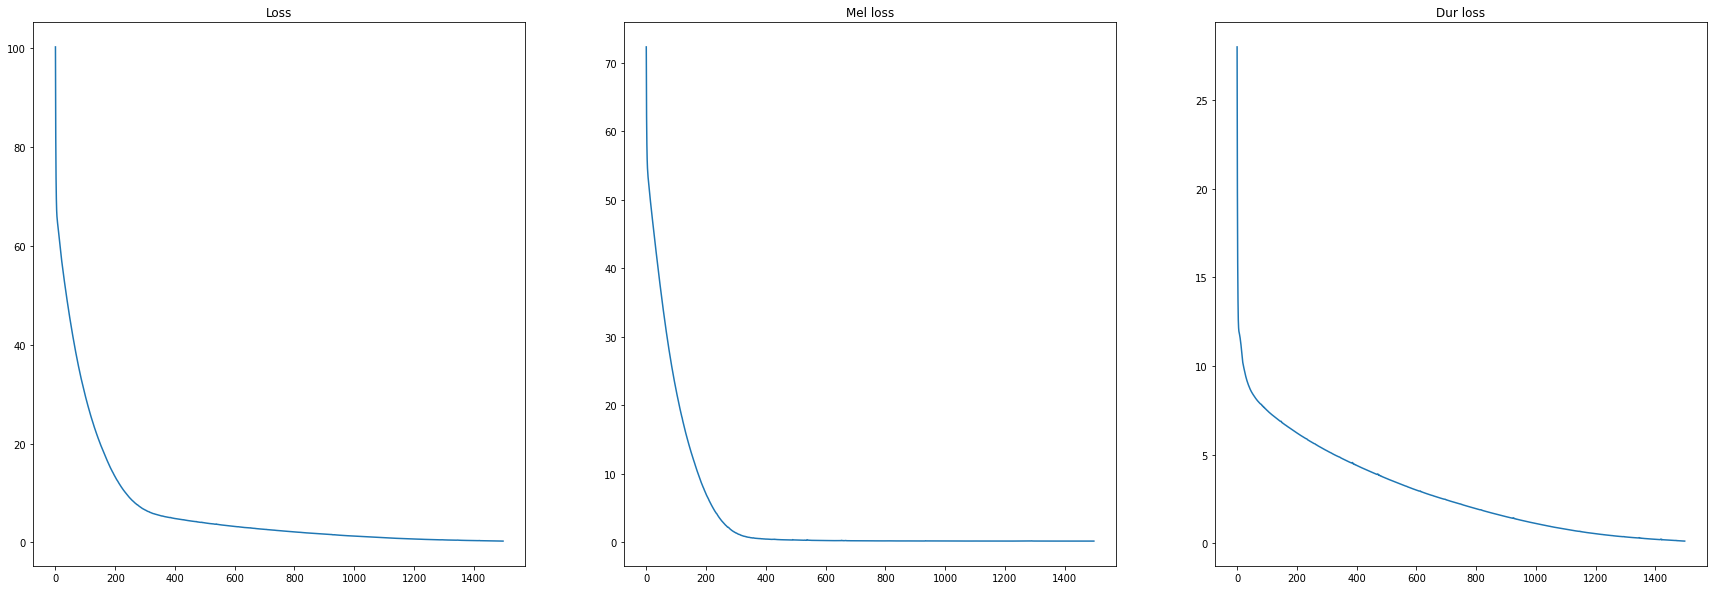

In [56]:
fig, axes = plt.subplots(ncols=3, figsize=(30,10))
axes[0].set_title('Loss')
axes[0].plot(list(range(len(train_loss))), train_loss)
axes[1].set_title('Mel loss')
axes[1].plot(list(range(len(train_mel_loss))), train_mel_loss)
axes[2].set_title('Dur loss')
axes[2].plot(list(range(len(train_dur_loss))), train_dur_loss)